# Score-matching informed KDE

In [36]:
"""
%pip install memory_profiler
%pip install tqdm
%pip install matplotlib
%pip install scikit-learn
%pip install pandas
"""
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('..')
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
import torch.optim as optim
import torch.nn as nn
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import argparse
import pandas as pd
from pandas.plotting import scatter_matrix as pdsm
#import function_cpu as LearnCholesky
from WPO_SGM import toy_data
from WPO_SGM import functions_WPO_SGM as LearnCholesky
import torch.multiprocessing as mp
import logging

from memory_profiler import profile
from tqdm import trange
import time
import gc
# git testing

In [3]:
import os
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU is available")
else:
    device = torch.device('cpu')
    print("GPU is not available")
print(device)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32"

#device = torch.device('cpu')
torch.set_float32_matmul_precision('high')

GPU is not available
cpu


### Parsing for scripts

In [57]:
parser = argparse.ArgumentParser(' ')
parser.add_argument('--data', choices=['swissroll', '8gaussians', 'pinwheel', 'circles', 'moons', '2spirals', 'checkerboard', 'rings','swissroll_6D_xy1', 'cifar10'], type = str,default = '2spirals')
parser.add_argument('--depth',help = 'number of hidden layers of score network',type =int, default = 5)
parser.add_argument('--hiddenunits',help = 'number of nodes per hidden layer', type = int, default = 64)
parser.add_argument('--niters',type = int, default = 50000)
parser.add_argument('--batch_size', type = int,default = 2)
parser.add_argument('--lr',type = float, default = 2e-3) 
parser.add_argument('--save',type = str,default = 'cifar10_experiments/')
parser.add_argument('--train_kernel_size',type = int, default = 1000)
parser.add_argument('--train_samples_size',type = int, default = 50000)
parser.add_argument('--test_samples_size',type = int, default = 500)
args = parser.parse_args('')

In [58]:
train_kernel_size = args.train_kernel_size
train_samples_size = args.train_samples_size
test_samples_size = args.test_samples_size
dataset = args.data 
save_directory = args.save + 'test'+'/'

print('save_directory',save_directory)

if not os.path.exists(save_directory):
    os.makedirs(save_directory)
    print('Created directory ' + save_directory)

save_directory cifar10_experiments/test/


### Precision matrix model

In [18]:
## Cholesky factor model
def construct_factor_model(dim:int, depth:int, hidden_units:int):
    '''
    Initializes neural network that models the Cholesky factor of the precision matrix # For nD examples (in theory)
    '''
    chain = []
    chain.append(nn.Linear(dim,int(hidden_units),bias =True)) 
    chain.append(nn.GELU())

    for _ in range(depth-1):
        chain.append(nn.Linear(int(hidden_units),int(hidden_units),bias = True))
        chain.append(nn.GELU())
    chain.append(nn.Linear(int(hidden_units),int(dim*(dim+1)/2),bias = True)) 

    return nn.Sequential(*chain)   

### Helper functions

In [7]:
#@profile
# Define a compiled function that takes factornet, samples, centers as inputs
compiled_score = torch.compile(LearnCholesky.score_implicit_matching)

def evaluate_model(factornet, kernel_centers, num_test_sample):
    '''
    Evaluate the model by computing the average total loss over 10 batch of testing samples
    '''
    with torch.no_grad():
        total_loss_sum = 0
        device = kernel_centers.device
        for i in range(10):
            p_samples = toy_data.inf_train_gen(dataset,batch_size = num_test_sample)
            testing_samples = torch.as_tensor(p_samples, dtype=torch.float32, device=device)
            total_loss = compiled_score(factornet, testing_samples, kernel_centers)
            total_loss_sum += total_loss.item()
             # Free up memory
            del p_samples, testing_samples, total_loss
            gc.collect() #only if using CPU
            torch.cuda.empty_cache()  # Only if using GPU
        average_total_loss = total_loss_sum / 10
    return average_total_loss

def save_training_slice_cov(factornet, means, epoch, lr, batch_size, loss_value, save):
    '''
    Save the training slice of the NN
    '''
    if save is not None:
        torch.save(factornet.state_dict(), save + 'epoch' + str(epoch)  + 'lr' + str(lr) + 'batch_size' + str(batch_size) + 'model_weights.pth')
        #save the centers
        torch.save(means, save + 'epoch' + str(epoch) + 'centers.pth')

def save_training_slice_log(factornet, means, epoch, lr, batch_size, loss_value, save):
    '''
    Save the training log for the slice
    '''
    if save is not None:
        log_filename = os.path.join(save, f'epoch{epoch}_training.log')
        # log training data
        # Construct log filename


# Configure logging to write to this dynamic file (and also console if you want)
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_filename),
        logging.StreamHandler()
    ]
)

# Now logging calls will write to cifar10_experiments/epoch3_training.log
logging.info("Training started for epoch %d", epoch)

NameError: name 'log_filename' is not defined

### Initialize score network

In [7]:
"""
# check the dataset
dataset = args.data
dataset = 'swissroll'
# dataset = 'swissroll_6D_xy1'
means  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = 1000)).to(dtype = torch.float32)
data_dim = means.shape[1]
print('data_dim',data_dim)

blah = pd.DataFrame(means)
pdsm(blah)
"""

"\n# check the dataset\ndataset = args.data\ndataset = 'swissroll'\n# dataset = 'swissroll_6D_xy1'\nmeans  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = 1000)).to(dtype = torch.float32)\ndata_dim = means.shape[1]\nprint('data_dim',data_dim)\n\nblah = pd.DataFrame(means)\npdsm(blah)\n"

## Initialize Data using CIFAR-10


In [19]:
# check the dataset
torch.cuda.empty_cache()
dataset = args.data
dataset = 'cifar10'
means  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = train_kernel_size)).to(dtype = torch.float32)
data_dim = means.shape[1]
del means
torch.cuda.empty_cache()
# dataset = 'swissroll_6D_xy1'
""""" # not used anymore since our data is pictures
means  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = 1000)).to(dtype = torch.float32)
data_dim = means.shape[1]
print('data_dim',data_dim)

blah = pd.DataFrame(means)
pdsm(blah)
"""


tensor(-1.) tensor(1.)


C:\Users\pongd\AppData\Local\Temp\ipykernel_3596\1167857191.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = train_kernel_size)).to(dtype = torch.float32)


'"" # not used anymore since our data is pictures\nmeans  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = 1000)).to(dtype = torch.float32)\ndata_dim = means.shape[1]\nprint(\'data_dim\',data_dim)\n\nblah = pd.DataFrame(means)\npdsm(blah)\n'

In [20]:
depth = args.depth
hidden_units = args.hiddenunits
factornet = construct_factor_model(data_dim, depth, hidden_units).to(device).to(dtype = torch.float32)
factornet = torch.compile(factornet, mode="reduce-overhead")

lr = args.lr
optimizer = optim.Adam(factornet.parameters(), lr=args.lr)

p_samples = toy_data.inf_train_gen(dataset,batch_size = train_samples_size)
training_samples = torch.tensor(p_samples).to(dtype = torch.float32).to(device)
centers  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = train_kernel_size)).to(dtype = torch.float32).to(device)

epochs = args.niters
batch_size = args.batch_size
torch.save(centers, save_directory + str(epochs) + 'epochs' + str(train_kernel_size) + 'centers.pt')
del p_samples
"""
# Training the score network
loss = evaluate_model(factornet, centers, test_samples_size)
formatted_loss = f'{loss:.3e}'  # Format the average with up to 1e-3 precision
print(f'Before train, Average total_loss: {formatted_loss}')
"""

tensor(-1.) tensor(1.)


C:\Users\pongd\AppData\Local\Temp\ipykernel_3596\563120124.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  training_samples = torch.tensor(p_samples).to(dtype = torch.float32).to(device)


tensor(-1.) tensor(1.)


C:\Users\pongd\AppData\Local\Temp\ipykernel_3596\563120124.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  centers  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = train_kernel_size)).to(dtype = torch.float32).to(device)


"\n# Training the score network\nloss = evaluate_model(factornet, centers, test_samples_size)\nformatted_loss = f'{loss:.3e}'  # Format the average with up to 1e-3 precision\nprint(f'Before train, Average total_loss: {formatted_loss}')\n"

In [ ]:
#@profile
gc.collect()
torch.cuda.empty_cache()

scaler = torch.amp.GradScaler('cuda') #mixed precision gradient scaler

def opt_check(factornet, samples, centers):
    optimizer.zero_grad()
    loss = LearnCholesky.score_implicit_matching(factornet, samples, centers)  # autocast inside
    scaler.scale(loss).backward() #loss.backward()
    scaler.step(optimizer) #optimizer.step()
    scaler.update()
    return loss

compiled_opt_check = torch.compile(opt_check)

for step in trange(epochs, desc="Training"):
    randind = torch.randint(0, train_samples_size, [batch_size,])
    samples = training_samples[randind, :]
    
    loss_value = compiled_opt_check(factornet, samples, centers).item()
    print(f"Peak memory usage: {torch.cuda.max_memory_allocated() / 2**30:.2f} GiB")
    if step % 4000 == 0:
        print(f"Step {step} started")
        print(f'Step: {step}, Loss value: {loss_value:.3e}')
    
    if step % 20000 == 0:
        loss0 = evaluate_model(factornet, centers, test_samples_size)
        save_training_slice_cov(factornet, centers, step, lr, batch_size, loss0, save_directory)

    if step < epochs - 1:
        del samples
        gc.collect()
        torch.cuda.empty_cache()


Training:   0%|          | 0/50000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/_inductor/lowering.py:1725: FutureWarning: `torch._prims_common.check` is deprecated and will be removed in the future. Please use `torch._check*` functions instead.
  check(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/lowering.py:7007: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(


Peak memory (bytes): 153196507136
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91849 MiB | 146099 MiB |   2476 GiB |   2386 GiB |
|       from large pool |  91778 MiB | 145958 MiB |   2476 GiB |   2386 GiB |
|       from small pool |     71 MiB |    142 MiB |      0 GiB |      0 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91849 MiB | 146099 MiB |   2476 GiB |   2386 GiB |
|       from large pool |  917

W0613 06:14:46.374000 192010 torch/_logging/_internal.py:1130] [13/0] Profiler function <class 'torch.autograd.profiler.record_function'> will be ignored


Peak memory usage: 142.68 GiB
Step 0 started
Step: 0, Loss value: -1.990e+08
tensor(-1.) tensor(1.)


/usr/local/lib/python3.11/dist-packages/torch/_inductor/lowering.py:1725: FutureWarning: `torch._prims_common.check` is deprecated and will be removed in the future. Please use `torch._check*` functions instead.
  check(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/lowering.py:7007: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(


Peak memory (bytes): 77662541312
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  37810 MiB |  74064 MiB |   8870 GiB |   8834 GiB |
|       from large pool |  37809 MiB |  74063 MiB |   8869 GiB |   8832 GiB |
|       from small pool |      0 MiB |      8 MiB |      1 GiB |      1 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  37810 MiB |  74064 MiB |   8870 GiB |   8834 GiB |
|       from large pool |  3780

W0613 06:34:15.567000 192010 torch/_dynamo/convert_frame.py:964] [9/8] torch._dynamo hit config.recompile_limit (8)
W0613 06:34:15.567000 192010 torch/_dynamo/convert_frame.py:964] [9/8]    function: 'torch_dynamo_resume_in_score_implicit_matching_at_399' (/workspace/functions_WPO_SGM.py:399)
W0613 06:34:15.567000 192010 torch/_dynamo/convert_frame.py:964] [9/8]    last reason: 9/7: ___stack1 == '|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  37810 MiB |  74064 M

Peak memory (bytes): 77662541312
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  37810 MiB |  74064 MiB |  38224 GiB |  38187 GiB |
|       from large pool |  37809 MiB |  74063 MiB |  38213 GiB |  38176 GiB |
|       from small pool |      0 MiB |      8 MiB |     10 GiB |     10 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  37810 MiB |  74064 MiB |  38224 GiB |  38187 GiB |
|       from large pool |  3780

Training:   0%|          | 1/50000 [32:47<27330:44:56, 1967.85s/it]/usr/local/lib/python3.11/dist-packages/torch/_inductor/lowering.py:1725: FutureWarning: `torch._prims_common.check` is deprecated and will be removed in the future. Please use `torch._check*` functions instead.
  check(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/lowering.py:7007: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(


Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  47186 GiB |  47097 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  47173 GiB |  47083 GiB |
|       from small pool |     36 MiB |    107 MiB |     13 GiB |     13 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  47186 GiB |  47097 GiB |
|       from large pool |  917

Training:   0%|          | 2/50000 [43:49<16662:05:42, 1199.72s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  47457 GiB |  47368 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  47444 GiB |  47354 GiB |
|       from small pool |     36 MiB |    107 MiB |     13 GiB |     13 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  47457 GiB |  47368 GiB |


Training:   0%|          | 3/50000 [44:14<9210:30:42, 663.20s/it]  

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  47724 GiB |  47634 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  47710 GiB |  47620 GiB |
|       from small pool |     36 MiB |    107 MiB |     13 GiB |     13 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  47724 GiB |  47634 GiB |


Training:   0%|          | 4/50000 [44:39<5709:00:34, 411.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  47990 GiB |  47900 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  47976 GiB |  47886 GiB |
|       from small pool |     36 MiB |    107 MiB |     13 GiB |     13 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  47990 GiB |  47900 GiB |


Training:   0%|          | 5/50000 [45:03<3773:18:26, 271.71s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  48256 GiB |  48167 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  48242 GiB |  48152 GiB |
|       from small pool |     36 MiB |    107 MiB |     14 GiB |     14 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  48256 GiB |  48167 GiB |


Training:   0%|          | 6/50000 [45:28<2607:10:10, 187.74s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  48523 GiB |  48433 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  48508 GiB |  48419 GiB |
|       from small pool |     36 MiB |    107 MiB |     14 GiB |     14 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  48523 GiB |  48433 GiB |


Training:   0%|          | 7/50000 [45:53<1866:00:26, 134.37s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  48789 GiB |  48699 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  48774 GiB |  48685 GiB |
|       from small pool |     36 MiB |    107 MiB |     14 GiB |     14 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  48789 GiB |  48699 GiB |


Training:   0%|          | 8/50000 [46:17<1379:15:57, 99.32s/it] 

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  49055 GiB |  48966 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  49041 GiB |  48951 GiB |
|       from small pool |     36 MiB |    107 MiB |     14 GiB |     14 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  49055 GiB |  48966 GiB |


Training:   0%|          | 9/50000 [46:41<1051:50:20, 75.75s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  49322 GiB |  49232 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  49307 GiB |  49217 GiB |
|       from small pool |     36 MiB |    107 MiB |     15 GiB |     14 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  49322 GiB |  49232 GiB |


Training:   0%|          | 10/50000 [47:05<829:33:06, 59.74s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  49588 GiB |  49498 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  49573 GiB |  49483 GiB |
|       from small pool |     36 MiB |    107 MiB |     15 GiB |     15 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  49588 GiB |  49498 GiB |


Training:   0%|          | 11/50000 [47:29<677:48:23, 48.81s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  49854 GiB |  49765 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  49839 GiB |  49749 GiB |
|       from small pool |     36 MiB |    107 MiB |     15 GiB |     15 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  49854 GiB |  49765 GiB |


Training:   0%|          | 12/50000 [47:52<572:14:04, 41.21s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  50121 GiB |  50031 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  50105 GiB |  50016 GiB |
|       from small pool |     36 MiB |    107 MiB |     15 GiB |     15 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  50121 GiB |  50031 GiB |


Training:   0%|          | 13/50000 [48:16<499:57:20, 36.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  50387 GiB |  50298 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  50371 GiB |  50282 GiB |
|       from small pool |     36 MiB |    107 MiB |     15 GiB |     15 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  50387 GiB |  50298 GiB |


Training:   0%|          | 14/50000 [48:40<449:10:33, 32.35s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  50654 GiB |  50564 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  50637 GiB |  50548 GiB |
|       from small pool |     36 MiB |    107 MiB |     16 GiB |     16 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  50654 GiB |  50564 GiB |


Training:   0%|          | 15/50000 [49:04<413:09:59, 29.76s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  50920 GiB |  50830 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  50904 GiB |  50814 GiB |
|       from small pool |     36 MiB |    107 MiB |     16 GiB |     16 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  50920 GiB |  50830 GiB |


Training:   0%|          | 16/50000 [49:28<389:11:31, 28.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  51186 GiB |  51097 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  51170 GiB |  51080 GiB |
|       from small pool |     36 MiB |    107 MiB |     16 GiB |     16 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  51186 GiB |  51097 GiB |


Training:   0%|          | 17/50000 [49:52<371:19:14, 26.74s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  51453 GiB |  51363 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  51436 GiB |  51346 GiB |
|       from small pool |     36 MiB |    107 MiB |     16 GiB |     16 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  51453 GiB |  51363 GiB |


Training:   0%|          | 18/50000 [50:16<359:21:06, 25.88s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  51719 GiB |  51629 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  51702 GiB |  51612 GiB |
|       from small pool |     36 MiB |    107 MiB |     16 GiB |     16 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  51719 GiB |  51629 GiB |


Training:   0%|          | 19/50000 [50:40<351:14:33, 25.30s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  51985 GiB |  51896 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  51968 GiB |  51879 GiB |
|       from small pool |     36 MiB |    107 MiB |     17 GiB |     17 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  51985 GiB |  51896 GiB |


Training:   0%|          | 20/50000 [51:03<344:42:52, 24.83s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  52252 GiB |  52162 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  52234 GiB |  52145 GiB |
|       from small pool |     36 MiB |    107 MiB |     17 GiB |     17 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  52252 GiB |  52162 GiB |


Training:   0%|          | 21/50000 [51:27<341:17:47, 24.58s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  52518 GiB |  52428 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  52501 GiB |  52411 GiB |
|       from small pool |     36 MiB |    107 MiB |     17 GiB |     17 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  52518 GiB |  52428 GiB |


Training:   0%|          | 22/50000 [51:51<337:53:35, 24.34s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  52784 GiB |  52695 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  52767 GiB |  52677 GiB |
|       from small pool |     36 MiB |    107 MiB |     17 GiB |     17 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  52784 GiB |  52695 GiB |


Training:   0%|          | 23/50000 [52:15<336:22:39, 24.23s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  53051 GiB |  52961 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  53033 GiB |  52943 GiB |
|       from small pool |     36 MiB |    107 MiB |     17 GiB |     17 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  53051 GiB |  52961 GiB |
|       from large pool |  917

Training:   0%|          | 24/50000 [52:39<335:22:32, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  53317 GiB |  53227 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  53299 GiB |  53209 GiB |
|       from small pool |     36 MiB |    107 MiB |     18 GiB |     18 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  53317 GiB |  53227 GiB |


Training:   0%|          | 25/50000 [53:03<334:00:52, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  53584 GiB |  53494 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  53565 GiB |  53475 GiB |
|       from small pool |     36 MiB |    107 MiB |     18 GiB |     18 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  53584 GiB |  53494 GiB |


Training:   0%|          | 26/50000 [53:27<333:59:25, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  53850 GiB |  53760 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  53831 GiB |  53742 GiB |
|       from small pool |     36 MiB |    107 MiB |     18 GiB |     18 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  53850 GiB |  53760 GiB |


Training:   0%|          | 27/50000 [53:51<333:34:55, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  54116 GiB |  54027 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  54097 GiB |  54008 GiB |
|       from small pool |     36 MiB |    107 MiB |     18 GiB |     18 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  54116 GiB |  54027 GiB |


Training:   0%|          | 28/50000 [54:15<333:46:49, 24.05s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  54383 GiB |  54293 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  54364 GiB |  54274 GiB |
|       from small pool |     36 MiB |    107 MiB |     19 GiB |     18 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  54383 GiB |  54293 GiB |
|       from large pool |  917

Training:   0%|          | 29/50000 [54:40<337:28:29, 24.31s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  54649 GiB |  54559 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  54630 GiB |  54540 GiB |
|       from small pool |     36 MiB |    107 MiB |     19 GiB |     19 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  54649 GiB |  54559 GiB |


Training:   0%|          | 30/50000 [55:04<335:12:19, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  54915 GiB |  54826 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  54896 GiB |  54806 GiB |
|       from small pool |     36 MiB |    107 MiB |     19 GiB |     19 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  54915 GiB |  54826 GiB |


Training:   0%|          | 31/50000 [55:28<334:18:23, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  55182 GiB |  55092 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  55162 GiB |  55072 GiB |
|       from small pool |     36 MiB |    107 MiB |     19 GiB |     19 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  55182 GiB |  55092 GiB |


Training:   0%|          | 32/50000 [55:52<334:08:17, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  55448 GiB |  55358 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  55428 GiB |  55339 GiB |
|       from small pool |     36 MiB |    107 MiB |     19 GiB |     19 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  55448 GiB |  55358 GiB |


Training:   0%|          | 33/50000 [56:16<333:21:19, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  55714 GiB |  55625 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  55694 GiB |  55605 GiB |
|       from small pool |     36 MiB |    107 MiB |     20 GiB |     20 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  55714 GiB |  55625 GiB |


Training:   0%|          | 34/50000 [56:40<334:02:38, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  55981 GiB |  55891 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  55960 GiB |  55871 GiB |
|       from small pool |     36 MiB |    107 MiB |     20 GiB |     20 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  55981 GiB |  55891 GiB |


Training:   0%|          | 35/50000 [57:04<333:02:03, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  56247 GiB |  56157 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  56227 GiB |  56137 GiB |
|       from small pool |     36 MiB |    107 MiB |     20 GiB |     20 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  56247 GiB |  56157 GiB |


Training:   0%|          | 36/50000 [57:28<332:44:20, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  56513 GiB |  56424 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  56493 GiB |  56403 GiB |
|       from small pool |     36 MiB |    107 MiB |     20 GiB |     20 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  56513 GiB |  56424 GiB |


Training:   0%|          | 37/50000 [57:52<332:49:46, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  56780 GiB |  56690 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  56759 GiB |  56669 GiB |
|       from small pool |     36 MiB |    107 MiB |     20 GiB |     20 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  56780 GiB |  56690 GiB |


Training:   0%|          | 38/50000 [58:15<332:05:06, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  57046 GiB |  56957 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  57025 GiB |  56935 GiB |
|       from small pool |     36 MiB |    107 MiB |     21 GiB |     21 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  57046 GiB |  56957 GiB |


Training:   0%|          | 39/50000 [58:40<332:48:30, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  57313 GiB |  57223 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  57291 GiB |  57202 GiB |
|       from small pool |     36 MiB |    107 MiB |     21 GiB |     21 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  57313 GiB |  57223 GiB |


Training:   0%|          | 40/50000 [59:04<333:33:49, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  57579 GiB |  57489 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  57557 GiB |  57468 GiB |
|       from small pool |     36 MiB |    107 MiB |     21 GiB |     21 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  57579 GiB |  57489 GiB |


Training:   0%|          | 41/50000 [59:28<334:06:57, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  57845 GiB |  57756 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  57824 GiB |  57734 GiB |
|       from small pool |     36 MiB |    107 MiB |     21 GiB |     21 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  57845 GiB |  57756 GiB |


Training:   0%|          | 42/50000 [59:52<335:13:27, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  58112 GiB |  58022 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  58090 GiB |  58000 GiB |
|       from small pool |     36 MiB |    107 MiB |     21 GiB |     21 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  58112 GiB |  58022 GiB |


Training:   0%|          | 43/50000 [1:00:16<334:54:59, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  58378 GiB |  58288 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  58356 GiB |  58266 GiB |
|       from small pool |     36 MiB |    107 MiB |     22 GiB |     22 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  58378 GiB |  58288 GiB |


Training:   0%|          | 44/50000 [1:00:41<335:43:23, 24.19s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  58644 GiB |  58555 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  58622 GiB |  58532 GiB |
|       from small pool |     36 MiB |    107 MiB |     22 GiB |     22 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  58644 GiB |  58555 GiB |


Training:   0%|          | 45/50000 [1:01:05<335:45:25, 24.20s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  58911 GiB |  58821 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  58888 GiB |  58798 GiB |
|       from small pool |     36 MiB |    107 MiB |     22 GiB |     22 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  58911 GiB |  58821 GiB |


Training:   0%|          | 46/50000 [1:01:29<335:19:27, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  59177 GiB |  59087 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  59154 GiB |  59065 GiB |
|       from small pool |     36 MiB |    107 MiB |     22 GiB |     22 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  59177 GiB |  59087 GiB |


Training:   0%|          | 47/50000 [1:01:53<336:17:11, 24.24s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  59443 GiB |  59354 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  59420 GiB |  59331 GiB |
|       from small pool |     36 MiB |    107 MiB |     23 GiB |     22 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  59443 GiB |  59354 GiB |


Training:   0%|          | 48/50000 [1:02:17<335:21:44, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  59710 GiB |  59620 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  59687 GiB |  59597 GiB |
|       from small pool |     36 MiB |    107 MiB |     23 GiB |     23 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  59710 GiB |  59620 GiB |


Training:   0%|          | 49/50000 [1:02:41<334:07:59, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  59976 GiB |  59887 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  59953 GiB |  59863 GiB |
|       from small pool |     36 MiB |    107 MiB |     23 GiB |     23 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  59976 GiB |  59887 GiB |


Training:   0%|          | 50/50000 [1:03:05<333:17:36, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  60243 GiB |  60153 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  60219 GiB |  60129 GiB |
|       from small pool |     36 MiB |    107 MiB |     23 GiB |     23 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  60243 GiB |  60153 GiB |


Training:   0%|          | 51/50000 [1:03:29<332:00:08, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  60509 GiB |  60419 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  60485 GiB |  60395 GiB |
|       from small pool |     36 MiB |    107 MiB |     23 GiB |     23 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  60509 GiB |  60419 GiB |


Training:   0%|          | 52/50000 [1:03:53<334:49:53, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  60775 GiB |  60686 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  60751 GiB |  60662 GiB |
|       from small pool |     36 MiB |    107 MiB |     24 GiB |     24 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  60775 GiB |  60686 GiB |


Training:   0%|          | 53/50000 [1:04:18<335:43:52, 24.20s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  61042 GiB |  60952 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  61017 GiB |  60928 GiB |
|       from small pool |     36 MiB |    107 MiB |     24 GiB |     24 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  61042 GiB |  60952 GiB |


Training:   0%|          | 54/50000 [1:04:42<335:40:40, 24.19s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  61308 GiB |  61218 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  61283 GiB |  61194 GiB |
|       from small pool |     36 MiB |    107 MiB |     24 GiB |     24 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  61308 GiB |  61218 GiB |


Training:   0%|          | 55/50000 [1:05:06<335:23:12, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  61574 GiB |  61485 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  61550 GiB |  61460 GiB |
|       from small pool |     36 MiB |    107 MiB |     24 GiB |     24 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  61574 GiB |  61485 GiB |


Training:   0%|          | 56/50000 [1:05:30<334:26:50, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  61841 GiB |  61751 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  61816 GiB |  61726 GiB |
|       from small pool |     36 MiB |    107 MiB |     24 GiB |     24 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  61841 GiB |  61751 GiB |


Training:   0%|          | 57/50000 [1:05:54<334:11:13, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  62107 GiB |  62017 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  62082 GiB |  61992 GiB |
|       from small pool |     36 MiB |    107 MiB |     25 GiB |     25 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  62107 GiB |  62017 GiB |


Training:   0%|          | 58/50000 [1:06:18<333:24:56, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  62373 GiB |  62284 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  62348 GiB |  62258 GiB |
|       from small pool |     36 MiB |    107 MiB |     25 GiB |     25 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  62373 GiB |  62284 GiB |


Training:   0%|          | 59/50000 [1:06:42<332:28:04, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  62640 GiB |  62550 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  62614 GiB |  62525 GiB |
|       from small pool |     36 MiB |    107 MiB |     25 GiB |     25 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  62640 GiB |  62550 GiB |


Training:   0%|          | 60/50000 [1:07:06<333:03:33, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  62906 GiB |  62816 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  62880 GiB |  62791 GiB |
|       from small pool |     36 MiB |    107 MiB |     25 GiB |     25 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  62906 GiB |  62816 GiB |


Training:   0%|          | 61/50000 [1:07:30<333:32:26, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  63173 GiB |  63083 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  63147 GiB |  63057 GiB |
|       from small pool |     36 MiB |    107 MiB |     25 GiB |     25 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  63173 GiB |  63083 GiB |


Training:   0%|          | 62/50000 [1:07:54<333:36:15, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  63439 GiB |  63349 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  63413 GiB |  63323 GiB |
|       from small pool |     36 MiB |    107 MiB |     26 GiB |     26 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  63439 GiB |  63349 GiB |


Training:   0%|          | 63/50000 [1:08:18<333:21:59, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  63705 GiB |  63616 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  63679 GiB |  63589 GiB |
|       from small pool |     36 MiB |    107 MiB |     26 GiB |     26 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  63705 GiB |  63616 GiB |


Training:   0%|          | 64/50000 [1:08:42<332:50:25, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  63972 GiB |  63882 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  63945 GiB |  63855 GiB |
|       from small pool |     36 MiB |    107 MiB |     26 GiB |     26 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  63972 GiB |  63882 GiB |


Training:   0%|          | 65/50000 [1:09:06<333:20:48, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  64238 GiB |  64148 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  64211 GiB |  64121 GiB |
|       from small pool |     36 MiB |    107 MiB |     26 GiB |     26 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  64238 GiB |  64148 GiB |


Training:   0%|          | 66/50000 [1:09:30<333:26:25, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  64504 GiB |  64415 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  64477 GiB |  64388 GiB |
|       from small pool |     36 MiB |    107 MiB |     27 GiB |     26 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  64504 GiB |  64415 GiB |


Training:   0%|          | 67/50000 [1:09:54<333:05:04, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  64771 GiB |  64681 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  64743 GiB |  64654 GiB |
|       from small pool |     36 MiB |    107 MiB |     27 GiB |     27 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  64771 GiB |  64681 GiB |


Training:   0%|          | 68/50000 [1:10:18<333:21:28, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  65037 GiB |  64947 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  65010 GiB |  64920 GiB |
|       from small pool |     36 MiB |    107 MiB |     27 GiB |     27 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  65037 GiB |  64947 GiB |


Training:   0%|          | 69/50000 [1:10:42<332:02:01, 23.94s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  65303 GiB |  65214 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  65276 GiB |  65186 GiB |
|       from small pool |     36 MiB |    107 MiB |     27 GiB |     27 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  65303 GiB |  65214 GiB |


Training:   0%|          | 70/50000 [1:11:06<332:22:43, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  65570 GiB |  65480 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  65542 GiB |  65452 GiB |
|       from small pool |     36 MiB |    107 MiB |     27 GiB |     27 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  65570 GiB |  65480 GiB |


Training:   0%|          | 71/50000 [1:11:30<333:07:50, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  65836 GiB |  65746 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  65808 GiB |  65718 GiB |
|       from small pool |     36 MiB |    107 MiB |     28 GiB |     28 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  65836 GiB |  65746 GiB |


Training:   0%|          | 72/50000 [1:11:54<332:26:04, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  66102 GiB |  66013 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  66074 GiB |  65985 GiB |
|       from small pool |     36 MiB |    107 MiB |     28 GiB |     28 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  66102 GiB |  66013 GiB |


Training:   0%|          | 73/50000 [1:12:18<332:31:51, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  66369 GiB |  66279 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  66340 GiB |  66251 GiB |
|       from small pool |     36 MiB |    107 MiB |     28 GiB |     28 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  66369 GiB |  66279 GiB |


Training:   0%|          | 74/50000 [1:12:42<331:48:03, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  66635 GiB |  66546 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  66606 GiB |  66517 GiB |
|       from small pool |     36 MiB |    107 MiB |     28 GiB |     28 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  66635 GiB |  66546 GiB |


Training:   0%|          | 75/50000 [1:13:06<331:47:21, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  66902 GiB |  66812 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  66873 GiB |  66783 GiB |
|       from small pool |     36 MiB |    107 MiB |     28 GiB |     28 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  66902 GiB |  66812 GiB |


Training:   0%|          | 76/50000 [1:13:30<332:11:26, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  67168 GiB |  67078 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  67139 GiB |  67049 GiB |
|       from small pool |     36 MiB |    107 MiB |     29 GiB |     29 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  67168 GiB |  67078 GiB |


Training:   0%|          | 77/50000 [1:13:53<331:17:17, 23.89s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  67434 GiB |  67345 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  67405 GiB |  67315 GiB |
|       from small pool |     36 MiB |    107 MiB |     29 GiB |     29 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  67434 GiB |  67345 GiB |


Training:   0%|          | 78/50000 [1:14:18<332:10:51, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  67701 GiB |  67611 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  67671 GiB |  67581 GiB |
|       from small pool |     36 MiB |    107 MiB |     29 GiB |     29 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  67701 GiB |  67611 GiB |


Training:   0%|          | 79/50000 [1:14:41<331:37:20, 23.91s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  67967 GiB |  67877 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  67937 GiB |  67848 GiB |
|       from small pool |     36 MiB |    107 MiB |     29 GiB |     29 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  67967 GiB |  67877 GiB |


Training:   0%|          | 80/50000 [1:15:05<331:35:53, 23.91s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  68233 GiB |  68144 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  68203 GiB |  68114 GiB |
|       from small pool |     36 MiB |    107 MiB |     29 GiB |     29 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  68233 GiB |  68144 GiB |


Training:   0%|          | 81/50000 [1:15:29<331:59:22, 23.94s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  68500 GiB |  68410 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  68470 GiB |  68380 GiB |
|       from small pool |     36 MiB |    107 MiB |     30 GiB |     30 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  68500 GiB |  68410 GiB |


Training:   0%|          | 82/50000 [1:15:53<331:06:13, 23.88s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  68766 GiB |  68676 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  68736 GiB |  68646 GiB |
|       from small pool |     36 MiB |    107 MiB |     30 GiB |     30 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  68766 GiB |  68676 GiB |


Training:   0%|          | 83/50000 [1:16:17<331:42:59, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  69032 GiB |  68943 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  69002 GiB |  68912 GiB |
|       from small pool |     36 MiB |    107 MiB |     30 GiB |     30 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  69032 GiB |  68943 GiB |


Training:   0%|          | 84/50000 [1:16:41<331:48:47, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  69299 GiB |  69209 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  69268 GiB |  69178 GiB |
|       from small pool |     36 MiB |    107 MiB |     30 GiB |     30 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  69299 GiB |  69209 GiB |


Training:   0%|          | 85/50000 [1:17:05<332:03:26, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  69565 GiB |  69475 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  69534 GiB |  69444 GiB |
|       from small pool |     36 MiB |    107 MiB |     31 GiB |     30 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  69565 GiB |  69475 GiB |


Training:   0%|          | 86/50000 [1:17:29<332:05:14, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  69832 GiB |  69742 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  69800 GiB |  69711 GiB |
|       from small pool |     36 MiB |    107 MiB |     31 GiB |     31 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  69832 GiB |  69742 GiB |


Training:   0%|          | 87/50000 [1:17:53<331:11:13, 23.89s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  70098 GiB |  70008 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  70066 GiB |  69977 GiB |
|       from small pool |     36 MiB |    107 MiB |     31 GiB |     31 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  70098 GiB |  70008 GiB |


Training:   0%|          | 88/50000 [1:18:17<331:30:41, 23.91s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  70364 GiB |  70275 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  70333 GiB |  70243 GiB |
|       from small pool |     36 MiB |    107 MiB |     31 GiB |     31 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  70364 GiB |  70275 GiB |


Training:   0%|          | 89/50000 [1:18:41<331:45:51, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  70631 GiB |  70541 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  70599 GiB |  70509 GiB |
|       from small pool |     36 MiB |    107 MiB |     31 GiB |     31 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  70631 GiB |  70541 GiB |


Training:   0%|          | 90/50000 [1:19:04<331:17:57, 23.90s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  70897 GiB |  70807 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  70865 GiB |  70775 GiB |
|       from small pool |     36 MiB |    107 MiB |     32 GiB |     32 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  70897 GiB |  70807 GiB |


Training:   0%|          | 91/50000 [1:19:29<332:17:32, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  71163 GiB |  71074 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  71131 GiB |  71041 GiB |
|       from small pool |     36 MiB |    107 MiB |     32 GiB |     32 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  71163 GiB |  71074 GiB |


Training:   0%|          | 92/50000 [1:19:52<331:51:53, 23.94s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  71430 GiB |  71340 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  71397 GiB |  71308 GiB |
|       from small pool |     36 MiB |    107 MiB |     32 GiB |     32 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  71430 GiB |  71340 GiB |


Training:   0%|          | 93/50000 [1:20:16<332:00:09, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  71696 GiB |  71606 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  71663 GiB |  71574 GiB |
|       from small pool |     36 MiB |    107 MiB |     32 GiB |     32 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  71696 GiB |  71606 GiB |


Training:   0%|          | 94/50000 [1:20:40<332:11:58, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  71962 GiB |  71873 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  71930 GiB |  71840 GiB |
|       from small pool |     36 MiB |    107 MiB |     32 GiB |     32 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  71962 GiB |  71873 GiB |


Training:   0%|          | 95/50000 [1:21:04<331:23:45, 23.91s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  72229 GiB |  72139 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  72196 GiB |  72106 GiB |
|       from small pool |     36 MiB |    107 MiB |     33 GiB |     33 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  72229 GiB |  72139 GiB |


Training:   0%|          | 96/50000 [1:21:28<332:12:29, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  72495 GiB |  72405 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  72462 GiB |  72372 GiB |
|       from small pool |     36 MiB |    107 MiB |     33 GiB |     33 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  72495 GiB |  72405 GiB |


Training:   0%|          | 97/50000 [1:21:52<331:32:26, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  72762 GiB |  72672 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  72728 GiB |  72638 GiB |
|       from small pool |     36 MiB |    107 MiB |     33 GiB |     33 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  72762 GiB |  72672 GiB |


Training:   0%|          | 98/50000 [1:22:16<330:58:59, 23.88s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  73028 GiB |  72938 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  72994 GiB |  72904 GiB |
|       from small pool |     36 MiB |    107 MiB |     33 GiB |     33 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  73028 GiB |  72938 GiB |


Training:   0%|          | 99/50000 [1:22:40<331:48:40, 23.94s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  73294 GiB |  73205 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  73260 GiB |  73171 GiB |
|       from small pool |     36 MiB |    107 MiB |     33 GiB |     33 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  73294 GiB |  73205 GiB |


Training:   0%|          | 100/50000 [1:23:04<332:22:55, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  73561 GiB |  73471 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  73526 GiB |  73437 GiB |
|       from small pool |     36 MiB |    107 MiB |     34 GiB |     34 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  73561 GiB |  73471 GiB |


Training:   0%|          | 101/50000 [1:23:28<332:59:06, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  73827 GiB |  73737 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  73793 GiB |  73703 GiB |
|       from small pool |     36 MiB |    107 MiB |     34 GiB |     34 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  73827 GiB |  73737 GiB |


Training:   0%|          | 102/50000 [1:23:52<332:05:31, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  74093 GiB |  74004 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  74059 GiB |  73969 GiB |
|       from small pool |     36 MiB |    107 MiB |     34 GiB |     34 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  74093 GiB |  74004 GiB |


Training:   0%|          | 103/50000 [1:24:16<331:10:29, 23.89s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  74360 GiB |  74270 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  74325 GiB |  74235 GiB |
|       from small pool |     36 MiB |    107 MiB |     34 GiB |     34 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  74360 GiB |  74270 GiB |


Training:   0%|          | 104/50000 [1:24:40<331:43:43, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  74626 GiB |  74536 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  74591 GiB |  74501 GiB |
|       from small pool |     36 MiB |    107 MiB |     35 GiB |     35 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  74626 GiB |  74536 GiB |


Training:   0%|          | 105/50000 [1:25:04<331:08:49, 23.89s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  74892 GiB |  74803 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  74857 GiB |  74768 GiB |
|       from small pool |     36 MiB |    107 MiB |     35 GiB |     35 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  74892 GiB |  74803 GiB |


Training:   0%|          | 106/50000 [1:25:28<331:30:59, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  75159 GiB |  75069 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  75123 GiB |  75034 GiB |
|       from small pool |     36 MiB |    107 MiB |     35 GiB |     35 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  75159 GiB |  75069 GiB |


Training:   0%|          | 107/50000 [1:25:52<331:53:29, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  75425 GiB |  75335 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  75389 GiB |  75300 GiB |
|       from small pool |     36 MiB |    107 MiB |     35 GiB |     35 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  75425 GiB |  75335 GiB |


Training:   0%|          | 108/50000 [1:26:15<331:16:12, 23.90s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  75691 GiB |  75602 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  75656 GiB |  75566 GiB |
|       from small pool |     36 MiB |    107 MiB |     35 GiB |     35 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  75691 GiB |  75602 GiB |


Training:   0%|          | 109/50000 [1:26:39<332:10:48, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  75958 GiB |  75868 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  75922 GiB |  75832 GiB |
|       from small pool |     36 MiB |    107 MiB |     36 GiB |     36 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  75958 GiB |  75868 GiB |


Training:   0%|          | 110/50000 [1:27:03<331:44:07, 23.94s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  76224 GiB |  76135 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  76188 GiB |  76098 GiB |
|       from small pool |     36 MiB |    107 MiB |     36 GiB |     36 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  76224 GiB |  76135 GiB |


Training:   0%|          | 111/50000 [1:27:27<331:44:28, 23.94s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  76491 GiB |  76401 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  76454 GiB |  76364 GiB |
|       from small pool |     36 MiB |    107 MiB |     36 GiB |     36 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  76491 GiB |  76401 GiB |


Training:   0%|          | 112/50000 [1:27:51<332:22:03, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  76757 GiB |  76667 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  76720 GiB |  76631 GiB |
|       from small pool |     36 MiB |    107 MiB |     36 GiB |     36 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  76757 GiB |  76667 GiB |


Training:   0%|          | 113/50000 [1:28:15<331:53:42, 23.95s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  77023 GiB |  76934 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  76986 GiB |  76897 GiB |
|       from small pool |     36 MiB |    107 MiB |     36 GiB |     36 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  77023 GiB |  76934 GiB |
|       from large pool |  917

Training:   0%|          | 114/50000 [1:28:39<332:25:11, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  77290 GiB |  77200 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  77253 GiB |  77163 GiB |
|       from small pool |     36 MiB |    107 MiB |     37 GiB |     37 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  77290 GiB |  77200 GiB |


Training:   0%|          | 115/50000 [1:29:03<332:13:47, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  77556 GiB |  77466 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  77519 GiB |  77429 GiB |
|       from small pool |     36 MiB |    107 MiB |     37 GiB |     37 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  77556 GiB |  77466 GiB |


Training:   0%|          | 116/50000 [1:29:27<331:35:01, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  77822 GiB |  77733 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  77785 GiB |  77695 GiB |
|       from small pool |     36 MiB |    107 MiB |     37 GiB |     37 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  77822 GiB |  77733 GiB |


Training:   0%|          | 117/50000 [1:29:51<332:13:26, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  78089 GiB |  77999 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  78051 GiB |  77961 GiB |
|       from small pool |     36 MiB |    107 MiB |     37 GiB |     37 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  78089 GiB |  77999 GiB |


Training:   0%|          | 118/50000 [1:30:15<331:33:09, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  78355 GiB |  78265 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  78317 GiB |  78227 GiB |
|       from small pool |     36 MiB |    107 MiB |     37 GiB |     37 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  78355 GiB |  78265 GiB |


Training:   0%|          | 119/50000 [1:30:39<331:51:41, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  78621 GiB |  78532 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  78583 GiB |  78494 GiB |
|       from small pool |     36 MiB |    107 MiB |     38 GiB |     38 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  78621 GiB |  78532 GiB |


Training:   0%|          | 120/50000 [1:31:03<332:22:15, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  78888 GiB |  78798 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  78849 GiB |  78760 GiB |
|       from small pool |     36 MiB |    107 MiB |     38 GiB |     38 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  78888 GiB |  78798 GiB |


Training:   0%|          | 121/50000 [1:31:27<333:30:18, 24.07s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  79154 GiB |  79064 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  79116 GiB |  79026 GiB |
|       from small pool |     36 MiB |    107 MiB |     38 GiB |     38 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  79154 GiB |  79064 GiB |
|       from large pool |  917

Training:   0%|          | 122/50000 [1:31:51<333:36:21, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  79421 GiB |  79331 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  79382 GiB |  79292 GiB |
|       from small pool |     36 MiB |    107 MiB |     38 GiB |     38 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  79421 GiB |  79331 GiB |


Training:   0%|          | 123/50000 [1:32:15<332:45:56, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  79687 GiB |  79597 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  79648 GiB |  79558 GiB |
|       from small pool |     36 MiB |    107 MiB |     39 GiB |     39 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  79687 GiB |  79597 GiB |


Training:   0%|          | 124/50000 [1:32:39<332:19:47, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  79953 GiB |  79864 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  79914 GiB |  79824 GiB |
|       from small pool |     36 MiB |    107 MiB |     39 GiB |     39 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  79953 GiB |  79864 GiB |


Training:   0%|          | 125/50000 [1:33:03<332:16:24, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  80220 GiB |  80130 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  80180 GiB |  80091 GiB |
|       from small pool |     36 MiB |    107 MiB |     39 GiB |     39 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  80220 GiB |  80130 GiB |


Training:   0%|          | 126/50000 [1:33:27<331:30:06, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  80486 GiB |  80396 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  80446 GiB |  80357 GiB |
|       from small pool |     36 MiB |    107 MiB |     39 GiB |     39 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  80486 GiB |  80396 GiB |


Training:   0%|          | 127/50000 [1:33:51<332:01:21, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  80752 GiB |  80663 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  80712 GiB |  80623 GiB |
|       from small pool |     36 MiB |    107 MiB |     39 GiB |     39 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  80752 GiB |  80663 GiB |


Training:   0%|          | 128/50000 [1:34:15<332:49:57, 24.03s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  81019 GiB |  80929 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  80979 GiB |  80889 GiB |
|       from small pool |     36 MiB |    107 MiB |     40 GiB |     40 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  81019 GiB |  80929 GiB |
|       from large pool |  917

Training:   0%|          | 129/50000 [1:34:39<332:14:49, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  81285 GiB |  81195 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  81245 GiB |  81155 GiB |
|       from small pool |     36 MiB |    107 MiB |     40 GiB |     40 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  81285 GiB |  81195 GiB |


Training:   0%|          | 130/50000 [1:35:03<333:05:34, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  81551 GiB |  81462 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  81511 GiB |  81421 GiB |
|       from small pool |     36 MiB |    107 MiB |     40 GiB |     40 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  81551 GiB |  81462 GiB |


Training:   0%|          | 131/50000 [1:35:28<334:11:02, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  81818 GiB |  81728 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  81777 GiB |  81687 GiB |
|       from small pool |     36 MiB |    107 MiB |     40 GiB |     40 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  81818 GiB |  81728 GiB |


Training:   0%|          | 132/50000 [1:35:52<334:10:59, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  82084 GiB |  81994 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  82043 GiB |  81954 GiB |
|       from small pool |     36 MiB |    107 MiB |     40 GiB |     40 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  82084 GiB |  81994 GiB |


Training:   0%|          | 133/50000 [1:36:16<333:38:37, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  82351 GiB |  82261 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  82309 GiB |  82220 GiB |
|       from small pool |     36 MiB |    107 MiB |     41 GiB |     41 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  82351 GiB |  82261 GiB |


Training:   0%|          | 134/50000 [1:36:40<332:56:49, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  82617 GiB |  82527 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  82576 GiB |  82486 GiB |
|       from small pool |     36 MiB |    107 MiB |     41 GiB |     41 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  82617 GiB |  82527 GiB |


Training:   0%|          | 135/50000 [1:37:04<333:40:05, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  82883 GiB |  82794 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  82842 GiB |  82752 GiB |
|       from small pool |     36 MiB |    107 MiB |     41 GiB |     41 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  82883 GiB |  82794 GiB |


Training:   0%|          | 136/50000 [1:37:28<332:42:45, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  83150 GiB |  83060 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  83108 GiB |  83018 GiB |
|       from small pool |     36 MiB |    107 MiB |     41 GiB |     41 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  83150 GiB |  83060 GiB |


Training:   0%|          | 137/50000 [1:37:52<333:17:34, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  83416 GiB |  83326 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  83374 GiB |  83284 GiB |
|       from small pool |     36 MiB |    107 MiB |     41 GiB |     41 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  83416 GiB |  83326 GiB |


Training:   0%|          | 138/50000 [1:38:16<334:01:28, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  83682 GiB |  83593 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  83640 GiB |  83550 GiB |
|       from small pool |     36 MiB |    107 MiB |     42 GiB |     42 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  83682 GiB |  83593 GiB |


Training:   0%|          | 139/50000 [1:38:40<333:49:41, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  83949 GiB |  83859 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  83906 GiB |  83817 GiB |
|       from small pool |     36 MiB |    107 MiB |     42 GiB |     42 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  83949 GiB |  83859 GiB |


Training:   0%|          | 140/50000 [1:39:04<333:50:15, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  84215 GiB |  84125 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  84172 GiB |  84083 GiB |
|       from small pool |     36 MiB |    107 MiB |     42 GiB |     42 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  84215 GiB |  84125 GiB |


Training:   0%|          | 141/50000 [1:39:28<332:58:08, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  84481 GiB |  84392 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  84439 GiB |  84349 GiB |
|       from small pool |     36 MiB |    107 MiB |     42 GiB |     42 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  84481 GiB |  84392 GiB |


Training:   0%|          | 142/50000 [1:39:52<332:15:09, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  84748 GiB |  84658 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  84705 GiB |  84615 GiB |
|       from small pool |     36 MiB |    107 MiB |     43 GiB |     43 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  84748 GiB |  84658 GiB |


Training:   0%|          | 143/50000 [1:40:16<332:28:20, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  85014 GiB |  84924 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  84971 GiB |  84881 GiB |
|       from small pool |     36 MiB |    107 MiB |     43 GiB |     43 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  85014 GiB |  84924 GiB |


Training:   0%|          | 144/50000 [1:40:40<331:39:20, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  85280 GiB |  85191 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  85237 GiB |  85147 GiB |
|       from small pool |     36 MiB |    107 MiB |     43 GiB |     43 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  85280 GiB |  85191 GiB |


Training:   0%|          | 145/50000 [1:41:04<332:18:15, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  85547 GiB |  85457 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  85503 GiB |  85414 GiB |
|       from small pool |     36 MiB |    107 MiB |     43 GiB |     43 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  85547 GiB |  85457 GiB |


Training:   0%|          | 146/50000 [1:41:28<332:28:35, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  85813 GiB |  85724 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  85769 GiB |  85680 GiB |
|       from small pool |     36 MiB |    107 MiB |     43 GiB |     43 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  85813 GiB |  85724 GiB |


Training:   0%|          | 147/50000 [1:41:52<332:01:58, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  86080 GiB |  85990 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  86035 GiB |  85946 GiB |
|       from small pool |     36 MiB |    107 MiB |     44 GiB |     44 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  86080 GiB |  85990 GiB |


Training:   0%|          | 148/50000 [1:42:16<332:53:32, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  86346 GiB |  86256 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  86302 GiB |  86212 GiB |
|       from small pool |     36 MiB |    107 MiB |     44 GiB |     44 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  86346 GiB |  86256 GiB |


Training:   0%|          | 149/50000 [1:42:40<332:18:09, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  86612 GiB |  86523 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  86568 GiB |  86478 GiB |
|       from small pool |     36 MiB |    107 MiB |     44 GiB |     44 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  86612 GiB |  86523 GiB |


Training:   0%|          | 150/50000 [1:43:04<332:32:10, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  86879 GiB |  86789 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  86834 GiB |  86744 GiB |
|       from small pool |     36 MiB |    107 MiB |     44 GiB |     44 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  86879 GiB |  86789 GiB |


Training:   0%|          | 151/50000 [1:43:28<332:39:19, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  87145 GiB |  87055 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  87100 GiB |  87010 GiB |
|       from small pool |     36 MiB |    107 MiB |     44 GiB |     44 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  87145 GiB |  87055 GiB |


Training:   0%|          | 152/50000 [1:43:52<331:48:15, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  87411 GiB |  87322 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  87366 GiB |  87277 GiB |
|       from small pool |     36 MiB |    107 MiB |     45 GiB |     45 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  87411 GiB |  87322 GiB |


Training:   0%|          | 153/50000 [1:44:16<332:12:33, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  87678 GiB |  87588 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  87632 GiB |  87543 GiB |
|       from small pool |     36 MiB |    107 MiB |     45 GiB |     45 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  87678 GiB |  87588 GiB |


Training:   0%|          | 154/50000 [1:44:40<331:35:23, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  87944 GiB |  87854 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  87899 GiB |  87809 GiB |
|       from small pool |     36 MiB |    107 MiB |     45 GiB |     45 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  87944 GiB |  87854 GiB |


Training:   0%|          | 155/50000 [1:45:04<331:09:04, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  88210 GiB |  88121 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  88165 GiB |  88075 GiB |
|       from small pool |     36 MiB |    107 MiB |     45 GiB |     45 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  88210 GiB |  88121 GiB |


Training:   0%|          | 156/50000 [1:45:28<331:16:32, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  88477 GiB |  88387 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  88431 GiB |  88341 GiB |
|       from small pool |     36 MiB |    107 MiB |     45 GiB |     45 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  88477 GiB |  88387 GiB |


Training:   0%|          | 157/50000 [1:45:51<330:35:29, 23.88s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  88743 GiB |  88653 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  88697 GiB |  88607 GiB |
|       from small pool |     36 MiB |    107 MiB |     46 GiB |     46 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  88743 GiB |  88653 GiB |


Training:   0%|          | 158/50000 [1:46:15<331:02:23, 23.91s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  89010 GiB |  88920 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  88963 GiB |  88873 GiB |
|       from small pool |     36 MiB |    107 MiB |     46 GiB |     46 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  89010 GiB |  88920 GiB |


Training:   0%|          | 159/50000 [1:46:39<330:47:16, 23.89s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  89276 GiB |  89186 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  89229 GiB |  89140 GiB |
|       from small pool |     36 MiB |    107 MiB |     46 GiB |     46 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  89276 GiB |  89186 GiB |


Training:   0%|          | 160/50000 [1:47:03<330:18:37, 23.86s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  89542 GiB |  89453 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  89495 GiB |  89406 GiB |
|       from small pool |     36 MiB |    107 MiB |     46 GiB |     46 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  89542 GiB |  89453 GiB |


Training:   0%|          | 161/50000 [1:47:27<331:10:54, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  89809 GiB |  89719 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  89762 GiB |  89672 GiB |
|       from small pool |     36 MiB |    107 MiB |     47 GiB |     47 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  89809 GiB |  89719 GiB |


Training:   0%|          | 162/50000 [1:47:51<330:40:39, 23.89s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  90075 GiB |  89985 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  90028 GiB |  89938 GiB |
|       from small pool |     36 MiB |    107 MiB |     47 GiB |     47 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  90075 GiB |  89985 GiB |


Training:   0%|          | 163/50000 [1:48:15<332:15:23, 24.00s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  90341 GiB |  90252 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  90294 GiB |  90204 GiB |
|       from small pool |     36 MiB |    107 MiB |     47 GiB |     47 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  90341 GiB |  90252 GiB |
|       from large pool |  917

Training:   0%|          | 164/50000 [1:48:39<331:58:34, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  90608 GiB |  90518 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  90560 GiB |  90470 GiB |
|       from small pool |     36 MiB |    107 MiB |     47 GiB |     47 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  90608 GiB |  90518 GiB |


Training:   0%|          | 165/50000 [1:49:03<330:59:06, 23.91s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  90874 GiB |  90784 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  90826 GiB |  90737 GiB |
|       from small pool |     36 MiB |    107 MiB |     47 GiB |     47 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  90874 GiB |  90784 GiB |


Training:   0%|          | 166/50000 [1:49:27<331:47:04, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  91140 GiB |  91051 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  91092 GiB |  91003 GiB |
|       from small pool |     36 MiB |    107 MiB |     48 GiB |     48 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  91140 GiB |  91051 GiB |


Training:   0%|          | 167/50000 [1:49:51<331:08:19, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  91407 GiB |  91317 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  91358 GiB |  91269 GiB |
|       from small pool |     36 MiB |    107 MiB |     48 GiB |     48 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  91407 GiB |  91317 GiB |


Training:   0%|          | 168/50000 [1:50:15<331:22:34, 23.94s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  91673 GiB |  91583 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  91625 GiB |  91535 GiB |
|       from small pool |     36 MiB |    107 MiB |     48 GiB |     48 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  91673 GiB |  91583 GiB |
|       from large pool |  917

Training:   0%|          | 169/50000 [1:50:39<332:11:02, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  91940 GiB |  91850 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  91891 GiB |  91801 GiB |
|       from small pool |     36 MiB |    107 MiB |     48 GiB |     48 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  91940 GiB |  91850 GiB |


Training:   0%|          | 170/50000 [1:51:03<331:24:50, 23.94s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  92206 GiB |  92116 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  92157 GiB |  92067 GiB |
|       from small pool |     36 MiB |    107 MiB |     48 GiB |     48 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  92206 GiB |  92116 GiB |


Training:   0%|          | 171/50000 [1:51:27<332:00:33, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  92472 GiB |  92383 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  92423 GiB |  92333 GiB |
|       from small pool |     36 MiB |    107 MiB |     49 GiB |     49 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  92472 GiB |  92383 GiB |


Training:   0%|          | 172/50000 [1:51:51<331:47:12, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  92739 GiB |  92649 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  92689 GiB |  92600 GiB |
|       from small pool |     36 MiB |    107 MiB |     49 GiB |     49 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  92739 GiB |  92649 GiB |


Training:   0%|          | 173/50000 [1:52:15<331:35:27, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  93005 GiB |  92915 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  92955 GiB |  92866 GiB |
|       from small pool |     36 MiB |    107 MiB |     49 GiB |     49 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  93005 GiB |  92915 GiB |


Training:   0%|          | 174/50000 [1:52:39<332:41:06, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  93271 GiB |  93182 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  93222 GiB |  93132 GiB |
|       from small pool |     36 MiB |    107 MiB |     49 GiB |     49 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  93271 GiB |  93182 GiB |


Training:   0%|          | 175/50000 [1:53:03<331:51:32, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  93538 GiB |  93448 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  93488 GiB |  93398 GiB |
|       from small pool |     36 MiB |    107 MiB |     49 GiB |     49 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  93538 GiB |  93448 GiB |


Training:   0%|          | 176/50000 [1:53:27<331:42:40, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  93804 GiB |  93714 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  93754 GiB |  93664 GiB |
|       from small pool |     36 MiB |    107 MiB |     50 GiB |     50 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  93804 GiB |  93714 GiB |


Training:   0%|          | 177/50000 [1:53:51<331:54:06, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  94070 GiB |  93981 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  94020 GiB |  93930 GiB |
|       from small pool |     36 MiB |    107 MiB |     50 GiB |     50 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  94070 GiB |  93981 GiB |


Training:   0%|          | 178/50000 [1:54:14<331:02:29, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  94337 GiB |  94247 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  94286 GiB |  94196 GiB |
|       from small pool |     36 MiB |    107 MiB |     50 GiB |     50 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  94337 GiB |  94247 GiB |


Training:   0%|          | 179/50000 [1:54:39<334:02:40, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  94603 GiB |  94513 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  94552 GiB |  94463 GiB |
|       from small pool |     36 MiB |    107 MiB |     50 GiB |     50 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  94603 GiB |  94513 GiB |


Training:   0%|          | 180/50000 [1:55:03<332:32:52, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  94869 GiB |  94780 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  94818 GiB |  94729 GiB |
|       from small pool |     36 MiB |    107 MiB |     51 GiB |     51 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  94869 GiB |  94780 GiB |


Training:   0%|          | 181/50000 [1:55:27<332:09:23, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  95136 GiB |  95046 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  95085 GiB |  94995 GiB |
|       from small pool |     36 MiB |    107 MiB |     51 GiB |     51 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  95136 GiB |  95046 GiB |


Training:   0%|          | 182/50000 [1:55:51<332:09:39, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  95402 GiB |  95313 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  95351 GiB |  95261 GiB |
|       from small pool |     36 MiB |    107 MiB |     51 GiB |     51 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  95402 GiB |  95313 GiB |


Training:   0%|          | 183/50000 [1:56:15<331:11:33, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  95669 GiB |  95579 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  95617 GiB |  95527 GiB |
|       from small pool |     36 MiB |    107 MiB |     51 GiB |     51 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  95669 GiB |  95579 GiB |


Training:   0%|          | 184/50000 [1:56:39<332:06:53, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  95935 GiB |  95845 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  95883 GiB |  95793 GiB |
|       from small pool |     36 MiB |    107 MiB |     51 GiB |     51 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  95935 GiB |  95845 GiB |


Training:   0%|          | 185/50000 [1:57:03<331:35:37, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  96201 GiB |  96112 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  96149 GiB |  96060 GiB |
|       from small pool |     36 MiB |    107 MiB |     52 GiB |     52 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  96201 GiB |  96112 GiB |


Training:   0%|          | 186/50000 [1:57:26<331:03:14, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  96468 GiB |  96378 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  96415 GiB |  96326 GiB |
|       from small pool |     36 MiB |    107 MiB |     52 GiB |     52 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  96468 GiB |  96378 GiB |


Training:   0%|          | 187/50000 [1:57:51<331:42:49, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  96734 GiB |  96644 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  96681 GiB |  96592 GiB |
|       from small pool |     36 MiB |    107 MiB |     52 GiB |     52 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  96734 GiB |  96644 GiB |


Training:   0%|          | 188/50000 [1:58:14<330:54:31, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  97000 GiB |  96911 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  96948 GiB |  96858 GiB |
|       from small pool |     36 MiB |    107 MiB |     52 GiB |     52 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  97000 GiB |  96911 GiB |


Training:   0%|          | 189/50000 [1:58:39<331:59:22, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  97267 GiB |  97177 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  97214 GiB |  97124 GiB |
|       from small pool |     36 MiB |    107 MiB |     52 GiB |     52 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  97267 GiB |  97177 GiB |


Training:   0%|          | 190/50000 [1:59:02<331:33:20, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  97533 GiB |  97443 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  97480 GiB |  97390 GiB |
|       from small pool |     36 MiB |    107 MiB |     53 GiB |     53 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  97533 GiB |  97443 GiB |


Training:   0%|          | 191/50000 [1:59:26<330:50:46, 23.91s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  97799 GiB |  97710 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  97746 GiB |  97656 GiB |
|       from small pool |     36 MiB |    107 MiB |     53 GiB |     53 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  97799 GiB |  97710 GiB |


Training:   0%|          | 192/50000 [1:59:50<331:40:49, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  98066 GiB |  97976 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  98012 GiB |  97923 GiB |
|       from small pool |     36 MiB |    107 MiB |     53 GiB |     53 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  98066 GiB |  97976 GiB |


Training:   0%|          | 193/50000 [2:00:14<331:09:36, 23.94s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  98332 GiB |  98242 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  98278 GiB |  98189 GiB |
|       from small pool |     36 MiB |    107 MiB |     53 GiB |     53 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  98332 GiB |  98242 GiB |


Training:   0%|          | 194/50000 [2:00:38<331:39:58, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  98599 GiB |  98509 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  98545 GiB |  98455 GiB |
|       from small pool |     36 MiB |    107 MiB |     53 GiB |     53 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  98599 GiB |  98509 GiB |


Training:   0%|          | 195/50000 [2:01:02<331:57:21, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  98865 GiB |  98775 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  98811 GiB |  98721 GiB |
|       from small pool |     36 MiB |    107 MiB |     54 GiB |     54 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  98865 GiB |  98775 GiB |


Training:   0%|          | 196/50000 [2:01:27<334:19:10, 24.17s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  99131 GiB |  99042 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  99077 GiB |  98987 GiB |
|       from small pool |     36 MiB |    107 MiB |     54 GiB |     54 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  99131 GiB |  99042 GiB |
|       from large pool |  917

Training:   0%|          | 197/50000 [2:01:51<334:06:25, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  99398 GiB |  99308 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  99343 GiB |  99253 GiB |
|       from small pool |     36 MiB |    107 MiB |     54 GiB |     54 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  99398 GiB |  99308 GiB |


Training:   0%|          | 198/50000 [2:02:15<334:28:27, 24.18s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  99664 GiB |  99574 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  99609 GiB |  99519 GiB |
|       from small pool |     36 MiB |    107 MiB |     54 GiB |     54 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  99664 GiB |  99574 GiB |
|       from large pool |  917

Training:   0%|          | 199/50000 [2:02:39<332:48:14, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB |  99930 GiB |  99841 GiB |
|       from large pool |  91798 MiB | 145978 MiB |  99875 GiB |  99786 GiB |
|       from small pool |     36 MiB |    107 MiB |     55 GiB |     55 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB |  99930 GiB |  99841 GiB |


Training:   0%|          | 200/50000 [2:03:03<332:26:58, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 100197 GiB | 100107 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 100141 GiB | 100052 GiB |
|       from small pool |     36 MiB |    107 MiB |     55 GiB |     55 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 100197 GiB | 100107 GiB |


Training:   0%|          | 201/50000 [2:03:27<331:15:31, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 100463 GiB | 100373 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 100408 GiB | 100318 GiB |
|       from small pool |     36 MiB |    107 MiB |     55 GiB |     55 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 100463 GiB | 100373 GiB |


Training:   0%|          | 202/50000 [2:03:51<331:11:02, 23.94s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 100729 GiB | 100640 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 100674 GiB | 100584 GiB |
|       from small pool |     36 MiB |    107 MiB |     55 GiB |     55 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 100729 GiB | 100640 GiB |


Training:   0%|          | 203/50000 [2:04:15<331:03:13, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 100996 GiB | 100906 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 100940 GiB | 100850 GiB |
|       from small pool |     36 MiB |    107 MiB |     55 GiB |     55 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 100996 GiB | 100906 GiB |


Training:   0%|          | 204/50000 [2:04:38<331:04:37, 23.94s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 101262 GiB | 101172 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 101206 GiB | 101116 GiB |
|       from small pool |     36 MiB |    107 MiB |     56 GiB |     56 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 101262 GiB | 101172 GiB |


Training:   0%|          | 205/50000 [2:05:03<331:41:34, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 101529 GiB | 101439 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 101472 GiB | 101383 GiB |
|       from small pool |     36 MiB |    107 MiB |     56 GiB |     56 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 101529 GiB | 101439 GiB |


Training:   0%|          | 206/50000 [2:05:26<331:07:24, 23.94s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 101795 GiB | 101705 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 101738 GiB | 101649 GiB |
|       from small pool |     36 MiB |    107 MiB |     56 GiB |     56 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 101795 GiB | 101705 GiB |


Training:   0%|          | 207/50000 [2:05:50<331:33:22, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 102061 GiB | 101972 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 102004 GiB | 101915 GiB |
|       from small pool |     36 MiB |    107 MiB |     56 GiB |     56 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 102061 GiB | 101972 GiB |


Training:   0%|          | 208/50000 [2:06:14<331:51:17, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 102328 GiB | 102238 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 102271 GiB | 102181 GiB |
|       from small pool |     36 MiB |    107 MiB |     56 GiB |     56 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 102328 GiB | 102238 GiB |


Training:   0%|          | 209/50000 [2:06:38<330:55:14, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 102594 GiB | 102504 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 102537 GiB | 102447 GiB |
|       from small pool |     36 MiB |    107 MiB |     57 GiB |     57 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 102594 GiB | 102504 GiB |


Training:   0%|          | 210/50000 [2:07:02<331:04:02, 23.94s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 102860 GiB | 102771 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 102803 GiB | 102713 GiB |
|       from small pool |     36 MiB |    107 MiB |     57 GiB |     57 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 102860 GiB | 102771 GiB |


Training:   0%|          | 211/50000 [2:07:26<330:31:59, 23.90s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 103127 GiB | 103037 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 103069 GiB | 102979 GiB |
|       from small pool |     36 MiB |    107 MiB |     57 GiB |     57 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 103127 GiB | 103037 GiB |


Training:   0%|          | 212/50000 [2:07:50<330:19:33, 23.88s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 103393 GiB | 103303 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 103335 GiB | 103246 GiB |
|       from small pool |     36 MiB |    107 MiB |     57 GiB |     57 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 103393 GiB | 103303 GiB |


Training:   0%|          | 213/50000 [2:08:14<330:52:32, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 103659 GiB | 103570 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 103601 GiB | 103512 GiB |
|       from small pool |     36 MiB |    107 MiB |     58 GiB |     57 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 103659 GiB | 103570 GiB |


Training:   0%|          | 214/50000 [2:08:38<331:15:01, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 103926 GiB | 103836 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 103868 GiB | 103778 GiB |
|       from small pool |     36 MiB |    107 MiB |     58 GiB |     58 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 103926 GiB | 103836 GiB |


Training:   0%|          | 215/50000 [2:09:02<331:34:19, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 104192 GiB | 104102 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 104134 GiB | 104044 GiB |
|       from small pool |     36 MiB |    107 MiB |     58 GiB |     58 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 104192 GiB | 104102 GiB |


Training:   0%|          | 216/50000 [2:09:26<330:57:10, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 104458 GiB | 104369 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 104400 GiB | 104310 GiB |
|       from small pool |     36 MiB |    107 MiB |     58 GiB |     58 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 104458 GiB | 104369 GiB |


Training:   0%|          | 217/50000 [2:09:50<330:08:56, 23.87s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 104725 GiB | 104635 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 104666 GiB | 104576 GiB |
|       from small pool |     36 MiB |    107 MiB |     58 GiB |     58 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 104725 GiB | 104635 GiB |


Training:   0%|          | 218/50000 [2:10:14<330:54:32, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 104991 GiB | 104902 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 104932 GiB | 104843 GiB |
|       from small pool |     36 MiB |    107 MiB |     59 GiB |     59 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 104991 GiB | 104902 GiB |


Training:   0%|          | 219/50000 [2:10:37<330:32:19, 23.90s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 105258 GiB | 105168 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 105198 GiB | 105109 GiB |
|       from small pool |     36 MiB |    107 MiB |     59 GiB |     59 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 105258 GiB | 105168 GiB |


Training:   0%|          | 220/50000 [2:11:01<330:25:00, 23.90s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 105524 GiB | 105434 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 105464 GiB | 105375 GiB |
|       from small pool |     36 MiB |    107 MiB |     59 GiB |     59 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 105524 GiB | 105434 GiB |


Training:   0%|          | 221/50000 [2:11:25<330:31:31, 23.90s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 105790 GiB | 105701 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 105731 GiB | 105641 GiB |
|       from small pool |     36 MiB |    107 MiB |     59 GiB |     59 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 105790 GiB | 105701 GiB |


Training:   0%|          | 222/50000 [2:11:50<333:29:36, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 106057 GiB | 105967 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 105997 GiB | 105907 GiB |
|       from small pool |     36 MiB |    107 MiB |     59 GiB |     59 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 106057 GiB | 105967 GiB |


Training:   0%|          | 223/50000 [2:12:14<332:48:23, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 106323 GiB | 106233 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 106263 GiB | 106173 GiB |
|       from small pool |     36 MiB |    107 MiB |     60 GiB |     60 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 106323 GiB | 106233 GiB |


Training:   0%|          | 224/50000 [2:12:38<332:07:10, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 106589 GiB | 106500 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 106529 GiB | 106439 GiB |
|       from small pool |     36 MiB |    107 MiB |     60 GiB |     60 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 106589 GiB | 106500 GiB |


Training:   0%|          | 225/50000 [2:13:01<331:08:32, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 106856 GiB | 106766 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 106795 GiB | 106706 GiB |
|       from small pool |     36 MiB |    107 MiB |     60 GiB |     60 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 106856 GiB | 106766 GiB |


Training:   0%|          | 226/50000 [2:13:25<331:18:49, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 107122 GiB | 107032 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 107061 GiB | 106972 GiB |
|       from small pool |     36 MiB |    107 MiB |     60 GiB |     60 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 107122 GiB | 107032 GiB |


Training:   0%|          | 227/50000 [2:13:49<330:45:27, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 107388 GiB | 107299 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 107328 GiB | 107238 GiB |
|       from small pool |     36 MiB |    107 MiB |     60 GiB |     60 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 107388 GiB | 107299 GiB |


Training:   0%|          | 228/50000 [2:14:13<330:42:37, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 107655 GiB | 107565 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 107594 GiB | 107504 GiB |
|       from small pool |     36 MiB |    107 MiB |     61 GiB |     61 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 107655 GiB | 107565 GiB |


Training:   0%|          | 229/50000 [2:14:37<330:42:21, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 107921 GiB | 107831 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 107860 GiB | 107770 GiB |
|       from small pool |     36 MiB |    107 MiB |     61 GiB |     61 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 107921 GiB | 107831 GiB |


Training:   0%|          | 230/50000 [2:15:01<329:51:12, 23.86s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 108188 GiB | 108098 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 108126 GiB | 108036 GiB |
|       from small pool |     36 MiB |    107 MiB |     61 GiB |     61 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 108188 GiB | 108098 GiB |


Training:   0%|          | 231/50000 [2:15:25<330:25:35, 23.90s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 108454 GiB | 108364 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 108392 GiB | 108302 GiB |
|       from small pool |     36 MiB |    107 MiB |     61 GiB |     61 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 108454 GiB | 108364 GiB |


Training:   0%|          | 232/50000 [2:15:49<330:10:12, 23.88s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 108720 GiB | 108631 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 108658 GiB | 108569 GiB |
|       from small pool |     36 MiB |    107 MiB |     62 GiB |     61 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 108720 GiB | 108631 GiB |


Training:   0%|          | 233/50000 [2:16:13<330:30:12, 23.91s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 108987 GiB | 108897 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 108924 GiB | 108835 GiB |
|       from small pool |     36 MiB |    107 MiB |     62 GiB |     62 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 108987 GiB | 108897 GiB |


Training:   0%|          | 234/50000 [2:16:37<331:11:20, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 109253 GiB | 109163 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 109191 GiB | 109101 GiB |
|       from small pool |     36 MiB |    107 MiB |     62 GiB |     62 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 109253 GiB | 109163 GiB |


Training:   0%|          | 235/50000 [2:17:00<330:05:44, 23.88s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 109519 GiB | 109430 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 109457 GiB | 109367 GiB |
|       from small pool |     36 MiB |    107 MiB |     62 GiB |     62 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 109519 GiB | 109430 GiB |


Training:   0%|          | 236/50000 [2:17:24<330:23:14, 23.90s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 109786 GiB | 109696 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 109723 GiB | 109633 GiB |
|       from small pool |     36 MiB |    107 MiB |     62 GiB |     62 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 109786 GiB | 109696 GiB |


Training:   0%|          | 237/50000 [2:17:48<330:18:36, 23.90s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 110052 GiB | 109962 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 109989 GiB | 109899 GiB |
|       from small pool |     36 MiB |    107 MiB |     63 GiB |     63 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 110052 GiB | 109962 GiB |


Training:   0%|          | 238/50000 [2:18:12<329:53:09, 23.87s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 110318 GiB | 110229 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 110255 GiB | 110166 GiB |
|       from small pool |     36 MiB |    107 MiB |     63 GiB |     63 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 110318 GiB | 110229 GiB |


Training:   0%|          | 239/50000 [2:18:36<331:01:12, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 110585 GiB | 110495 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 110521 GiB | 110432 GiB |
|       from small pool |     36 MiB |    107 MiB |     63 GiB |     63 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 110585 GiB | 110495 GiB |


Training:   0%|          | 240/50000 [2:19:00<330:08:01, 23.88s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 110851 GiB | 110761 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 110787 GiB | 110698 GiB |
|       from small pool |     36 MiB |    107 MiB |     63 GiB |     63 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 110851 GiB | 110761 GiB |


Training:   0%|          | 241/50000 [2:19:24<330:11:48, 23.89s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 111118 GiB | 111028 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 111054 GiB | 110964 GiB |
|       from small pool |     36 MiB |    107 MiB |     63 GiB |     63 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 111118 GiB | 111028 GiB |


Training:   0%|          | 242/50000 [2:19:48<330:35:02, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 111384 GiB | 111294 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 111320 GiB | 111230 GiB |
|       from small pool |     36 MiB |    107 MiB |     64 GiB |     64 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 111384 GiB | 111294 GiB |


Training:   0%|          | 243/50000 [2:20:12<330:01:09, 23.88s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 111650 GiB | 111561 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 111586 GiB | 111496 GiB |
|       from small pool |     36 MiB |    107 MiB |     64 GiB |     64 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 111650 GiB | 111561 GiB |


Training:   0%|          | 244/50000 [2:20:36<331:18:33, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 111917 GiB | 111827 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 111852 GiB | 111762 GiB |
|       from small pool |     36 MiB |    107 MiB |     64 GiB |     64 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 111917 GiB | 111827 GiB |


Training:   0%|          | 245/50000 [2:21:00<330:43:08, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 112183 GiB | 112093 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 112118 GiB | 112029 GiB |
|       from small pool |     36 MiB |    107 MiB |     64 GiB |     64 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 112183 GiB | 112093 GiB |


Training:   0%|          | 246/50000 [2:21:24<330:40:13, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 112449 GiB | 112360 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 112384 GiB | 112295 GiB |
|       from small pool |     36 MiB |    107 MiB |     64 GiB |     64 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 112449 GiB | 112360 GiB |


Training:   0%|          | 247/50000 [2:21:49<335:34:04, 24.28s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 112716 GiB | 112626 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 112651 GiB | 112561 GiB |
|       from small pool |     36 MiB |    107 MiB |     65 GiB |     65 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 112716 GiB | 112626 GiB |


Training:   0%|          | 248/50000 [2:22:13<334:03:20, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 112982 GiB | 112892 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 112917 GiB | 112827 GiB |
|       from small pool |     36 MiB |    107 MiB |     65 GiB |     65 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 112982 GiB | 112892 GiB |


Training:   0%|          | 249/50000 [2:22:37<334:30:22, 24.20s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 113248 GiB | 113159 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 113183 GiB | 113093 GiB |
|       from small pool |     36 MiB |    107 MiB |     65 GiB |     65 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 113248 GiB | 113159 GiB |


Training:   0%|          | 250/50000 [2:23:01<332:49:23, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 113515 GiB | 113425 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 113449 GiB | 113359 GiB |
|       from small pool |     36 MiB |    107 MiB |     65 GiB |     65 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 113515 GiB | 113425 GiB |


Training:   1%|          | 251/50000 [2:23:24<331:32:24, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 113781 GiB | 113691 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 113715 GiB | 113625 GiB |
|       from small pool |     36 MiB |    107 MiB |     66 GiB |     65 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 113781 GiB | 113691 GiB |


Training:   1%|          | 252/50000 [2:23:49<332:25:11, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 114047 GiB | 113958 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 113981 GiB | 113892 GiB |
|       from small pool |     36 MiB |    107 MiB |     66 GiB |     66 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 114047 GiB | 113958 GiB |


Training:   1%|          | 253/50000 [2:24:12<331:08:08, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 114314 GiB | 114224 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 114247 GiB | 114158 GiB |
|       from small pool |     36 MiB |    107 MiB |     66 GiB |     66 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 114314 GiB | 114224 GiB |


Training:   1%|          | 254/50000 [2:24:37<331:46:07, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 114580 GiB | 114491 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 114514 GiB | 114424 GiB |
|       from small pool |     36 MiB |    107 MiB |     66 GiB |     66 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 114580 GiB | 114491 GiB |


Training:   1%|          | 255/50000 [2:25:00<331:08:55, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 114847 GiB | 114757 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 114780 GiB | 114690 GiB |
|       from small pool |     36 MiB |    107 MiB |     66 GiB |     66 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 114847 GiB | 114757 GiB |


Training:   1%|          | 256/50000 [2:25:24<330:15:06, 23.90s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 115113 GiB | 115023 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 115046 GiB | 114956 GiB |
|       from small pool |     36 MiB |    107 MiB |     67 GiB |     67 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 115113 GiB | 115023 GiB |


Training:   1%|          | 257/50000 [2:25:48<331:02:05, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 115379 GiB | 115290 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 115312 GiB | 115222 GiB |
|       from small pool |     36 MiB |    107 MiB |     67 GiB |     67 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 115379 GiB | 115290 GiB |


Training:   1%|          | 258/50000 [2:26:12<330:38:55, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 115646 GiB | 115556 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 115578 GiB | 115489 GiB |
|       from small pool |     36 MiB |    107 MiB |     67 GiB |     67 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 115646 GiB | 115556 GiB |


Training:   1%|          | 259/50000 [2:26:36<330:35:58, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 115912 GiB | 115822 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 115844 GiB | 115755 GiB |
|       from small pool |     36 MiB |    107 MiB |     67 GiB |     67 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 115912 GiB | 115822 GiB |


Training:   1%|          | 260/50000 [2:27:00<330:54:34, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 116178 GiB | 116089 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 116110 GiB | 116021 GiB |
|       from small pool |     36 MiB |    107 MiB |     67 GiB |     67 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 116178 GiB | 116089 GiB |


Training:   1%|          | 261/50000 [2:27:24<330:17:38, 23.91s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 116445 GiB | 116355 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 116377 GiB | 116287 GiB |
|       from small pool |     36 MiB |    107 MiB |     68 GiB |     68 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 116445 GiB | 116355 GiB |


Training:   1%|          | 262/50000 [2:27:48<331:24:24, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 116711 GiB | 116621 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 116643 GiB | 116553 GiB |
|       from small pool |     36 MiB |    107 MiB |     68 GiB |     68 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 116711 GiB | 116621 GiB |


Training:   1%|          | 263/50000 [2:28:12<331:42:44, 24.01s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 116977 GiB | 116888 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 116909 GiB | 116819 GiB |
|       from small pool |     36 MiB |    107 MiB |     68 GiB |     68 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 116977 GiB | 116888 GiB |
|       from large pool |  917

Training:   1%|          | 264/50000 [2:28:37<335:06:04, 24.26s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 117244 GiB | 117154 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 117175 GiB | 117085 GiB |
|       from small pool |     36 MiB |    107 MiB |     68 GiB |     68 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 117244 GiB | 117154 GiB |


Training:   1%|          | 265/50000 [2:29:01<336:09:44, 24.33s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 117510 GiB | 117420 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 117441 GiB | 117352 GiB |
|       from small pool |     36 MiB |    107 MiB |     68 GiB |     68 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 117510 GiB | 117420 GiB |


Training:   1%|          | 266/50000 [2:29:25<334:59:09, 24.25s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 117777 GiB | 117687 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 117707 GiB | 117618 GiB |
|       from small pool |     36 MiB |    107 MiB |     69 GiB |     69 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 117777 GiB | 117687 GiB |


Training:   1%|          | 267/50000 [2:29:50<334:47:27, 24.23s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 118043 GiB | 117953 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 117974 GiB | 117884 GiB |
|       from small pool |     36 MiB |    107 MiB |     69 GiB |     69 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 118043 GiB | 117953 GiB |


Training:   1%|          | 268/50000 [2:30:14<333:50:36, 24.17s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 118309 GiB | 118220 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 118240 GiB | 118150 GiB |
|       from small pool |     36 MiB |    107 MiB |     69 GiB |     69 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 118309 GiB | 118220 GiB |
|       from large pool |  917

Training:   1%|          | 269/50000 [2:30:37<332:16:22, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 118576 GiB | 118486 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 118506 GiB | 118416 GiB |
|       from small pool |     36 MiB |    107 MiB |     69 GiB |     69 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 118576 GiB | 118486 GiB |


Training:   1%|          | 270/50000 [2:31:02<333:34:46, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 118842 GiB | 118752 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 118772 GiB | 118682 GiB |
|       from small pool |     36 MiB |    107 MiB |     70 GiB |     69 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 118842 GiB | 118752 GiB |


Training:   1%|          | 271/50000 [2:31:26<332:36:44, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 119108 GiB | 119019 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 119038 GiB | 118948 GiB |
|       from small pool |     36 MiB |    107 MiB |     70 GiB |     70 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 119108 GiB | 119019 GiB |


Training:   1%|          | 272/50000 [2:31:50<335:30:41, 24.29s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 119375 GiB | 119285 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 119304 GiB | 119215 GiB |
|       from small pool |     36 MiB |    107 MiB |     70 GiB |     70 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 119375 GiB | 119285 GiB |


Training:   1%|          | 273/50000 [2:32:14<333:59:33, 24.18s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 119641 GiB | 119551 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 119570 GiB | 119481 GiB |
|       from small pool |     36 MiB |    107 MiB |     70 GiB |     70 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 119641 GiB | 119551 GiB |
|       from large pool |  917

Training:   1%|          | 274/50000 [2:32:38<332:43:45, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 119907 GiB | 119818 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 119837 GiB | 119747 GiB |
|       from small pool |     36 MiB |    107 MiB |     70 GiB |     70 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 119907 GiB | 119818 GiB |


Training:   1%|          | 275/50000 [2:33:02<332:28:27, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 120174 GiB | 120084 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 120103 GiB | 120013 GiB |
|       from small pool |     36 MiB |    107 MiB |     71 GiB |     71 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 120174 GiB | 120084 GiB |


Training:   1%|          | 276/50000 [2:33:26<331:28:15, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 120440 GiB | 120350 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 120369 GiB | 120279 GiB |
|       from small pool |     36 MiB |    107 MiB |     71 GiB |     71 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 120440 GiB | 120350 GiB |


Training:   1%|          | 277/50000 [2:33:50<330:57:10, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 120707 GiB | 120617 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 120635 GiB | 120545 GiB |
|       from small pool |     36 MiB |    107 MiB |     71 GiB |     71 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 120707 GiB | 120617 GiB |


Training:   1%|          | 278/50000 [2:34:14<331:15:04, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 120973 GiB | 120883 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 120901 GiB | 120812 GiB |
|       from small pool |     36 MiB |    107 MiB |     71 GiB |     71 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 120973 GiB | 120883 GiB |


Training:   1%|          | 279/50000 [2:34:38<330:57:23, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 121239 GiB | 121150 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 121167 GiB | 121078 GiB |
|       from small pool |     36 MiB |    107 MiB |     71 GiB |     71 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 121239 GiB | 121150 GiB |


Training:   1%|          | 280/50000 [2:35:02<331:08:32, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 121506 GiB | 121416 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 121433 GiB | 121344 GiB |
|       from small pool |     36 MiB |    107 MiB |     72 GiB |     72 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 121506 GiB | 121416 GiB |


Training:   1%|          | 281/50000 [2:35:26<330:39:26, 23.94s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 121772 GiB | 121682 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 121700 GiB | 121610 GiB |
|       from small pool |     36 MiB |    107 MiB |     72 GiB |     72 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 121772 GiB | 121682 GiB |


Training:   1%|          | 282/50000 [2:35:50<330:13:40, 23.91s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 122038 GiB | 121949 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 121966 GiB | 121876 GiB |
|       from small pool |     36 MiB |    107 MiB |     72 GiB |     72 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 122038 GiB | 121949 GiB |


Training:   1%|          | 283/50000 [2:36:14<330:46:40, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 122305 GiB | 122215 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 122232 GiB | 122142 GiB |
|       from small pool |     36 MiB |    107 MiB |     72 GiB |     72 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 122305 GiB | 122215 GiB |


Training:   1%|          | 284/50000 [2:36:38<331:49:47, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 122571 GiB | 122481 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 122498 GiB | 122408 GiB |
|       from small pool |     36 MiB |    107 MiB |     72 GiB |     72 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 122571 GiB | 122481 GiB |


Training:   1%|          | 285/50000 [2:37:02<333:22:42, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 122837 GiB | 122748 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 122764 GiB | 122675 GiB |
|       from small pool |     36 MiB |    107 MiB |     73 GiB |     73 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 122837 GiB | 122748 GiB |


Training:   1%|          | 286/50000 [2:37:27<333:37:20, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 123104 GiB | 123014 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 123030 GiB | 122941 GiB |
|       from small pool |     36 MiB |    107 MiB |     73 GiB |     73 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 123104 GiB | 123014 GiB |


Training:   1%|          | 287/50000 [2:37:50<332:07:29, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 123370 GiB | 123280 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 123297 GiB | 123207 GiB |
|       from small pool |     36 MiB |    107 MiB |     73 GiB |     73 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 123370 GiB | 123280 GiB |


Training:   1%|          | 288/50000 [2:38:14<332:33:32, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 123636 GiB | 123547 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 123563 GiB | 123473 GiB |
|       from small pool |     36 MiB |    107 MiB |     73 GiB |     73 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 123636 GiB | 123547 GiB |


Training:   1%|          | 289/50000 [2:38:38<332:05:21, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 123903 GiB | 123813 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 123829 GiB | 123739 GiB |
|       from small pool |     36 MiB |    107 MiB |     74 GiB |     73 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 123903 GiB | 123813 GiB |


Training:   1%|          | 290/50000 [2:39:02<331:36:24, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 124169 GiB | 124080 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 124095 GiB | 124005 GiB |
|       from small pool |     36 MiB |    107 MiB |     74 GiB |     74 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 124169 GiB | 124080 GiB |


Training:   1%|          | 291/50000 [2:39:26<331:46:47, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 124436 GiB | 124346 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 124361 GiB | 124271 GiB |
|       from small pool |     36 MiB |    107 MiB |     74 GiB |     74 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 124436 GiB | 124346 GiB |


Training:   1%|          | 292/50000 [2:39:50<330:58:11, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 124702 GiB | 124612 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 124627 GiB | 124538 GiB |
|       from small pool |     36 MiB |    107 MiB |     74 GiB |     74 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 124702 GiB | 124612 GiB |


Training:   1%|          | 293/50000 [2:40:14<331:43:16, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 124968 GiB | 124879 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 124893 GiB | 124804 GiB |
|       from small pool |     36 MiB |    107 MiB |     74 GiB |     74 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 124968 GiB | 124879 GiB |


Training:   1%|          | 294/50000 [2:40:38<331:29:09, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 125235 GiB | 125145 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 125160 GiB | 125070 GiB |
|       from small pool |     36 MiB |    107 MiB |     75 GiB |     75 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 125235 GiB | 125145 GiB |


Training:   1%|          | 295/50000 [2:41:02<330:48:57, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 125501 GiB | 125411 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 125426 GiB | 125336 GiB |
|       from small pool |     36 MiB |    107 MiB |     75 GiB |     75 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 125501 GiB | 125411 GiB |


Training:   1%|          | 296/50000 [2:41:27<333:22:47, 24.15s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 125767 GiB | 125678 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 125692 GiB | 125602 GiB |
|       from small pool |     36 MiB |    107 MiB |     75 GiB |     75 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 125767 GiB | 125678 GiB |
|       from large pool |  917

Training:   1%|          | 297/50000 [2:41:51<332:10:26, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 126034 GiB | 125944 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 125958 GiB | 125868 GiB |
|       from small pool |     36 MiB |    107 MiB |     75 GiB |     75 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 126034 GiB | 125944 GiB |


Training:   1%|          | 298/50000 [2:42:15<332:18:14, 24.07s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 126300 GiB | 126210 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 126224 GiB | 126135 GiB |
|       from small pool |     36 MiB |    107 MiB |     75 GiB |     75 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 126300 GiB | 126210 GiB |
|       from large pool |  917

Training:   1%|          | 299/50000 [2:42:39<332:11:17, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 126566 GiB | 126477 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 126490 GiB | 126401 GiB |
|       from small pool |     36 MiB |    107 MiB |     76 GiB |     76 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 126566 GiB | 126477 GiB |


Training:   1%|          | 300/50000 [2:43:03<331:03:14, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 126833 GiB | 126743 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 126756 GiB | 126667 GiB |
|       from small pool |     36 MiB |    107 MiB |     76 GiB |     76 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 126833 GiB | 126743 GiB |


Training:   1%|          | 301/50000 [2:43:27<331:30:01, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 127099 GiB | 127009 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 127023 GiB | 126933 GiB |
|       from small pool |     36 MiB |    107 MiB |     76 GiB |     76 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 127099 GiB | 127009 GiB |


Training:   1%|          | 302/50000 [2:43:51<330:56:17, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 127366 GiB | 127276 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 127289 GiB | 127199 GiB |
|       from small pool |     36 MiB |    107 MiB |     76 GiB |     76 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 127366 GiB | 127276 GiB |


Training:   1%|          | 303/50000 [2:44:15<330:55:31, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 127632 GiB | 127542 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 127555 GiB | 127465 GiB |
|       from small pool |     36 MiB |    107 MiB |     76 GiB |     76 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 127632 GiB | 127542 GiB |


Training:   1%|          | 304/50000 [2:44:39<331:52:51, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 127898 GiB | 127809 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 127821 GiB | 127731 GiB |
|       from small pool |     36 MiB |    107 MiB |     77 GiB |     77 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 127898 GiB | 127809 GiB |


Training:   1%|          | 305/50000 [2:45:03<331:03:57, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 128165 GiB | 128075 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 128087 GiB | 127998 GiB |
|       from small pool |     36 MiB |    107 MiB |     77 GiB |     77 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 128165 GiB | 128075 GiB |


Training:   1%|          | 306/50000 [2:45:27<331:29:52, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 128431 GiB | 128341 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 128353 GiB | 128264 GiB |
|       from small pool |     36 MiB |    107 MiB |     77 GiB |     77 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 128431 GiB | 128341 GiB |


Training:   1%|          | 307/50000 [2:45:51<331:23:17, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 128697 GiB | 128608 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 128620 GiB | 128530 GiB |
|       from small pool |     36 MiB |    107 MiB |     77 GiB |     77 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 128697 GiB | 128608 GiB |


Training:   1%|          | 308/50000 [2:46:15<331:14:06, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 128964 GiB | 128874 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 128886 GiB | 128796 GiB |
|       from small pool |     36 MiB |    107 MiB |     78 GiB |     77 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 128964 GiB | 128874 GiB |


Training:   1%|          | 309/50000 [2:46:39<332:10:45, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 129230 GiB | 129140 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 129152 GiB | 129062 GiB |
|       from small pool |     36 MiB |    107 MiB |     78 GiB |     78 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 129230 GiB | 129140 GiB |


Training:   1%|          | 310/50000 [2:47:03<331:17:44, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 129496 GiB | 129407 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 129418 GiB | 129328 GiB |
|       from small pool |     36 MiB |    107 MiB |     78 GiB |     78 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 129496 GiB | 129407 GiB |


Training:   1%|          | 311/50000 [2:47:27<331:33:42, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 129763 GiB | 129673 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 129684 GiB | 129594 GiB |
|       from small pool |     36 MiB |    107 MiB |     78 GiB |     78 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 129763 GiB | 129673 GiB |


Training:   1%|          | 312/50000 [2:47:51<331:25:07, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 130029 GiB | 129939 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 129950 GiB | 129861 GiB |
|       from small pool |     36 MiB |    107 MiB |     78 GiB |     78 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 130029 GiB | 129939 GiB |


Training:   1%|          | 313/50000 [2:48:15<331:13:13, 24.00s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 130296 GiB | 130206 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 130216 GiB | 130127 GiB |
|       from small pool |     36 MiB |    107 MiB |     79 GiB |     79 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 130296 GiB | 130206 GiB |
|       from large pool |  917

Training:   1%|          | 314/50000 [2:48:39<332:14:55, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 130562 GiB | 130472 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 130483 GiB | 130393 GiB |
|       from small pool |     36 MiB |    107 MiB |     79 GiB |     79 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 130562 GiB | 130472 GiB |


Training:   1%|          | 315/50000 [2:49:03<331:20:22, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 130828 GiB | 130739 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 130749 GiB | 130659 GiB |
|       from small pool |     36 MiB |    107 MiB |     79 GiB |     79 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 130828 GiB | 130739 GiB |


Training:   1%|          | 316/50000 [2:49:27<331:39:56, 24.03s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 131095 GiB | 131005 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 131015 GiB | 130925 GiB |
|       from small pool |     36 MiB |    107 MiB |     79 GiB |     79 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 131095 GiB | 131005 GiB |
|       from large pool |  917

Training:   1%|          | 317/50000 [2:49:51<333:07:40, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 131361 GiB | 131271 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 131281 GiB | 131191 GiB |
|       from small pool |     36 MiB |    107 MiB |     79 GiB |     79 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 131361 GiB | 131271 GiB |


Training:   1%|          | 318/50000 [2:50:15<332:25:54, 24.09s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 131627 GiB | 131538 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 131547 GiB | 131458 GiB |
|       from small pool |     36 MiB |    107 MiB |     80 GiB |     80 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 131627 GiB | 131538 GiB |
|       from large pool |  917

Training:   1%|          | 319/50000 [2:50:40<332:57:25, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 131894 GiB | 131804 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 131813 GiB | 131724 GiB |
|       from small pool |     36 MiB |    107 MiB |     80 GiB |     80 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 131894 GiB | 131804 GiB |


Training:   1%|          | 320/50000 [2:51:03<332:09:09, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 132160 GiB | 132070 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 132079 GiB | 131990 GiB |
|       from small pool |     36 MiB |    107 MiB |     80 GiB |     80 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 132160 GiB | 132070 GiB |


Training:   1%|          | 321/50000 [2:51:27<331:26:37, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 132426 GiB | 132337 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 132346 GiB | 132256 GiB |
|       from small pool |     36 MiB |    107 MiB |     80 GiB |     80 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 132426 GiB | 132337 GiB |


Training:   1%|          | 322/50000 [2:51:52<331:53:47, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 132693 GiB | 132603 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 132612 GiB | 132522 GiB |
|       from small pool |     36 MiB |    107 MiB |     80 GiB |     80 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 132693 GiB | 132603 GiB |


Training:   1%|          | 323/50000 [2:52:15<331:09:16, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 132959 GiB | 132869 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 132878 GiB | 132788 GiB |
|       from small pool |     36 MiB |    107 MiB |     81 GiB |     81 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 132959 GiB | 132869 GiB |


Training:   1%|          | 324/50000 [2:52:40<331:44:23, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 133225 GiB | 133136 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 133144 GiB | 133054 GiB |
|       from small pool |     36 MiB |    107 MiB |     81 GiB |     81 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 133225 GiB | 133136 GiB |


Training:   1%|          | 325/50000 [2:53:04<331:42:01, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 133492 GiB | 133402 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 133410 GiB | 133321 GiB |
|       from small pool |     36 MiB |    107 MiB |     81 GiB |     81 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 133492 GiB | 133402 GiB |


Training:   1%|          | 326/50000 [2:53:27<331:07:11, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 133758 GiB | 133669 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 133676 GiB | 133587 GiB |
|       from small pool |     36 MiB |    107 MiB |     81 GiB |     81 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 133758 GiB | 133669 GiB |


Training:   1%|          | 327/50000 [2:53:52<332:05:13, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 134025 GiB | 133935 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 133943 GiB | 133853 GiB |
|       from small pool |     36 MiB |    107 MiB |     82 GiB |     81 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 134025 GiB | 133935 GiB |


Training:   1%|          | 328/50000 [2:54:16<331:21:37, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 134291 GiB | 134201 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 134209 GiB | 134119 GiB |
|       from small pool |     36 MiB |    107 MiB |     82 GiB |     82 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 134291 GiB | 134201 GiB |


Training:   1%|          | 329/50000 [2:54:41<336:02:34, 24.36s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 134557 GiB | 134468 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 134475 GiB | 134385 GiB |
|       from small pool |     36 MiB |    107 MiB |     82 GiB |     82 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 134557 GiB | 134468 GiB |


Training:   1%|          | 330/50000 [2:55:05<334:25:00, 24.24s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 134824 GiB | 134734 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 134741 GiB | 134651 GiB |
|       from small pool |     36 MiB |    107 MiB |     82 GiB |     82 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 134824 GiB | 134734 GiB |


Training:   1%|          | 331/50000 [2:55:28<332:19:14, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 135090 GiB | 135000 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 135007 GiB | 134917 GiB |
|       from small pool |     36 MiB |    107 MiB |     82 GiB |     82 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 135090 GiB | 135000 GiB |


Training:   1%|          | 332/50000 [2:55:52<332:02:13, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 135356 GiB | 135267 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 135273 GiB | 135184 GiB |
|       from small pool |     36 MiB |    107 MiB |     83 GiB |     83 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 135356 GiB | 135267 GiB |


Training:   1%|          | 333/50000 [2:56:16<331:11:18, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 135623 GiB | 135533 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 135539 GiB | 135450 GiB |
|       from small pool |     36 MiB |    107 MiB |     83 GiB |     83 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 135623 GiB | 135533 GiB |


Training:   1%|          | 334/50000 [2:56:40<331:13:12, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 135889 GiB | 135799 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 135806 GiB | 135716 GiB |
|       from small pool |     36 MiB |    107 MiB |     83 GiB |     83 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 135889 GiB | 135799 GiB |


Training:   1%|          | 335/50000 [2:57:04<331:38:16, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 136155 GiB | 136066 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 136072 GiB | 135982 GiB |
|       from small pool |     36 MiB |    107 MiB |     83 GiB |     83 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 136155 GiB | 136066 GiB |


Training:   1%|          | 336/50000 [2:57:28<330:32:38, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 136422 GiB | 136332 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 136338 GiB | 136248 GiB |
|       from small pool |     36 MiB |    107 MiB |     83 GiB |     83 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 136422 GiB | 136332 GiB |


Training:   1%|          | 337/50000 [2:57:52<330:37:35, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 136688 GiB | 136598 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 136604 GiB | 136514 GiB |
|       from small pool |     36 MiB |    107 MiB |     84 GiB |     84 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 136688 GiB | 136598 GiB |


Training:   1%|          | 338/50000 [2:58:16<330:11:45, 23.94s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 136955 GiB | 136865 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 136870 GiB | 136781 GiB |
|       from small pool |     36 MiB |    107 MiB |     84 GiB |     84 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 136955 GiB | 136865 GiB |


Training:   1%|          | 339/50000 [2:58:40<329:35:52, 23.89s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 137221 GiB | 137131 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 137136 GiB | 137047 GiB |
|       from small pool |     36 MiB |    107 MiB |     84 GiB |     84 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 137221 GiB | 137131 GiB |


Training:   1%|          | 340/50000 [2:59:04<330:09:44, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 137487 GiB | 137398 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 137402 GiB | 137313 GiB |
|       from small pool |     36 MiB |    107 MiB |     84 GiB |     84 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 137487 GiB | 137398 GiB |


Training:   1%|          | 341/50000 [2:59:28<329:21:22, 23.88s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 137754 GiB | 137664 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 137669 GiB | 137579 GiB |
|       from small pool |     36 MiB |    107 MiB |     84 GiB |     84 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 137754 GiB | 137664 GiB |


Training:   1%|          | 342/50000 [2:59:51<329:16:34, 23.87s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 138020 GiB | 137930 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 137935 GiB | 137845 GiB |
|       from small pool |     36 MiB |    107 MiB |     85 GiB |     85 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 138020 GiB | 137930 GiB |


Training:   1%|          | 343/50000 [3:00:15<329:19:40, 23.88s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 138286 GiB | 138197 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 138201 GiB | 138111 GiB |
|       from small pool |     36 MiB |    107 MiB |     85 GiB |     85 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 138286 GiB | 138197 GiB |


Training:   1%|          | 344/50000 [3:00:39<328:44:44, 23.83s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 138553 GiB | 138463 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 138467 GiB | 138377 GiB |
|       from small pool |     36 MiB |    107 MiB |     85 GiB |     85 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 138553 GiB | 138463 GiB |


Training:   1%|          | 345/50000 [3:01:03<329:47:18, 23.91s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 138819 GiB | 138729 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 138733 GiB | 138644 GiB |
|       from small pool |     36 MiB |    107 MiB |     85 GiB |     85 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 138819 GiB | 138729 GiB |


Training:   1%|          | 346/50000 [3:01:27<329:35:26, 23.90s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 139085 GiB | 138996 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 138999 GiB | 138910 GiB |
|       from small pool |     36 MiB |    107 MiB |     86 GiB |     85 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 139085 GiB | 138996 GiB |


Training:   1%|          | 347/50000 [3:01:51<329:38:11, 23.90s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 139352 GiB | 139262 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 139266 GiB | 139176 GiB |
|       from small pool |     36 MiB |    107 MiB |     86 GiB |     86 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 139352 GiB | 139262 GiB |


Training:   1%|          | 348/50000 [3:02:15<331:12:14, 24.01s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 139618 GiB | 139528 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 139532 GiB | 139442 GiB |
|       from small pool |     36 MiB |    107 MiB |     86 GiB |     86 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 139618 GiB | 139528 GiB |
|       from large pool |  917

Training:   1%|          | 349/50000 [3:02:39<330:15:36, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 139885 GiB | 139795 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 139798 GiB | 139708 GiB |
|       from small pool |     36 MiB |    107 MiB |     86 GiB |     86 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 139885 GiB | 139795 GiB |


Training:   1%|          | 350/50000 [3:03:03<330:53:37, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 140151 GiB | 140061 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 140064 GiB | 139974 GiB |
|       from small pool |     36 MiB |    107 MiB |     86 GiB |     86 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 140151 GiB | 140061 GiB |


Training:   1%|          | 351/50000 [3:03:27<330:25:54, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 140417 GiB | 140328 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 140330 GiB | 140241 GiB |
|       from small pool |     36 MiB |    107 MiB |     87 GiB |     87 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 140417 GiB | 140328 GiB |


Training:   1%|          | 352/50000 [3:03:51<330:10:06, 23.94s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 140684 GiB | 140594 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 140596 GiB | 140507 GiB |
|       from small pool |     36 MiB |    107 MiB |     87 GiB |     87 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 140684 GiB | 140594 GiB |


Training:   1%|          | 353/50000 [3:04:15<331:46:44, 24.06s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 140950 GiB | 140860 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 140862 GiB | 140773 GiB |
|       from small pool |     36 MiB |    107 MiB |     87 GiB |     87 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 140950 GiB | 140860 GiB |
|       from large pool |  917

Training:   1%|          | 354/50000 [3:04:39<330:50:56, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 141216 GiB | 141127 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 141129 GiB | 141039 GiB |
|       from small pool |     36 MiB |    107 MiB |     87 GiB |     87 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 141216 GiB | 141127 GiB |


Training:   1%|          | 355/50000 [3:05:03<331:09:33, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 141483 GiB | 141393 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 141395 GiB | 141305 GiB |
|       from small pool |     36 MiB |    107 MiB |     87 GiB |     87 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 141483 GiB | 141393 GiB |


Training:   1%|          | 356/50000 [3:05:27<331:18:59, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 141749 GiB | 141659 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 141661 GiB | 141571 GiB |
|       from small pool |     36 MiB |    107 MiB |     88 GiB |     88 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 141749 GiB | 141659 GiB |


Training:   1%|          | 357/50000 [3:05:51<331:03:37, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 142015 GiB | 141926 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 141927 GiB | 141837 GiB |
|       from small pool |     36 MiB |    107 MiB |     88 GiB |     88 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 142015 GiB | 141926 GiB |


Training:   1%|          | 358/50000 [3:06:15<331:48:39, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 142282 GiB | 142192 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 142193 GiB | 142104 GiB |
|       from small pool |     36 MiB |    107 MiB |     88 GiB |     88 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 142282 GiB | 142192 GiB |


Training:   1%|          | 359/50000 [3:06:39<331:00:00, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 142548 GiB | 142458 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 142459 GiB | 142370 GiB |
|       from small pool |     36 MiB |    107 MiB |     88 GiB |     88 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 142548 GiB | 142458 GiB |


Training:   1%|          | 360/50000 [3:07:03<330:38:14, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 142814 GiB | 142725 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 142726 GiB | 142636 GiB |
|       from small pool |     36 MiB |    107 MiB |     88 GiB |     88 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 142814 GiB | 142725 GiB |


Training:   1%|          | 361/50000 [3:07:27<330:31:31, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 143081 GiB | 142991 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 142992 GiB | 142902 GiB |
|       from small pool |     36 MiB |    107 MiB |     89 GiB |     89 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 143081 GiB | 142991 GiB |


Training:   1%|          | 362/50000 [3:07:55<348:40:57, 25.29s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 143347 GiB | 143258 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 143258 GiB | 143168 GiB |
|       from small pool |     36 MiB |    107 MiB |     89 GiB |     89 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 143347 GiB | 143258 GiB |
|       from large pool |  917

Training:   1%|          | 363/50000 [3:08:20<344:15:30, 24.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 143614 GiB | 143524 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 143524 GiB | 143434 GiB |
|       from small pool |     36 MiB |    107 MiB |     89 GiB |     89 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 143614 GiB | 143524 GiB |


Training:   1%|          | 364/50000 [3:08:44<339:56:13, 24.65s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 143880 GiB | 143790 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 143790 GiB | 143700 GiB |
|       from small pool |     36 MiB |    107 MiB |     89 GiB |     89 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 143880 GiB | 143790 GiB |


Training:   1%|          | 365/50000 [3:09:08<337:14:38, 24.46s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 144146 GiB | 144057 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 144056 GiB | 143967 GiB |
|       from small pool |     36 MiB |    107 MiB |     90 GiB |     89 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 144146 GiB | 144057 GiB |


Training:   1%|          | 366/50000 [3:09:32<338:37:59, 24.56s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 144413 GiB | 144323 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 144322 GiB | 144233 GiB |
|       from small pool |     36 MiB |    107 MiB |     90 GiB |     90 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 144413 GiB | 144323 GiB |


Training:   1%|          | 367/50000 [3:09:57<337:56:42, 24.51s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 144679 GiB | 144589 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 144589 GiB | 144499 GiB |
|       from small pool |     36 MiB |    107 MiB |     90 GiB |     90 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 144679 GiB | 144589 GiB |


Training:   1%|          | 368/50000 [3:10:21<336:28:08, 24.41s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 144945 GiB | 144856 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 144855 GiB | 144765 GiB |
|       from small pool |     36 MiB |    107 MiB |     90 GiB |     90 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 144945 GiB | 144856 GiB |


Training:   1%|          | 369/50000 [3:10:45<334:08:59, 24.24s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 145212 GiB | 145122 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 145121 GiB | 145031 GiB |
|       from small pool |     36 MiB |    107 MiB |     90 GiB |     90 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 145212 GiB | 145122 GiB |


Training:   1%|          | 370/50000 [3:11:09<332:18:24, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 145478 GiB | 145388 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 145387 GiB | 145297 GiB |
|       from small pool |     36 MiB |    107 MiB |     91 GiB |     91 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 145478 GiB | 145388 GiB |


Training:   1%|          | 371/50000 [3:11:33<333:01:48, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 145744 GiB | 145655 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 145653 GiB | 145564 GiB |
|       from small pool |     36 MiB |    107 MiB |     91 GiB |     91 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 145744 GiB | 145655 GiB |


Training:   1%|          | 372/50000 [3:11:57<331:38:35, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 146011 GiB | 145921 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 145919 GiB | 145830 GiB |
|       from small pool |     36 MiB |    107 MiB |     91 GiB |     91 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 146011 GiB | 145921 GiB |


Training:   1%|          | 373/50000 [3:12:21<331:06:23, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 146277 GiB | 146187 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 146185 GiB | 146096 GiB |
|       from small pool |     36 MiB |    107 MiB |     91 GiB |     91 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 146277 GiB | 146187 GiB |


Training:   1%|          | 374/50000 [3:12:45<330:37:36, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 146544 GiB | 146454 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 146452 GiB | 146362 GiB |
|       from small pool |     36 MiB |    107 MiB |     91 GiB |     91 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 146544 GiB | 146454 GiB |


Training:   1%|          | 375/50000 [3:13:08<329:49:51, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 146810 GiB | 146720 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 146718 GiB | 146628 GiB |
|       from small pool |     36 MiB |    107 MiB |     92 GiB |     92 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 146810 GiB | 146720 GiB |


Training:   1%|          | 376/50000 [3:13:33<331:13:35, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 147076 GiB | 146987 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 146984 GiB | 146894 GiB |
|       from small pool |     36 MiB |    107 MiB |     92 GiB |     92 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 147076 GiB | 146987 GiB |


Training:   1%|          | 377/50000 [3:13:56<330:13:07, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 147343 GiB | 147253 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 147250 GiB | 147160 GiB |
|       from small pool |     36 MiB |    107 MiB |     92 GiB |     92 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 147343 GiB | 147253 GiB |


Training:   1%|          | 378/50000 [3:14:20<329:55:57, 23.94s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 147609 GiB | 147519 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 147516 GiB | 147427 GiB |
|       from small pool |     36 MiB |    107 MiB |     92 GiB |     92 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 147609 GiB | 147519 GiB |


Training:   1%|          | 379/50000 [3:14:44<330:04:46, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 147875 GiB | 147786 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 147782 GiB | 147693 GiB |
|       from small pool |     36 MiB |    107 MiB |     92 GiB |     92 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 147875 GiB | 147786 GiB |


Training:   1%|          | 380/50000 [3:15:08<329:31:01, 23.91s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 148142 GiB | 148052 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 148049 GiB | 147959 GiB |
|       from small pool |     36 MiB |    107 MiB |     93 GiB |     93 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 148142 GiB | 148052 GiB |


Training:   1%|          | 381/50000 [3:15:32<330:48:55, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 148408 GiB | 148318 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 148315 GiB | 148225 GiB |
|       from small pool |     36 MiB |    107 MiB |     93 GiB |     93 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 148408 GiB | 148318 GiB |


Training:   1%|          | 382/50000 [3:15:56<330:16:26, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 148674 GiB | 148585 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 148581 GiB | 148491 GiB |
|       from small pool |     36 MiB |    107 MiB |     93 GiB |     93 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 148674 GiB | 148585 GiB |


Training:   1%|          | 383/50000 [3:16:20<329:39:08, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 148941 GiB | 148851 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 148847 GiB | 148757 GiB |
|       from small pool |     36 MiB |    107 MiB |     93 GiB |     93 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 148941 GiB | 148851 GiB |


Training:   1%|          | 384/50000 [3:16:44<330:02:08, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 149207 GiB | 149117 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 149113 GiB | 149023 GiB |
|       from small pool |     36 MiB |    107 MiB |     94 GiB |     93 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 149207 GiB | 149117 GiB |


Training:   1%|          | 385/50000 [3:17:08<329:15:01, 23.89s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 149474 GiB | 149384 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 149379 GiB | 149290 GiB |
|       from small pool |     36 MiB |    107 MiB |     94 GiB |     94 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 149474 GiB | 149384 GiB |


Training:   1%|          | 386/50000 [3:17:32<330:15:35, 23.96s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 149740 GiB | 149650 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 149645 GiB | 149556 GiB |
|       from small pool |     36 MiB |    107 MiB |     94 GiB |     94 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 149740 GiB | 149650 GiB |
|       from large pool |  917

Training:   1%|          | 387/50000 [3:17:56<329:45:45, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 150006 GiB | 149917 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 149912 GiB | 149822 GiB |
|       from small pool |     36 MiB |    107 MiB |     94 GiB |     94 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 150006 GiB | 149917 GiB |


Training:   1%|          | 388/50000 [3:18:19<328:52:33, 23.86s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 150273 GiB | 150183 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 150178 GiB | 150088 GiB |
|       from small pool |     36 MiB |    107 MiB |     94 GiB |     94 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 150273 GiB | 150183 GiB |


Training:   1%|          | 389/50000 [3:18:43<329:24:27, 23.90s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 150539 GiB | 150449 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 150444 GiB | 150354 GiB |
|       from small pool |     36 MiB |    107 MiB |     95 GiB |     95 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 150539 GiB | 150449 GiB |


Training:   1%|          | 390/50000 [3:19:07<329:13:38, 23.89s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 150805 GiB | 150716 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 150710 GiB | 150620 GiB |
|       from small pool |     36 MiB |    107 MiB |     95 GiB |     95 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 150805 GiB | 150716 GiB |


Training:   1%|          | 391/50000 [3:19:32<332:01:57, 24.09s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 151072 GiB | 150982 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 150976 GiB | 150887 GiB |
|       from small pool |     36 MiB |    107 MiB |     95 GiB |     95 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 151072 GiB | 150982 GiB |
|       from large pool |  917

Training:   1%|          | 392/50000 [3:19:56<331:42:43, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 151338 GiB | 151248 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 151242 GiB | 151153 GiB |
|       from small pool |     36 MiB |    107 MiB |     95 GiB |     95 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 151338 GiB | 151248 GiB |


Training:   1%|          | 393/50000 [3:20:20<330:36:23, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 151604 GiB | 151515 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 151508 GiB | 151419 GiB |
|       from small pool |     36 MiB |    107 MiB |     95 GiB |     95 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 151604 GiB | 151515 GiB |


Training:   1%|          | 394/50000 [3:20:44<330:58:25, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 151871 GiB | 151781 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 151775 GiB | 151685 GiB |
|       from small pool |     36 MiB |    107 MiB |     96 GiB |     96 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 151871 GiB | 151781 GiB |


Training:   1%|          | 395/50000 [3:21:08<330:35:31, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 152137 GiB | 152047 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 152041 GiB | 151951 GiB |
|       from small pool |     36 MiB |    107 MiB |     96 GiB |     96 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 152137 GiB | 152047 GiB |


Training:   1%|          | 396/50000 [3:21:32<331:32:04, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 152403 GiB | 152314 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 152307 GiB | 152217 GiB |
|       from small pool |     36 MiB |    107 MiB |     96 GiB |     96 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 152403 GiB | 152314 GiB |


Training:   1%|          | 397/50000 [3:21:56<331:25:12, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 152670 GiB | 152580 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 152573 GiB | 152483 GiB |
|       from small pool |     36 MiB |    107 MiB |     96 GiB |     96 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 152670 GiB | 152580 GiB |


Training:   1%|          | 398/50000 [3:22:20<330:21:18, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 152936 GiB | 152847 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 152839 GiB | 152750 GiB |
|       from small pool |     36 MiB |    107 MiB |     96 GiB |     96 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 152936 GiB | 152847 GiB |


Training:   1%|          | 399/50000 [3:22:44<330:20:12, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 153203 GiB | 153113 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 153105 GiB | 153016 GiB |
|       from small pool |     36 MiB |    107 MiB |     97 GiB |     97 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 153203 GiB | 153113 GiB |


Training:   1%|          | 400/50000 [3:23:08<330:03:58, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 153469 GiB | 153379 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 153372 GiB | 153282 GiB |
|       from small pool |     36 MiB |    107 MiB |     97 GiB |     97 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 153469 GiB | 153379 GiB |


Training:   1%|          | 401/50000 [3:23:32<331:18:05, 24.05s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 153735 GiB | 153646 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 153638 GiB | 153548 GiB |
|       from small pool |     36 MiB |    107 MiB |     97 GiB |     97 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 153735 GiB | 153646 GiB |
|       from large pool |  917

Training:   1%|          | 402/50000 [3:23:56<331:13:47, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 154002 GiB | 153912 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 153904 GiB | 153814 GiB |
|       from small pool |     36 MiB |    107 MiB |     97 GiB |     97 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 154002 GiB | 153912 GiB |


Training:   1%|          | 403/50000 [3:24:20<330:26:54, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 154268 GiB | 154178 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 154170 GiB | 154080 GiB |
|       from small pool |     36 MiB |    107 MiB |     98 GiB |     97 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 154268 GiB | 154178 GiB |


Training:   1%|          | 404/50000 [3:24:44<330:07:19, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 154534 GiB | 154445 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 154436 GiB | 154346 GiB |
|       from small pool |     36 MiB |    107 MiB |     98 GiB |     98 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 154534 GiB | 154445 GiB |


Training:   1%|          | 405/50000 [3:25:08<330:16:35, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 154801 GiB | 154711 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 154702 GiB | 154613 GiB |
|       from small pool |     36 MiB |    107 MiB |     98 GiB |     98 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 154801 GiB | 154711 GiB |


Training:   1%|          | 406/50000 [3:25:32<331:12:52, 24.04s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 155067 GiB | 154977 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 154968 GiB | 154879 GiB |
|       from small pool |     36 MiB |    107 MiB |     98 GiB |     98 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 155067 GiB | 154977 GiB |
|       from large pool |  917

Training:   1%|          | 407/50000 [3:25:56<331:14:09, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 155333 GiB | 155244 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 155235 GiB | 155145 GiB |
|       from small pool |     36 MiB |    107 MiB |     98 GiB |     98 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 155333 GiB | 155244 GiB |


Training:   1%|          | 408/50000 [3:26:20<330:27:03, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 155600 GiB | 155510 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 155501 GiB | 155411 GiB |
|       from small pool |     36 MiB |    107 MiB |     99 GiB |     99 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 155600 GiB | 155510 GiB |


Training:   1%|          | 409/50000 [3:26:44<329:56:48, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 155866 GiB | 155776 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 155767 GiB | 155677 GiB |
|       from small pool |     36 MiB |    107 MiB |     99 GiB |     99 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 155866 GiB | 155776 GiB |


Training:   1%|          | 410/50000 [3:27:08<330:30:27, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 156133 GiB | 156043 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 156033 GiB | 155943 GiB |
|       from small pool |     36 MiB |    107 MiB |     99 GiB |     99 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 156133 GiB | 156043 GiB |


Training:   1%|          | 411/50000 [3:27:32<331:06:23, 24.04s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 156399 GiB | 156309 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 156299 GiB | 156210 GiB |
|       from small pool |     36 MiB |    107 MiB |     99 GiB |     99 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 156399 GiB | 156309 GiB |
|       from large pool |  917

Training:   1%|          | 412/50000 [3:27:56<330:52:23, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 156665 GiB | 156576 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 156565 GiB | 156476 GiB |
|       from small pool |     36 MiB |    107 MiB |     99 GiB |     99 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 156665 GiB | 156576 GiB |


Training:   1%|          | 413/50000 [3:28:20<330:16:45, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 156932 GiB | 156842 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 156831 GiB | 156742 GiB |
|       from small pool |     36 MiB |    107 MiB |    100 GiB |    100 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 156932 GiB | 156842 GiB |


Training:   1%|          | 414/50000 [3:28:44<330:59:30, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 157198 GiB | 157108 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 157098 GiB | 157008 GiB |
|       from small pool |     36 MiB |    107 MiB |    100 GiB |    100 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 157198 GiB | 157108 GiB |


Training:   1%|          | 415/50000 [3:29:08<332:52:09, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 157464 GiB | 157375 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 157364 GiB | 157274 GiB |
|       from small pool |     36 MiB |    107 MiB |    100 GiB |    100 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 157464 GiB | 157375 GiB |


Training:   1%|          | 416/50000 [3:29:33<333:48:13, 24.24s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 157731 GiB | 157641 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 157630 GiB | 157540 GiB |
|       from small pool |     36 MiB |    107 MiB |    100 GiB |    100 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 157731 GiB | 157641 GiB |


Training:   1%|          | 417/50000 [3:29:57<334:10:41, 24.26s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 157997 GiB | 157907 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 157896 GiB | 157806 GiB |
|       from small pool |     36 MiB |    107 MiB |    100 GiB |    100 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 157997 GiB | 157907 GiB |


Training:   1%|          | 418/50000 [3:30:21<334:23:45, 24.28s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 158263 GiB | 158174 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 158162 GiB | 158073 GiB |
|       from small pool |     36 MiB |    107 MiB |    101 GiB |    101 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 158263 GiB | 158174 GiB |


Training:   1%|          | 419/50000 [3:30:46<333:58:29, 24.25s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 158530 GiB | 158440 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 158428 GiB | 158339 GiB |
|       from small pool |     36 MiB |    107 MiB |    101 GiB |    101 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 158530 GiB | 158440 GiB |


Training:   1%|          | 420/50000 [3:31:10<334:51:41, 24.31s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 158796 GiB | 158706 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 158695 GiB | 158605 GiB |
|       from small pool |     36 MiB |    107 MiB |    101 GiB |    101 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 158796 GiB | 158706 GiB |


Training:   1%|          | 421/50000 [3:31:34<334:18:12, 24.27s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 159063 GiB | 158973 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 158961 GiB | 158871 GiB |
|       from small pool |     36 MiB |    107 MiB |    101 GiB |    101 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 159063 GiB | 158973 GiB |


Training:   1%|          | 422/50000 [3:31:58<332:57:12, 24.18s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 159329 GiB | 159239 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 159227 GiB | 159137 GiB |
|       from small pool |     36 MiB |    107 MiB |    102 GiB |    101 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 159329 GiB | 159239 GiB |


Training:   1%|          | 423/50000 [3:32:22<331:50:47, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 159595 GiB | 159506 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 159493 GiB | 159403 GiB |
|       from small pool |     36 MiB |    107 MiB |    102 GiB |    102 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 159595 GiB | 159506 GiB |


Training:   1%|          | 424/50000 [3:32:46<331:38:16, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 159862 GiB | 159772 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 159759 GiB | 159669 GiB |
|       from small pool |     36 MiB |    107 MiB |    102 GiB |    102 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 159862 GiB | 159772 GiB |


Training:   1%|          | 425/50000 [3:33:10<331:29:55, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 160128 GiB | 160038 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 160025 GiB | 159936 GiB |
|       from small pool |     36 MiB |    107 MiB |    102 GiB |    102 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 160128 GiB | 160038 GiB |


Training:   1%|          | 426/50000 [3:33:34<331:11:30, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 160394 GiB | 160305 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 160291 GiB | 160202 GiB |
|       from small pool |     36 MiB |    107 MiB |    102 GiB |    102 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 160394 GiB | 160305 GiB |


Training:   1%|          | 427/50000 [3:33:58<330:20:22, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 160661 GiB | 160571 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 160558 GiB | 160468 GiB |
|       from small pool |     36 MiB |    107 MiB |    103 GiB |    103 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 160661 GiB | 160571 GiB |


Training:   1%|          | 428/50000 [3:34:22<330:30:28, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 160927 GiB | 160837 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 160824 GiB | 160734 GiB |
|       from small pool |     36 MiB |    107 MiB |    103 GiB |    103 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 160927 GiB | 160837 GiB |


Training:   1%|          | 429/50000 [3:34:46<330:09:41, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 161193 GiB | 161104 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 161090 GiB | 161000 GiB |
|       from small pool |     36 MiB |    107 MiB |    103 GiB |    103 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 161193 GiB | 161104 GiB |


Training:   1%|          | 430/50000 [3:35:10<330:07:50, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 161460 GiB | 161370 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 161356 GiB | 161266 GiB |
|       from small pool |     36 MiB |    107 MiB |    103 GiB |    103 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 161460 GiB | 161370 GiB |


Training:   1%|          | 431/50000 [3:35:34<330:12:43, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 161726 GiB | 161636 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 161622 GiB | 161533 GiB |
|       from small pool |     36 MiB |    107 MiB |    103 GiB |    103 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 161726 GiB | 161636 GiB |


Training:   1%|          | 432/50000 [3:35:58<329:14:41, 23.91s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 161992 GiB | 161903 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 161888 GiB | 161799 GiB |
|       from small pool |     36 MiB |    107 MiB |    104 GiB |    104 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 161992 GiB | 161903 GiB |


Training:   1%|          | 433/50000 [3:36:22<329:47:42, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 162259 GiB | 162169 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 162154 GiB | 162065 GiB |
|       from small pool |     36 MiB |    107 MiB |    104 GiB |    104 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 162259 GiB | 162169 GiB |


Training:   1%|          | 434/50000 [3:36:46<329:07:55, 23.91s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 162525 GiB | 162436 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 162421 GiB | 162331 GiB |
|       from small pool |     36 MiB |    107 MiB |    104 GiB |    104 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 162525 GiB | 162436 GiB |


Training:   1%|          | 435/50000 [3:37:09<329:08:59, 23.91s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 162792 GiB | 162702 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 162687 GiB | 162597 GiB |
|       from small pool |     36 MiB |    107 MiB |    104 GiB |    104 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 162792 GiB | 162702 GiB |


Training:   1%|          | 436/50000 [3:37:34<329:44:45, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 163058 GiB | 162968 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 162953 GiB | 162863 GiB |
|       from small pool |     36 MiB |    107 MiB |    104 GiB |    104 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 163058 GiB | 162968 GiB |


Training:   1%|          | 437/50000 [3:37:57<329:07:11, 23.91s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 163324 GiB | 163235 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 163219 GiB | 163129 GiB |
|       from small pool |     36 MiB |    107 MiB |    105 GiB |    105 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 163324 GiB | 163235 GiB |


Training:   1%|          | 438/50000 [3:38:21<329:35:49, 23.94s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 163591 GiB | 163501 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 163485 GiB | 163396 GiB |
|       from small pool |     36 MiB |    107 MiB |    105 GiB |    105 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 163591 GiB | 163501 GiB |


Training:   1%|          | 439/50000 [3:38:45<329:08:22, 23.91s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 163857 GiB | 163767 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 163751 GiB | 163662 GiB |
|       from small pool |     36 MiB |    107 MiB |    105 GiB |    105 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 163857 GiB | 163767 GiB |


Training:   1%|          | 440/50000 [3:39:09<329:15:22, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 164123 GiB | 164034 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 164018 GiB | 163928 GiB |
|       from small pool |     36 MiB |    107 MiB |    105 GiB |    105 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 164123 GiB | 164034 GiB |


Training:   1%|          | 441/50000 [3:39:33<330:32:07, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 164390 GiB | 164300 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 164284 GiB | 164194 GiB |
|       from small pool |     36 MiB |    107 MiB |    106 GiB |    106 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 164390 GiB | 164300 GiB |


Training:   1%|          | 442/50000 [3:39:57<329:54:19, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 164656 GiB | 164566 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 164550 GiB | 164460 GiB |
|       from small pool |     36 MiB |    107 MiB |    106 GiB |    106 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 164656 GiB | 164566 GiB |


Training:   1%|          | 443/50000 [3:40:21<330:18:54, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 164922 GiB | 164833 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 164816 GiB | 164726 GiB |
|       from small pool |     36 MiB |    107 MiB |    106 GiB |    106 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 164922 GiB | 164833 GiB |


Training:   1%|          | 444/50000 [3:40:45<330:24:26, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 165189 GiB | 165099 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 165082 GiB | 164992 GiB |
|       from small pool |     36 MiB |    107 MiB |    106 GiB |    106 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 165189 GiB | 165099 GiB |


Training:   1%|          | 445/50000 [3:41:09<329:48:06, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 165455 GiB | 165365 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 165348 GiB | 165259 GiB |
|       from small pool |     36 MiB |    107 MiB |    106 GiB |    106 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 165455 GiB | 165365 GiB |


Training:   1%|          | 446/50000 [3:41:33<330:46:27, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 165722 GiB | 165632 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 165614 GiB | 165525 GiB |
|       from small pool |     36 MiB |    107 MiB |    107 GiB |    107 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 165722 GiB | 165632 GiB |


Training:   1%|          | 447/50000 [3:41:57<330:14:57, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 165988 GiB | 165898 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 165881 GiB | 165791 GiB |
|       from small pool |     36 MiB |    107 MiB |    107 GiB |    107 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 165988 GiB | 165898 GiB |


Training:   1%|          | 448/50000 [3:42:21<330:15:57, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 166254 GiB | 166165 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 166147 GiB | 166057 GiB |
|       from small pool |     36 MiB |    107 MiB |    107 GiB |    107 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 166254 GiB | 166165 GiB |


Training:   1%|          | 449/50000 [3:42:45<330:28:22, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 166521 GiB | 166431 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 166413 GiB | 166323 GiB |
|       from small pool |     36 MiB |    107 MiB |    107 GiB |    107 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 166521 GiB | 166431 GiB |


Training:   1%|          | 450/50000 [3:43:09<329:52:20, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 166787 GiB | 166697 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 166679 GiB | 166589 GiB |
|       from small pool |     36 MiB |    107 MiB |    107 GiB |    107 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 166787 GiB | 166697 GiB |


Training:   1%|          | 451/50000 [3:43:33<330:21:19, 24.00s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 167053 GiB | 166964 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 166945 GiB | 166856 GiB |
|       from small pool |     36 MiB |    107 MiB |    108 GiB |    108 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 167053 GiB | 166964 GiB |
|       from large pool |  917

Training:   1%|          | 452/50000 [3:43:57<329:51:51, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 167320 GiB | 167230 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 167211 GiB | 167122 GiB |
|       from small pool |     36 MiB |    107 MiB |    108 GiB |    108 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 167320 GiB | 167230 GiB |


Training:   1%|          | 453/50000 [3:44:21<329:24:19, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 167586 GiB | 167496 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 167477 GiB | 167388 GiB |
|       from small pool |     36 MiB |    107 MiB |    108 GiB |    108 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 167586 GiB | 167496 GiB |


Training:   1%|          | 454/50000 [3:44:45<330:05:31, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 167852 GiB | 167763 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 167744 GiB | 167654 GiB |
|       from small pool |     36 MiB |    107 MiB |    108 GiB |    108 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 167852 GiB | 167763 GiB |


Training:   1%|          | 455/50000 [3:45:09<329:21:32, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 168119 GiB | 168029 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 168010 GiB | 167920 GiB |
|       from small pool |     36 MiB |    107 MiB |    108 GiB |    108 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 168119 GiB | 168029 GiB |


Training:   1%|          | 456/50000 [3:45:33<330:01:47, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 168385 GiB | 168295 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 168276 GiB | 168186 GiB |
|       from small pool |     36 MiB |    107 MiB |    109 GiB |    109 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 168385 GiB | 168295 GiB |


Training:   1%|          | 457/50000 [3:45:57<329:48:08, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 168652 GiB | 168562 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 168542 GiB | 168452 GiB |
|       from small pool |     36 MiB |    107 MiB |    109 GiB |    109 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 168652 GiB | 168562 GiB |


Training:   1%|          | 458/50000 [3:46:21<329:15:03, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 168918 GiB | 168828 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 168808 GiB | 168719 GiB |
|       from small pool |     36 MiB |    107 MiB |    109 GiB |    109 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 168918 GiB | 168828 GiB |


Training:   1%|          | 459/50000 [3:46:45<329:59:25, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 169184 GiB | 169095 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 169074 GiB | 168985 GiB |
|       from small pool |     36 MiB |    107 MiB |    109 GiB |    109 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 169184 GiB | 169095 GiB |


Training:   1%|          | 460/50000 [3:47:09<329:38:07, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 169451 GiB | 169361 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 169341 GiB | 169251 GiB |
|       from small pool |     36 MiB |    107 MiB |    110 GiB |    110 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 169451 GiB | 169361 GiB |


Training:   1%|          | 461/50000 [3:47:33<330:35:57, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 169717 GiB | 169627 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 169607 GiB | 169517 GiB |
|       from small pool |     36 MiB |    107 MiB |    110 GiB |    110 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 169717 GiB | 169627 GiB |


Training:   1%|          | 462/50000 [3:47:57<330:53:48, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 169983 GiB | 169894 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 169873 GiB | 169783 GiB |
|       from small pool |     36 MiB |    107 MiB |    110 GiB |    110 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 169983 GiB | 169894 GiB |


Training:   1%|          | 463/50000 [3:48:21<330:18:40, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 170250 GiB | 170160 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 170139 GiB | 170049 GiB |
|       from small pool |     36 MiB |    107 MiB |    110 GiB |    110 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 170250 GiB | 170160 GiB |


Training:   1%|          | 464/50000 [3:48:45<331:04:05, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 170516 GiB | 170426 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 170405 GiB | 170315 GiB |
|       from small pool |     36 MiB |    107 MiB |    110 GiB |    110 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 170516 GiB | 170426 GiB |


Training:   1%|          | 465/50000 [3:49:09<330:52:56, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 170782 GiB | 170693 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 170671 GiB | 170582 GiB |
|       from small pool |     36 MiB |    107 MiB |    111 GiB |    111 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 170782 GiB | 170693 GiB |


Training:   1%|          | 466/50000 [3:49:33<330:27:59, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 171049 GiB | 170959 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 170937 GiB | 170848 GiB |
|       from small pool |     36 MiB |    107 MiB |    111 GiB |    111 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 171049 GiB | 170959 GiB |


Training:   1%|          | 467/50000 [3:49:57<330:45:58, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 171315 GiB | 171225 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 171204 GiB | 171114 GiB |
|       from small pool |     36 MiB |    107 MiB |    111 GiB |    111 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 171315 GiB | 171225 GiB |


Training:   1%|          | 468/50000 [3:50:21<329:53:17, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 171581 GiB | 171492 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 171470 GiB | 171380 GiB |
|       from small pool |     36 MiB |    107 MiB |    111 GiB |    111 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 171581 GiB | 171492 GiB |


Training:   1%|          | 469/50000 [3:50:45<330:58:40, 24.06s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 171848 GiB | 171758 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 171736 GiB | 171646 GiB |
|       from small pool |     36 MiB |    107 MiB |    111 GiB |    111 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 171848 GiB | 171758 GiB |
|       from large pool |  917

Training:   1%|          | 470/50000 [3:51:09<330:33:49, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 172114 GiB | 172025 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 172002 GiB | 171912 GiB |
|       from small pool |     36 MiB |    107 MiB |    112 GiB |    112 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 172114 GiB | 172025 GiB |


Training:   1%|          | 471/50000 [3:51:33<329:56:07, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 172381 GiB | 172291 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 172268 GiB | 172179 GiB |
|       from small pool |     36 MiB |    107 MiB |    112 GiB |    112 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 172381 GiB | 172291 GiB |


Training:   1%|          | 472/50000 [3:51:57<330:37:13, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 172647 GiB | 172557 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 172534 GiB | 172445 GiB |
|       from small pool |     36 MiB |    107 MiB |    112 GiB |    112 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 172647 GiB | 172557 GiB |


Training:   1%|          | 473/50000 [3:52:21<330:06:16, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 172913 GiB | 172824 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 172800 GiB | 172711 GiB |
|       from small pool |     36 MiB |    107 MiB |    112 GiB |    112 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 172913 GiB | 172824 GiB |


Training:   1%|          | 474/50000 [3:52:45<330:18:55, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 173180 GiB | 173090 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 173067 GiB | 172977 GiB |
|       from small pool |     36 MiB |    107 MiB |    112 GiB |    112 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 173180 GiB | 173090 GiB |


Training:   1%|          | 475/50000 [3:53:09<330:37:36, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 173446 GiB | 173356 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 173333 GiB | 173243 GiB |
|       from small pool |     36 MiB |    107 MiB |    113 GiB |    113 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 173446 GiB | 173356 GiB |


Training:   1%|          | 476/50000 [3:53:33<330:08:50, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 173712 GiB | 173623 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 173599 GiB | 173509 GiB |
|       from small pool |     36 MiB |    107 MiB |    113 GiB |    113 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 173712 GiB | 173623 GiB |


Training:   1%|          | 477/50000 [3:53:57<330:08:17, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 173979 GiB | 173889 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 173865 GiB | 173775 GiB |
|       from small pool |     36 MiB |    107 MiB |    113 GiB |    113 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 173979 GiB | 173889 GiB |


Training:   1%|          | 478/50000 [3:54:21<329:08:56, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 174245 GiB | 174155 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 174131 GiB | 174042 GiB |
|       from small pool |     36 MiB |    107 MiB |    113 GiB |    113 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 174245 GiB | 174155 GiB |


Training:   1%|          | 479/50000 [3:54:45<329:16:51, 23.94s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 174511 GiB | 174422 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 174397 GiB | 174308 GiB |
|       from small pool |     36 MiB |    107 MiB |    114 GiB |    114 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 174511 GiB | 174422 GiB |


Training:   1%|          | 480/50000 [3:55:09<329:23:20, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 174778 GiB | 174688 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 174664 GiB | 174574 GiB |
|       from small pool |     36 MiB |    107 MiB |    114 GiB |    114 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 174778 GiB | 174688 GiB |


Training:   1%|          | 481/50000 [3:55:33<328:38:36, 23.89s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 175044 GiB | 174954 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 174930 GiB | 174840 GiB |
|       from small pool |     36 MiB |    107 MiB |    114 GiB |    114 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 175044 GiB | 174954 GiB |
|       from large pool |  917

Training:   1%|          | 482/50000 [3:55:57<328:44:21, 23.90s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 175311 GiB | 175221 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 175196 GiB | 175106 GiB |
|       from small pool |     36 MiB |    107 MiB |    114 GiB |    114 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 175311 GiB | 175221 GiB |
|       from large pool |  917

Training:   1%|          | 483/50000 [3:56:20<328:20:29, 23.87s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 175577 GiB | 175487 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 175462 GiB | 175372 GiB |
|       from small pool |     36 MiB |    107 MiB |    114 GiB |    114 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 175577 GiB | 175487 GiB |


Training:   1%|          | 484/50000 [3:56:44<327:41:57, 23.82s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 175843 GiB | 175754 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 175728 GiB | 175639 GiB |
|       from small pool |     36 MiB |    107 MiB |    115 GiB |    115 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 175843 GiB | 175754 GiB |


Training:   1%|          | 485/50000 [3:57:08<329:12:03, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 176110 GiB | 176020 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 175994 GiB | 175905 GiB |
|       from small pool |     36 MiB |    107 MiB |    115 GiB |    115 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 176110 GiB | 176020 GiB |


Training:   1%|          | 486/50000 [3:57:32<329:48:57, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 176376 GiB | 176286 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 176260 GiB | 176171 GiB |
|       from small pool |     36 MiB |    107 MiB |    115 GiB |    115 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 176376 GiB | 176286 GiB |


Training:   1%|          | 487/50000 [3:57:56<329:40:55, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 176642 GiB | 176553 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 176527 GiB | 176437 GiB |
|       from small pool |     36 MiB |    107 MiB |    115 GiB |    115 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 176642 GiB | 176553 GiB |


Training:   1%|          | 488/50000 [3:58:20<330:02:04, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 176909 GiB | 176819 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 176793 GiB | 176703 GiB |
|       from small pool |     36 MiB |    107 MiB |    115 GiB |    115 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 176909 GiB | 176819 GiB |


Training:   1%|          | 489/50000 [3:58:44<329:23:56, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 177175 GiB | 177085 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 177059 GiB | 176969 GiB |
|       from small pool |     36 MiB |    107 MiB |    116 GiB |    116 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 177175 GiB | 177085 GiB |


Training:   1%|          | 490/50000 [3:59:08<329:50:55, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 177441 GiB | 177352 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 177325 GiB | 177235 GiB |
|       from small pool |     36 MiB |    107 MiB |    116 GiB |    116 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 177441 GiB | 177352 GiB |


Training:   1%|          | 491/50000 [3:59:32<330:15:51, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 177708 GiB | 177618 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 177591 GiB | 177502 GiB |
|       from small pool |     36 MiB |    107 MiB |    116 GiB |    116 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 177708 GiB | 177618 GiB |


Training:   1%|          | 492/50000 [3:59:56<329:34:51, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 177974 GiB | 177884 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 177857 GiB | 177768 GiB |
|       from small pool |     36 MiB |    107 MiB |    116 GiB |    116 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 177974 GiB | 177884 GiB |


Training:   1%|          | 493/50000 [4:00:20<329:47:52, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 178241 GiB | 178151 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 178124 GiB | 178034 GiB |
|       from small pool |     36 MiB |    107 MiB |    116 GiB |    116 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 178241 GiB | 178151 GiB |


Training:   1%|          | 494/50000 [4:00:44<328:55:43, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 178507 GiB | 178417 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 178390 GiB | 178300 GiB |
|       from small pool |     36 MiB |    107 MiB |    117 GiB |    117 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 178507 GiB | 178417 GiB |


Training:   1%|          | 495/50000 [4:01:08<329:19:24, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 178773 GiB | 178684 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 178656 GiB | 178566 GiB |
|       from small pool |     36 MiB |    107 MiB |    117 GiB |    117 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 178773 GiB | 178684 GiB |


Training:   1%|          | 496/50000 [4:01:32<329:47:53, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 179040 GiB | 178950 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 178922 GiB | 178832 GiB |
|       from small pool |     36 MiB |    107 MiB |    117 GiB |    117 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 179040 GiB | 178950 GiB |


Training:   1%|          | 497/50000 [4:01:56<329:01:50, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 179306 GiB | 179216 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 179188 GiB | 179098 GiB |
|       from small pool |     36 MiB |    107 MiB |    117 GiB |    117 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 179306 GiB | 179216 GiB |


Training:   1%|          | 498/50000 [4:02:20<329:36:28, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 179572 GiB | 179483 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 179454 GiB | 179365 GiB |
|       from small pool |     36 MiB |    107 MiB |    118 GiB |    118 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 179572 GiB | 179483 GiB |


Training:   1%|          | 499/50000 [4:02:44<328:42:58, 23.91s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 179839 GiB | 179749 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 179720 GiB | 179631 GiB |
|       from small pool |     36 MiB |    107 MiB |    118 GiB |    118 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 179839 GiB | 179749 GiB |


Training:   1%|          | 500/50000 [4:03:08<328:53:00, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 180105 GiB | 180015 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 179987 GiB | 179897 GiB |
|       from small pool |     36 MiB |    107 MiB |    118 GiB |    118 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 180105 GiB | 180015 GiB |


Training:   1%|          | 501/50000 [4:03:32<330:02:52, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 180371 GiB | 180282 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 180253 GiB | 180163 GiB |
|       from small pool |     36 MiB |    107 MiB |    118 GiB |    118 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 180371 GiB | 180282 GiB |


Training:   1%|          | 502/50000 [4:03:56<329:06:25, 23.94s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 180638 GiB | 180548 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 180519 GiB | 180429 GiB |
|       from small pool |     36 MiB |    107 MiB |    118 GiB |    118 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 180638 GiB | 180548 GiB |


Training:   1%|          | 503/50000 [4:04:20<329:33:34, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 180904 GiB | 180814 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 180785 GiB | 180695 GiB |
|       from small pool |     36 MiB |    107 MiB |    119 GiB |    119 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 180904 GiB | 180814 GiB |


Training:   1%|          | 504/50000 [4:04:44<329:00:34, 23.93s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 181170 GiB | 181081 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 181051 GiB | 180962 GiB |
|       from small pool |     36 MiB |    107 MiB |    119 GiB |    119 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 181170 GiB | 181081 GiB |
|       from large pool |  917

Training:   1%|          | 505/50000 [4:05:07<328:48:26, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 181437 GiB | 181347 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 181317 GiB | 181228 GiB |
|       from small pool |     36 MiB |    107 MiB |    119 GiB |    119 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 181437 GiB | 181347 GiB |


Training:   1%|          | 506/50000 [4:05:32<331:05:58, 24.08s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 181703 GiB | 181614 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 181583 GiB | 181494 GiB |
|       from small pool |     36 MiB |    107 MiB |    119 GiB |    119 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 181703 GiB | 181614 GiB |
|       from large pool |  917

Training:   1%|          | 507/50000 [4:05:56<329:54:09, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 181970 GiB | 181880 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 181850 GiB | 181760 GiB |
|       from small pool |     36 MiB |    107 MiB |    119 GiB |    119 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 181970 GiB | 181880 GiB |


Training:   1%|          | 508/50000 [4:06:20<330:02:44, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 182236 GiB | 182146 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 182116 GiB | 182026 GiB |
|       from small pool |     36 MiB |    107 MiB |    120 GiB |    120 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 182236 GiB | 182146 GiB |


Training:   1%|          | 509/50000 [4:06:44<329:34:32, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 182502 GiB | 182413 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 182382 GiB | 182292 GiB |
|       from small pool |     36 MiB |    107 MiB |    120 GiB |    120 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 182502 GiB | 182413 GiB |


Training:   1%|          | 510/50000 [4:07:07<328:59:43, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 182769 GiB | 182679 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 182648 GiB | 182558 GiB |
|       from small pool |     36 MiB |    107 MiB |    120 GiB |    120 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 182769 GiB | 182679 GiB |


Training:   1%|          | 511/50000 [4:07:32<331:02:09, 24.08s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 183035 GiB | 182945 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 182914 GiB | 182825 GiB |
|       from small pool |     36 MiB |    107 MiB |    120 GiB |    120 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 183035 GiB | 182945 GiB |
|       from large pool |  917

Training:   1%|          | 512/50000 [4:07:56<329:59:44, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 183301 GiB | 183212 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 183180 GiB | 183091 GiB |
|       from small pool |     36 MiB |    107 MiB |    120 GiB |    120 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 183301 GiB | 183212 GiB |


Training:   1%|          | 513/50000 [4:08:20<329:54:03, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 183568 GiB | 183478 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 183447 GiB | 183357 GiB |
|       from small pool |     36 MiB |    107 MiB |    121 GiB |    121 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 183568 GiB | 183478 GiB |


Training:   1%|          | 514/50000 [4:08:44<329:44:00, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 183834 GiB | 183744 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 183713 GiB | 183623 GiB |
|       from small pool |     36 MiB |    107 MiB |    121 GiB |    121 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 183834 GiB | 183744 GiB |


Training:   1%|          | 515/50000 [4:09:07<328:44:09, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 184100 GiB | 184011 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 183979 GiB | 183889 GiB |
|       from small pool |     36 MiB |    107 MiB |    121 GiB |    121 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 184100 GiB | 184011 GiB |


Training:   1%|          | 516/50000 [4:09:32<331:07:41, 24.09s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 184367 GiB | 184277 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 184245 GiB | 184155 GiB |
|       from small pool |     36 MiB |    107 MiB |    121 GiB |    121 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 184367 GiB | 184277 GiB |
|       from large pool |  917

Training:   1%|          | 517/50000 [4:09:56<330:05:51, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 184633 GiB | 184543 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 184511 GiB | 184421 GiB |
|       from small pool |     36 MiB |    107 MiB |    122 GiB |    122 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 184633 GiB | 184543 GiB |


Training:   1%|          | 518/50000 [4:10:20<329:52:38, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 184900 GiB | 184810 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 184777 GiB | 184688 GiB |
|       from small pool |     36 MiB |    107 MiB |    122 GiB |    122 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 184900 GiB | 184810 GiB |


Training:   1%|          | 519/50000 [4:10:44<329:50:47, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 185166 GiB | 185076 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 185043 GiB | 184954 GiB |
|       from small pool |     36 MiB |    107 MiB |    122 GiB |    122 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 185166 GiB | 185076 GiB |


Training:   1%|          | 520/50000 [4:11:08<329:21:27, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 185432 GiB | 185343 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 185310 GiB | 185220 GiB |
|       from small pool |     36 MiB |    107 MiB |    122 GiB |    122 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 185432 GiB | 185343 GiB |


Training:   1%|          | 521/50000 [4:11:32<330:46:33, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 185699 GiB | 185609 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 185576 GiB | 185486 GiB |
|       from small pool |     36 MiB |    107 MiB |    122 GiB |    122 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 185699 GiB | 185609 GiB |


Training:   1%|          | 522/50000 [4:11:56<330:06:07, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 185965 GiB | 185875 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 185842 GiB | 185752 GiB |
|       from small pool |     36 MiB |    107 MiB |    123 GiB |    123 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 185965 GiB | 185875 GiB |


Training:   1%|          | 523/50000 [4:12:20<329:26:36, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 186231 GiB | 186142 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 186108 GiB | 186018 GiB |
|       from small pool |     36 MiB |    107 MiB |    123 GiB |    123 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 186231 GiB | 186142 GiB |


Training:   1%|          | 524/50000 [4:12:44<329:58:46, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 186498 GiB | 186408 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 186374 GiB | 186285 GiB |
|       from small pool |     36 MiB |    107 MiB |    123 GiB |    123 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 186498 GiB | 186408 GiB |


Training:   1%|          | 525/50000 [4:13:08<329:16:13, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 186764 GiB | 186674 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 186640 GiB | 186551 GiB |
|       from small pool |     36 MiB |    107 MiB |    123 GiB |    123 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 186764 GiB | 186674 GiB |


Training:   1%|          | 526/50000 [4:13:32<330:36:13, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 187030 GiB | 186941 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 186906 GiB | 186817 GiB |
|       from small pool |     36 MiB |    107 MiB |    123 GiB |    123 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 187030 GiB | 186941 GiB |


Training:   1%|          | 527/50000 [4:13:56<330:10:35, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 187297 GiB | 187207 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 187173 GiB | 187083 GiB |
|       from small pool |     36 MiB |    107 MiB |    124 GiB |    124 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 187297 GiB | 187207 GiB |


Training:   1%|          | 528/50000 [4:14:20<329:21:16, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 187563 GiB | 187473 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 187439 GiB | 187349 GiB |
|       from small pool |     36 MiB |    107 MiB |    124 GiB |    124 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 187563 GiB | 187473 GiB |


Training:   1%|          | 529/50000 [4:14:44<329:55:38, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 187829 GiB | 187740 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 187705 GiB | 187615 GiB |
|       from small pool |     36 MiB |    107 MiB |    124 GiB |    124 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 187829 GiB | 187740 GiB |


Training:   1%|          | 530/50000 [4:15:08<329:15:52, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 188096 GiB | 188006 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 187971 GiB | 187881 GiB |
|       from small pool |     36 MiB |    107 MiB |    124 GiB |    124 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 188096 GiB | 188006 GiB |


Training:   1%|          | 531/50000 [4:15:32<330:23:33, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 188362 GiB | 188273 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 188237 GiB | 188148 GiB |
|       from small pool |     36 MiB |    107 MiB |    125 GiB |    124 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 188362 GiB | 188273 GiB |


Training:   1%|          | 532/50000 [4:15:56<330:20:44, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 188629 GiB | 188539 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 188503 GiB | 188414 GiB |
|       from small pool |     36 MiB |    107 MiB |    125 GiB |    125 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 188629 GiB | 188539 GiB |


Training:   1%|          | 533/50000 [4:16:20<329:26:00, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 188895 GiB | 188805 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 188770 GiB | 188680 GiB |
|       from small pool |     36 MiB |    107 MiB |    125 GiB |    125 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 188895 GiB | 188805 GiB |


Training:   1%|          | 534/50000 [4:16:44<330:04:00, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 189161 GiB | 189072 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 189036 GiB | 188946 GiB |
|       from small pool |     36 MiB |    107 MiB |    125 GiB |    125 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 189161 GiB | 189072 GiB |


Training:   1%|          | 535/50000 [4:17:08<329:39:52, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 189428 GiB | 189338 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 189302 GiB | 189212 GiB |
|       from small pool |     36 MiB |    107 MiB |    125 GiB |    125 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 189428 GiB | 189338 GiB |


Training:   1%|          | 536/50000 [4:17:32<330:11:23, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 189694 GiB | 189604 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 189568 GiB | 189478 GiB |
|       from small pool |     36 MiB |    107 MiB |    126 GiB |    126 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 189694 GiB | 189604 GiB |


Training:   1%|          | 537/50000 [4:17:56<330:13:17, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 189960 GiB | 189871 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 189834 GiB | 189744 GiB |
|       from small pool |     36 MiB |    107 MiB |    126 GiB |    126 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 189960 GiB | 189871 GiB |


Training:   1%|          | 538/50000 [4:18:20<329:25:48, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 190227 GiB | 190137 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 190100 GiB | 190011 GiB |
|       from small pool |     36 MiB |    107 MiB |    126 GiB |    126 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 190227 GiB | 190137 GiB |


Training:   1%|          | 539/50000 [4:18:44<329:14:36, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 190493 GiB | 190403 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 190366 GiB | 190277 GiB |
|       from small pool |     36 MiB |    107 MiB |    126 GiB |    126 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 190493 GiB | 190403 GiB |


Training:   1%|          | 540/50000 [4:19:08<328:39:13, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 190759 GiB | 190670 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 190633 GiB | 190543 GiB |
|       from small pool |     36 MiB |    107 MiB |    126 GiB |    126 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 190759 GiB | 190670 GiB |


Training:   1%|          | 541/50000 [4:19:32<330:21:17, 24.05s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 191026 GiB | 190936 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 190899 GiB | 190809 GiB |
|       from small pool |     36 MiB |    107 MiB |    127 GiB |    127 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 191026 GiB | 190936 GiB |
|       from large pool |  917

Training:   1%|          | 542/50000 [4:19:56<330:11:14, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 191292 GiB | 191203 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 191165 GiB | 191075 GiB |
|       from small pool |     36 MiB |    107 MiB |    127 GiB |    127 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 191292 GiB | 191203 GiB |


Training:   1%|          | 543/50000 [4:20:20<329:12:02, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 191559 GiB | 191469 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 191431 GiB | 191341 GiB |
|       from small pool |     36 MiB |    107 MiB |    127 GiB |    127 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 191559 GiB | 191469 GiB |


Training:   1%|          | 544/50000 [4:20:44<329:19:21, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 191825 GiB | 191735 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 191697 GiB | 191608 GiB |
|       from small pool |     36 MiB |    107 MiB |    127 GiB |    127 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 191825 GiB | 191735 GiB |


Training:   1%|          | 545/50000 [4:21:08<329:27:24, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 192091 GiB | 192002 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 191963 GiB | 191874 GiB |
|       from small pool |     36 MiB |    107 MiB |    127 GiB |    127 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 192091 GiB | 192002 GiB |


Training:   1%|          | 546/50000 [4:21:32<330:28:17, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 192358 GiB | 192268 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 192229 GiB | 192140 GiB |
|       from small pool |     36 MiB |    107 MiB |    128 GiB |    128 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 192358 GiB | 192268 GiB |


Training:   1%|          | 547/50000 [4:21:56<330:57:35, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 192624 GiB | 192534 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 192496 GiB | 192406 GiB |
|       from small pool |     36 MiB |    107 MiB |    128 GiB |    128 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 192624 GiB | 192534 GiB |


Training:   1%|          | 548/50000 [4:22:20<329:38:32, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 192890 GiB | 192801 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 192762 GiB | 192672 GiB |
|       from small pool |     36 MiB |    107 MiB |    128 GiB |    128 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 192890 GiB | 192801 GiB |


Training:   1%|          | 549/50000 [4:22:44<329:12:03, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 193157 GiB | 193067 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 193028 GiB | 192938 GiB |
|       from small pool |     36 MiB |    107 MiB |    128 GiB |    128 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 193157 GiB | 193067 GiB |


Training:   1%|          | 550/50000 [4:23:08<329:21:59, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 193423 GiB | 193333 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 193294 GiB | 193204 GiB |
|       from small pool |     36 MiB |    107 MiB |    129 GiB |    128 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 193423 GiB | 193333 GiB |


Training:   1%|          | 551/50000 [4:23:32<330:02:12, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 193689 GiB | 193600 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 193560 GiB | 193471 GiB |
|       from small pool |     36 MiB |    107 MiB |    129 GiB |    129 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 193689 GiB | 193600 GiB |


Training:   1%|          | 552/50000 [4:23:56<330:32:31, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 193956 GiB | 193866 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 193826 GiB | 193737 GiB |
|       from small pool |     36 MiB |    107 MiB |    129 GiB |    129 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 193956 GiB | 193866 GiB |


Training:   1%|          | 553/50000 [4:24:20<330:01:17, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 194222 GiB | 194132 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 194093 GiB | 194003 GiB |
|       from small pool |     36 MiB |    107 MiB |    129 GiB |    129 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 194222 GiB | 194132 GiB |


Training:   1%|          | 554/50000 [4:24:44<329:35:51, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 194489 GiB | 194399 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 194359 GiB | 194269 GiB |
|       from small pool |     36 MiB |    107 MiB |    129 GiB |    129 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 194489 GiB | 194399 GiB |


Training:   1%|          | 555/50000 [4:25:08<330:11:04, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 194755 GiB | 194665 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 194625 GiB | 194535 GiB |
|       from small pool |     36 MiB |    107 MiB |    130 GiB |    130 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 194755 GiB | 194665 GiB |


Training:   1%|          | 556/50000 [4:25:32<330:31:20, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 195021 GiB | 194932 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 194891 GiB | 194801 GiB |
|       from small pool |     36 MiB |    107 MiB |    130 GiB |    130 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 195021 GiB | 194932 GiB |


Training:   1%|          | 557/50000 [4:25:56<330:40:49, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 195288 GiB | 195198 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 195157 GiB | 195067 GiB |
|       from small pool |     36 MiB |    107 MiB |    130 GiB |    130 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 195288 GiB | 195198 GiB |


Training:   1%|          | 558/50000 [4:26:20<330:19:55, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 195554 GiB | 195464 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 195423 GiB | 195334 GiB |
|       from small pool |     36 MiB |    107 MiB |    130 GiB |    130 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 195554 GiB | 195464 GiB |


Training:   1%|          | 559/50000 [4:26:44<330:12:29, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 195820 GiB | 195731 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 195689 GiB | 195600 GiB |
|       from small pool |     36 MiB |    107 MiB |    130 GiB |    130 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 195820 GiB | 195731 GiB |


Training:   1%|          | 560/50000 [4:27:09<331:43:33, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 196087 GiB | 195997 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 195956 GiB | 195866 GiB |
|       from small pool |     36 MiB |    107 MiB |    131 GiB |    131 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 196087 GiB | 195997 GiB |


Training:   1%|          | 561/50000 [4:27:33<332:37:20, 24.22s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 196353 GiB | 196263 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 196222 GiB | 196132 GiB |
|       from small pool |     36 MiB |    107 MiB |    131 GiB |    131 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 196353 GiB | 196263 GiB |


Training:   1%|          | 562/50000 [4:27:57<332:03:35, 24.18s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 196619 GiB | 196530 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 196488 GiB | 196398 GiB |
|       from small pool |     36 MiB |    107 MiB |    131 GiB |    131 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 196619 GiB | 196530 GiB |


Training:   1%|          | 563/50000 [4:28:21<331:18:36, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 196886 GiB | 196796 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 196754 GiB | 196664 GiB |
|       from small pool |     36 MiB |    107 MiB |    131 GiB |    131 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 196886 GiB | 196796 GiB |


Training:   1%|          | 564/50000 [4:28:45<330:17:58, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 197152 GiB | 197062 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 197020 GiB | 196931 GiB |
|       from small pool |     36 MiB |    107 MiB |    131 GiB |    131 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 197152 GiB | 197062 GiB |


Training:   1%|          | 565/50000 [4:29:09<331:39:04, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 197418 GiB | 197329 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 197286 GiB | 197197 GiB |
|       from small pool |     36 MiB |    107 MiB |    132 GiB |    132 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 197418 GiB | 197329 GiB |


Training:   1%|          | 566/50000 [4:29:33<330:40:47, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 197685 GiB | 197595 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 197552 GiB | 197463 GiB |
|       from small pool |     36 MiB |    107 MiB |    132 GiB |    132 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 197685 GiB | 197595 GiB |


Training:   1%|          | 567/50000 [4:29:57<330:25:14, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 197951 GiB | 197862 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 197819 GiB | 197729 GiB |
|       from small pool |     36 MiB |    107 MiB |    132 GiB |    132 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 197951 GiB | 197862 GiB |


Training:   1%|          | 568/50000 [4:30:21<330:17:08, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 198218 GiB | 198128 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 198085 GiB | 197995 GiB |
|       from small pool |     36 MiB |    107 MiB |    132 GiB |    132 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 198218 GiB | 198128 GiB |


Training:   1%|          | 569/50000 [4:30:45<329:40:59, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 198484 GiB | 198394 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 198351 GiB | 198261 GiB |
|       from small pool |     36 MiB |    107 MiB |    133 GiB |    132 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 198484 GiB | 198394 GiB |


Training:   1%|          | 570/50000 [4:31:09<330:11:01, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 198750 GiB | 198661 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 198617 GiB | 198527 GiB |
|       from small pool |     36 MiB |    107 MiB |    133 GiB |    133 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 198750 GiB | 198661 GiB |


Training:   1%|          | 571/50000 [4:31:33<330:10:50, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 199017 GiB | 198927 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 198883 GiB | 198794 GiB |
|       from small pool |     36 MiB |    107 MiB |    133 GiB |    133 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 199017 GiB | 198927 GiB |


Training:   1%|          | 572/50000 [4:31:57<329:39:52, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 199283 GiB | 199193 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 199149 GiB | 199060 GiB |
|       from small pool |     36 MiB |    107 MiB |    133 GiB |    133 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 199283 GiB | 199193 GiB |


Training:   1%|          | 573/50000 [4:32:21<329:48:28, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 199549 GiB | 199460 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 199416 GiB | 199326 GiB |
|       from small pool |     36 MiB |    107 MiB |    133 GiB |    133 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 199549 GiB | 199460 GiB |


Training:   1%|          | 574/50000 [4:32:45<328:59:07, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 199816 GiB | 199726 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 199682 GiB | 199592 GiB |
|       from small pool |     36 MiB |    107 MiB |    134 GiB |    134 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 199816 GiB | 199726 GiB |


Training:   1%|          | 575/50000 [4:33:09<329:43:56, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 200082 GiB | 199992 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 199948 GiB | 199858 GiB |
|       from small pool |     36 MiB |    107 MiB |    134 GiB |    134 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 200082 GiB | 199992 GiB |


Training:   1%|          | 576/50000 [4:33:33<329:24:27, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 200348 GiB | 200259 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 200214 GiB | 200124 GiB |
|       from small pool |     36 MiB |    107 MiB |    134 GiB |    134 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 200348 GiB | 200259 GiB |


Training:   1%|          | 577/50000 [4:33:57<328:26:52, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 200615 GiB | 200525 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 200480 GiB | 200390 GiB |
|       from small pool |     36 MiB |    107 MiB |    134 GiB |    134 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 200615 GiB | 200525 GiB |


Training:   1%|          | 578/50000 [4:34:21<329:31:01, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 200881 GiB | 200792 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 200746 GiB | 200657 GiB |
|       from small pool |     36 MiB |    107 MiB |    134 GiB |    134 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 200881 GiB | 200792 GiB |


Training:   1%|          | 579/50000 [4:34:45<329:12:57, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 201148 GiB | 201058 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 201012 GiB | 200923 GiB |
|       from small pool |     36 MiB |    107 MiB |    135 GiB |    135 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 201148 GiB | 201058 GiB |


Training:   1%|          | 580/50000 [4:35:09<329:34:17, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 201414 GiB | 201324 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 201279 GiB | 201189 GiB |
|       from small pool |     36 MiB |    107 MiB |    135 GiB |    135 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 201414 GiB | 201324 GiB |


Training:   1%|          | 581/50000 [4:35:34<330:23:44, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 201680 GiB | 201591 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 201545 GiB | 201455 GiB |
|       from small pool |     36 MiB |    107 MiB |    135 GiB |    135 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 201680 GiB | 201591 GiB |


Training:   1%|          | 582/50000 [4:35:57<329:53:08, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 201947 GiB | 201857 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 201811 GiB | 201721 GiB |
|       from small pool |     36 MiB |    107 MiB |    135 GiB |    135 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 201947 GiB | 201857 GiB |


Training:   1%|          | 583/50000 [4:36:22<330:34:14, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 202213 GiB | 202123 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 202077 GiB | 201987 GiB |
|       from small pool |     36 MiB |    107 MiB |    135 GiB |    135 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 202213 GiB | 202123 GiB |


Training:   1%|          | 584/50000 [4:36:46<329:58:43, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 202479 GiB | 202390 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 202343 GiB | 202254 GiB |
|       from small pool |     36 MiB |    107 MiB |    136 GiB |    136 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 202479 GiB | 202390 GiB |


Training:   1%|          | 585/50000 [4:37:10<329:47:17, 24.03s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 202746 GiB | 202656 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 202609 GiB | 202520 GiB |
|       from small pool |     36 MiB |    107 MiB |    136 GiB |    136 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 202746 GiB | 202656 GiB |
|       from large pool |  917

Training:   1%|          | 586/50000 [4:37:34<330:25:54, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 203012 GiB | 202922 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 202875 GiB | 202786 GiB |
|       from small pool |     36 MiB |    107 MiB |    136 GiB |    136 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 203012 GiB | 202922 GiB |


Training:   1%|          | 587/50000 [4:37:58<329:54:40, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 203278 GiB | 203189 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 203142 GiB | 203052 GiB |
|       from small pool |     36 MiB |    107 MiB |    136 GiB |    136 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 203278 GiB | 203189 GiB |


Training:   1%|          | 588/50000 [4:38:22<330:22:15, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 203545 GiB | 203455 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 203408 GiB | 203318 GiB |
|       from small pool |     36 MiB |    107 MiB |    137 GiB |    136 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 203545 GiB | 203455 GiB |


Training:   1%|          | 589/50000 [4:38:46<330:14:50, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 203811 GiB | 203721 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 203674 GiB | 203584 GiB |
|       from small pool |     36 MiB |    107 MiB |    137 GiB |    137 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 203811 GiB | 203721 GiB |


Training:   1%|          | 590/50000 [4:39:10<330:09:17, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 204078 GiB | 203988 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 203940 GiB | 203850 GiB |
|       from small pool |     36 MiB |    107 MiB |    137 GiB |    137 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 204078 GiB | 203988 GiB |


Training:   1%|          | 591/50000 [4:39:34<331:35:55, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 204344 GiB | 204254 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 204206 GiB | 204117 GiB |
|       from small pool |     36 MiB |    107 MiB |    137 GiB |    137 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 204344 GiB | 204254 GiB |


Training:   1%|          | 592/50000 [4:39:58<330:55:09, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 204610 GiB | 204521 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 204472 GiB | 204383 GiB |
|       from small pool |     36 MiB |    107 MiB |    137 GiB |    137 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 204610 GiB | 204521 GiB |


Training:   1%|          | 593/50000 [4:40:23<331:10:20, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 204877 GiB | 204787 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 204739 GiB | 204649 GiB |
|       from small pool |     36 MiB |    107 MiB |    138 GiB |    138 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 204877 GiB | 204787 GiB |


Training:   1%|          | 594/50000 [4:40:47<331:32:56, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 205143 GiB | 205053 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 205005 GiB | 204915 GiB |
|       from small pool |     36 MiB |    107 MiB |    138 GiB |    138 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 205143 GiB | 205053 GiB |


Training:   1%|          | 595/50000 [4:41:11<330:21:49, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 205409 GiB | 205320 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 205271 GiB | 205181 GiB |
|       from small pool |     36 MiB |    107 MiB |    138 GiB |    138 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 205409 GiB | 205320 GiB |


Training:   1%|          | 596/50000 [4:41:35<330:23:14, 24.07s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 205676 GiB | 205586 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 205537 GiB | 205447 GiB |
|       from small pool |     36 MiB |    107 MiB |    138 GiB |    138 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 205676 GiB | 205586 GiB |
|       from large pool |  917

Training:   1%|          | 597/50000 [4:41:58<329:05:23, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 205942 GiB | 205852 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 205803 GiB | 205713 GiB |
|       from small pool |     36 MiB |    107 MiB |    138 GiB |    138 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 205942 GiB | 205852 GiB |


Training:   1%|          | 598/50000 [4:42:22<328:33:39, 23.94s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 206208 GiB | 206119 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 206069 GiB | 205980 GiB |
|       from small pool |     36 MiB |    107 MiB |    139 GiB |    139 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 206208 GiB | 206119 GiB |


Training:   1%|          | 599/50000 [4:42:46<329:19:03, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 206475 GiB | 206385 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 206335 GiB | 206246 GiB |
|       from small pool |     36 MiB |    107 MiB |    139 GiB |    139 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 206475 GiB | 206385 GiB |


Training:   1%|          | 600/50000 [4:43:10<328:53:23, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 206741 GiB | 206651 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 206602 GiB | 206512 GiB |
|       from small pool |     36 MiB |    107 MiB |    139 GiB |    139 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 206741 GiB | 206651 GiB |


Training:   1%|          | 601/50000 [4:43:35<330:01:41, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 207007 GiB | 206918 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 206868 GiB | 206778 GiB |
|       from small pool |     36 MiB |    107 MiB |    139 GiB |    139 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 207007 GiB | 206918 GiB |


Training:   1%|          | 602/50000 [4:43:59<329:54:16, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 207274 GiB | 207184 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 207134 GiB | 207044 GiB |
|       from small pool |     36 MiB |    107 MiB |    139 GiB |    139 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 207274 GiB | 207184 GiB |


Training:   1%|          | 603/50000 [4:44:23<329:56:07, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 207540 GiB | 207451 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 207400 GiB | 207310 GiB |
|       from small pool |     36 MiB |    107 MiB |    140 GiB |    140 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 207540 GiB | 207451 GiB |


Training:   1%|          | 604/50000 [4:44:47<330:53:24, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 207807 GiB | 207717 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 207666 GiB | 207577 GiB |
|       from small pool |     36 MiB |    107 MiB |    140 GiB |    140 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 207807 GiB | 207717 GiB |


Training:   1%|          | 605/50000 [4:45:11<331:05:18, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 208073 GiB | 207983 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 207932 GiB | 207843 GiB |
|       from small pool |     36 MiB |    107 MiB |    140 GiB |    140 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 208073 GiB | 207983 GiB |


Training:   1%|          | 606/50000 [4:45:35<331:56:37, 24.19s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 208339 GiB | 208250 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 208199 GiB | 208109 GiB |
|       from small pool |     36 MiB |    107 MiB |    140 GiB |    140 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 208339 GiB | 208250 GiB |


Training:   1%|          | 607/50000 [4:46:00<331:16:50, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 208606 GiB | 208516 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 208465 GiB | 208375 GiB |
|       from small pool |     36 MiB |    107 MiB |    141 GiB |    140 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 208606 GiB | 208516 GiB |


Training:   1%|          | 608/50000 [4:46:23<330:36:14, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 208872 GiB | 208782 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 208731 GiB | 208641 GiB |
|       from small pool |     36 MiB |    107 MiB |    141 GiB |    141 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 208872 GiB | 208782 GiB |


Training:   1%|          | 609/50000 [4:46:48<331:29:07, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 209138 GiB | 209049 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 208997 GiB | 208907 GiB |
|       from small pool |     36 MiB |    107 MiB |    141 GiB |    141 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 209138 GiB | 209049 GiB |


Training:   1%|          | 610/50000 [4:47:12<330:44:20, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 209405 GiB | 209315 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 209263 GiB | 209173 GiB |
|       from small pool |     36 MiB |    107 MiB |    141 GiB |    141 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 209405 GiB | 209315 GiB |


Training:   1%|          | 611/50000 [4:47:36<330:55:53, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 209671 GiB | 209581 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 209529 GiB | 209440 GiB |
|       from small pool |     36 MiB |    107 MiB |    141 GiB |    141 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 209671 GiB | 209581 GiB |


Training:   1%|          | 612/50000 [4:48:00<331:34:53, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 209937 GiB | 209848 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 209795 GiB | 209706 GiB |
|       from small pool |     36 MiB |    107 MiB |    142 GiB |    142 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 209937 GiB | 209848 GiB |


Training:   1%|          | 613/50000 [4:48:24<331:12:44, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 210204 GiB | 210114 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 210062 GiB | 209972 GiB |
|       from small pool |     36 MiB |    107 MiB |    142 GiB |    142 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 210204 GiB | 210114 GiB |


Training:   1%|          | 614/50000 [4:48:48<331:24:11, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 210470 GiB | 210381 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 210328 GiB | 210238 GiB |
|       from small pool |     36 MiB |    107 MiB |    142 GiB |    142 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 210470 GiB | 210381 GiB |


Training:   1%|          | 615/50000 [4:49:13<330:50:07, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 210737 GiB | 210647 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 210594 GiB | 210504 GiB |
|       from small pool |     36 MiB |    107 MiB |    142 GiB |    142 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 210737 GiB | 210647 GiB |


Training:   1%|          | 616/50000 [4:49:37<330:23:06, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 211003 GiB | 210913 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 210860 GiB | 210770 GiB |
|       from small pool |     36 MiB |    107 MiB |    142 GiB |    142 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 211003 GiB | 210913 GiB |


Training:   1%|          | 617/50000 [4:50:01<330:19:14, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 211269 GiB | 211180 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 211126 GiB | 211037 GiB |
|       from small pool |     36 MiB |    107 MiB |    143 GiB |    143 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 211269 GiB | 211180 GiB |


Training:   1%|          | 618/50000 [4:50:24<329:17:08, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 211536 GiB | 211446 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 211392 GiB | 211303 GiB |
|       from small pool |     36 MiB |    107 MiB |    143 GiB |    143 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 211536 GiB | 211446 GiB |


Training:   1%|          | 619/50000 [4:50:49<330:02:12, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 211802 GiB | 211712 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 211658 GiB | 211569 GiB |
|       from small pool |     36 MiB |    107 MiB |    143 GiB |    143 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 211802 GiB | 211712 GiB |


Training:   1%|          | 620/50000 [4:51:13<329:44:49, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 212068 GiB | 211979 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 211925 GiB | 211835 GiB |
|       from small pool |     36 MiB |    107 MiB |    143 GiB |    143 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 212068 GiB | 211979 GiB |


Training:   1%|          | 621/50000 [4:51:37<329:16:13, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 212335 GiB | 212245 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 212191 GiB | 212101 GiB |
|       from small pool |     36 MiB |    107 MiB |    143 GiB |    143 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 212335 GiB | 212245 GiB |


Training:   1%|          | 622/50000 [4:52:01<330:20:44, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 212601 GiB | 212511 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 212457 GiB | 212367 GiB |
|       from small pool |     36 MiB |    107 MiB |    144 GiB |    144 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 212601 GiB | 212511 GiB |


Training:   1%|          | 623/50000 [4:52:25<331:16:20, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 212867 GiB | 212778 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 212723 GiB | 212633 GiB |
|       from small pool |     36 MiB |    107 MiB |    144 GiB |    144 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 212867 GiB | 212778 GiB |


Training:   1%|          | 624/50000 [4:52:50<333:27:12, 24.31s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 213134 GiB | 213044 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 212989 GiB | 212900 GiB |
|       from small pool |     36 MiB |    107 MiB |    144 GiB |    144 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 213134 GiB | 213044 GiB |


Training:   1%|▏         | 625/50000 [4:53:14<333:48:21, 24.34s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 213400 GiB | 213310 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 213255 GiB | 213166 GiB |
|       from small pool |     36 MiB |    107 MiB |    144 GiB |    144 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 213400 GiB | 213310 GiB |


Training:   1%|▏         | 626/50000 [4:53:38<332:01:43, 24.21s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 213667 GiB | 213577 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 213522 GiB | 213432 GiB |
|       from small pool |     36 MiB |    107 MiB |    145 GiB |    144 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 213667 GiB | 213577 GiB |


Training:   1%|▏         | 627/50000 [4:54:02<331:44:44, 24.19s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 213933 GiB | 213843 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 213788 GiB | 213698 GiB |
|       from small pool |     36 MiB |    107 MiB |    145 GiB |    145 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 213933 GiB | 213843 GiB |


Training:   1%|▏         | 628/50000 [4:54:26<330:40:31, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 214199 GiB | 214110 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 214054 GiB | 213964 GiB |
|       from small pool |     36 MiB |    107 MiB |    145 GiB |    145 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 214199 GiB | 214110 GiB |


Training:   1%|▏         | 629/50000 [4:54:50<330:03:09, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 214466 GiB | 214376 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 214320 GiB | 214230 GiB |
|       from small pool |     36 MiB |    107 MiB |    145 GiB |    145 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 214466 GiB | 214376 GiB |


Training:   1%|▏         | 630/50000 [4:55:14<330:05:14, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 214732 GiB | 214642 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 214586 GiB | 214496 GiB |
|       from small pool |     36 MiB |    107 MiB |    145 GiB |    145 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 214732 GiB | 214642 GiB |


Training:   1%|▏         | 631/50000 [4:55:38<329:28:40, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 214998 GiB | 214909 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 214852 GiB | 214763 GiB |
|       from small pool |     36 MiB |    107 MiB |    146 GiB |    146 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 214998 GiB | 214909 GiB |


Training:   1%|▏         | 632/50000 [4:56:02<329:36:44, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 215265 GiB | 215175 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 215118 GiB | 215029 GiB |
|       from small pool |     36 MiB |    107 MiB |    146 GiB |    146 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 215265 GiB | 215175 GiB |


Training:   1%|▏         | 633/50000 [4:56:26<329:18:38, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 215531 GiB | 215441 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 215385 GiB | 215295 GiB |
|       from small pool |     36 MiB |    107 MiB |    146 GiB |    146 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 215531 GiB | 215441 GiB |


Training:   1%|▏         | 634/50000 [4:56:50<329:01:47, 23.99s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 215797 GiB | 215708 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 215651 GiB | 215561 GiB |
|       from small pool |     36 MiB |    107 MiB |    146 GiB |    146 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 215797 GiB | 215708 GiB |
|       from large pool |  917

Training:   1%|▏         | 635/50000 [4:57:14<329:31:13, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 216064 GiB | 215974 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 215917 GiB | 215827 GiB |
|       from small pool |     36 MiB |    107 MiB |    146 GiB |    146 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 216064 GiB | 215974 GiB |


Training:   1%|▏         | 636/50000 [4:57:38<329:06:48, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 216330 GiB | 216240 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 216183 GiB | 216093 GiB |
|       from small pool |     36 MiB |    107 MiB |    147 GiB |    147 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 216330 GiB | 216240 GiB |


Training:   1%|▏         | 637/50000 [4:58:02<329:19:13, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 216596 GiB | 216507 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 216449 GiB | 216360 GiB |
|       from small pool |     36 MiB |    107 MiB |    147 GiB |    147 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 216596 GiB | 216507 GiB |


Training:   1%|▏         | 638/50000 [4:58:26<329:12:49, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 216863 GiB | 216773 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 216715 GiB | 216626 GiB |
|       from small pool |     36 MiB |    107 MiB |    147 GiB |    147 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 216863 GiB | 216773 GiB |


Training:   1%|▏         | 639/50000 [4:58:50<328:46:11, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 217129 GiB | 217040 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 216981 GiB | 216892 GiB |
|       from small pool |     36 MiB |    107 MiB |    147 GiB |    147 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 217129 GiB | 217040 GiB |


Training:   1%|▏         | 640/50000 [4:59:14<329:27:40, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 217396 GiB | 217306 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 217248 GiB | 217158 GiB |
|       from small pool |     36 MiB |    107 MiB |    147 GiB |    147 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 217396 GiB | 217306 GiB |


Training:   1%|▏         | 641/50000 [4:59:38<329:06:39, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 217662 GiB | 217572 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 217514 GiB | 217424 GiB |
|       from small pool |     36 MiB |    107 MiB |    148 GiB |    148 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 217662 GiB | 217572 GiB |


Training:   1%|▏         | 642/50000 [5:00:02<329:02:17, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 217928 GiB | 217839 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 217780 GiB | 217690 GiB |
|       from small pool |     36 MiB |    107 MiB |    148 GiB |    148 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 217928 GiB | 217839 GiB |


Training:   1%|▏         | 643/50000 [5:00:26<329:02:50, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 218195 GiB | 218105 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 218046 GiB | 217956 GiB |
|       from small pool |     36 MiB |    107 MiB |    148 GiB |    148 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 218195 GiB | 218105 GiB |


Training:   1%|▏         | 644/50000 [5:00:50<328:31:46, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 218461 GiB | 218371 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 218312 GiB | 218223 GiB |
|       from small pool |     36 MiB |    107 MiB |    148 GiB |    148 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 218461 GiB | 218371 GiB |


Training:   1%|▏         | 645/50000 [5:01:14<329:05:20, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 218727 GiB | 218638 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 218578 GiB | 218489 GiB |
|       from small pool |     36 MiB |    107 MiB |    149 GiB |    148 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 218727 GiB | 218638 GiB |


Training:   1%|▏         | 646/50000 [5:01:38<329:09:33, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 218994 GiB | 218904 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 218845 GiB | 218755 GiB |
|       from small pool |     36 MiB |    107 MiB |    149 GiB |    149 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 218994 GiB | 218904 GiB |


Training:   1%|▏         | 647/50000 [5:02:02<328:44:08, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 219260 GiB | 219170 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 219111 GiB | 219021 GiB |
|       from small pool |     36 MiB |    107 MiB |    149 GiB |    149 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 219260 GiB | 219170 GiB |


Training:   1%|▏         | 648/50000 [5:02:26<329:01:00, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 219526 GiB | 219437 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 219377 GiB | 219287 GiB |
|       from small pool |     36 MiB |    107 MiB |    149 GiB |    149 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 219526 GiB | 219437 GiB |


Training:   1%|▏         | 649/50000 [5:02:50<328:24:06, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 219793 GiB | 219703 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 219643 GiB | 219553 GiB |
|       from small pool |     36 MiB |    107 MiB |    149 GiB |    149 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 219793 GiB | 219703 GiB |


Training:   1%|▏         | 650/50000 [5:03:14<328:53:37, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 220059 GiB | 219970 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 219909 GiB | 219819 GiB |
|       from small pool |     36 MiB |    107 MiB |    150 GiB |    150 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 220059 GiB | 219970 GiB |


Training:   1%|▏         | 651/50000 [5:03:38<329:06:59, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 220326 GiB | 220236 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 220175 GiB | 220086 GiB |
|       from small pool |     36 MiB |    107 MiB |    150 GiB |    150 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 220326 GiB | 220236 GiB |


Training:   1%|▏         | 652/50000 [5:04:02<329:12:32, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 220592 GiB | 220502 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 220441 GiB | 220352 GiB |
|       from small pool |     36 MiB |    107 MiB |    150 GiB |    150 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 220592 GiB | 220502 GiB |


Training:   1%|▏         | 653/50000 [5:04:26<329:58:27, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 220858 GiB | 220769 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 220708 GiB | 220618 GiB |
|       from small pool |     36 MiB |    107 MiB |    150 GiB |    150 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 220858 GiB | 220769 GiB |


Training:   1%|▏         | 654/50000 [5:04:50<330:03:48, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 221125 GiB | 221035 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 220974 GiB | 220884 GiB |
|       from small pool |     36 MiB |    107 MiB |    150 GiB |    150 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 221125 GiB | 221035 GiB |


Training:   1%|▏         | 655/50000 [5:05:15<331:00:14, 24.15s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 221391 GiB | 221301 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 221240 GiB | 221150 GiB |
|       from small pool |     36 MiB |    107 MiB |    151 GiB |    151 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 221391 GiB | 221301 GiB |
|       from large pool |  917

Training:   1%|▏         | 656/50000 [5:05:39<331:44:35, 24.20s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 221657 GiB | 221568 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 221506 GiB | 221416 GiB |
|       from small pool |     36 MiB |    107 MiB |    151 GiB |    151 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 221657 GiB | 221568 GiB |


Training:   1%|▏         | 657/50000 [5:06:03<331:41:19, 24.20s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 221924 GiB | 221834 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 221772 GiB | 221683 GiB |
|       from small pool |     36 MiB |    107 MiB |    151 GiB |    151 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 221924 GiB | 221834 GiB |


Training:   1%|▏         | 658/50000 [5:06:28<332:37:58, 24.27s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 222190 GiB | 222100 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 222038 GiB | 221949 GiB |
|       from small pool |     36 MiB |    107 MiB |    151 GiB |    151 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 222190 GiB | 222100 GiB |


Training:   1%|▏         | 659/50000 [5:06:52<332:26:50, 24.26s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 222456 GiB | 222367 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 222304 GiB | 222215 GiB |
|       from small pool |     36 MiB |    107 MiB |    151 GiB |    151 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 222456 GiB | 222367 GiB |


Training:   1%|▏         | 660/50000 [5:07:16<332:38:09, 24.27s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 222723 GiB | 222633 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 222571 GiB | 222481 GiB |
|       from small pool |     36 MiB |    107 MiB |    152 GiB |    152 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 222723 GiB | 222633 GiB |


Training:   1%|▏         | 661/50000 [5:07:41<333:00:49, 24.30s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 222989 GiB | 222899 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 222837 GiB | 222747 GiB |
|       from small pool |     36 MiB |    107 MiB |    152 GiB |    152 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 222989 GiB | 222899 GiB |


Training:   1%|▏         | 662/50000 [5:08:04<331:17:48, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 223256 GiB | 223166 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 223103 GiB | 223013 GiB |
|       from small pool |     36 MiB |    107 MiB |    152 GiB |    152 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 223256 GiB | 223166 GiB |


Training:   1%|▏         | 663/50000 [5:08:29<331:08:05, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 223522 GiB | 223432 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 223369 GiB | 223279 GiB |
|       from small pool |     36 MiB |    107 MiB |    152 GiB |    152 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 223522 GiB | 223432 GiB |


Training:   1%|▏         | 664/50000 [5:08:53<330:00:08, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 223788 GiB | 223699 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 223635 GiB | 223546 GiB |
|       from small pool |     36 MiB |    107 MiB |    153 GiB |    152 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 223788 GiB | 223699 GiB |


Training:   1%|▏         | 665/50000 [5:09:16<329:34:44, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 224055 GiB | 223965 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 223901 GiB | 223812 GiB |
|       from small pool |     36 MiB |    107 MiB |    153 GiB |    153 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 224055 GiB | 223965 GiB |


Training:   1%|▏         | 666/50000 [5:09:41<329:36:56, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 224321 GiB | 224231 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 224168 GiB | 224078 GiB |
|       from small pool |     36 MiB |    107 MiB |    153 GiB |    153 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 224321 GiB | 224231 GiB |


Training:   1%|▏         | 667/50000 [5:10:04<328:50:08, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 224587 GiB | 224498 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 224434 GiB | 224344 GiB |
|       from small pool |     36 MiB |    107 MiB |    153 GiB |    153 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 224587 GiB | 224498 GiB |


Training:   1%|▏         | 668/50000 [5:10:29<329:14:17, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 224854 GiB | 224764 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 224700 GiB | 224610 GiB |
|       from small pool |     36 MiB |    107 MiB |    153 GiB |    153 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 224854 GiB | 224764 GiB |


Training:   1%|▏         | 669/50000 [5:10:53<329:18:48, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 225120 GiB | 225030 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 224966 GiB | 224876 GiB |
|       from small pool |     36 MiB |    107 MiB |    154 GiB |    154 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 225120 GiB | 225030 GiB |


Training:   1%|▏         | 670/50000 [5:11:17<329:03:36, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 225386 GiB | 225297 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 225232 GiB | 225142 GiB |
|       from small pool |     36 MiB |    107 MiB |    154 GiB |    154 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 225386 GiB | 225297 GiB |


Training:   1%|▏         | 671/50000 [5:11:42<334:50:54, 24.44s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 225653 GiB | 225563 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 225498 GiB | 225409 GiB |
|       from small pool |     36 MiB |    107 MiB |    154 GiB |    154 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 225653 GiB | 225563 GiB |


Training:   1%|▏         | 672/50000 [5:12:06<332:45:16, 24.28s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 225919 GiB | 225829 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 225764 GiB | 225675 GiB |
|       from small pool |     36 MiB |    107 MiB |    154 GiB |    154 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 225919 GiB | 225829 GiB |


Training:   1%|▏         | 673/50000 [5:12:30<332:35:20, 24.27s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 226185 GiB | 226096 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 226031 GiB | 225941 GiB |
|       from small pool |     36 MiB |    107 MiB |    154 GiB |    154 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 226185 GiB | 226096 GiB |


Training:   1%|▏         | 674/50000 [5:12:54<331:47:43, 24.22s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 226452 GiB | 226362 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 226297 GiB | 226207 GiB |
|       from small pool |     36 MiB |    107 MiB |    155 GiB |    155 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 226452 GiB | 226362 GiB |


Training:   1%|▏         | 675/50000 [5:13:18<330:43:35, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 226718 GiB | 226629 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 226563 GiB | 226473 GiB |
|       from small pool |     36 MiB |    107 MiB |    155 GiB |    155 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 226718 GiB | 226629 GiB |


Training:   1%|▏         | 676/50000 [5:13:42<330:56:36, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 226985 GiB | 226895 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 226829 GiB | 226739 GiB |
|       from small pool |     36 MiB |    107 MiB |    155 GiB |    155 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 226985 GiB | 226895 GiB |


Training:   1%|▏         | 677/50000 [5:14:06<329:56:07, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 227251 GiB | 227161 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 227095 GiB | 227006 GiB |
|       from small pool |     36 MiB |    107 MiB |    155 GiB |    155 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 227251 GiB | 227161 GiB |


Training:   1%|▏         | 678/50000 [5:14:30<330:28:58, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 227517 GiB | 227428 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 227361 GiB | 227272 GiB |
|       from small pool |     36 MiB |    107 MiB |    155 GiB |    155 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 227517 GiB | 227428 GiB |


Training:   1%|▏         | 679/50000 [5:14:55<330:28:34, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 227784 GiB | 227694 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 227627 GiB | 227538 GiB |
|       from small pool |     36 MiB |    107 MiB |    156 GiB |    156 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 227784 GiB | 227694 GiB |


Training:   1%|▏         | 680/50000 [5:15:19<330:31:03, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 228050 GiB | 227960 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 227894 GiB | 227804 GiB |
|       from small pool |     36 MiB |    107 MiB |    156 GiB |    156 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 228050 GiB | 227960 GiB |


Training:   1%|▏         | 681/50000 [5:15:43<330:24:53, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 228316 GiB | 228227 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 228160 GiB | 228070 GiB |
|       from small pool |     36 MiB |    107 MiB |    156 GiB |    156 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 228316 GiB | 228227 GiB |


Training:   1%|▏         | 682/50000 [5:16:07<330:02:37, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 228583 GiB | 228493 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 228426 GiB | 228336 GiB |
|       from small pool |     36 MiB |    107 MiB |    156 GiB |    156 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 228583 GiB | 228493 GiB |


Training:   1%|▏         | 683/50000 [5:16:31<330:08:43, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 228849 GiB | 228759 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 228692 GiB | 228602 GiB |
|       from small pool |     36 MiB |    107 MiB |    157 GiB |    156 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 228849 GiB | 228759 GiB |


Training:   1%|▏         | 684/50000 [5:16:55<330:03:33, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 229115 GiB | 229026 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 228958 GiB | 228869 GiB |
|       from small pool |     36 MiB |    107 MiB |    157 GiB |    157 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 229115 GiB | 229026 GiB |


Training:   1%|▏         | 685/50000 [5:17:19<328:58:03, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 229382 GiB | 229292 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 229224 GiB | 229135 GiB |
|       from small pool |     36 MiB |    107 MiB |    157 GiB |    157 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 229382 GiB | 229292 GiB |


Training:   1%|▏         | 686/50000 [5:17:43<329:04:22, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 229648 GiB | 229559 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 229491 GiB | 229401 GiB |
|       from small pool |     36 MiB |    107 MiB |    157 GiB |    157 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 229648 GiB | 229559 GiB |


Training:   1%|▏         | 687/50000 [5:18:07<328:55:01, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 229915 GiB | 229825 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 229757 GiB | 229667 GiB |
|       from small pool |     36 MiB |    107 MiB |    157 GiB |    157 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 229915 GiB | 229825 GiB |


Training:   1%|▏         | 688/50000 [5:18:31<329:31:42, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 230181 GiB | 230091 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 230023 GiB | 229933 GiB |
|       from small pool |     36 MiB |    107 MiB |    158 GiB |    158 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 230181 GiB | 230091 GiB |


Training:   1%|▏         | 689/50000 [5:18:55<330:01:42, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 230447 GiB | 230358 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 230289 GiB | 230199 GiB |
|       from small pool |     36 MiB |    107 MiB |    158 GiB |    158 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 230447 GiB | 230358 GiB |


Training:   1%|▏         | 690/50000 [5:19:19<329:15:52, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 230714 GiB | 230624 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 230555 GiB | 230465 GiB |
|       from small pool |     36 MiB |    107 MiB |    158 GiB |    158 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 230714 GiB | 230624 GiB |


Training:   1%|▏         | 691/50000 [5:19:43<329:12:47, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 230980 GiB | 230890 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 230821 GiB | 230732 GiB |
|       from small pool |     36 MiB |    107 MiB |    158 GiB |    158 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 230980 GiB | 230890 GiB |


Training:   1%|▏         | 692/50000 [5:20:07<329:27:18, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 231246 GiB | 231157 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 231087 GiB | 230998 GiB |
|       from small pool |     36 MiB |    107 MiB |    158 GiB |    158 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 231246 GiB | 231157 GiB |


Training:   1%|▏         | 693/50000 [5:20:32<331:24:48, 24.20s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 231513 GiB | 231423 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 231354 GiB | 231264 GiB |
|       from small pool |     36 MiB |    107 MiB |    159 GiB |    159 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 231513 GiB | 231423 GiB |
|       from large pool |  917

Training:   1%|▏         | 694/50000 [5:20:56<331:39:19, 24.22s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 231779 GiB | 231689 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 231620 GiB | 231530 GiB |
|       from small pool |     36 MiB |    107 MiB |    159 GiB |    159 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 231779 GiB | 231689 GiB |


Training:   1%|▏         | 695/50000 [5:21:20<330:51:14, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 232045 GiB | 231956 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 231886 GiB | 231796 GiB |
|       from small pool |     36 MiB |    107 MiB |    159 GiB |    159 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 232045 GiB | 231956 GiB |


Training:   1%|▏         | 696/50000 [5:21:45<334:07:08, 24.40s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 232312 GiB | 232222 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 232152 GiB | 232062 GiB |
|       from small pool |     36 MiB |    107 MiB |    159 GiB |    159 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 232312 GiB | 232222 GiB |


Training:   1%|▏         | 697/50000 [5:22:09<333:40:38, 24.36s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 232578 GiB | 232488 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 232418 GiB | 232329 GiB |
|       from small pool |     36 MiB |    107 MiB |    159 GiB |    159 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 232578 GiB | 232488 GiB |


Training:   1%|▏         | 698/50000 [5:22:33<331:44:16, 24.22s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 232845 GiB | 232755 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 232684 GiB | 232595 GiB |
|       from small pool |     36 MiB |    107 MiB |    160 GiB |    160 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 232845 GiB | 232755 GiB |


Training:   1%|▏         | 699/50000 [5:22:57<330:53:52, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 233111 GiB | 233021 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 232950 GiB | 232861 GiB |
|       from small pool |     36 MiB |    107 MiB |    160 GiB |    160 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 233111 GiB | 233021 GiB |


Training:   1%|▏         | 700/50000 [5:23:21<329:32:01, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 233377 GiB | 233288 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 233217 GiB | 233127 GiB |
|       from small pool |     36 MiB |    107 MiB |    160 GiB |    160 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 233377 GiB | 233288 GiB |


Training:   1%|▏         | 701/50000 [5:23:45<329:01:10, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 233644 GiB | 233554 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 233483 GiB | 233393 GiB |
|       from small pool |     36 MiB |    107 MiB |    160 GiB |    160 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 233644 GiB | 233554 GiB |


Training:   1%|▏         | 702/50000 [5:24:09<328:56:55, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 233910 GiB | 233820 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 233749 GiB | 233659 GiB |
|       from small pool |     36 MiB |    107 MiB |    161 GiB |    160 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 233910 GiB | 233820 GiB |


Training:   1%|▏         | 703/50000 [5:24:33<328:19:23, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 234176 GiB | 234087 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 234015 GiB | 233925 GiB |
|       from small pool |     36 MiB |    107 MiB |    161 GiB |    161 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 234176 GiB | 234087 GiB |


Training:   1%|▏         | 704/50000 [5:24:57<328:20:23, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 234443 GiB | 234353 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 234281 GiB | 234192 GiB |
|       from small pool |     36 MiB |    107 MiB |    161 GiB |    161 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 234443 GiB | 234353 GiB |


Training:   1%|▏         | 705/50000 [5:25:21<328:04:15, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 234709 GiB | 234619 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 234547 GiB | 234458 GiB |
|       from small pool |     36 MiB |    107 MiB |    161 GiB |    161 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 234709 GiB | 234619 GiB |


Training:   1%|▏         | 706/50000 [5:25:45<327:15:47, 23.90s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 234975 GiB | 234886 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 234814 GiB | 234724 GiB |
|       from small pool |     36 MiB |    107 MiB |    161 GiB |    161 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 234975 GiB | 234886 GiB |


Training:   1%|▏         | 707/50000 [5:26:09<328:02:58, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 235242 GiB | 235152 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 235080 GiB | 234990 GiB |
|       from small pool |     36 MiB |    107 MiB |    162 GiB |    162 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 235242 GiB | 235152 GiB |


Training:   1%|▏         | 708/50000 [5:26:33<329:13:07, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 235508 GiB | 235418 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 235346 GiB | 235256 GiB |
|       from small pool |     36 MiB |    107 MiB |    162 GiB |    162 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 235508 GiB | 235418 GiB |


Training:   1%|▏         | 709/50000 [5:26:57<331:08:30, 24.19s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 235774 GiB | 235685 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 235612 GiB | 235522 GiB |
|       from small pool |     36 MiB |    107 MiB |    162 GiB |    162 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 235774 GiB | 235685 GiB |


Training:   1%|▏         | 710/50000 [5:27:22<332:36:50, 24.29s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 236041 GiB | 235951 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 235878 GiB | 235788 GiB |
|       from small pool |     36 MiB |    107 MiB |    162 GiB |    162 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 236041 GiB | 235951 GiB |


Training:   1%|▏         | 711/50000 [5:27:46<333:05:19, 24.33s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 236307 GiB | 236218 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 236144 GiB | 236055 GiB |
|       from small pool |     36 MiB |    107 MiB |    162 GiB |    162 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 236307 GiB | 236218 GiB |


Training:   1%|▏         | 712/50000 [5:28:11<334:32:08, 24.43s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 236574 GiB | 236484 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 236410 GiB | 236321 GiB |
|       from small pool |     36 MiB |    107 MiB |    163 GiB |    163 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 236574 GiB | 236484 GiB |


Training:   1%|▏         | 713/50000 [5:28:36<334:52:25, 24.46s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 236840 GiB | 236750 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 236677 GiB | 236587 GiB |
|       from small pool |     36 MiB |    107 MiB |    163 GiB |    163 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 236840 GiB | 236750 GiB |


Training:   1%|▏         | 714/50000 [5:29:00<335:00:26, 24.47s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 237106 GiB | 237017 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 236943 GiB | 236853 GiB |
|       from small pool |     36 MiB |    107 MiB |    163 GiB |    163 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 237106 GiB | 237017 GiB |


Training:   1%|▏         | 715/50000 [5:29:25<335:22:41, 24.50s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 237373 GiB | 237283 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 237209 GiB | 237119 GiB |
|       from small pool |     36 MiB |    107 MiB |    163 GiB |    163 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 237373 GiB | 237283 GiB |


Training:   1%|▏         | 716/50000 [5:29:49<335:27:16, 24.50s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 237639 GiB | 237549 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 237475 GiB | 237385 GiB |
|       from small pool |     36 MiB |    107 MiB |    163 GiB |    163 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 237639 GiB | 237549 GiB |


Training:   1%|▏         | 717/50000 [5:30:14<336:03:04, 24.55s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 237905 GiB | 237816 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 237741 GiB | 237652 GiB |
|       from small pool |     36 MiB |    107 MiB |    164 GiB |    164 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 237905 GiB | 237816 GiB |


Training:   1%|▏         | 718/50000 [5:30:38<335:56:47, 24.54s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 238172 GiB | 238082 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 238007 GiB | 237918 GiB |
|       from small pool |     36 MiB |    107 MiB |    164 GiB |    164 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 238172 GiB | 238082 GiB |


Training:   1%|▏         | 719/50000 [5:31:03<335:31:22, 24.51s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 238438 GiB | 238348 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 238273 GiB | 238184 GiB |
|       from small pool |     36 MiB |    107 MiB |    164 GiB |    164 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 238438 GiB | 238348 GiB |


Training:   1%|▏         | 720/50000 [5:31:27<334:15:51, 24.42s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 238704 GiB | 238615 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 238540 GiB | 238450 GiB |
|       from small pool |     36 MiB |    107 MiB |    164 GiB |    164 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 238704 GiB | 238615 GiB |


Training:   1%|▏         | 721/50000 [5:31:51<332:48:49, 24.31s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 238971 GiB | 238881 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 238806 GiB | 238716 GiB |
|       from small pool |     36 MiB |    107 MiB |    165 GiB |    164 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 238971 GiB | 238881 GiB |
|       from large pool |  917

Training:   1%|▏         | 722/50000 [5:32:16<334:11:27, 24.41s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 239237 GiB | 239148 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 239072 GiB | 238982 GiB |
|       from small pool |     36 MiB |    107 MiB |    165 GiB |    165 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 239237 GiB | 239148 GiB |


Training:   1%|▏         | 723/50000 [5:32:40<332:15:15, 24.27s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 239504 GiB | 239414 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 239338 GiB | 239248 GiB |
|       from small pool |     36 MiB |    107 MiB |    165 GiB |    165 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 239504 GiB | 239414 GiB |


Training:   1%|▏         | 724/50000 [5:33:04<330:31:20, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 239770 GiB | 239680 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 239604 GiB | 239515 GiB |
|       from small pool |     36 MiB |    107 MiB |    165 GiB |    165 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 239770 GiB | 239680 GiB |


Training:   1%|▏         | 725/50000 [5:33:28<330:34:10, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 240036 GiB | 239947 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 239870 GiB | 239781 GiB |
|       from small pool |     36 MiB |    107 MiB |    165 GiB |    165 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 240036 GiB | 239947 GiB |


Training:   1%|▏         | 726/50000 [5:33:52<329:45:45, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 240303 GiB | 240213 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 240137 GiB | 240047 GiB |
|       from small pool |     36 MiB |    107 MiB |    166 GiB |    166 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 240303 GiB | 240213 GiB |


Training:   1%|▏         | 727/50000 [5:34:16<329:41:19, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 240569 GiB | 240479 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 240403 GiB | 240313 GiB |
|       from small pool |     36 MiB |    107 MiB |    166 GiB |    166 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 240569 GiB | 240479 GiB |


Training:   1%|▏         | 728/50000 [5:34:40<329:48:34, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 240835 GiB | 240746 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 240669 GiB | 240579 GiB |
|       from small pool |     36 MiB |    107 MiB |    166 GiB |    166 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 240835 GiB | 240746 GiB |


Training:   1%|▏         | 729/50000 [5:35:04<329:47:30, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 241102 GiB | 241012 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 240935 GiB | 240845 GiB |
|       from small pool |     36 MiB |    107 MiB |    166 GiB |    166 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 241102 GiB | 241012 GiB |


Training:   1%|▏         | 730/50000 [5:35:28<329:59:19, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 241368 GiB | 241278 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 241201 GiB | 241112 GiB |
|       from small pool |     36 MiB |    107 MiB |    166 GiB |    166 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 241368 GiB | 241278 GiB |


Training:   1%|▏         | 731/50000 [5:35:52<329:06:16, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 241634 GiB | 241545 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 241467 GiB | 241378 GiB |
|       from small pool |     36 MiB |    107 MiB |    167 GiB |    167 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 241634 GiB | 241545 GiB |


Training:   1%|▏         | 732/50000 [5:36:16<328:48:38, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 241901 GiB | 241811 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 241733 GiB | 241644 GiB |
|       from small pool |     36 MiB |    107 MiB |    167 GiB |    167 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 241901 GiB | 241811 GiB |


Training:   1%|▏         | 733/50000 [5:36:40<329:01:55, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 242167 GiB | 242077 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 242000 GiB | 241910 GiB |
|       from small pool |     36 MiB |    107 MiB |    167 GiB |    167 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 242167 GiB | 242077 GiB |


Training:   1%|▏         | 734/50000 [5:37:04<328:23:51, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 242434 GiB | 242344 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 242266 GiB | 242176 GiB |
|       from small pool |     36 MiB |    107 MiB |    167 GiB |    167 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 242434 GiB | 242344 GiB |


Training:   1%|▏         | 735/50000 [5:37:28<328:28:34, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 242700 GiB | 242610 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 242532 GiB | 242442 GiB |
|       from small pool |     36 MiB |    107 MiB |    167 GiB |    167 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 242700 GiB | 242610 GiB |


Training:   1%|▏         | 736/50000 [5:37:52<327:42:51, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 242966 GiB | 242877 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 242798 GiB | 242708 GiB |
|       from small pool |     36 MiB |    107 MiB |    168 GiB |    168 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 242966 GiB | 242877 GiB |


Training:   1%|▏         | 737/50000 [5:38:16<326:59:31, 23.90s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 243233 GiB | 243143 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 243064 GiB | 242975 GiB |
|       from small pool |     36 MiB |    107 MiB |    168 GiB |    168 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 243233 GiB | 243143 GiB |


Training:   1%|▏         | 738/50000 [5:38:40<327:32:04, 23.94s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 243499 GiB | 243409 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 243330 GiB | 243241 GiB |
|       from small pool |     36 MiB |    107 MiB |    168 GiB |    168 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 243499 GiB | 243409 GiB |


Training:   1%|▏         | 739/50000 [5:39:03<327:00:01, 23.90s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 243765 GiB | 243676 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 243597 GiB | 243507 GiB |
|       from small pool |     36 MiB |    107 MiB |    168 GiB |    168 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 243765 GiB | 243676 GiB |


Training:   1%|▏         | 740/50000 [5:39:27<327:12:08, 23.91s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 244032 GiB | 243942 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 243863 GiB | 243773 GiB |
|       from small pool |     36 MiB |    107 MiB |    169 GiB |    168 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 244032 GiB | 243942 GiB |


Training:   1%|▏         | 741/50000 [5:39:51<327:20:27, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 244298 GiB | 244208 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 244129 GiB | 244039 GiB |
|       from small pool |     36 MiB |    107 MiB |    169 GiB |    169 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 244298 GiB | 244208 GiB |


Training:   1%|▏         | 742/50000 [5:40:15<326:44:18, 23.88s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 244564 GiB | 244475 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 244395 GiB | 244305 GiB |
|       from small pool |     36 MiB |    107 MiB |    169 GiB |    169 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 244564 GiB | 244475 GiB |


Training:   1%|▏         | 743/50000 [5:40:39<328:13:16, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 244831 GiB | 244741 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 244661 GiB | 244571 GiB |
|       from small pool |     36 MiB |    107 MiB |    169 GiB |    169 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 244831 GiB | 244741 GiB |


Training:   1%|▏         | 744/50000 [5:41:03<328:37:42, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 245097 GiB | 245007 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 244927 GiB | 244838 GiB |
|       from small pool |     36 MiB |    107 MiB |    169 GiB |    169 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 245097 GiB | 245007 GiB |


Training:   1%|▏         | 745/50000 [5:41:27<329:00:34, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 245363 GiB | 245274 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 245193 GiB | 245104 GiB |
|       from small pool |     36 MiB |    107 MiB |    170 GiB |    170 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 245363 GiB | 245274 GiB |


Training:   1%|▏         | 746/50000 [5:41:52<329:49:41, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 245630 GiB | 245540 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 245460 GiB | 245370 GiB |
|       from small pool |     36 MiB |    107 MiB |    170 GiB |    170 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 245630 GiB | 245540 GiB |


Training:   1%|▏         | 747/50000 [5:42:16<329:18:29, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 245896 GiB | 245807 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 245726 GiB | 245636 GiB |
|       from small pool |     36 MiB |    107 MiB |    170 GiB |    170 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 245896 GiB | 245807 GiB |


Training:   1%|▏         | 748/50000 [5:42:40<330:44:01, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 246163 GiB | 246073 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 245992 GiB | 245902 GiB |
|       from small pool |     36 MiB |    107 MiB |    170 GiB |    170 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 246163 GiB | 246073 GiB |


Training:   1%|▏         | 749/50000 [5:43:04<330:32:49, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 246429 GiB | 246339 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 246258 GiB | 246168 GiB |
|       from small pool |     36 MiB |    107 MiB |    170 GiB |    170 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 246429 GiB | 246339 GiB |


Training:   2%|▏         | 750/50000 [5:43:28<329:58:47, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 246695 GiB | 246606 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 246524 GiB | 246435 GiB |
|       from small pool |     36 MiB |    107 MiB |    171 GiB |    171 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 246695 GiB | 246606 GiB |


Training:   2%|▏         | 751/50000 [5:43:52<330:16:51, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 246962 GiB | 246872 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 246790 GiB | 246701 GiB |
|       from small pool |     36 MiB |    107 MiB |    171 GiB |    171 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 246962 GiB | 246872 GiB |


Training:   2%|▏         | 752/50000 [5:44:16<329:17:57, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 247228 GiB | 247138 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 247056 GiB | 246967 GiB |
|       from small pool |     36 MiB |    107 MiB |    171 GiB |    171 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 247228 GiB | 247138 GiB |


Training:   2%|▏         | 753/50000 [5:44:40<329:21:21, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 247494 GiB | 247405 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 247323 GiB | 247233 GiB |
|       from small pool |     36 MiB |    107 MiB |    171 GiB |    171 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 247494 GiB | 247405 GiB |


Training:   2%|▏         | 754/50000 [5:45:05<329:10:07, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 247761 GiB | 247671 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 247589 GiB | 247499 GiB |
|       from small pool |     36 MiB |    107 MiB |    171 GiB |    171 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 247761 GiB | 247671 GiB |


Training:   2%|▏         | 755/50000 [5:45:28<328:35:27, 24.02s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 248027 GiB | 247937 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 247855 GiB | 247765 GiB |
|       from small pool |     36 MiB |    107 MiB |    172 GiB |    172 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 248027 GiB | 247937 GiB |
|       from large pool |  917

Training:   2%|▏         | 756/50000 [5:45:53<331:51:59, 24.26s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 248293 GiB | 248204 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 248121 GiB | 248031 GiB |
|       from small pool |     36 MiB |    107 MiB |    172 GiB |    172 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 248293 GiB | 248204 GiB |


Training:   2%|▏         | 757/50000 [5:46:17<331:25:32, 24.23s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 248560 GiB | 248470 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 248387 GiB | 248298 GiB |
|       from small pool |     36 MiB |    107 MiB |    172 GiB |    172 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 248560 GiB | 248470 GiB |


Training:   2%|▏         | 758/50000 [5:46:42<331:36:06, 24.24s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 248826 GiB | 248737 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 248653 GiB | 248564 GiB |
|       from small pool |     36 MiB |    107 MiB |    172 GiB |    172 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 248826 GiB | 248737 GiB |


Training:   2%|▏         | 759/50000 [5:47:06<331:33:18, 24.24s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 249093 GiB | 249003 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 248920 GiB | 248830 GiB |
|       from small pool |     36 MiB |    107 MiB |    173 GiB |    173 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 249093 GiB | 249003 GiB |


Training:   2%|▏         | 760/50000 [5:47:31<333:00:11, 24.35s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 249359 GiB | 249269 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 249186 GiB | 249096 GiB |
|       from small pool |     36 MiB |    107 MiB |    173 GiB |    173 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 249359 GiB | 249269 GiB |


Training:   2%|▏         | 761/50000 [5:47:55<334:00:56, 24.42s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 249625 GiB | 249536 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 249452 GiB | 249362 GiB |
|       from small pool |     36 MiB |    107 MiB |    173 GiB |    173 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 249625 GiB | 249536 GiB |


Training:   2%|▏         | 762/50000 [5:48:19<331:48:23, 24.26s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 249892 GiB | 249802 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 249718 GiB | 249628 GiB |
|       from small pool |     36 MiB |    107 MiB |    173 GiB |    173 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 249892 GiB | 249802 GiB |


Training:   2%|▏         | 763/50000 [5:48:43<330:30:41, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 250158 GiB | 250068 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 249984 GiB | 249894 GiB |
|       from small pool |     36 MiB |    107 MiB |    173 GiB |    173 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 250158 GiB | 250068 GiB |


Training:   2%|▏         | 764/50000 [5:49:07<330:16:57, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 250424 GiB | 250335 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 250250 GiB | 250161 GiB |
|       from small pool |     36 MiB |    107 MiB |    174 GiB |    174 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 250424 GiB | 250335 GiB |


Training:   2%|▏         | 765/50000 [5:49:31<330:16:04, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 250691 GiB | 250601 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 250516 GiB | 250427 GiB |
|       from small pool |     36 MiB |    107 MiB |    174 GiB |    174 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 250691 GiB | 250601 GiB |


Training:   2%|▏         | 766/50000 [5:49:55<330:41:20, 24.18s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 250957 GiB | 250867 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 250783 GiB | 250693 GiB |
|       from small pool |     36 MiB |    107 MiB |    174 GiB |    174 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 250957 GiB | 250867 GiB |


Training:   2%|▏         | 767/50000 [5:50:19<330:03:26, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 251223 GiB | 251134 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 251049 GiB | 250959 GiB |
|       from small pool |     36 MiB |    107 MiB |    174 GiB |    174 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 251223 GiB | 251134 GiB |


Training:   2%|▏         | 768/50000 [5:50:43<329:36:27, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 251490 GiB | 251400 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 251315 GiB | 251225 GiB |
|       from small pool |     36 MiB |    107 MiB |    174 GiB |    174 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 251490 GiB | 251400 GiB |


Training:   2%|▏         | 769/50000 [5:51:08<330:20:52, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 251756 GiB | 251666 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 251581 GiB | 251491 GiB |
|       from small pool |     36 MiB |    107 MiB |    175 GiB |    175 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 251756 GiB | 251666 GiB |


Training:   2%|▏         | 770/50000 [5:51:32<330:07:33, 24.14s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 252023 GiB | 251933 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 251847 GiB | 251758 GiB |
|       from small pool |     36 MiB |    107 MiB |    175 GiB |    175 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 252023 GiB | 251933 GiB |
|       from large pool |  917

Training:   2%|▏         | 771/50000 [5:51:56<330:42:27, 24.18s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 252289 GiB | 252199 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 252113 GiB | 252024 GiB |
|       from small pool |     36 MiB |    107 MiB |    175 GiB |    175 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 252289 GiB | 252199 GiB |


Training:   2%|▏         | 772/50000 [5:52:20<330:25:56, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 252555 GiB | 252466 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 252379 GiB | 252290 GiB |
|       from small pool |     36 MiB |    107 MiB |    175 GiB |    175 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 252555 GiB | 252466 GiB |


Training:   2%|▏         | 773/50000 [5:52:44<330:06:37, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 252822 GiB | 252732 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 252646 GiB | 252556 GiB |
|       from small pool |     36 MiB |    107 MiB |    175 GiB |    175 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 252822 GiB | 252732 GiB |


Training:   2%|▏         | 774/50000 [5:53:09<330:04:27, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 253088 GiB | 252998 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 252912 GiB | 252822 GiB |
|       from small pool |     36 MiB |    107 MiB |    176 GiB |    176 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 253088 GiB | 252998 GiB |


Training:   2%|▏         | 775/50000 [5:53:33<330:20:05, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 253354 GiB | 253265 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 253178 GiB | 253088 GiB |
|       from small pool |     36 MiB |    107 MiB |    176 GiB |    176 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 253354 GiB | 253265 GiB |


Training:   2%|▏         | 776/50000 [5:53:57<329:51:03, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 253621 GiB | 253531 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 253444 GiB | 253354 GiB |
|       from small pool |     36 MiB |    107 MiB |    176 GiB |    176 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 253621 GiB | 253531 GiB |


Training:   2%|▏         | 777/50000 [5:54:21<329:30:56, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 253887 GiB | 253797 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 253710 GiB | 253621 GiB |
|       from small pool |     36 MiB |    107 MiB |    176 GiB |    176 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 253887 GiB | 253797 GiB |


Training:   2%|▏         | 778/50000 [5:54:45<329:31:26, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 254153 GiB | 254064 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 253976 GiB | 253887 GiB |
|       from small pool |     36 MiB |    107 MiB |    177 GiB |    177 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 254153 GiB | 254064 GiB |


Training:   2%|▏         | 779/50000 [5:55:09<329:56:11, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 254420 GiB | 254330 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 254243 GiB | 254153 GiB |
|       from small pool |     36 MiB |    107 MiB |    177 GiB |    177 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 254420 GiB | 254330 GiB |


Training:   2%|▏         | 780/50000 [5:55:33<329:55:15, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 254686 GiB | 254596 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 254509 GiB | 254419 GiB |
|       from small pool |     36 MiB |    107 MiB |    177 GiB |    177 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 254686 GiB | 254596 GiB |


Training:   2%|▏         | 781/50000 [5:55:57<329:38:56, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 254952 GiB | 254863 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 254775 GiB | 254685 GiB |
|       from small pool |     36 MiB |    107 MiB |    177 GiB |    177 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 254952 GiB | 254863 GiB |


Training:   2%|▏         | 782/50000 [5:56:21<329:37:02, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 255219 GiB | 255129 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 255041 GiB | 254951 GiB |
|       from small pool |     36 MiB |    107 MiB |    177 GiB |    177 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 255219 GiB | 255129 GiB |


Training:   2%|▏         | 783/50000 [5:56:45<328:38:21, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 255485 GiB | 255396 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 255307 GiB | 255217 GiB |
|       from small pool |     36 MiB |    107 MiB |    178 GiB |    178 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 255485 GiB | 255396 GiB |


Training:   2%|▏         | 784/50000 [5:57:09<328:56:51, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 255752 GiB | 255662 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 255573 GiB | 255484 GiB |
|       from small pool |     36 MiB |    107 MiB |    178 GiB |    178 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 255752 GiB | 255662 GiB |


Training:   2%|▏         | 785/50000 [5:57:33<328:53:13, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 256018 GiB | 255928 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 255839 GiB | 255750 GiB |
|       from small pool |     36 MiB |    107 MiB |    178 GiB |    178 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 256018 GiB | 255928 GiB |


Training:   2%|▏         | 786/50000 [5:57:57<328:27:48, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 256284 GiB | 256195 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 256106 GiB | 256016 GiB |
|       from small pool |     36 MiB |    107 MiB |    178 GiB |    178 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 256284 GiB | 256195 GiB |


Training:   2%|▏         | 787/50000 [5:58:22<328:54:54, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 256551 GiB | 256461 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 256372 GiB | 256282 GiB |
|       from small pool |     36 MiB |    107 MiB |    178 GiB |    178 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 256551 GiB | 256461 GiB |


Training:   2%|▏         | 788/50000 [5:58:45<328:29:29, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 256817 GiB | 256727 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 256638 GiB | 256548 GiB |
|       from small pool |     36 MiB |    107 MiB |    179 GiB |    179 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 256817 GiB | 256727 GiB |


Training:   2%|▏         | 789/50000 [5:59:10<328:24:46, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 257083 GiB | 256994 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 256904 GiB | 256814 GiB |
|       from small pool |     36 MiB |    107 MiB |    179 GiB |    179 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 257083 GiB | 256994 GiB |


Training:   2%|▏         | 790/50000 [5:59:34<328:51:45, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 257350 GiB | 257260 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 257170 GiB | 257081 GiB |
|       from small pool |     36 MiB |    107 MiB |    179 GiB |    179 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 257350 GiB | 257260 GiB |


Training:   2%|▏         | 791/50000 [5:59:58<328:15:13, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 257616 GiB | 257526 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 257436 GiB | 257347 GiB |
|       from small pool |     36 MiB |    107 MiB |    179 GiB |    179 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 257616 GiB | 257526 GiB |


Training:   2%|▏         | 792/50000 [6:00:22<329:03:35, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 257882 GiB | 257793 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 257702 GiB | 257613 GiB |
|       from small pool |     36 MiB |    107 MiB |    179 GiB |    179 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 257882 GiB | 257793 GiB |


Training:   2%|▏         | 793/50000 [6:00:46<328:55:07, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 258149 GiB | 258059 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 257969 GiB | 257879 GiB |
|       from small pool |     36 MiB |    107 MiB |    180 GiB |    180 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 258149 GiB | 258059 GiB |


Training:   2%|▏         | 794/50000 [6:01:10<329:39:18, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 258415 GiB | 258326 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 258235 GiB | 258145 GiB |
|       from small pool |     36 MiB |    107 MiB |    180 GiB |    180 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 258415 GiB | 258326 GiB |


Training:   2%|▏         | 795/50000 [6:01:34<329:48:12, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 258682 GiB | 258592 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 258501 GiB | 258411 GiB |
|       from small pool |     36 MiB |    107 MiB |    180 GiB |    180 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 258682 GiB | 258592 GiB |


Training:   2%|▏         | 796/50000 [6:01:58<328:55:13, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 258948 GiB | 258858 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 258767 GiB | 258677 GiB |
|       from small pool |     36 MiB |    107 MiB |    180 GiB |    180 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 258948 GiB | 258858 GiB |


Training:   2%|▏         | 797/50000 [6:02:22<329:25:46, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 259214 GiB | 259125 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 259033 GiB | 258944 GiB |
|       from small pool |     36 MiB |    107 MiB |    181 GiB |    181 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 259214 GiB | 259125 GiB |


Training:   2%|▏         | 798/50000 [6:02:46<329:11:23, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 259481 GiB | 259391 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 259299 GiB | 259210 GiB |
|       from small pool |     36 MiB |    107 MiB |    181 GiB |    181 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 259481 GiB | 259391 GiB |


Training:   2%|▏         | 799/50000 [6:03:10<328:30:35, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 259747 GiB | 259657 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 259566 GiB | 259476 GiB |
|       from small pool |     36 MiB |    107 MiB |    181 GiB |    181 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 259747 GiB | 259657 GiB |


Training:   2%|▏         | 800/50000 [6:03:34<329:00:02, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 260013 GiB | 259924 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 259832 GiB | 259742 GiB |
|       from small pool |     36 MiB |    107 MiB |    181 GiB |    181 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 260013 GiB | 259924 GiB |


Training:   2%|▏         | 801/50000 [6:03:58<327:54:45, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 260280 GiB | 260190 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 260098 GiB | 260008 GiB |
|       from small pool |     36 MiB |    107 MiB |    181 GiB |    181 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 260280 GiB | 260190 GiB |


Training:   2%|▏         | 802/50000 [6:04:22<328:50:11, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 260546 GiB | 260456 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 260364 GiB | 260274 GiB |
|       from small pool |     36 MiB |    107 MiB |    182 GiB |    182 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 260546 GiB | 260456 GiB |


Training:   2%|▏         | 803/50000 [6:04:47<331:02:00, 24.22s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 260812 GiB | 260723 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 260630 GiB | 260540 GiB |
|       from small pool |     36 MiB |    107 MiB |    182 GiB |    182 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 260812 GiB | 260723 GiB |


Training:   2%|▏         | 804/50000 [6:05:11<329:43:55, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 261079 GiB | 260989 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 260896 GiB | 260807 GiB |
|       from small pool |     36 MiB |    107 MiB |    182 GiB |    182 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 261079 GiB | 260989 GiB |


Training:   2%|▏         | 805/50000 [6:05:35<330:12:29, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 261345 GiB | 261255 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 261162 GiB | 261073 GiB |
|       from small pool |     36 MiB |    107 MiB |    182 GiB |    182 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 261345 GiB | 261255 GiB |


Training:   2%|▏         | 806/50000 [6:05:59<329:12:43, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 261612 GiB | 261522 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 261429 GiB | 261339 GiB |
|       from small pool |     36 MiB |    107 MiB |    182 GiB |    182 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 261612 GiB | 261522 GiB |


Training:   2%|▏         | 807/50000 [6:06:23<328:49:39, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 261878 GiB | 261788 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 261695 GiB | 261605 GiB |
|       from small pool |     36 MiB |    107 MiB |    183 GiB |    183 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 261878 GiB | 261788 GiB |


Training:   2%|▏         | 808/50000 [6:06:47<329:17:59, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 262144 GiB | 262055 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 261961 GiB | 261871 GiB |
|       from small pool |     36 MiB |    107 MiB |    183 GiB |    183 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 262144 GiB | 262055 GiB |


Training:   2%|▏         | 809/50000 [6:07:11<328:19:56, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 262411 GiB | 262321 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 262227 GiB | 262137 GiB |
|       from small pool |     36 MiB |    107 MiB |    183 GiB |    183 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 262411 GiB | 262321 GiB |


Training:   2%|▏         | 810/50000 [6:07:35<329:17:27, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 262677 GiB | 262587 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 262493 GiB | 262404 GiB |
|       from small pool |     36 MiB |    107 MiB |    183 GiB |    183 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 262677 GiB | 262587 GiB |


Training:   2%|▏         | 811/50000 [6:07:59<328:13:28, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 262943 GiB | 262854 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 262759 GiB | 262670 GiB |
|       from small pool |     36 MiB |    107 MiB |    183 GiB |    183 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 262943 GiB | 262854 GiB |


Training:   2%|▏         | 812/50000 [6:08:23<327:50:33, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 263210 GiB | 263120 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 263025 GiB | 262936 GiB |
|       from small pool |     36 MiB |    107 MiB |    184 GiB |    184 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 263210 GiB | 263120 GiB |


Training:   2%|▏         | 813/50000 [6:08:48<329:03:46, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 263476 GiB | 263386 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 263292 GiB | 263202 GiB |
|       from small pool |     36 MiB |    107 MiB |    184 GiB |    184 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 263476 GiB | 263386 GiB |


Training:   2%|▏         | 814/50000 [6:09:11<328:01:10, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 263742 GiB | 263653 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 263558 GiB | 263468 GiB |
|       from small pool |     36 MiB |    107 MiB |    184 GiB |    184 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 263742 GiB | 263653 GiB |


Training:   2%|▏         | 815/50000 [6:09:35<328:31:19, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 264009 GiB | 263919 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 263824 GiB | 263734 GiB |
|       from small pool |     36 MiB |    107 MiB |    184 GiB |    184 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 264009 GiB | 263919 GiB |


Training:   2%|▏         | 816/50000 [6:09:59<327:58:57, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 264275 GiB | 264185 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 264090 GiB | 264000 GiB |
|       from small pool |     36 MiB |    107 MiB |    185 GiB |    185 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 264275 GiB | 264185 GiB |


Training:   2%|▏         | 817/50000 [6:10:23<327:13:09, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 264541 GiB | 264452 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 264356 GiB | 264267 GiB |
|       from small pool |     36 MiB |    107 MiB |    185 GiB |    185 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 264541 GiB | 264452 GiB |


Training:   2%|▏         | 818/50000 [6:10:47<328:11:35, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 264808 GiB | 264718 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 264622 GiB | 264533 GiB |
|       from small pool |     36 MiB |    107 MiB |    185 GiB |    185 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 264808 GiB | 264718 GiB |


Training:   2%|▏         | 819/50000 [6:11:11<327:33:33, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 265074 GiB | 264985 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 264889 GiB | 264799 GiB |
|       from small pool |     36 MiB |    107 MiB |    185 GiB |    185 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 265074 GiB | 264985 GiB |


Training:   2%|▏         | 820/50000 [6:11:35<328:06:20, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 265341 GiB | 265251 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 265155 GiB | 265065 GiB |
|       from small pool |     36 MiB |    107 MiB |    185 GiB |    185 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 265341 GiB | 265251 GiB |


Training:   2%|▏         | 821/50000 [6:11:59<328:07:48, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 265607 GiB | 265517 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 265421 GiB | 265331 GiB |
|       from small pool |     36 MiB |    107 MiB |    186 GiB |    186 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 265607 GiB | 265517 GiB |


Training:   2%|▏         | 822/50000 [6:12:23<327:30:50, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 265873 GiB | 265784 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 265687 GiB | 265597 GiB |
|       from small pool |     36 MiB |    107 MiB |    186 GiB |    186 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 265873 GiB | 265784 GiB |


Training:   2%|▏         | 823/50000 [6:12:48<328:47:08, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 266140 GiB | 266050 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 265953 GiB | 265863 GiB |
|       from small pool |     36 MiB |    107 MiB |    186 GiB |    186 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 266140 GiB | 266050 GiB |


Training:   2%|▏         | 824/50000 [6:13:11<327:55:03, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 266406 GiB | 266316 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 266219 GiB | 266130 GiB |
|       from small pool |     36 MiB |    107 MiB |    186 GiB |    186 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 266406 GiB | 266316 GiB |


Training:   2%|▏         | 825/50000 [6:13:36<328:10:40, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 266672 GiB | 266583 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 266485 GiB | 266396 GiB |
|       from small pool |     36 MiB |    107 MiB |    186 GiB |    186 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 266672 GiB | 266583 GiB |


Training:   2%|▏         | 826/50000 [6:14:00<328:04:02, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 266939 GiB | 266849 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 266752 GiB | 266662 GiB |
|       from small pool |     36 MiB |    107 MiB |    187 GiB |    187 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 266939 GiB | 266849 GiB |


Training:   2%|▏         | 827/50000 [6:14:23<327:13:14, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 267205 GiB | 267115 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 267018 GiB | 266928 GiB |
|       from small pool |     36 MiB |    107 MiB |    187 GiB |    187 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 267205 GiB | 267115 GiB |


Training:   2%|▏         | 828/50000 [6:14:47<327:52:43, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 267471 GiB | 267382 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 267284 GiB | 267194 GiB |
|       from small pool |     36 MiB |    107 MiB |    187 GiB |    187 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 267471 GiB | 267382 GiB |


Training:   2%|▏         | 829/50000 [6:15:11<327:26:47, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 267738 GiB | 267648 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 267550 GiB | 267460 GiB |
|       from small pool |     36 MiB |    107 MiB |    187 GiB |    187 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 267738 GiB | 267648 GiB |


Training:   2%|▏         | 830/50000 [6:15:35<328:10:47, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 268004 GiB | 267914 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 267816 GiB | 267727 GiB |
|       from small pool |     36 MiB |    107 MiB |    187 GiB |    187 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 268004 GiB | 267914 GiB |


Training:   2%|▏         | 831/50000 [6:16:00<328:49:29, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 268271 GiB | 268181 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 268082 GiB | 267993 GiB |
|       from small pool |     36 MiB |    107 MiB |    188 GiB |    188 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 268271 GiB | 268181 GiB |


Training:   2%|▏         | 832/50000 [6:16:24<328:13:15, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 268537 GiB | 268447 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 268348 GiB | 268259 GiB |
|       from small pool |     36 MiB |    107 MiB |    188 GiB |    188 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 268537 GiB | 268447 GiB |


Training:   2%|▏         | 833/50000 [6:16:48<329:04:28, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 268803 GiB | 268714 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 268615 GiB | 268525 GiB |
|       from small pool |     36 MiB |    107 MiB |    188 GiB |    188 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 268803 GiB | 268714 GiB |


Training:   2%|▏         | 834/50000 [6:17:12<328:50:45, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 269070 GiB | 268980 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 268881 GiB | 268791 GiB |
|       from small pool |     36 MiB |    107 MiB |    188 GiB |    188 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 269070 GiB | 268980 GiB |


Training:   2%|▏         | 835/50000 [6:17:36<328:36:43, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 269336 GiB | 269246 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 269147 GiB | 269057 GiB |
|       from small pool |     36 MiB |    107 MiB |    189 GiB |    189 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 269336 GiB | 269246 GiB |


Training:   2%|▏         | 836/50000 [6:18:00<329:30:48, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 269602 GiB | 269513 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 269413 GiB | 269323 GiB |
|       from small pool |     36 MiB |    107 MiB |    189 GiB |    189 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 269602 GiB | 269513 GiB |


Training:   2%|▏         | 837/50000 [6:18:24<328:40:59, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 269869 GiB | 269779 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 269679 GiB | 269590 GiB |
|       from small pool |     36 MiB |    107 MiB |    189 GiB |    189 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 269869 GiB | 269779 GiB |


Training:   2%|▏         | 838/50000 [6:18:48<329:17:19, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 270135 GiB | 270045 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 269945 GiB | 269856 GiB |
|       from small pool |     36 MiB |    107 MiB |    189 GiB |    189 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 270135 GiB | 270045 GiB |


Training:   2%|▏         | 839/50000 [6:19:13<329:53:23, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 270401 GiB | 270312 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 270212 GiB | 270122 GiB |
|       from small pool |     36 MiB |    107 MiB |    189 GiB |    189 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 270401 GiB | 270312 GiB |


Training:   2%|▏         | 840/50000 [6:19:37<329:37:46, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 270668 GiB | 270578 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 270478 GiB | 270388 GiB |
|       from small pool |     36 MiB |    107 MiB |    190 GiB |    190 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 270668 GiB | 270578 GiB |


Training:   2%|▏         | 841/50000 [6:20:01<330:19:25, 24.19s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 270934 GiB | 270844 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 270744 GiB | 270654 GiB |
|       from small pool |     36 MiB |    107 MiB |    190 GiB |    190 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 270934 GiB | 270844 GiB |


Training:   2%|▏         | 842/50000 [6:20:25<329:42:07, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 271201 GiB | 271111 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 271010 GiB | 270920 GiB |
|       from small pool |     36 MiB |    107 MiB |    190 GiB |    190 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 271201 GiB | 271111 GiB |


Training:   2%|▏         | 843/50000 [6:20:49<329:44:04, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 271467 GiB | 271377 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 271276 GiB | 271186 GiB |
|       from small pool |     36 MiB |    107 MiB |    190 GiB |    190 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 271467 GiB | 271377 GiB |


Training:   2%|▏         | 844/50000 [6:21:13<329:35:37, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 271733 GiB | 271644 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 271542 GiB | 271453 GiB |
|       from small pool |     36 MiB |    107 MiB |    190 GiB |    190 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 271733 GiB | 271644 GiB |


Training:   2%|▏         | 845/50000 [6:21:37<329:19:51, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 272000 GiB | 271910 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 271808 GiB | 271719 GiB |
|       from small pool |     36 MiB |    107 MiB |    191 GiB |    191 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 272000 GiB | 271910 GiB |


Training:   2%|▏         | 846/50000 [6:22:02<329:32:07, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 272266 GiB | 272176 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 272075 GiB | 271985 GiB |
|       from small pool |     36 MiB |    107 MiB |    191 GiB |    191 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 272266 GiB | 272176 GiB |


Training:   2%|▏         | 847/50000 [6:22:26<329:24:02, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 272532 GiB | 272443 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 272341 GiB | 272251 GiB |
|       from small pool |     36 MiB |    107 MiB |    191 GiB |    191 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 272532 GiB | 272443 GiB |


Training:   2%|▏         | 848/50000 [6:22:50<328:43:34, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 272799 GiB | 272709 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 272607 GiB | 272517 GiB |
|       from small pool |     36 MiB |    107 MiB |    191 GiB |    191 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 272799 GiB | 272709 GiB |


Training:   2%|▏         | 849/50000 [6:23:14<329:10:33, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 273065 GiB | 272975 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 272873 GiB | 272783 GiB |
|       from small pool |     36 MiB |    107 MiB |    191 GiB |    191 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 273065 GiB | 272975 GiB |


Training:   2%|▏         | 850/50000 [6:23:38<328:17:14, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 273331 GiB | 273242 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 273139 GiB | 273050 GiB |
|       from small pool |     36 MiB |    107 MiB |    192 GiB |    192 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 273331 GiB | 273242 GiB |


Training:   2%|▏         | 851/50000 [6:24:02<328:30:29, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 273598 GiB | 273508 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 273405 GiB | 273316 GiB |
|       from small pool |     36 MiB |    107 MiB |    192 GiB |    192 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 273598 GiB | 273508 GiB |


Training:   2%|▏         | 852/50000 [6:24:26<328:39:45, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 273864 GiB | 273774 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 273671 GiB | 273582 GiB |
|       from small pool |     36 MiB |    107 MiB |    192 GiB |    192 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 273864 GiB | 273774 GiB |


Training:   2%|▏         | 853/50000 [6:24:50<328:07:55, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 274130 GiB | 274041 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 273938 GiB | 273848 GiB |
|       from small pool |     36 MiB |    107 MiB |    192 GiB |    192 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 274130 GiB | 274041 GiB |


Training:   2%|▏         | 854/50000 [6:25:14<329:09:30, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 274397 GiB | 274307 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 274204 GiB | 274114 GiB |
|       from small pool |     36 MiB |    107 MiB |    193 GiB |    193 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 274397 GiB | 274307 GiB |


Training:   2%|▏         | 855/50000 [6:25:38<328:58:57, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 274663 GiB | 274574 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 274470 GiB | 274380 GiB |
|       from small pool |     36 MiB |    107 MiB |    193 GiB |    193 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 274663 GiB | 274574 GiB |


Training:   2%|▏         | 856/50000 [6:26:02<328:36:25, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 274930 GiB | 274840 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 274736 GiB | 274646 GiB |
|       from small pool |     36 MiB |    107 MiB |    193 GiB |    193 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 274930 GiB | 274840 GiB |


Training:   2%|▏         | 857/50000 [6:26:26<328:34:34, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 275196 GiB | 275106 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 275002 GiB | 274913 GiB |
|       from small pool |     36 MiB |    107 MiB |    193 GiB |    193 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 275196 GiB | 275106 GiB |


Training:   2%|▏         | 858/50000 [6:26:50<327:47:40, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 275462 GiB | 275373 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 275268 GiB | 275179 GiB |
|       from small pool |     36 MiB |    107 MiB |    193 GiB |    193 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 275462 GiB | 275373 GiB |


Training:   2%|▏         | 859/50000 [6:27:14<328:18:23, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 275729 GiB | 275639 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 275535 GiB | 275445 GiB |
|       from small pool |     36 MiB |    107 MiB |    194 GiB |    194 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 275729 GiB | 275639 GiB |


Training:   2%|▏         | 860/50000 [6:27:38<328:13:52, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 275995 GiB | 275905 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 275801 GiB | 275711 GiB |
|       from small pool |     36 MiB |    107 MiB |    194 GiB |    194 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 275995 GiB | 275905 GiB |


Training:   2%|▏         | 861/50000 [6:28:02<327:50:31, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 276261 GiB | 276172 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 276067 GiB | 275977 GiB |
|       from small pool |     36 MiB |    107 MiB |    194 GiB |    194 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 276261 GiB | 276172 GiB |


Training:   2%|▏         | 862/50000 [6:28:26<328:12:43, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 276528 GiB | 276438 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 276333 GiB | 276243 GiB |
|       from small pool |     36 MiB |    107 MiB |    194 GiB |    194 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 276528 GiB | 276438 GiB |


Training:   2%|▏         | 863/50000 [6:28:50<327:31:23, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 276794 GiB | 276704 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 276599 GiB | 276510 GiB |
|       from small pool |     36 MiB |    107 MiB |    194 GiB |    194 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 276794 GiB | 276704 GiB |


Training:   2%|▏         | 864/50000 [6:29:14<327:54:44, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 277060 GiB | 276971 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 276865 GiB | 276776 GiB |
|       from small pool |     36 MiB |    107 MiB |    195 GiB |    195 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 277060 GiB | 276971 GiB |


Training:   2%|▏         | 865/50000 [6:29:38<328:00:13, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 277327 GiB | 277237 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 277131 GiB | 277042 GiB |
|       from small pool |     36 MiB |    107 MiB |    195 GiB |    195 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 277327 GiB | 277237 GiB |


Training:   2%|▏         | 866/50000 [6:30:02<327:50:14, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 277593 GiB | 277503 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 277398 GiB | 277308 GiB |
|       from small pool |     36 MiB |    107 MiB |    195 GiB |    195 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 277593 GiB | 277503 GiB |


Training:   2%|▏         | 867/50000 [6:30:27<329:01:41, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 277860 GiB | 277770 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 277664 GiB | 277574 GiB |
|       from small pool |     36 MiB |    107 MiB |    195 GiB |    195 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 277860 GiB | 277770 GiB |


Training:   2%|▏         | 868/50000 [6:30:51<328:36:14, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 278126 GiB | 278036 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 277930 GiB | 277840 GiB |
|       from small pool |     36 MiB |    107 MiB |    196 GiB |    195 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 278126 GiB | 278036 GiB |


Training:   2%|▏         | 869/50000 [6:31:15<329:51:56, 24.17s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 278392 GiB | 278303 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 278196 GiB | 278106 GiB |
|       from small pool |     36 MiB |    107 MiB |    196 GiB |    196 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 278392 GiB | 278303 GiB |
|       from large pool |  917

Training:   2%|▏         | 870/50000 [6:31:39<329:52:03, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 278659 GiB | 278569 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 278462 GiB | 278373 GiB |
|       from small pool |     36 MiB |    107 MiB |    196 GiB |    196 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 278659 GiB | 278569 GiB |


Training:   2%|▏         | 871/50000 [6:32:03<328:51:14, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 278925 GiB | 278835 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 278728 GiB | 278639 GiB |
|       from small pool |     36 MiB |    107 MiB |    196 GiB |    196 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 278925 GiB | 278835 GiB |


Training:   2%|▏         | 872/50000 [6:32:27<328:51:20, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 279191 GiB | 279102 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 278995 GiB | 278905 GiB |
|       from small pool |     36 MiB |    107 MiB |    196 GiB |    196 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 279191 GiB | 279102 GiB |


Training:   2%|▏         | 873/50000 [6:32:51<327:57:53, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 279458 GiB | 279368 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 279261 GiB | 279171 GiB |
|       from small pool |     36 MiB |    107 MiB |    197 GiB |    197 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 279458 GiB | 279368 GiB |


Training:   2%|▏         | 874/50000 [6:33:15<328:02:17, 24.04s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 279724 GiB | 279634 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 279527 GiB | 279437 GiB |
|       from small pool |     36 MiB |    107 MiB |    197 GiB |    197 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 279724 GiB | 279634 GiB |
|       from large pool |  917

Training:   2%|▏         | 875/50000 [6:33:39<328:00:11, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 279990 GiB | 279901 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 279793 GiB | 279703 GiB |
|       from small pool |     36 MiB |    107 MiB |    197 GiB |    197 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 279990 GiB | 279901 GiB |


Training:   2%|▏         | 876/50000 [6:34:03<327:14:16, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 280257 GiB | 280167 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 280059 GiB | 279969 GiB |
|       from small pool |     36 MiB |    107 MiB |    197 GiB |    197 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 280257 GiB | 280167 GiB |


Training:   2%|▏         | 877/50000 [6:34:27<328:06:22, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 280523 GiB | 280433 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 280325 GiB | 280236 GiB |
|       from small pool |     36 MiB |    107 MiB |    197 GiB |    197 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 280523 GiB | 280433 GiB |


Training:   2%|▏         | 878/50000 [6:34:51<327:58:25, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 280790 GiB | 280700 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 280591 GiB | 280502 GiB |
|       from small pool |     36 MiB |    107 MiB |    198 GiB |    198 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 280790 GiB | 280700 GiB |


Training:   2%|▏         | 879/50000 [6:35:15<327:36:57, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 281056 GiB | 280966 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 280858 GiB | 280768 GiB |
|       from small pool |     36 MiB |    107 MiB |    198 GiB |    198 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 281056 GiB | 280966 GiB |


Training:   2%|▏         | 880/50000 [6:35:40<328:23:10, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 281322 GiB | 281233 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 281124 GiB | 281034 GiB |
|       from small pool |     36 MiB |    107 MiB |    198 GiB |    198 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 281322 GiB | 281233 GiB |


Training:   2%|▏         | 881/50000 [6:36:03<327:38:13, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 281589 GiB | 281499 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 281390 GiB | 281300 GiB |
|       from small pool |     36 MiB |    107 MiB |    198 GiB |    198 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 281589 GiB | 281499 GiB |


Training:   2%|▏         | 882/50000 [6:36:27<327:53:04, 24.03s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 281855 GiB | 281765 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 281656 GiB | 281566 GiB |
|       from small pool |     36 MiB |    107 MiB |    198 GiB |    198 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 281855 GiB | 281765 GiB |
|       from large pool |  917

Training:   2%|▏         | 883/50000 [6:36:52<327:52:31, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 282121 GiB | 282032 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 281922 GiB | 281833 GiB |
|       from small pool |     36 MiB |    107 MiB |    199 GiB |    199 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 282121 GiB | 282032 GiB |


Training:   2%|▏         | 884/50000 [6:37:15<327:25:27, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 282388 GiB | 282298 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 282188 GiB | 282099 GiB |
|       from small pool |     36 MiB |    107 MiB |    199 GiB |    199 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 282388 GiB | 282298 GiB |


Training:   2%|▏         | 885/50000 [6:37:40<328:09:32, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 282654 GiB | 282564 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 282454 GiB | 282365 GiB |
|       from small pool |     36 MiB |    107 MiB |    199 GiB |    199 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 282654 GiB | 282564 GiB |


Training:   2%|▏         | 886/50000 [6:38:04<328:01:41, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 282920 GiB | 282831 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 282721 GiB | 282631 GiB |
|       from small pool |     36 MiB |    107 MiB |    199 GiB |    199 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 282920 GiB | 282831 GiB |


Training:   2%|▏         | 887/50000 [6:38:28<329:05:19, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 283187 GiB | 283097 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 282987 GiB | 282897 GiB |
|       from small pool |     36 MiB |    107 MiB |    200 GiB |    199 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 283187 GiB | 283097 GiB |


Training:   2%|▏         | 888/50000 [6:38:52<330:06:33, 24.20s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 283453 GiB | 283363 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 283253 GiB | 283163 GiB |
|       from small pool |     36 MiB |    107 MiB |    200 GiB |    200 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 283453 GiB | 283363 GiB |


Training:   2%|▏         | 889/50000 [6:39:16<329:57:12, 24.19s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 283719 GiB | 283630 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 283519 GiB | 283429 GiB |
|       from small pool |     36 MiB |    107 MiB |    200 GiB |    200 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 283719 GiB | 283630 GiB |


Training:   2%|▏         | 890/50000 [6:39:41<331:04:11, 24.27s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 283986 GiB | 283896 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 283785 GiB | 283696 GiB |
|       from small pool |     36 MiB |    107 MiB |    200 GiB |    200 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 283986 GiB | 283896 GiB |


Training:   2%|▏         | 891/50000 [6:40:05<330:58:31, 24.26s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 284252 GiB | 284163 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 284051 GiB | 283962 GiB |
|       from small pool |     36 MiB |    107 MiB |    200 GiB |    200 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 284252 GiB | 284163 GiB |


Training:   2%|▏         | 892/50000 [6:40:29<331:06:44, 24.27s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 284519 GiB | 284429 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 284318 GiB | 284228 GiB |
|       from small pool |     36 MiB |    107 MiB |    201 GiB |    201 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 284519 GiB | 284429 GiB |


Training:   2%|▏         | 893/50000 [6:40:54<331:24:54, 24.30s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 284785 GiB | 284695 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 284584 GiB | 284494 GiB |
|       from small pool |     36 MiB |    107 MiB |    201 GiB |    201 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 284785 GiB | 284695 GiB |


Training:   2%|▏         | 894/50000 [6:41:18<330:52:25, 24.26s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 285051 GiB | 284962 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 284850 GiB | 284760 GiB |
|       from small pool |     36 MiB |    107 MiB |    201 GiB |    201 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 285051 GiB | 284962 GiB |


Training:   2%|▏         | 895/50000 [6:41:44<336:08:25, 24.64s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 285318 GiB | 285228 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 285116 GiB | 285026 GiB |
|       from small pool |     36 MiB |    107 MiB |    201 GiB |    201 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 285318 GiB | 285228 GiB |


Training:   2%|▏         | 896/50000 [6:42:08<334:39:05, 24.53s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 285584 GiB | 285494 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 285382 GiB | 285292 GiB |
|       from small pool |     36 MiB |    107 MiB |    201 GiB |    201 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 285584 GiB | 285494 GiB |


Training:   2%|▏         | 897/50000 [6:42:32<334:09:22, 24.50s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 285850 GiB | 285761 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 285648 GiB | 285559 GiB |
|       from small pool |     36 MiB |    107 MiB |    202 GiB |    202 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 285850 GiB | 285761 GiB |


Training:   2%|▏         | 898/50000 [6:42:57<333:41:01, 24.46s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 286117 GiB | 286027 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 285914 GiB | 285825 GiB |
|       from small pool |     36 MiB |    107 MiB |    202 GiB |    202 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 286117 GiB | 286027 GiB |


Training:   2%|▏         | 899/50000 [6:43:21<331:22:56, 24.30s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 286383 GiB | 286293 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 286181 GiB | 286091 GiB |
|       from small pool |     36 MiB |    107 MiB |    202 GiB |    202 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 286383 GiB | 286293 GiB |


Training:   2%|▏         | 900/50000 [6:43:45<330:43:26, 24.25s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 286649 GiB | 286560 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 286447 GiB | 286357 GiB |
|       from small pool |     36 MiB |    107 MiB |    202 GiB |    202 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 286649 GiB | 286560 GiB |


Training:   2%|▏         | 901/50000 [6:44:09<329:43:07, 24.18s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 286916 GiB | 286826 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 286713 GiB | 286623 GiB |
|       from small pool |     36 MiB |    107 MiB |    202 GiB |    202 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 286916 GiB | 286826 GiB |


Training:   2%|▏         | 902/50000 [6:44:33<329:15:13, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 287182 GiB | 287092 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 286979 GiB | 286889 GiB |
|       from small pool |     36 MiB |    107 MiB |    203 GiB |    203 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 287182 GiB | 287092 GiB |


Training:   2%|▏         | 903/50000 [6:44:57<329:40:20, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 287449 GiB | 287359 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 287245 GiB | 287156 GiB |
|       from small pool |     36 MiB |    107 MiB |    203 GiB |    203 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 287449 GiB | 287359 GiB |


Training:   2%|▏         | 904/50000 [6:45:21<328:26:52, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 287715 GiB | 287625 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 287511 GiB | 287422 GiB |
|       from small pool |     36 MiB |    107 MiB |    203 GiB |    203 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 287715 GiB | 287625 GiB |


Training:   2%|▏         | 905/50000 [6:45:45<328:25:29, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 287981 GiB | 287892 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 287777 GiB | 287688 GiB |
|       from small pool |     36 MiB |    107 MiB |    203 GiB |    203 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 287981 GiB | 287892 GiB |


Training:   2%|▏         | 906/50000 [6:46:09<328:12:52, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 288248 GiB | 288158 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 288044 GiB | 287954 GiB |
|       from small pool |     36 MiB |    107 MiB |    204 GiB |    203 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 288248 GiB | 288158 GiB |


Training:   2%|▏         | 907/50000 [6:46:33<327:35:50, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 288514 GiB | 288424 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 288310 GiB | 288220 GiB |
|       from small pool |     36 MiB |    107 MiB |    204 GiB |    204 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 288514 GiB | 288424 GiB |


Training:   2%|▏         | 908/50000 [6:46:57<328:06:52, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 288780 GiB | 288691 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 288576 GiB | 288486 GiB |
|       from small pool |     36 MiB |    107 MiB |    204 GiB |    204 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 288780 GiB | 288691 GiB |


Training:   2%|▏         | 909/50000 [6:47:21<327:47:15, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 289047 GiB | 288957 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 288842 GiB | 288752 GiB |
|       from small pool |     36 MiB |    107 MiB |    204 GiB |    204 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 289047 GiB | 288957 GiB |


Training:   2%|▏         | 910/50000 [6:47:45<327:35:32, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 289313 GiB | 289223 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 289108 GiB | 289019 GiB |
|       from small pool |     36 MiB |    107 MiB |    204 GiB |    204 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 289313 GiB | 289223 GiB |


Training:   2%|▏         | 911/50000 [6:48:09<327:47:58, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 289579 GiB | 289490 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 289374 GiB | 289285 GiB |
|       from small pool |     36 MiB |    107 MiB |    205 GiB |    205 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 289579 GiB | 289490 GiB |


Training:   2%|▏         | 912/50000 [6:48:33<327:24:35, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 289846 GiB | 289756 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 289641 GiB | 289551 GiB |
|       from small pool |     36 MiB |    107 MiB |    205 GiB |    205 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 289846 GiB | 289756 GiB |


Training:   2%|▏         | 913/50000 [6:48:57<327:50:24, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 290112 GiB | 290022 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 289907 GiB | 289817 GiB |
|       from small pool |     36 MiB |    107 MiB |    205 GiB |    205 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 290112 GiB | 290022 GiB |


Training:   2%|▏         | 914/50000 [6:49:21<327:44:00, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 290379 GiB | 290289 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 290173 GiB | 290083 GiB |
|       from small pool |     36 MiB |    107 MiB |    205 GiB |    205 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 290379 GiB | 290289 GiB |


Training:   2%|▏         | 915/50000 [6:49:45<327:56:33, 24.05s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 290645 GiB | 290555 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 290439 GiB | 290349 GiB |
|       from small pool |     36 MiB |    107 MiB |    205 GiB |    205 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 290645 GiB | 290555 GiB |
|       from large pool |  917

Training:   2%|▏         | 916/50000 [6:50:09<328:44:19, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 290911 GiB | 290822 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 290705 GiB | 290615 GiB |
|       from small pool |     36 MiB |    107 MiB |    206 GiB |    206 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 290911 GiB | 290822 GiB |


Training:   2%|▏         | 917/50000 [6:50:33<328:06:10, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 291178 GiB | 291088 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 290971 GiB | 290882 GiB |
|       from small pool |     36 MiB |    107 MiB |    206 GiB |    206 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 291178 GiB | 291088 GiB |


Training:   2%|▏         | 918/50000 [6:50:58<328:47:54, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 291444 GiB | 291354 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 291237 GiB | 291148 GiB |
|       from small pool |     36 MiB |    107 MiB |    206 GiB |    206 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 291444 GiB | 291354 GiB |


Training:   2%|▏         | 919/50000 [6:51:22<328:53:38, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 291710 GiB | 291621 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 291504 GiB | 291414 GiB |
|       from small pool |     36 MiB |    107 MiB |    206 GiB |    206 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 291710 GiB | 291621 GiB |


Training:   2%|▏         | 920/50000 [6:51:47<332:13:56, 24.37s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 291977 GiB | 291887 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 291770 GiB | 291680 GiB |
|       from small pool |     36 MiB |    107 MiB |    206 GiB |    206 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 291977 GiB | 291887 GiB |


Training:   2%|▏         | 921/50000 [6:52:11<331:31:56, 24.32s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 292243 GiB | 292153 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 292036 GiB | 291946 GiB |
|       from small pool |     36 MiB |    107 MiB |    207 GiB |    207 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 292243 GiB | 292153 GiB |


Training:   2%|▏         | 922/50000 [6:52:35<330:06:56, 24.21s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 292509 GiB | 292420 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 292302 GiB | 292212 GiB |
|       from small pool |     36 MiB |    107 MiB |    207 GiB |    207 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 292509 GiB | 292420 GiB |


Training:   2%|▏         | 923/50000 [6:52:59<329:27:47, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 292776 GiB | 292686 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 292568 GiB | 292479 GiB |
|       from small pool |     36 MiB |    107 MiB |    207 GiB |    207 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 292776 GiB | 292686 GiB |


Training:   2%|▏         | 924/50000 [6:53:23<329:00:39, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 293042 GiB | 292952 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 292834 GiB | 292745 GiB |
|       from small pool |     36 MiB |    107 MiB |    207 GiB |    207 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 293042 GiB | 292952 GiB |


Training:   2%|▏         | 925/50000 [6:53:47<328:32:05, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 293308 GiB | 293219 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 293100 GiB | 293011 GiB |
|       from small pool |     36 MiB |    107 MiB |    208 GiB |    207 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 293308 GiB | 293219 GiB |


Training:   2%|▏         | 926/50000 [6:54:11<328:42:15, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 293575 GiB | 293485 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 293367 GiB | 293277 GiB |
|       from small pool |     36 MiB |    107 MiB |    208 GiB |    208 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 293575 GiB | 293485 GiB |


Training:   2%|▏         | 927/50000 [6:54:35<328:26:31, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 293841 GiB | 293752 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 293633 GiB | 293543 GiB |
|       from small pool |     36 MiB |    107 MiB |    208 GiB |    208 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 293841 GiB | 293752 GiB |


Training:   2%|▏         | 928/50000 [6:54:59<328:06:11, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 294108 GiB | 294018 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 293899 GiB | 293809 GiB |
|       from small pool |     36 MiB |    107 MiB |    208 GiB |    208 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 294108 GiB | 294018 GiB |


Training:   2%|▏         | 929/50000 [6:55:23<328:31:58, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 294374 GiB | 294284 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 294165 GiB | 294075 GiB |
|       from small pool |     36 MiB |    107 MiB |    208 GiB |    208 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 294374 GiB | 294284 GiB |


Training:   2%|▏         | 930/50000 [6:55:48<328:18:56, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 294640 GiB | 294551 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 294431 GiB | 294342 GiB |
|       from small pool |     36 MiB |    107 MiB |    209 GiB |    209 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 294640 GiB | 294551 GiB |


Training:   2%|▏         | 931/50000 [6:56:12<328:42:06, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 294907 GiB | 294817 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 294697 GiB | 294608 GiB |
|       from small pool |     36 MiB |    107 MiB |    209 GiB |    209 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 294907 GiB | 294817 GiB |


Training:   2%|▏         | 932/50000 [6:56:36<328:36:12, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 295173 GiB | 295083 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 294964 GiB | 294874 GiB |
|       from small pool |     36 MiB |    107 MiB |    209 GiB |    209 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 295173 GiB | 295083 GiB |


Training:   2%|▏         | 933/50000 [6:57:00<327:44:39, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 295439 GiB | 295350 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 295230 GiB | 295140 GiB |
|       from small pool |     36 MiB |    107 MiB |    209 GiB |    209 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 295439 GiB | 295350 GiB |


Training:   2%|▏         | 934/50000 [6:57:24<328:10:13, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 295706 GiB | 295616 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 295496 GiB | 295406 GiB |
|       from small pool |     36 MiB |    107 MiB |    209 GiB |    209 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 295706 GiB | 295616 GiB |


Training:   2%|▏         | 935/50000 [6:57:48<327:56:06, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 295972 GiB | 295882 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 295762 GiB | 295672 GiB |
|       from small pool |     36 MiB |    107 MiB |    210 GiB |    210 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 295972 GiB | 295882 GiB |


Training:   2%|▏         | 936/50000 [6:58:12<327:53:20, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 296238 GiB | 296149 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 296028 GiB | 295938 GiB |
|       from small pool |     36 MiB |    107 MiB |    210 GiB |    210 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 296238 GiB | 296149 GiB |


Training:   2%|▏         | 937/50000 [6:58:36<327:58:51, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 296505 GiB | 296415 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 296294 GiB | 296205 GiB |
|       from small pool |     36 MiB |    107 MiB |    210 GiB |    210 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 296505 GiB | 296415 GiB |


Training:   2%|▏         | 938/50000 [6:59:00<327:08:43, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 296771 GiB | 296681 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 296560 GiB | 296471 GiB |
|       from small pool |     36 MiB |    107 MiB |    210 GiB |    210 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 296771 GiB | 296681 GiB |


Training:   2%|▏         | 939/50000 [6:59:24<327:47:29, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 297038 GiB | 296948 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 296827 GiB | 296737 GiB |
|       from small pool |     36 MiB |    107 MiB |    210 GiB |    210 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 297038 GiB | 296948 GiB |


Training:   2%|▏         | 940/50000 [6:59:48<327:34:13, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 297304 GiB | 297214 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 297093 GiB | 297003 GiB |
|       from small pool |     36 MiB |    107 MiB |    211 GiB |    211 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 297304 GiB | 297214 GiB |


Training:   2%|▏         | 941/50000 [7:00:12<327:24:35, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 297570 GiB | 297481 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 297359 GiB | 297269 GiB |
|       from small pool |     36 MiB |    107 MiB |    211 GiB |    211 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 297570 GiB | 297481 GiB |


Training:   2%|▏         | 942/50000 [7:00:36<327:47:04, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 297837 GiB | 297747 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 297625 GiB | 297535 GiB |
|       from small pool |     36 MiB |    107 MiB |    211 GiB |    211 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 297837 GiB | 297747 GiB |


Training:   2%|▏         | 943/50000 [7:01:00<326:51:57, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 298103 GiB | 298013 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 297891 GiB | 297802 GiB |
|       from small pool |     36 MiB |    107 MiB |    211 GiB |    211 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 298103 GiB | 298013 GiB |


Training:   2%|▏         | 944/50000 [7:01:24<327:18:13, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 298369 GiB | 298280 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 298157 GiB | 298068 GiB |
|       from small pool |     36 MiB |    107 MiB |    212 GiB |    211 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 298369 GiB | 298280 GiB |


Training:   2%|▏         | 945/50000 [7:01:49<331:29:02, 24.33s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 298636 GiB | 298546 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 298423 GiB | 298334 GiB |
|       from small pool |     36 MiB |    107 MiB |    212 GiB |    212 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 298636 GiB | 298546 GiB |


Training:   2%|▏         | 946/50000 [7:02:13<329:56:30, 24.21s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 298902 GiB | 298812 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 298690 GiB | 298600 GiB |
|       from small pool |     36 MiB |    107 MiB |    212 GiB |    212 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 298902 GiB | 298812 GiB |


Training:   2%|▏         | 947/50000 [7:02:37<330:07:52, 24.23s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 299168 GiB | 299079 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 298956 GiB | 298866 GiB |
|       from small pool |     36 MiB |    107 MiB |    212 GiB |    212 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 299168 GiB | 299079 GiB |


Training:   2%|▏         | 948/50000 [7:03:01<329:06:25, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 299435 GiB | 299345 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 299222 GiB | 299132 GiB |
|       from small pool |     36 MiB |    107 MiB |    212 GiB |    212 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 299435 GiB | 299345 GiB |


Training:   2%|▏         | 949/50000 [7:03:25<329:03:33, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 299701 GiB | 299611 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 299488 GiB | 299398 GiB |
|       from small pool |     36 MiB |    107 MiB |    213 GiB |    213 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 299701 GiB | 299611 GiB |


Training:   2%|▏         | 950/50000 [7:03:50<329:06:44, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 299968 GiB | 299878 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 299754 GiB | 299665 GiB |
|       from small pool |     36 MiB |    107 MiB |    213 GiB |    213 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 299968 GiB | 299878 GiB |


Training:   2%|▏         | 951/50000 [7:04:14<328:23:50, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 300234 GiB | 300144 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 300020 GiB | 299931 GiB |
|       from small pool |     36 MiB |    107 MiB |    213 GiB |    213 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 300234 GiB | 300144 GiB |


Training:   2%|▏         | 952/50000 [7:04:38<329:23:02, 24.18s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 300500 GiB | 300411 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 300287 GiB | 300197 GiB |
|       from small pool |     36 MiB |    107 MiB |    213 GiB |    213 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 300500 GiB | 300411 GiB |


Training:   2%|▏         | 953/50000 [7:05:02<328:22:14, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 300767 GiB | 300677 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 300553 GiB | 300463 GiB |
|       from small pool |     36 MiB |    107 MiB |    213 GiB |    213 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 300767 GiB | 300677 GiB |


Training:   2%|▏         | 954/50000 [7:05:26<328:19:48, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 301033 GiB | 300943 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 300819 GiB | 300729 GiB |
|       from small pool |     36 MiB |    107 MiB |    214 GiB |    214 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 301033 GiB | 300943 GiB |


Training:   2%|▏         | 955/50000 [7:05:50<328:24:12, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 301299 GiB | 301210 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 301085 GiB | 300995 GiB |
|       from small pool |     36 MiB |    107 MiB |    214 GiB |    214 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 301299 GiB | 301210 GiB |


Training:   2%|▏         | 956/50000 [7:06:14<327:37:41, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 301566 GiB | 301476 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 301351 GiB | 301261 GiB |
|       from small pool |     36 MiB |    107 MiB |    214 GiB |    214 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 301566 GiB | 301476 GiB |


Training:   2%|▏         | 957/50000 [7:06:38<328:55:54, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 301832 GiB | 301742 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 301617 GiB | 301528 GiB |
|       from small pool |     36 MiB |    107 MiB |    214 GiB |    214 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 301832 GiB | 301742 GiB |


Training:   2%|▏         | 958/50000 [7:07:03<328:55:19, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 302098 GiB | 302009 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 301883 GiB | 301794 GiB |
|       from small pool |     36 MiB |    107 MiB |    214 GiB |    214 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 302098 GiB | 302009 GiB |


Training:   2%|▏         | 959/50000 [7:07:27<329:33:07, 24.19s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 302365 GiB | 302275 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 302150 GiB | 302060 GiB |
|       from small pool |     36 MiB |    107 MiB |    215 GiB |    215 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 302365 GiB | 302275 GiB |


Training:   2%|▏         | 960/50000 [7:07:51<330:13:12, 24.24s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 302631 GiB | 302541 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 302416 GiB | 302326 GiB |
|       from small pool |     36 MiB |    107 MiB |    215 GiB |    215 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 302631 GiB | 302541 GiB |


Training:   2%|▏         | 961/50000 [7:08:15<329:46:57, 24.21s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 302897 GiB | 302808 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 302682 GiB | 302592 GiB |
|       from small pool |     36 MiB |    107 MiB |    215 GiB |    215 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 302897 GiB | 302808 GiB |


Training:   2%|▏         | 962/50000 [7:08:40<330:35:07, 24.27s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 303164 GiB | 303074 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 302948 GiB | 302858 GiB |
|       from small pool |     36 MiB |    107 MiB |    215 GiB |    215 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 303164 GiB | 303074 GiB |


Training:   2%|▏         | 963/50000 [7:09:04<330:54:30, 24.29s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 303430 GiB | 303341 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 303214 GiB | 303125 GiB |
|       from small pool |     36 MiB |    107 MiB |    216 GiB |    215 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 303430 GiB | 303341 GiB |


Training:   2%|▏         | 964/50000 [7:09:28<330:47:22, 24.29s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 303697 GiB | 303607 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 303480 GiB | 303391 GiB |
|       from small pool |     36 MiB |    107 MiB |    216 GiB |    216 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 303697 GiB | 303607 GiB |


Training:   2%|▏         | 965/50000 [7:09:53<331:28:53, 24.34s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 303963 GiB | 303873 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 303746 GiB | 303657 GiB |
|       from small pool |     36 MiB |    107 MiB |    216 GiB |    216 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 303963 GiB | 303873 GiB |


Training:   2%|▏         | 966/50000 [7:10:17<331:11:54, 24.32s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 304229 GiB | 304140 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 304013 GiB | 303923 GiB |
|       from small pool |     36 MiB |    107 MiB |    216 GiB |    216 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 304229 GiB | 304140 GiB |


Training:   2%|▏         | 967/50000 [7:10:42<331:48:28, 24.36s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 304496 GiB | 304406 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 304279 GiB | 304189 GiB |
|       from small pool |     36 MiB |    107 MiB |    216 GiB |    216 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 304496 GiB | 304406 GiB |


Training:   2%|▏         | 968/50000 [7:11:06<331:58:47, 24.37s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 304762 GiB | 304672 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 304545 GiB | 304455 GiB |
|       from small pool |     36 MiB |    107 MiB |    217 GiB |    217 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 304762 GiB | 304672 GiB |
|       from large pool |  917

Training:   2%|▏         | 969/50000 [7:11:30<331:21:16, 24.33s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 305028 GiB | 304939 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 304811 GiB | 304721 GiB |
|       from small pool |     36 MiB |    107 MiB |    217 GiB |    217 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 305028 GiB | 304939 GiB |


Training:   2%|▏         | 970/50000 [7:11:55<332:11:50, 24.39s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 305295 GiB | 305205 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 305077 GiB | 304988 GiB |
|       from small pool |     36 MiB |    107 MiB |    217 GiB |    217 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 305295 GiB | 305205 GiB |


Training:   2%|▏         | 971/50000 [7:12:19<331:12:38, 24.32s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 305561 GiB | 305471 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 305343 GiB | 305254 GiB |
|       from small pool |     36 MiB |    107 MiB |    217 GiB |    217 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 305561 GiB | 305471 GiB |


Training:   2%|▏         | 972/50000 [7:12:43<331:22:13, 24.33s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 305827 GiB | 305738 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 305610 GiB | 305520 GiB |
|       from small pool |     36 MiB |    107 MiB |    217 GiB |    217 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 305827 GiB | 305738 GiB |


Training:   2%|▏         | 973/50000 [7:13:07<330:09:17, 24.24s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 306094 GiB | 306004 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 305876 GiB | 305786 GiB |
|       from small pool |     36 MiB |    107 MiB |    218 GiB |    218 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 306094 GiB | 306004 GiB |


Training:   2%|▏         | 974/50000 [7:13:31<329:56:48, 24.23s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 306360 GiB | 306270 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 306142 GiB | 306052 GiB |
|       from small pool |     36 MiB |    107 MiB |    218 GiB |    218 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 306360 GiB | 306270 GiB |


Training:   2%|▏         | 975/50000 [7:13:56<329:59:56, 24.23s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 306627 GiB | 306537 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 306408 GiB | 306318 GiB |
|       from small pool |     36 MiB |    107 MiB |    218 GiB |    218 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 306627 GiB | 306537 GiB |


Training:   2%|▏         | 976/50000 [7:14:20<328:56:07, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 306893 GiB | 306803 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 306674 GiB | 306584 GiB |
|       from small pool |     36 MiB |    107 MiB |    218 GiB |    218 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 306893 GiB | 306803 GiB |


Training:   2%|▏         | 977/50000 [7:14:44<328:31:33, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 307159 GiB | 307070 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 306940 GiB | 306851 GiB |
|       from small pool |     36 MiB |    107 MiB |    218 GiB |    218 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 307159 GiB | 307070 GiB |


Training:   2%|▏         | 978/50000 [7:15:08<328:26:07, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 307426 GiB | 307336 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 307206 GiB | 307117 GiB |
|       from small pool |     36 MiB |    107 MiB |    219 GiB |    219 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 307426 GiB | 307336 GiB |


Training:   2%|▏         | 979/50000 [7:15:32<328:16:29, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 307692 GiB | 307602 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 307473 GiB | 307383 GiB |
|       from small pool |     36 MiB |    107 MiB |    219 GiB |    219 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 307692 GiB | 307602 GiB |


Training:   2%|▏         | 980/50000 [7:15:56<328:40:55, 24.14s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 307958 GiB | 307869 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 307739 GiB | 307649 GiB |
|       from small pool |     36 MiB |    107 MiB |    219 GiB |    219 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 307958 GiB | 307869 GiB |
|       from large pool |  917

Training:   2%|▏         | 981/50000 [7:16:20<327:47:10, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 308225 GiB | 308135 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 308005 GiB | 307915 GiB |
|       from small pool |     36 MiB |    107 MiB |    219 GiB |    219 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 308225 GiB | 308135 GiB |


Training:   2%|▏         | 982/50000 [7:16:44<327:20:33, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 308491 GiB | 308401 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 308271 GiB | 308181 GiB |
|       from small pool |     36 MiB |    107 MiB |    220 GiB |    219 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 308491 GiB | 308401 GiB |


Training:   2%|▏         | 983/50000 [7:17:08<327:38:24, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 308757 GiB | 308668 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 308537 GiB | 308448 GiB |
|       from small pool |     36 MiB |    107 MiB |    220 GiB |    220 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 308757 GiB | 308668 GiB |


Training:   2%|▏         | 984/50000 [7:17:32<328:02:40, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 309024 GiB | 308934 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 308803 GiB | 308714 GiB |
|       from small pool |     36 MiB |    107 MiB |    220 GiB |    220 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 309024 GiB | 308934 GiB |


Training:   2%|▏         | 985/50000 [7:17:57<328:43:08, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 309290 GiB | 309200 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 309069 GiB | 308980 GiB |
|       from small pool |     36 MiB |    107 MiB |    220 GiB |    220 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 309290 GiB | 309200 GiB |


Training:   2%|▏         | 986/50000 [7:18:21<328:32:02, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 309557 GiB | 309467 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 309336 GiB | 309246 GiB |
|       from small pool |     36 MiB |    107 MiB |    220 GiB |    220 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 309557 GiB | 309467 GiB |


Training:   2%|▏         | 987/50000 [7:18:45<328:16:41, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 309823 GiB | 309733 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 309602 GiB | 309512 GiB |
|       from small pool |     36 MiB |    107 MiB |    221 GiB |    221 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 309823 GiB | 309733 GiB |


Training:   2%|▏         | 988/50000 [7:19:09<328:30:53, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 310089 GiB | 310000 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 309868 GiB | 309778 GiB |
|       from small pool |     36 MiB |    107 MiB |    221 GiB |    221 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 310089 GiB | 310000 GiB |


Training:   2%|▏         | 989/50000 [7:19:33<327:47:58, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 310356 GiB | 310266 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 310134 GiB | 310044 GiB |
|       from small pool |     36 MiB |    107 MiB |    221 GiB |    221 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 310356 GiB | 310266 GiB |


Training:   2%|▏         | 990/50000 [7:19:57<327:40:18, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 310622 GiB | 310532 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 310400 GiB | 310311 GiB |
|       from small pool |     36 MiB |    107 MiB |    221 GiB |    221 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 310622 GiB | 310532 GiB |


Training:   2%|▏         | 991/50000 [7:20:21<327:43:39, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 310888 GiB | 310799 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 310666 GiB | 310577 GiB |
|       from small pool |     36 MiB |    107 MiB |    221 GiB |    221 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 310888 GiB | 310799 GiB |


Training:   2%|▏         | 992/50000 [7:20:45<327:10:09, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 311155 GiB | 311065 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 310933 GiB | 310843 GiB |
|       from small pool |     36 MiB |    107 MiB |    222 GiB |    222 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 311155 GiB | 311065 GiB |


Training:   2%|▏         | 993/50000 [7:21:09<327:44:29, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 311421 GiB | 311331 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 311199 GiB | 311109 GiB |
|       from small pool |     36 MiB |    107 MiB |    222 GiB |    222 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 311421 GiB | 311331 GiB |


Training:   2%|▏         | 994/50000 [7:21:33<327:19:58, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 311687 GiB | 311598 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 311465 GiB | 311375 GiB |
|       from small pool |     36 MiB |    107 MiB |    222 GiB |    222 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 311687 GiB | 311598 GiB |


Training:   2%|▏         | 995/50000 [7:21:57<327:33:36, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 311954 GiB | 311864 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 311731 GiB | 311641 GiB |
|       from small pool |     36 MiB |    107 MiB |    222 GiB |    222 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 311954 GiB | 311864 GiB |


Training:   2%|▏         | 996/50000 [7:22:21<327:33:57, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 312220 GiB | 312130 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 311997 GiB | 311908 GiB |
|       from small pool |     36 MiB |    107 MiB |    222 GiB |    222 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 312220 GiB | 312130 GiB |


Training:   2%|▏         | 997/50000 [7:22:45<326:38:06, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 312486 GiB | 312397 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 312263 GiB | 312174 GiB |
|       from small pool |     36 MiB |    107 MiB |    223 GiB |    223 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 312486 GiB | 312397 GiB |


Training:   2%|▏         | 998/50000 [7:23:09<326:58:54, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 312753 GiB | 312663 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 312529 GiB | 312440 GiB |
|       from small pool |     36 MiB |    107 MiB |    223 GiB |    223 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 312753 GiB | 312663 GiB |


Training:   2%|▏         | 999/50000 [7:23:33<326:49:21, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 313019 GiB | 312930 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 312796 GiB | 312706 GiB |
|       from small pool |     36 MiB |    107 MiB |    223 GiB |    223 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 313019 GiB | 312930 GiB |


Training:   2%|▏         | 1000/50000 [7:23:57<326:10:20, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 313286 GiB | 313196 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 313062 GiB | 312972 GiB |
|       from small pool |     36 MiB |    107 MiB |    223 GiB |    223 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 313286 GiB | 313196 GiB |


Training:   2%|▏         | 1001/50000 [7:24:21<326:25:53, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 313552 GiB | 313462 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 313328 GiB | 313238 GiB |
|       from small pool |     36 MiB |    107 MiB |    224 GiB |    223 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 313552 GiB | 313462 GiB |


Training:   2%|▏         | 1002/50000 [7:24:45<325:34:41, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 313818 GiB | 313729 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 313594 GiB | 313504 GiB |
|       from small pool |     36 MiB |    107 MiB |    224 GiB |    224 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 313818 GiB | 313729 GiB |


Training:   2%|▏         | 1003/50000 [7:25:09<326:22:02, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 314085 GiB | 313995 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 313860 GiB | 313771 GiB |
|       from small pool |     36 MiB |    107 MiB |    224 GiB |    224 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 314085 GiB | 313995 GiB |


Training:   2%|▏         | 1004/50000 [7:25:33<327:03:28, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 314351 GiB | 314261 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 314126 GiB | 314037 GiB |
|       from small pool |     36 MiB |    107 MiB |    224 GiB |    224 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 314351 GiB | 314261 GiB |


Training:   2%|▏         | 1005/50000 [7:25:57<326:43:18, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 314617 GiB | 314528 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 314393 GiB | 314303 GiB |
|       from small pool |     36 MiB |    107 MiB |    224 GiB |    224 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 314617 GiB | 314528 GiB |


Training:   2%|▏         | 1006/50000 [7:26:21<327:40:54, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 314884 GiB | 314794 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 314659 GiB | 314569 GiB |
|       from small pool |     36 MiB |    107 MiB |    225 GiB |    225 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 314884 GiB | 314794 GiB |


Training:   2%|▏         | 1007/50000 [7:26:45<326:57:03, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 315150 GiB | 315060 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 314925 GiB | 314835 GiB |
|       from small pool |     36 MiB |    107 MiB |    225 GiB |    225 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 315150 GiB | 315060 GiB |


Training:   2%|▏         | 1008/50000 [7:27:09<327:31:50, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 315416 GiB | 315327 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 315191 GiB | 315101 GiB |
|       from small pool |     36 MiB |    107 MiB |    225 GiB |    225 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 315416 GiB | 315327 GiB |


Training:   2%|▏         | 1009/50000 [7:27:34<328:30:46, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 315683 GiB | 315593 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 315457 GiB | 315367 GiB |
|       from small pool |     36 MiB |    107 MiB |    225 GiB |    225 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 315683 GiB | 315593 GiB |


Training:   2%|▏         | 1010/50000 [7:27:58<327:53:22, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 315949 GiB | 315859 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 315723 GiB | 315634 GiB |
|       from small pool |     36 MiB |    107 MiB |    225 GiB |    225 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 315949 GiB | 315859 GiB |


Training:   2%|▏         | 1011/50000 [7:28:22<328:26:20, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 316216 GiB | 316126 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 315989 GiB | 315900 GiB |
|       from small pool |     36 MiB |    107 MiB |    226 GiB |    226 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 316216 GiB | 316126 GiB |


Training:   2%|▏         | 1012/50000 [7:28:46<328:17:25, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 316482 GiB | 316392 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 316256 GiB | 316166 GiB |
|       from small pool |     36 MiB |    107 MiB |    226 GiB |    226 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 316482 GiB | 316392 GiB |


Training:   2%|▏         | 1013/50000 [7:29:10<328:12:50, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 316748 GiB | 316659 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 316522 GiB | 316432 GiB |
|       from small pool |     36 MiB |    107 MiB |    226 GiB |    226 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 316748 GiB | 316659 GiB |


Training:   2%|▏         | 1014/50000 [7:29:34<328:35:48, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 317015 GiB | 316925 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 316788 GiB | 316698 GiB |
|       from small pool |     36 MiB |    107 MiB |    226 GiB |    226 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 317015 GiB | 316925 GiB |


Training:   2%|▏         | 1015/50000 [7:29:58<327:26:06, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 317281 GiB | 317191 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 317054 GiB | 316964 GiB |
|       from small pool |     36 MiB |    107 MiB |    226 GiB |    226 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 317281 GiB | 317191 GiB |


Training:   2%|▏         | 1016/50000 [7:30:22<327:43:03, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 317547 GiB | 317458 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 317320 GiB | 317231 GiB |
|       from small pool |     36 MiB |    107 MiB |    227 GiB |    227 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 317547 GiB | 317458 GiB |


Training:   2%|▏         | 1017/50000 [7:30:47<328:52:42, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 317814 GiB | 317724 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 317586 GiB | 317497 GiB |
|       from small pool |     36 MiB |    107 MiB |    227 GiB |    227 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 317814 GiB | 317724 GiB |


Training:   2%|▏         | 1018/50000 [7:31:11<328:08:58, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 318080 GiB | 317990 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 317852 GiB | 317763 GiB |
|       from small pool |     36 MiB |    107 MiB |    227 GiB |    227 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 318080 GiB | 317990 GiB |


Training:   2%|▏         | 1019/50000 [7:31:35<328:57:35, 24.18s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 318346 GiB | 318257 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 318119 GiB | 318029 GiB |
|       from small pool |     36 MiB |    107 MiB |    227 GiB |    227 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 318346 GiB | 318257 GiB |


Training:   2%|▏         | 1020/50000 [7:31:59<328:21:15, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 318613 GiB | 318523 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 318385 GiB | 318295 GiB |
|       from small pool |     36 MiB |    107 MiB |    228 GiB |    227 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 318613 GiB | 318523 GiB |


Training:   2%|▏         | 1021/50000 [7:32:23<328:32:38, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 318879 GiB | 318789 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 318651 GiB | 318561 GiB |
|       from small pool |     36 MiB |    107 MiB |    228 GiB |    228 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 318879 GiB | 318789 GiB |


Training:   2%|▏         | 1022/50000 [7:32:47<328:30:39, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 319146 GiB | 319056 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 318917 GiB | 318827 GiB |
|       from small pool |     36 MiB |    107 MiB |    228 GiB |    228 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 319146 GiB | 319056 GiB |


Training:   2%|▏         | 1023/50000 [7:33:11<327:36:57, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 319412 GiB | 319322 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 319183 GiB | 319094 GiB |
|       from small pool |     36 MiB |    107 MiB |    228 GiB |    228 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 319412 GiB | 319322 GiB |


Training:   2%|▏         | 1024/50000 [7:33:36<328:22:42, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 319678 GiB | 319589 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 319449 GiB | 319360 GiB |
|       from small pool |     36 MiB |    107 MiB |    228 GiB |    228 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 319678 GiB | 319589 GiB |


Training:   2%|▏         | 1025/50000 [7:33:59<327:41:26, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 319945 GiB | 319855 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 319716 GiB | 319626 GiB |
|       from small pool |     36 MiB |    107 MiB |    229 GiB |    229 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 319945 GiB | 319855 GiB |


Training:   2%|▏         | 1026/50000 [7:34:24<327:44:23, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 320211 GiB | 320121 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 319982 GiB | 319892 GiB |
|       from small pool |     36 MiB |    107 MiB |    229 GiB |    229 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 320211 GiB | 320121 GiB |


Training:   2%|▏         | 1027/50000 [7:34:48<328:09:17, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 320477 GiB | 320388 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 320248 GiB | 320158 GiB |
|       from small pool |     36 MiB |    107 MiB |    229 GiB |    229 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 320477 GiB | 320388 GiB |


Training:   2%|▏         | 1028/50000 [7:35:12<327:32:38, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 320744 GiB | 320654 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 320514 GiB | 320424 GiB |
|       from small pool |     36 MiB |    107 MiB |    229 GiB |    229 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 320744 GiB | 320654 GiB |


Training:   2%|▏         | 1029/50000 [7:35:36<328:26:52, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 321010 GiB | 320920 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 320780 GiB | 320690 GiB |
|       from small pool |     36 MiB |    107 MiB |    229 GiB |    229 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 321010 GiB | 320920 GiB |


Training:   2%|▏         | 1030/50000 [7:36:00<327:42:37, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 321276 GiB | 321187 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 321046 GiB | 320957 GiB |
|       from small pool |     36 MiB |    107 MiB |    230 GiB |    230 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 321276 GiB | 321187 GiB |


Training:   2%|▏         | 1031/50000 [7:36:24<327:04:16, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 321543 GiB | 321453 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 321312 GiB | 321223 GiB |
|       from small pool |     36 MiB |    107 MiB |    230 GiB |    230 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 321543 GiB | 321453 GiB |


Training:   2%|▏         | 1032/50000 [7:36:48<327:52:12, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 321809 GiB | 321719 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 321579 GiB | 321489 GiB |
|       from small pool |     36 MiB |    107 MiB |    230 GiB |    230 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 321809 GiB | 321719 GiB |


Training:   2%|▏         | 1033/50000 [7:37:12<326:53:22, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 322075 GiB | 321986 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 321845 GiB | 321755 GiB |
|       from small pool |     36 MiB |    107 MiB |    230 GiB |    230 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 322075 GiB | 321986 GiB |


Training:   2%|▏         | 1034/50000 [7:37:36<327:14:49, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 322342 GiB | 322252 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 322111 GiB | 322021 GiB |
|       from small pool |     36 MiB |    107 MiB |    230 GiB |    230 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 322342 GiB | 322252 GiB |


Training:   2%|▏         | 1035/50000 [7:38:00<326:48:50, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 322608 GiB | 322519 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 322377 GiB | 322287 GiB |
|       from small pool |     36 MiB |    107 MiB |    231 GiB |    231 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 322608 GiB | 322519 GiB |


Training:   2%|▏         | 1036/50000 [7:38:24<326:30:34, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 322875 GiB | 322785 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 322643 GiB | 322554 GiB |
|       from small pool |     36 MiB |    107 MiB |    231 GiB |    231 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 322875 GiB | 322785 GiB |


Training:   2%|▏         | 1037/50000 [7:38:48<327:53:12, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 323141 GiB | 323051 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 322909 GiB | 322820 GiB |
|       from small pool |     36 MiB |    107 MiB |    231 GiB |    231 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 323141 GiB | 323051 GiB |


Training:   2%|▏         | 1038/50000 [7:39:12<327:18:51, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 323407 GiB | 323318 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 323175 GiB | 323086 GiB |
|       from small pool |     36 MiB |    107 MiB |    231 GiB |    231 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 323407 GiB | 323318 GiB |


Training:   2%|▏         | 1039/50000 [7:39:37<328:12:51, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 323674 GiB | 323584 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 323442 GiB | 323352 GiB |
|       from small pool |     36 MiB |    107 MiB |    232 GiB |    231 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 323674 GiB | 323584 GiB |


Training:   2%|▏         | 1040/50000 [7:40:01<328:40:26, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 323940 GiB | 323850 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 323708 GiB | 323618 GiB |
|       from small pool |     36 MiB |    107 MiB |    232 GiB |    232 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 323940 GiB | 323850 GiB |


Training:   2%|▏         | 1041/50000 [7:40:25<327:45:00, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 324206 GiB | 324117 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 323974 GiB | 323884 GiB |
|       from small pool |     36 MiB |    107 MiB |    232 GiB |    232 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 324206 GiB | 324117 GiB |


Training:   2%|▏         | 1042/50000 [7:40:49<328:36:54, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 324473 GiB | 324383 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 324240 GiB | 324150 GiB |
|       from small pool |     36 MiB |    107 MiB |    232 GiB |    232 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 324473 GiB | 324383 GiB |


Training:   2%|▏         | 1043/50000 [7:41:13<327:42:38, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 324739 GiB | 324649 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 324506 GiB | 324417 GiB |
|       from small pool |     36 MiB |    107 MiB |    232 GiB |    232 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 324739 GiB | 324649 GiB |


Training:   2%|▏         | 1044/50000 [7:41:37<327:36:10, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 325005 GiB | 324916 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 324772 GiB | 324683 GiB |
|       from small pool |     36 MiB |    107 MiB |    233 GiB |    233 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 325005 GiB | 324916 GiB |


Training:   2%|▏         | 1045/50000 [7:42:01<327:28:16, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 325272 GiB | 325182 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 325039 GiB | 324949 GiB |
|       from small pool |     36 MiB |    107 MiB |    233 GiB |    233 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 325272 GiB | 325182 GiB |


Training:   2%|▏         | 1046/50000 [7:42:25<326:31:52, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 325538 GiB | 325448 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 325305 GiB | 325215 GiB |
|       from small pool |     36 MiB |    107 MiB |    233 GiB |    233 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 325538 GiB | 325448 GiB |


Training:   2%|▏         | 1047/50000 [7:42:49<327:18:21, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 325805 GiB | 325715 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 325571 GiB | 325481 GiB |
|       from small pool |     36 MiB |    107 MiB |    233 GiB |    233 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 325805 GiB | 325715 GiB |


Training:   2%|▏         | 1048/50000 [7:43:13<326:46:25, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 326071 GiB | 325981 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 325837 GiB | 325747 GiB |
|       from small pool |     36 MiB |    107 MiB |    233 GiB |    233 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 326071 GiB | 325981 GiB |


Training:   2%|▏         | 1049/50000 [7:43:37<327:16:20, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 326337 GiB | 326248 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 326103 GiB | 326013 GiB |
|       from small pool |     36 MiB |    107 MiB |    234 GiB |    234 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 326337 GiB | 326248 GiB |


Training:   2%|▏         | 1050/50000 [7:44:02<328:53:35, 24.19s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 326604 GiB | 326514 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 326369 GiB | 326280 GiB |
|       from small pool |     36 MiB |    107 MiB |    234 GiB |    234 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 326604 GiB | 326514 GiB |


Training:   2%|▏         | 1051/50000 [7:44:26<328:41:42, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 326870 GiB | 326780 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 326635 GiB | 326546 GiB |
|       from small pool |     36 MiB |    107 MiB |    234 GiB |    234 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 326870 GiB | 326780 GiB |


Training:   2%|▏         | 1052/50000 [7:44:50<329:21:17, 24.22s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 327136 GiB | 327047 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 326902 GiB | 326812 GiB |
|       from small pool |     36 MiB |    107 MiB |    234 GiB |    234 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 327136 GiB | 327047 GiB |


Training:   2%|▏         | 1053/50000 [7:45:15<329:13:57, 24.21s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 327403 GiB | 327313 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 327168 GiB | 327078 GiB |
|       from small pool |     36 MiB |    107 MiB |    234 GiB |    234 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 327403 GiB | 327313 GiB |


Training:   2%|▏         | 1054/50000 [7:45:38<327:54:17, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 327669 GiB | 327579 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 327434 GiB | 327344 GiB |
|       from small pool |     36 MiB |    107 MiB |    235 GiB |    235 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 327669 GiB | 327579 GiB |


Training:   2%|▏         | 1055/50000 [7:46:03<328:15:12, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 327935 GiB | 327846 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 327700 GiB | 327610 GiB |
|       from small pool |     36 MiB |    107 MiB |    235 GiB |    235 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 327935 GiB | 327846 GiB |


Training:   2%|▏         | 1056/50000 [7:46:27<327:57:08, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 328202 GiB | 328112 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 327966 GiB | 327877 GiB |
|       from small pool |     36 MiB |    107 MiB |    235 GiB |    235 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 328202 GiB | 328112 GiB |


Training:   2%|▏         | 1057/50000 [7:46:51<327:53:09, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 328468 GiB | 328378 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 328232 GiB | 328143 GiB |
|       from small pool |     36 MiB |    107 MiB |    235 GiB |    235 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 328468 GiB | 328378 GiB |


Training:   2%|▏         | 1058/50000 [7:47:15<328:55:26, 24.19s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 328735 GiB | 328645 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 328498 GiB | 328409 GiB |
|       from small pool |     36 MiB |    107 MiB |    236 GiB |    235 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 328735 GiB | 328645 GiB |
|       from large pool |  917

Training:   2%|▏         | 1059/50000 [7:47:39<327:58:57, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 329001 GiB | 328911 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 328765 GiB | 328675 GiB |
|       from small pool |     36 MiB |    107 MiB |    236 GiB |    236 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 329001 GiB | 328911 GiB |


Training:   2%|▏         | 1060/50000 [7:48:04<328:59:47, 24.20s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 329267 GiB | 329178 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 329031 GiB | 328941 GiB |
|       from small pool |     36 MiB |    107 MiB |    236 GiB |    236 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 329267 GiB | 329178 GiB |


Training:   2%|▏         | 1061/50000 [7:48:28<328:31:53, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 329534 GiB | 329444 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 329297 GiB | 329207 GiB |
|       from small pool |     36 MiB |    107 MiB |    236 GiB |    236 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 329534 GiB | 329444 GiB |


Training:   2%|▏         | 1062/50000 [7:48:52<330:31:24, 24.31s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 329800 GiB | 329710 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 329563 GiB | 329473 GiB |
|       from small pool |     36 MiB |    107 MiB |    236 GiB |    236 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 329800 GiB | 329710 GiB |


Training:   2%|▏         | 1063/50000 [7:49:17<332:32:05, 24.46s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 330066 GiB | 329977 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 329829 GiB | 329740 GiB |
|       from small pool |     36 MiB |    107 MiB |    237 GiB |    237 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 330066 GiB | 329977 GiB |


Training:   2%|▏         | 1064/50000 [7:49:41<330:38:47, 24.32s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 330333 GiB | 330243 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 330095 GiB | 330006 GiB |
|       from small pool |     36 MiB |    107 MiB |    237 GiB |    237 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 330333 GiB | 330243 GiB |


Training:   2%|▏         | 1065/50000 [7:50:05<330:11:57, 24.29s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 330599 GiB | 330509 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 330362 GiB | 330272 GiB |
|       from small pool |     36 MiB |    107 MiB |    237 GiB |    237 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 330599 GiB | 330509 GiB |


Training:   2%|▏         | 1066/50000 [7:50:29<328:48:11, 24.19s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 330865 GiB | 330776 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 330628 GiB | 330538 GiB |
|       from small pool |     36 MiB |    107 MiB |    237 GiB |    237 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 330865 GiB | 330776 GiB |


Training:   2%|▏         | 1067/50000 [7:50:53<327:37:55, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 331132 GiB | 331042 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 330894 GiB | 330804 GiB |
|       from small pool |     36 MiB |    107 MiB |    237 GiB |    237 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 331132 GiB | 331042 GiB |


Training:   2%|▏         | 1068/50000 [7:51:17<327:44:39, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 331398 GiB | 331308 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 331160 GiB | 331070 GiB |
|       from small pool |     36 MiB |    107 MiB |    238 GiB |    238 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 331398 GiB | 331308 GiB |


Training:   2%|▏         | 1069/50000 [7:51:43<332:14:48, 24.44s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 331664 GiB | 331575 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 331426 GiB | 331336 GiB |
|       from small pool |     36 MiB |    107 MiB |    238 GiB |    238 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 331664 GiB | 331575 GiB |


Training:   2%|▏         | 1070/50000 [7:52:07<330:42:12, 24.33s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 331931 GiB | 331841 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 331692 GiB | 331603 GiB |
|       from small pool |     36 MiB |    107 MiB |    238 GiB |    238 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 331931 GiB | 331841 GiB |


Training:   2%|▏         | 1071/50000 [7:52:31<330:32:33, 24.32s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 332197 GiB | 332108 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 331958 GiB | 331869 GiB |
|       from small pool |     36 MiB |    107 MiB |    238 GiB |    238 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 332197 GiB | 332108 GiB |


Training:   2%|▏         | 1072/50000 [7:52:55<329:29:12, 24.24s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 332464 GiB | 332374 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 332225 GiB | 332135 GiB |
|       from small pool |     36 MiB |    107 MiB |    238 GiB |    238 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 332464 GiB | 332374 GiB |


Training:   2%|▏         | 1073/50000 [7:53:19<329:46:33, 24.26s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 332730 GiB | 332640 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 332491 GiB | 332401 GiB |
|       from small pool |     36 MiB |    107 MiB |    239 GiB |    239 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 332730 GiB | 332640 GiB |


Training:   2%|▏         | 1074/50000 [7:53:43<328:38:31, 24.18s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 332996 GiB | 332907 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 332757 GiB | 332667 GiB |
|       from small pool |     36 MiB |    107 MiB |    239 GiB |    239 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 332996 GiB | 332907 GiB |


Training:   2%|▏         | 1075/50000 [7:54:07<328:16:47, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 333263 GiB | 333173 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 333023 GiB | 332933 GiB |
|       from small pool |     36 MiB |    107 MiB |    239 GiB |    239 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 333263 GiB | 333173 GiB |


Training:   2%|▏         | 1076/50000 [7:54:32<330:12:54, 24.30s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 333529 GiB | 333439 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 333289 GiB | 333200 GiB |
|       from small pool |     36 MiB |    107 MiB |    239 GiB |    239 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 333529 GiB | 333439 GiB |


Training:   2%|▏         | 1077/50000 [7:54:56<329:45:47, 24.27s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 333795 GiB | 333706 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 333555 GiB | 333466 GiB |
|       from small pool |     36 MiB |    107 MiB |    240 GiB |    239 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 333795 GiB | 333706 GiB |


Training:   2%|▏         | 1078/50000 [7:55:21<330:36:06, 24.33s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 334062 GiB | 333972 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 333821 GiB | 333732 GiB |
|       from small pool |     36 MiB |    107 MiB |    240 GiB |    240 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 334062 GiB | 333972 GiB |


Training:   2%|▏         | 1079/50000 [7:55:45<328:59:56, 24.21s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 334328 GiB | 334238 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 334088 GiB | 333998 GiB |
|       from small pool |     36 MiB |    107 MiB |    240 GiB |    240 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 334328 GiB | 334238 GiB |


Training:   2%|▏         | 1080/50000 [7:56:09<328:22:23, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 334594 GiB | 334505 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 334354 GiB | 334264 GiB |
|       from small pool |     36 MiB |    107 MiB |    240 GiB |    240 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 334594 GiB | 334505 GiB |


Training:   2%|▏         | 1081/50000 [7:56:33<330:17:58, 24.31s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 334861 GiB | 334771 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 334620 GiB | 334530 GiB |
|       from small pool |     36 MiB |    107 MiB |    240 GiB |    240 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 334861 GiB | 334771 GiB |


Training:   2%|▏         | 1082/50000 [7:56:58<331:23:56, 24.39s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 335127 GiB | 335037 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 334886 GiB | 334796 GiB |
|       from small pool |     36 MiB |    107 MiB |    241 GiB |    241 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 335127 GiB | 335037 GiB |


Training:   2%|▏         | 1083/50000 [7:57:23<333:22:53, 24.53s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 335394 GiB | 335304 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 335152 GiB | 335063 GiB |
|       from small pool |     36 MiB |    107 MiB |    241 GiB |    241 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 335394 GiB | 335304 GiB |


Training:   2%|▏         | 1084/50000 [7:57:47<332:35:21, 24.48s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 335660 GiB | 335570 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 335418 GiB | 335329 GiB |
|       from small pool |     36 MiB |    107 MiB |    241 GiB |    241 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 335660 GiB | 335570 GiB |


Training:   2%|▏         | 1085/50000 [7:58:11<330:56:41, 24.36s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 335926 GiB | 335837 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 335685 GiB | 335595 GiB |
|       from small pool |     36 MiB |    107 MiB |    241 GiB |    241 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 335926 GiB | 335837 GiB |


Training:   2%|▏         | 1086/50000 [7:58:36<330:54:39, 24.35s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 336193 GiB | 336103 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 335951 GiB | 335861 GiB |
|       from small pool |     36 MiB |    107 MiB |    241 GiB |    241 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 336193 GiB | 336103 GiB |
|       from large pool |  917

Training:   2%|▏         | 1087/50000 [7:59:00<329:39:22, 24.26s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 336459 GiB | 336369 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 336217 GiB | 336127 GiB |
|       from small pool |     36 MiB |    107 MiB |    242 GiB |    242 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 336459 GiB | 336369 GiB |


Training:   2%|▏         | 1088/50000 [7:59:24<329:37:19, 24.26s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 336725 GiB | 336636 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 336483 GiB | 336393 GiB |
|       from small pool |     36 MiB |    107 MiB |    242 GiB |    242 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 336725 GiB | 336636 GiB |


Training:   2%|▏         | 1089/50000 [7:59:48<329:26:41, 24.25s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 336992 GiB | 336902 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 336749 GiB | 336659 GiB |
|       from small pool |     36 MiB |    107 MiB |    242 GiB |    242 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 336992 GiB | 336902 GiB |


Training:   2%|▏         | 1090/50000 [8:00:12<328:25:27, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 337258 GiB | 337168 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 337015 GiB | 336926 GiB |
|       from small pool |     36 MiB |    107 MiB |    242 GiB |    242 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 337258 GiB | 337168 GiB |


Training:   2%|▏         | 1091/50000 [8:00:36<329:06:38, 24.22s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 337524 GiB | 337435 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 337281 GiB | 337192 GiB |
|       from small pool |     36 MiB |    107 MiB |    242 GiB |    242 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 337524 GiB | 337435 GiB |


Training:   2%|▏         | 1092/50000 [8:01:00<328:17:48, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 337791 GiB | 337701 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 337548 GiB | 337458 GiB |
|       from small pool |     36 MiB |    107 MiB |    243 GiB |    243 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 337791 GiB | 337701 GiB |


Training:   2%|▏         | 1093/50000 [8:01:25<328:08:13, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 338057 GiB | 337967 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 337814 GiB | 337724 GiB |
|       from small pool |     36 MiB |    107 MiB |    243 GiB |    243 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 338057 GiB | 337967 GiB |


Training:   2%|▏         | 1094/50000 [8:01:50<331:50:04, 24.43s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 338324 GiB | 338234 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 338080 GiB | 337990 GiB |
|       from small pool |     36 MiB |    107 MiB |    243 GiB |    243 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 338324 GiB | 338234 GiB |


Training:   2%|▏         | 1095/50000 [8:02:14<329:47:55, 24.28s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 338590 GiB | 338500 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 338346 GiB | 338256 GiB |
|       from small pool |     36 MiB |    107 MiB |    243 GiB |    243 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 338590 GiB | 338500 GiB |


Training:   2%|▏         | 1096/50000 [8:02:38<329:37:59, 24.27s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 338856 GiB | 338767 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 338612 GiB | 338523 GiB |
|       from small pool |     36 MiB |    107 MiB |    244 GiB |    244 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 338856 GiB | 338767 GiB |


Training:   2%|▏         | 1097/50000 [8:03:02<328:23:03, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 339123 GiB | 339033 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 338878 GiB | 338789 GiB |
|       from small pool |     36 MiB |    107 MiB |    244 GiB |    244 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 339123 GiB | 339033 GiB |


Training:   2%|▏         | 1098/50000 [8:03:26<327:54:09, 24.14s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 339389 GiB | 339299 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 339144 GiB | 339055 GiB |
|       from small pool |     36 MiB |    107 MiB |    244 GiB |    244 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 339389 GiB | 339299 GiB |
|       from large pool |  917

Training:   2%|▏         | 1099/50000 [8:03:50<327:51:18, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 339655 GiB | 339566 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 339411 GiB | 339321 GiB |
|       from small pool |     36 MiB |    107 MiB |    244 GiB |    244 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 339655 GiB | 339566 GiB |


Training:   2%|▏         | 1100/50000 [8:04:14<326:40:24, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 339922 GiB | 339832 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 339677 GiB | 339587 GiB |
|       from small pool |     36 MiB |    107 MiB |    244 GiB |    244 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 339922 GiB | 339832 GiB |


Training:   2%|▏         | 1101/50000 [8:04:38<327:03:51, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 340188 GiB | 340098 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 339943 GiB | 339853 GiB |
|       from small pool |     36 MiB |    107 MiB |    245 GiB |    245 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 340188 GiB | 340098 GiB |


Training:   2%|▏         | 1102/50000 [8:05:02<327:01:45, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 340454 GiB | 340365 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 340209 GiB | 340119 GiB |
|       from small pool |     36 MiB |    107 MiB |    245 GiB |    245 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 340454 GiB | 340365 GiB |


Training:   2%|▏         | 1103/50000 [8:05:26<327:29:55, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 340721 GiB | 340631 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 340475 GiB | 340386 GiB |
|       from small pool |     36 MiB |    107 MiB |    245 GiB |    245 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 340721 GiB | 340631 GiB |


Training:   2%|▏         | 1104/50000 [8:05:50<327:45:16, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 340987 GiB | 340897 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 340741 GiB | 340652 GiB |
|       from small pool |     36 MiB |    107 MiB |    245 GiB |    245 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 340987 GiB | 340897 GiB |


Training:   2%|▏         | 1105/50000 [8:06:14<326:41:47, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 341253 GiB | 341164 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 341008 GiB | 340918 GiB |
|       from small pool |     36 MiB |    107 MiB |    245 GiB |    245 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 341253 GiB | 341164 GiB |


Training:   2%|▏         | 1106/50000 [8:06:39<328:06:48, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 341520 GiB | 341430 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 341274 GiB | 341184 GiB |
|       from small pool |     36 MiB |    107 MiB |    246 GiB |    246 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 341520 GiB | 341430 GiB |


Training:   2%|▏         | 1107/50000 [8:07:03<328:30:10, 24.19s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 341786 GiB | 341697 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 341540 GiB | 341450 GiB |
|       from small pool |     36 MiB |    107 MiB |    246 GiB |    246 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 341786 GiB | 341697 GiB |


Training:   2%|▏         | 1108/50000 [8:07:27<328:25:28, 24.18s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 342053 GiB | 341963 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 341806 GiB | 341716 GiB |
|       from small pool |     36 MiB |    107 MiB |    246 GiB |    246 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 342053 GiB | 341963 GiB |


Training:   2%|▏         | 1109/50000 [8:07:52<330:14:59, 24.32s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 342319 GiB | 342229 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 342072 GiB | 341982 GiB |
|       from small pool |     36 MiB |    107 MiB |    246 GiB |    246 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 342319 GiB | 342229 GiB |


Training:   2%|▏         | 1110/50000 [8:08:16<329:20:15, 24.25s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 342585 GiB | 342496 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 342338 GiB | 342249 GiB |
|       from small pool |     36 MiB |    107 MiB |    246 GiB |    246 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 342585 GiB | 342496 GiB |


Training:   2%|▏         | 1111/50000 [8:08:40<329:27:57, 24.26s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 342852 GiB | 342762 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 342604 GiB | 342515 GiB |
|       from small pool |     36 MiB |    107 MiB |    247 GiB |    247 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 342852 GiB | 342762 GiB |


Training:   2%|▏         | 1112/50000 [8:09:04<328:58:16, 24.22s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 343118 GiB | 343028 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 342871 GiB | 342781 GiB |
|       from small pool |     36 MiB |    107 MiB |    247 GiB |    247 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 343118 GiB | 343028 GiB |


Training:   2%|▏         | 1113/50000 [8:09:28<327:51:24, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 343384 GiB | 343295 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 343137 GiB | 343047 GiB |
|       from small pool |     36 MiB |    107 MiB |    247 GiB |    247 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 343384 GiB | 343295 GiB |


Training:   2%|▏         | 1114/50000 [8:09:52<328:03:33, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 343651 GiB | 343561 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 343403 GiB | 343313 GiB |
|       from small pool |     36 MiB |    107 MiB |    247 GiB |    247 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 343651 GiB | 343561 GiB |


Training:   2%|▏         | 1115/50000 [8:10:16<327:05:53, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 343917 GiB | 343827 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 343669 GiB | 343579 GiB |
|       from small pool |     36 MiB |    107 MiB |    248 GiB |    248 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 343917 GiB | 343827 GiB |


Training:   2%|▏         | 1116/50000 [8:10:40<326:57:42, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 344183 GiB | 344094 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 343935 GiB | 343846 GiB |
|       from small pool |     36 MiB |    107 MiB |    248 GiB |    248 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 344183 GiB | 344094 GiB |


Training:   2%|▏         | 1117/50000 [8:11:04<327:02:45, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 344450 GiB | 344360 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 344201 GiB | 344112 GiB |
|       from small pool |     36 MiB |    107 MiB |    248 GiB |    248 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 344450 GiB | 344360 GiB |


Training:   2%|▏         | 1118/50000 [8:11:28<326:32:04, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 344716 GiB | 344626 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 344468 GiB | 344378 GiB |
|       from small pool |     36 MiB |    107 MiB |    248 GiB |    248 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 344716 GiB | 344626 GiB |


Training:   2%|▏         | 1119/50000 [8:11:53<327:11:14, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 344983 GiB | 344893 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 344734 GiB | 344644 GiB |
|       from small pool |     36 MiB |    107 MiB |    248 GiB |    248 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 344983 GiB | 344893 GiB |


Training:   2%|▏         | 1120/50000 [8:12:17<326:55:37, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 345249 GiB | 345159 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 345000 GiB | 344910 GiB |
|       from small pool |     36 MiB |    107 MiB |    249 GiB |    249 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 345249 GiB | 345159 GiB |


Training:   2%|▏         | 1121/50000 [8:12:41<326:32:53, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 345515 GiB | 345426 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 345266 GiB | 345176 GiB |
|       from small pool |     36 MiB |    107 MiB |    249 GiB |    249 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 345515 GiB | 345426 GiB |


Training:   2%|▏         | 1122/50000 [8:13:05<326:47:10, 24.07s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 345782 GiB | 345692 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 345532 GiB | 345442 GiB |
|       from small pool |     36 MiB |    107 MiB |    249 GiB |    249 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 345782 GiB | 345692 GiB |
|       from large pool |  917

Training:   2%|▏         | 1123/50000 [8:13:29<326:07:38, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 346048 GiB | 345958 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 345798 GiB | 345709 GiB |
|       from small pool |     36 MiB |    107 MiB |    249 GiB |    249 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 346048 GiB | 345958 GiB |


Training:   2%|▏         | 1124/50000 [8:13:53<326:37:44, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 346314 GiB | 346225 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 346064 GiB | 345975 GiB |
|       from small pool |     36 MiB |    107 MiB |    249 GiB |    249 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 346314 GiB | 346225 GiB |


Training:   2%|▏         | 1125/50000 [8:14:17<326:28:54, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 346581 GiB | 346491 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 346331 GiB | 346241 GiB |
|       from small pool |     36 MiB |    107 MiB |    250 GiB |    250 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 346581 GiB | 346491 GiB |


Training:   2%|▏         | 1126/50000 [8:14:41<326:10:19, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 346847 GiB | 346757 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 346597 GiB | 346507 GiB |
|       from small pool |     36 MiB |    107 MiB |    250 GiB |    250 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 346847 GiB | 346757 GiB |


Training:   2%|▏         | 1127/50000 [8:15:06<329:20:30, 24.26s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 347113 GiB | 347024 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 346863 GiB | 346773 GiB |
|       from small pool |     36 MiB |    107 MiB |    250 GiB |    250 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 347113 GiB | 347024 GiB |


Training:   2%|▏         | 1128/50000 [8:15:30<329:26:24, 24.27s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 347380 GiB | 347290 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 347129 GiB | 347039 GiB |
|       from small pool |     36 MiB |    107 MiB |    250 GiB |    250 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 347380 GiB | 347290 GiB |


Training:   2%|▏         | 1129/50000 [8:15:54<329:27:23, 24.27s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 347646 GiB | 347556 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 347395 GiB | 347306 GiB |
|       from small pool |     36 MiB |    107 MiB |    250 GiB |    250 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 347646 GiB | 347556 GiB |


Training:   2%|▏         | 1130/50000 [8:16:18<329:37:12, 24.28s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 347913 GiB | 347823 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 347661 GiB | 347572 GiB |
|       from small pool |     36 MiB |    107 MiB |    251 GiB |    251 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 347913 GiB | 347823 GiB |


Training:   2%|▏         | 1131/50000 [8:16:42<328:27:39, 24.20s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 348179 GiB | 348089 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 347927 GiB | 347838 GiB |
|       from small pool |     36 MiB |    107 MiB |    251 GiB |    251 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 348179 GiB | 348089 GiB |


Training:   2%|▏         | 1132/50000 [8:17:07<328:41:40, 24.21s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 348445 GiB | 348356 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 348194 GiB | 348104 GiB |
|       from small pool |     36 MiB |    107 MiB |    251 GiB |    251 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 348445 GiB | 348356 GiB |


Training:   2%|▏         | 1133/50000 [8:17:31<328:25:06, 24.19s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 348712 GiB | 348622 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 348460 GiB | 348370 GiB |
|       from small pool |     36 MiB |    107 MiB |    251 GiB |    251 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 348712 GiB | 348622 GiB |


Training:   2%|▏         | 1134/50000 [8:17:55<328:16:12, 24.18s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 348978 GiB | 348888 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 348726 GiB | 348636 GiB |
|       from small pool |     36 MiB |    107 MiB |    252 GiB |    252 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 348978 GiB | 348888 GiB |


Training:   2%|▏         | 1135/50000 [8:18:19<328:10:14, 24.18s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 349244 GiB | 349155 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 348992 GiB | 348902 GiB |
|       from small pool |     36 MiB |    107 MiB |    252 GiB |    252 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 349244 GiB | 349155 GiB |


Training:   2%|▏         | 1136/50000 [8:18:43<327:27:08, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 349511 GiB | 349421 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 349258 GiB | 349169 GiB |
|       from small pool |     36 MiB |    107 MiB |    252 GiB |    252 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 349511 GiB | 349421 GiB |


Training:   2%|▏         | 1137/50000 [8:19:07<328:00:17, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 349777 GiB | 349687 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 349524 GiB | 349435 GiB |
|       from small pool |     36 MiB |    107 MiB |    252 GiB |    252 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 349777 GiB | 349687 GiB |


Training:   2%|▏         | 1138/50000 [8:19:32<329:03:36, 24.24s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 350043 GiB | 349954 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 349791 GiB | 349701 GiB |
|       from small pool |     36 MiB |    107 MiB |    252 GiB |    252 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 350043 GiB | 349954 GiB |
|       from large pool |  917

Training:   2%|▏         | 1139/50000 [8:19:56<328:25:36, 24.20s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 350310 GiB | 350220 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 350057 GiB | 349967 GiB |
|       from small pool |     36 MiB |    107 MiB |    253 GiB |    253 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 350310 GiB | 350220 GiB |


Training:   2%|▏         | 1140/50000 [8:20:20<329:32:10, 24.28s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 350576 GiB | 350486 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 350323 GiB | 350233 GiB |
|       from small pool |     36 MiB |    107 MiB |    253 GiB |    253 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 350576 GiB | 350486 GiB |


Training:   2%|▏         | 1141/50000 [8:20:45<329:29:56, 24.28s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 350842 GiB | 350753 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 350589 GiB | 350499 GiB |
|       from small pool |     36 MiB |    107 MiB |    253 GiB |    253 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 350842 GiB | 350753 GiB |


Training:   2%|▏         | 1142/50000 [8:21:09<330:50:20, 24.38s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 351109 GiB | 351019 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 350855 GiB | 350765 GiB |
|       from small pool |     36 MiB |    107 MiB |    253 GiB |    253 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 351109 GiB | 351019 GiB |


Training:   2%|▏         | 1143/50000 [8:21:34<331:06:36, 24.40s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 351375 GiB | 351286 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 351121 GiB | 351032 GiB |
|       from small pool |     36 MiB |    107 MiB |    253 GiB |    253 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 351375 GiB | 351286 GiB |


Training:   2%|▏         | 1144/50000 [8:21:58<329:14:40, 24.26s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 351642 GiB | 351552 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 351387 GiB | 351298 GiB |
|       from small pool |     36 MiB |    107 MiB |    254 GiB |    254 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 351642 GiB | 351552 GiB |


Training:   2%|▏         | 1145/50000 [8:22:22<329:07:41, 24.25s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 351908 GiB | 351818 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 351654 GiB | 351564 GiB |
|       from small pool |     36 MiB |    107 MiB |    254 GiB |    254 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 351908 GiB | 351818 GiB |


Training:   2%|▏         | 1146/50000 [8:22:46<327:57:47, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 352174 GiB | 352085 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 351920 GiB | 351830 GiB |
|       from small pool |     36 MiB |    107 MiB |    254 GiB |    254 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 352174 GiB | 352085 GiB |


Training:   2%|▏         | 1147/50000 [8:23:10<328:01:57, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 352441 GiB | 352351 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 352186 GiB | 352096 GiB |
|       from small pool |     36 MiB |    107 MiB |    254 GiB |    254 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 352441 GiB | 352351 GiB |


Training:   2%|▏         | 1148/50000 [8:23:34<327:43:49, 24.15s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 352707 GiB | 352617 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 352452 GiB | 352362 GiB |
|       from small pool |     36 MiB |    107 MiB |    254 GiB |    254 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 352707 GiB | 352617 GiB |
|       from large pool |  917

Training:   2%|▏         | 1149/50000 [8:23:58<327:08:28, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 352973 GiB | 352884 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 352718 GiB | 352629 GiB |
|       from small pool |     36 MiB |    107 MiB |    255 GiB |    255 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 352973 GiB | 352884 GiB |


Training:   2%|▏         | 1150/50000 [8:24:23<327:59:22, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 353240 GiB | 353150 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 352984 GiB | 352895 GiB |
|       from small pool |     36 MiB |    107 MiB |    255 GiB |    255 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 353240 GiB | 353150 GiB |


Training:   2%|▏         | 1151/50000 [8:24:47<327:33:28, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 353506 GiB | 353416 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 353250 GiB | 353161 GiB |
|       from small pool |     36 MiB |    107 MiB |    255 GiB |    255 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 353506 GiB | 353416 GiB |


Training:   2%|▏         | 1152/50000 [8:25:11<327:31:33, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 353772 GiB | 353683 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 353517 GiB | 353427 GiB |
|       from small pool |     36 MiB |    107 MiB |    255 GiB |    255 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 353772 GiB | 353683 GiB |


Training:   2%|▏         | 1153/50000 [8:25:35<327:54:23, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 354039 GiB | 353949 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 353783 GiB | 353693 GiB |
|       from small pool |     36 MiB |    107 MiB |    256 GiB |    256 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 354039 GiB | 353949 GiB |


Training:   2%|▏         | 1154/50000 [8:25:59<327:01:40, 24.10s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 354305 GiB | 354215 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 354049 GiB | 353959 GiB |
|       from small pool |     36 MiB |    107 MiB |    256 GiB |    256 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 354305 GiB | 354215 GiB |
|       from large pool |  917

Training:   2%|▏         | 1155/50000 [8:26:23<327:31:11, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 354572 GiB | 354482 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 354315 GiB | 354225 GiB |
|       from small pool |     36 MiB |    107 MiB |    256 GiB |    256 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 354572 GiB | 354482 GiB |


Training:   2%|▏         | 1156/50000 [8:26:47<327:06:25, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 354838 GiB | 354748 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 354581 GiB | 354492 GiB |
|       from small pool |     36 MiB |    107 MiB |    256 GiB |    256 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 354838 GiB | 354748 GiB |


Training:   2%|▏         | 1157/50000 [8:27:11<326:48:18, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 355104 GiB | 355015 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 354847 GiB | 354758 GiB |
|       from small pool |     36 MiB |    107 MiB |    256 GiB |    256 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 355104 GiB | 355015 GiB |


Training:   2%|▏         | 1158/50000 [8:27:35<327:27:17, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 355371 GiB | 355281 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 355114 GiB | 355024 GiB |
|       from small pool |     36 MiB |    107 MiB |    257 GiB |    257 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 355371 GiB | 355281 GiB |


Training:   2%|▏         | 1159/50000 [8:27:59<326:37:53, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 355637 GiB | 355547 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 355380 GiB | 355290 GiB |
|       from small pool |     36 MiB |    107 MiB |    257 GiB |    257 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 355637 GiB | 355547 GiB |


Training:   2%|▏         | 1160/50000 [8:28:24<327:12:42, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 355903 GiB | 355814 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 355646 GiB | 355556 GiB |
|       from small pool |     36 MiB |    107 MiB |    257 GiB |    257 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 355903 GiB | 355814 GiB |


Training:   2%|▏         | 1161/50000 [8:28:48<327:00:13, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 356170 GiB | 356080 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 355912 GiB | 355822 GiB |
|       from small pool |     36 MiB |    107 MiB |    257 GiB |    257 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 356170 GiB | 356080 GiB |


Training:   2%|▏         | 1162/50000 [8:29:12<326:21:18, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 356436 GiB | 356346 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 356178 GiB | 356088 GiB |
|       from small pool |     36 MiB |    107 MiB |    257 GiB |    257 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 356436 GiB | 356346 GiB |


Training:   2%|▏         | 1163/50000 [8:29:36<327:08:55, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 356702 GiB | 356613 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 356444 GiB | 356355 GiB |
|       from small pool |     36 MiB |    107 MiB |    258 GiB |    258 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 356702 GiB | 356613 GiB |


Training:   2%|▏         | 1164/50000 [8:30:00<326:28:49, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 356969 GiB | 356879 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 356710 GiB | 356621 GiB |
|       from small pool |     36 MiB |    107 MiB |    258 GiB |    258 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 356969 GiB | 356879 GiB |


Training:   2%|▏         | 1165/50000 [8:30:24<326:44:15, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 357235 GiB | 357145 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 356977 GiB | 356887 GiB |
|       from small pool |     36 MiB |    107 MiB |    258 GiB |    258 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 357235 GiB | 357145 GiB |


Training:   2%|▏         | 1166/50000 [8:30:48<327:10:29, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 357502 GiB | 357412 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 357243 GiB | 357153 GiB |
|       from small pool |     36 MiB |    107 MiB |    258 GiB |    258 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 357502 GiB | 357412 GiB |


Training:   2%|▏         | 1167/50000 [8:31:12<326:55:18, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 357768 GiB | 357678 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 357509 GiB | 357419 GiB |
|       from small pool |     36 MiB |    107 MiB |    258 GiB |    258 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 357768 GiB | 357678 GiB |


Training:   2%|▏         | 1168/50000 [8:31:37<328:09:59, 24.19s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 358034 GiB | 357945 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 357775 GiB | 357685 GiB |
|       from small pool |     36 MiB |    107 MiB |    259 GiB |    259 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 358034 GiB | 357945 GiB |


Training:   2%|▏         | 1169/50000 [8:32:01<327:41:31, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 358301 GiB | 358211 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 358041 GiB | 357952 GiB |
|       from small pool |     36 MiB |    107 MiB |    259 GiB |    259 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 358301 GiB | 358211 GiB |


Training:   2%|▏         | 1170/50000 [8:32:25<327:09:09, 24.12s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 358567 GiB | 358477 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 358307 GiB | 358218 GiB |
|       from small pool |     36 MiB |    107 MiB |    259 GiB |    259 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 358567 GiB | 358477 GiB |
|       from large pool |  917

Training:   2%|▏         | 1171/50000 [8:32:49<327:35:29, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 358833 GiB | 358744 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 358573 GiB | 358484 GiB |
|       from small pool |     36 MiB |    107 MiB |    259 GiB |    259 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 358833 GiB | 358744 GiB |


Training:   2%|▏         | 1172/50000 [8:33:13<326:52:11, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 359100 GiB | 359010 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 358840 GiB | 358750 GiB |
|       from small pool |     36 MiB |    107 MiB |    260 GiB |    260 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 359100 GiB | 359010 GiB |


Training:   2%|▏         | 1173/50000 [8:33:37<327:53:57, 24.18s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 359366 GiB | 359276 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 359106 GiB | 359016 GiB |
|       from small pool |     36 MiB |    107 MiB |    260 GiB |    260 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 359366 GiB | 359276 GiB |


Training:   2%|▏         | 1174/50000 [8:34:01<327:17:13, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 359632 GiB | 359543 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 359372 GiB | 359282 GiB |
|       from small pool |     36 MiB |    107 MiB |    260 GiB |    260 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 359632 GiB | 359543 GiB |


Training:   2%|▏         | 1175/50000 [8:34:25<327:18:29, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 359899 GiB | 359809 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 359638 GiB | 359548 GiB |
|       from small pool |     36 MiB |    107 MiB |    260 GiB |    260 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 359899 GiB | 359809 GiB |


Training:   2%|▏         | 1176/50000 [8:34:50<327:46:45, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 360165 GiB | 360075 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 359904 GiB | 359815 GiB |
|       from small pool |     36 MiB |    107 MiB |    260 GiB |    260 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 360165 GiB | 360075 GiB |


Training:   2%|▏         | 1177/50000 [8:35:14<327:26:58, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 360431 GiB | 360342 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 360170 GiB | 360081 GiB |
|       from small pool |     36 MiB |    107 MiB |    261 GiB |    261 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 360431 GiB | 360342 GiB |


Training:   2%|▏         | 1178/50000 [8:35:38<328:17:46, 24.21s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 360698 GiB | 360608 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 360437 GiB | 360347 GiB |
|       from small pool |     36 MiB |    107 MiB |    261 GiB |    261 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 360698 GiB | 360608 GiB |


Training:   2%|▏         | 1179/50000 [8:36:02<327:35:52, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 360964 GiB | 360875 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 360703 GiB | 360613 GiB |
|       from small pool |     36 MiB |    107 MiB |    261 GiB |    261 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 360964 GiB | 360875 GiB |


Training:   2%|▏         | 1180/50000 [8:36:26<327:06:49, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 361231 GiB | 361141 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 360969 GiB | 360879 GiB |
|       from small pool |     36 MiB |    107 MiB |    261 GiB |    261 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 361231 GiB | 361141 GiB |


Training:   2%|▏         | 1181/50000 [8:36:50<327:44:24, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 361497 GiB | 361407 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 361235 GiB | 361145 GiB |
|       from small pool |     36 MiB |    107 MiB |    261 GiB |    261 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 361497 GiB | 361407 GiB |


Training:   2%|▏         | 1182/50000 [8:37:14<326:52:38, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 361763 GiB | 361674 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 361501 GiB | 361411 GiB |
|       from small pool |     36 MiB |    107 MiB |    262 GiB |    262 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 361763 GiB | 361674 GiB |


Training:   2%|▏         | 1183/50000 [8:37:39<326:58:33, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 362030 GiB | 361940 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 361767 GiB | 361678 GiB |
|       from small pool |     36 MiB |    107 MiB |    262 GiB |    262 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 362030 GiB | 361940 GiB |


Training:   2%|▏         | 1184/50000 [8:38:03<326:43:24, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 362296 GiB | 362206 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 362033 GiB | 361944 GiB |
|       from small pool |     36 MiB |    107 MiB |    262 GiB |    262 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 362296 GiB | 362206 GiB |


Training:   2%|▏         | 1185/50000 [8:38:27<326:10:38, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 362562 GiB | 362473 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 362300 GiB | 362210 GiB |
|       from small pool |     36 MiB |    107 MiB |    262 GiB |    262 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 362562 GiB | 362473 GiB |


Training:   2%|▏         | 1186/50000 [8:38:51<327:16:59, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 362829 GiB | 362739 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 362566 GiB | 362476 GiB |
|       from small pool |     36 MiB |    107 MiB |    262 GiB |    262 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 362829 GiB | 362739 GiB |


Training:   2%|▏         | 1187/50000 [8:39:15<327:10:57, 24.13s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 363095 GiB | 363005 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 362832 GiB | 362742 GiB |
|       from small pool |     36 MiB |    107 MiB |    263 GiB |    263 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 363095 GiB | 363005 GiB |
|       from large pool |  917

Training:   2%|▏         | 1188/50000 [8:39:39<326:42:41, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 363361 GiB | 363272 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 363098 GiB | 363008 GiB |
|       from small pool |     36 MiB |    107 MiB |    263 GiB |    263 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 363361 GiB | 363272 GiB |


Training:   2%|▏         | 1189/50000 [8:40:03<326:20:45, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 363628 GiB | 363538 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 363364 GiB | 363275 GiB |
|       from small pool |     36 MiB |    107 MiB |    263 GiB |    263 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 363628 GiB | 363538 GiB |


Training:   2%|▏         | 1190/50000 [8:40:27<326:02:39, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 363894 GiB | 363804 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 363630 GiB | 363541 GiB |
|       from small pool |     36 MiB |    107 MiB |    263 GiB |    263 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 363894 GiB | 363804 GiB |


Training:   2%|▏         | 1191/50000 [8:40:51<327:04:07, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 364161 GiB | 364071 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 363896 GiB | 363807 GiB |
|       from small pool |     36 MiB |    107 MiB |    264 GiB |    264 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 364161 GiB | 364071 GiB |


Training:   2%|▏         | 1192/50000 [8:41:15<327:05:19, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 364427 GiB | 364337 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 364163 GiB | 364073 GiB |
|       from small pool |     36 MiB |    107 MiB |    264 GiB |    264 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 364427 GiB | 364337 GiB |


Training:   2%|▏         | 1193/50000 [8:41:40<327:06:24, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 364693 GiB | 364604 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 364429 GiB | 364339 GiB |
|       from small pool |     36 MiB |    107 MiB |    264 GiB |    264 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 364693 GiB | 364604 GiB |


Training:   2%|▏         | 1194/50000 [8:42:04<327:06:03, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 364960 GiB | 364870 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 364695 GiB | 364605 GiB |
|       from small pool |     36 MiB |    107 MiB |    264 GiB |    264 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 364960 GiB | 364870 GiB |


Training:   2%|▏         | 1195/50000 [8:42:28<326:01:19, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 365226 GiB | 365136 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 364961 GiB | 364871 GiB |
|       from small pool |     36 MiB |    107 MiB |    264 GiB |    264 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 365226 GiB | 365136 GiB |


Training:   2%|▏         | 1196/50000 [8:42:52<326:32:05, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 365492 GiB | 365403 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 365227 GiB | 365138 GiB |
|       from small pool |     36 MiB |    107 MiB |    265 GiB |    265 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 365492 GiB | 365403 GiB |


Training:   2%|▏         | 1197/50000 [8:43:16<325:52:29, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 365759 GiB | 365669 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 365493 GiB | 365404 GiB |
|       from small pool |     36 MiB |    107 MiB |    265 GiB |    265 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 365759 GiB | 365669 GiB |


Training:   2%|▏         | 1198/50000 [8:43:40<325:20:12, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 366025 GiB | 365935 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 365760 GiB | 365670 GiB |
|       from small pool |     36 MiB |    107 MiB |    265 GiB |    265 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 366025 GiB | 365935 GiB |


Training:   2%|▏         | 1199/50000 [8:44:04<326:06:46, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 366291 GiB | 366202 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 366026 GiB | 365936 GiB |
|       from small pool |     36 MiB |    107 MiB |    265 GiB |    265 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 366291 GiB | 366202 GiB |


Training:   2%|▏         | 1200/50000 [8:44:28<325:37:13, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 366558 GiB | 366468 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 366292 GiB | 366202 GiB |
|       from small pool |     36 MiB |    107 MiB |    265 GiB |    265 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 366558 GiB | 366468 GiB |


Training:   2%|▏         | 1201/50000 [8:44:53<330:19:39, 24.37s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 366824 GiB | 366734 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 366558 GiB | 366468 GiB |
|       from small pool |     36 MiB |    107 MiB |    266 GiB |    266 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 366824 GiB | 366734 GiB |


Training:   2%|▏         | 1202/50000 [8:45:18<332:47:33, 24.55s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 367091 GiB | 367001 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 366824 GiB | 366734 GiB |
|       from small pool |     36 MiB |    107 MiB |    266 GiB |    266 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 367091 GiB | 367001 GiB |


Training:   2%|▏         | 1203/50000 [8:45:43<333:41:03, 24.62s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 367357 GiB | 367267 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 367090 GiB | 367001 GiB |
|       from small pool |     36 MiB |    107 MiB |    266 GiB |    266 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 367357 GiB | 367267 GiB |


Training:   2%|▏         | 1204/50000 [8:46:07<333:47:51, 24.63s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 367623 GiB | 367534 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 367356 GiB | 367267 GiB |
|       from small pool |     36 MiB |    107 MiB |    266 GiB |    266 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 367623 GiB | 367534 GiB |


Training:   2%|▏         | 1205/50000 [8:46:32<334:58:45, 24.71s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 367890 GiB | 367800 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 367623 GiB | 367533 GiB |
|       from small pool |     36 MiB |    107 MiB |    267 GiB |    266 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 367890 GiB | 367800 GiB |


Training:   2%|▏         | 1206/50000 [8:46:57<334:30:50, 24.68s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 368156 GiB | 368066 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 367889 GiB | 367799 GiB |
|       from small pool |     36 MiB |    107 MiB |    267 GiB |    267 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 368156 GiB | 368066 GiB |


Training:   2%|▏         | 1207/50000 [8:47:21<333:37:26, 24.62s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 368422 GiB | 368333 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 368155 GiB | 368065 GiB |
|       from small pool |     36 MiB |    107 MiB |    267 GiB |    267 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 368422 GiB | 368333 GiB |


Training:   2%|▏         | 1208/50000 [8:47:46<333:50:44, 24.63s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 368689 GiB | 368599 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 368421 GiB | 368331 GiB |
|       from small pool |     36 MiB |    107 MiB |    267 GiB |    267 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 368689 GiB | 368599 GiB |


Training:   2%|▏         | 1209/50000 [8:48:10<332:43:19, 24.55s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 368955 GiB | 368865 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 368687 GiB | 368598 GiB |
|       from small pool |     36 MiB |    107 MiB |    267 GiB |    267 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 368955 GiB | 368865 GiB |


Training:   2%|▏         | 1210/50000 [8:48:34<331:04:37, 24.43s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 369221 GiB | 369132 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 368953 GiB | 368864 GiB |
|       from small pool |     36 MiB |    107 MiB |    268 GiB |    268 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 369221 GiB | 369132 GiB |


Training:   2%|▏         | 1211/50000 [8:48:58<329:09:19, 24.29s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 369488 GiB | 369398 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 369219 GiB | 369130 GiB |
|       from small pool |     36 MiB |    107 MiB |    268 GiB |    268 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 369488 GiB | 369398 GiB |


Training:   2%|▏         | 1212/50000 [8:49:23<328:37:45, 24.25s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 369754 GiB | 369664 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 369486 GiB | 369396 GiB |
|       from small pool |     36 MiB |    107 MiB |    268 GiB |    268 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 369754 GiB | 369664 GiB |


Training:   2%|▏         | 1213/50000 [8:49:47<327:26:08, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 370020 GiB | 369931 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 369752 GiB | 369662 GiB |
|       from small pool |     36 MiB |    107 MiB |    268 GiB |    268 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 370020 GiB | 369931 GiB |


Training:   2%|▏         | 1214/50000 [8:50:11<327:59:52, 24.20s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 370287 GiB | 370197 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 370018 GiB | 369928 GiB |
|       from small pool |     36 MiB |    107 MiB |    268 GiB |    268 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 370287 GiB | 370197 GiB |


Training:   2%|▏         | 1215/50000 [8:50:35<327:05:44, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 370553 GiB | 370464 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 370284 GiB | 370194 GiB |
|       from small pool |     36 MiB |    107 MiB |    269 GiB |    269 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 370553 GiB | 370464 GiB |


Training:   2%|▏         | 1216/50000 [8:51:00<331:48:15, 24.49s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 370820 GiB | 370730 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 370550 GiB | 370461 GiB |
|       from small pool |     36 MiB |    107 MiB |    269 GiB |    269 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 370820 GiB | 370730 GiB |


Training:   2%|▏         | 1217/50000 [8:51:25<333:30:13, 24.61s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 371086 GiB | 370996 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 370816 GiB | 370727 GiB |
|       from small pool |     36 MiB |    107 MiB |    269 GiB |    269 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 371086 GiB | 370996 GiB |


Training:   2%|▏         | 1218/50000 [8:51:50<334:15:01, 24.67s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 371352 GiB | 371263 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 371083 GiB | 370993 GiB |
|       from small pool |     36 MiB |    107 MiB |    269 GiB |    269 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 371352 GiB | 371263 GiB |


Training:   2%|▏         | 1219/50000 [8:52:15<336:34:10, 24.84s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 371619 GiB | 371529 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 371349 GiB | 371259 GiB |
|       from small pool |     36 MiB |    107 MiB |    269 GiB |    269 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 371619 GiB | 371529 GiB |
|       from large pool |  917

Training:   2%|▏         | 1220/50000 [8:52:39<333:16:03, 24.60s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 371885 GiB | 371795 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 371615 GiB | 371525 GiB |
|       from small pool |     36 MiB |    107 MiB |    270 GiB |    270 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 371885 GiB | 371795 GiB |


Training:   2%|▏         | 1221/50000 [8:53:03<330:27:13, 24.39s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 372151 GiB | 372062 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 371881 GiB | 371791 GiB |
|       from small pool |     36 MiB |    107 MiB |    270 GiB |    270 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 372151 GiB | 372062 GiB |


Training:   2%|▏         | 1222/50000 [8:53:27<329:48:36, 24.34s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 372418 GiB | 372328 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 372147 GiB | 372057 GiB |
|       from small pool |     36 MiB |    107 MiB |    270 GiB |    270 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 372418 GiB | 372328 GiB |


Training:   2%|▏         | 1223/50000 [8:53:51<327:57:56, 24.21s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 372684 GiB | 372594 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 372413 GiB | 372324 GiB |
|       from small pool |     36 MiB |    107 MiB |    270 GiB |    270 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 372684 GiB | 372594 GiB |


Training:   2%|▏         | 1224/50000 [8:54:15<327:23:41, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 372950 GiB | 372861 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 372679 GiB | 372590 GiB |
|       from small pool |     36 MiB |    107 MiB |    271 GiB |    270 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 372950 GiB | 372861 GiB |


Training:   2%|▏         | 1225/50000 [8:54:40<328:40:09, 24.26s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 373217 GiB | 373127 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 372946 GiB | 372856 GiB |
|       from small pool |     36 MiB |    107 MiB |    271 GiB |    271 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 373217 GiB | 373127 GiB |


Training:   2%|▏         | 1226/50000 [8:55:05<331:48:31, 24.49s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 373483 GiB | 373393 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 373212 GiB | 373122 GiB |
|       from small pool |     36 MiB |    107 MiB |    271 GiB |    271 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 373483 GiB | 373393 GiB |


Training:   2%|▏         | 1227/50000 [8:55:29<330:54:19, 24.42s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 373750 GiB | 373660 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 373478 GiB | 373388 GiB |
|       from small pool |     36 MiB |    107 MiB |    271 GiB |    271 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 373750 GiB | 373660 GiB |


Training:   2%|▏         | 1228/50000 [8:55:53<329:42:47, 24.34s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 374016 GiB | 373926 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 373744 GiB | 373654 GiB |
|       from small pool |     36 MiB |    107 MiB |    271 GiB |    271 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 374016 GiB | 373926 GiB |


Training:   2%|▏         | 1229/50000 [8:56:17<328:00:38, 24.21s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 374282 GiB | 374193 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 374010 GiB | 373921 GiB |
|       from small pool |     36 MiB |    107 MiB |    272 GiB |    272 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 374282 GiB | 374193 GiB |


Training:   2%|▏         | 1230/50000 [8:56:41<327:01:47, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 374549 GiB | 374459 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 374276 GiB | 374187 GiB |
|       from small pool |     36 MiB |    107 MiB |    272 GiB |    272 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 374549 GiB | 374459 GiB |


Training:   2%|▏         | 1231/50000 [8:57:05<325:35:11, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 374815 GiB | 374725 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 374542 GiB | 374453 GiB |
|       from small pool |     36 MiB |    107 MiB |    272 GiB |    272 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 374815 GiB | 374725 GiB |


Training:   2%|▏         | 1232/50000 [8:57:29<325:40:10, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 375081 GiB | 374992 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 374809 GiB | 374719 GiB |
|       from small pool |     36 MiB |    107 MiB |    272 GiB |    272 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 375081 GiB | 374992 GiB |


Training:   2%|▏         | 1233/50000 [8:57:53<325:00:34, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 375348 GiB | 375258 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 375075 GiB | 374985 GiB |
|       from small pool |     36 MiB |    107 MiB |    272 GiB |    272 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 375348 GiB | 375258 GiB |


Training:   2%|▏         | 1234/50000 [8:58:17<324:23:44, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 375614 GiB | 375524 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 375341 GiB | 375251 GiB |
|       from small pool |     36 MiB |    107 MiB |    273 GiB |    273 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 375614 GiB | 375524 GiB |


Training:   2%|▏         | 1235/50000 [8:58:41<324:40:41, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 375880 GiB | 375791 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 375607 GiB | 375517 GiB |
|       from small pool |     36 MiB |    107 MiB |    273 GiB |    273 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 375880 GiB | 375791 GiB |


Training:   2%|▏         | 1236/50000 [8:59:04<323:56:18, 23.91s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 376147 GiB | 376057 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 375873 GiB | 375784 GiB |
|       from small pool |     36 MiB |    107 MiB |    273 GiB |    273 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 376147 GiB | 376057 GiB |


Training:   2%|▏         | 1237/50000 [8:59:28<324:28:10, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 376413 GiB | 376323 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 376139 GiB | 376050 GiB |
|       from small pool |     36 MiB |    107 MiB |    273 GiB |    273 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 376413 GiB | 376323 GiB |


Training:   2%|▏         | 1238/50000 [8:59:53<325:11:55, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 376680 GiB | 376590 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 376406 GiB | 376316 GiB |
|       from small pool |     36 MiB |    107 MiB |    273 GiB |    273 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 376680 GiB | 376590 GiB |


Training:   2%|▏         | 1239/50000 [9:00:16<324:33:02, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 376946 GiB | 376856 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 376672 GiB | 376582 GiB |
|       from small pool |     36 MiB |    107 MiB |    274 GiB |    274 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 376946 GiB | 376856 GiB |


Training:   2%|▏         | 1240/50000 [9:00:41<325:23:40, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 377212 GiB | 377123 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 376938 GiB | 376848 GiB |
|       from small pool |     36 MiB |    107 MiB |    274 GiB |    274 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 377212 GiB | 377123 GiB |


Training:   2%|▏         | 1241/50000 [9:01:05<325:07:14, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 377479 GiB | 377389 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 377204 GiB | 377114 GiB |
|       from small pool |     36 MiB |    107 MiB |    274 GiB |    274 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 377479 GiB | 377389 GiB |


Training:   2%|▏         | 1242/50000 [9:01:29<325:31:05, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 377745 GiB | 377655 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 377470 GiB | 377381 GiB |
|       from small pool |     36 MiB |    107 MiB |    274 GiB |    274 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 377745 GiB | 377655 GiB |


Training:   2%|▏         | 1243/50000 [9:01:53<326:03:04, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 378011 GiB | 377922 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 377736 GiB | 377647 GiB |
|       from small pool |     36 MiB |    107 MiB |    275 GiB |    274 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 378011 GiB | 377922 GiB |


Training:   2%|▏         | 1244/50000 [9:02:17<328:06:46, 24.23s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 378278 GiB | 378188 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 378002 GiB | 377913 GiB |
|       from small pool |     36 MiB |    107 MiB |    275 GiB |    275 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 378278 GiB | 378188 GiB |


Training:   2%|▏         | 1245/50000 [9:02:42<328:08:05, 24.23s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 378544 GiB | 378454 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 378269 GiB | 378179 GiB |
|       from small pool |     36 MiB |    107 MiB |    275 GiB |    275 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 378544 GiB | 378454 GiB |


Training:   2%|▏         | 1246/50000 [9:03:06<326:59:57, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 378810 GiB | 378721 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 378535 GiB | 378445 GiB |
|       from small pool |     36 MiB |    107 MiB |    275 GiB |    275 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 378810 GiB | 378721 GiB |


Training:   2%|▏         | 1247/50000 [9:03:30<327:35:41, 24.19s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 379077 GiB | 378987 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 378801 GiB | 378711 GiB |
|       from small pool |     36 MiB |    107 MiB |    275 GiB |    275 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 379077 GiB | 378987 GiB |


Training:   2%|▏         | 1248/50000 [9:03:54<327:37:48, 24.19s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 379343 GiB | 379253 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 379067 GiB | 378977 GiB |
|       from small pool |     36 MiB |    107 MiB |    276 GiB |    276 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 379343 GiB | 379253 GiB |


Training:   2%|▏         | 1249/50000 [9:04:18<327:04:29, 24.15s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 379609 GiB | 379520 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 379333 GiB | 379244 GiB |
|       from small pool |     36 MiB |    107 MiB |    276 GiB |    276 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 379609 GiB | 379520 GiB |
|       from large pool |  917

Training:   2%|▎         | 1250/50000 [9:04:42<327:22:02, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 379876 GiB | 379786 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 379599 GiB | 379510 GiB |
|       from small pool |     36 MiB |    107 MiB |    276 GiB |    276 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 379876 GiB | 379786 GiB |


Training:   3%|▎         | 1251/50000 [9:05:06<327:07:45, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 380142 GiB | 380053 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 379866 GiB | 379776 GiB |
|       from small pool |     36 MiB |    107 MiB |    276 GiB |    276 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 380142 GiB | 380053 GiB |


Training:   3%|▎         | 1252/50000 [9:05:31<327:11:54, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 380409 GiB | 380319 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 380132 GiB | 380042 GiB |
|       from small pool |     36 MiB |    107 MiB |    276 GiB |    276 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 380409 GiB | 380319 GiB |


Training:   3%|▎         | 1253/50000 [9:05:55<327:27:08, 24.18s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 380675 GiB | 380585 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 380398 GiB | 380308 GiB |
|       from small pool |     36 MiB |    107 MiB |    277 GiB |    277 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 380675 GiB | 380585 GiB |


Training:   3%|▎         | 1254/50000 [9:06:19<326:25:18, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 380941 GiB | 380852 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 380664 GiB | 380574 GiB |
|       from small pool |     36 MiB |    107 MiB |    277 GiB |    277 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 380941 GiB | 380852 GiB |


Training:   3%|▎         | 1255/50000 [9:06:43<326:31:45, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 381208 GiB | 381118 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 380930 GiB | 380840 GiB |
|       from small pool |     36 MiB |    107 MiB |    277 GiB |    277 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 381208 GiB | 381118 GiB |


Training:   3%|▎         | 1256/50000 [9:07:07<326:03:43, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 381474 GiB | 381384 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 381196 GiB | 381107 GiB |
|       from small pool |     36 MiB |    107 MiB |    277 GiB |    277 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 381474 GiB | 381384 GiB |


Training:   3%|▎         | 1257/50000 [9:07:31<326:12:08, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 381740 GiB | 381651 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 381462 GiB | 381373 GiB |
|       from small pool |     36 MiB |    107 MiB |    277 GiB |    277 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 381740 GiB | 381651 GiB |


Training:   3%|▎         | 1258/50000 [9:07:55<326:49:49, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 382007 GiB | 381917 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 381729 GiB | 381639 GiB |
|       from small pool |     36 MiB |    107 MiB |    278 GiB |    278 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 382007 GiB | 381917 GiB |


Training:   3%|▎         | 1259/50000 [9:08:19<326:03:49, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 382273 GiB | 382183 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 381995 GiB | 381905 GiB |
|       from small pool |     36 MiB |    107 MiB |    278 GiB |    278 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 382273 GiB | 382183 GiB |


Training:   3%|▎         | 1260/50000 [9:08:43<326:02:14, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 382539 GiB | 382450 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 382261 GiB | 382171 GiB |
|       from small pool |     36 MiB |    107 MiB |    278 GiB |    278 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 382539 GiB | 382450 GiB |


Training:   3%|▎         | 1261/50000 [9:09:07<326:08:58, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 382806 GiB | 382716 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 382527 GiB | 382437 GiB |
|       from small pool |     36 MiB |    107 MiB |    278 GiB |    278 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 382806 GiB | 382716 GiB |


Training:   3%|▎         | 1262/50000 [9:09:32<327:13:12, 24.17s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 383072 GiB | 382982 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 382793 GiB | 382704 GiB |
|       from small pool |     36 MiB |    107 MiB |    279 GiB |    278 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 383072 GiB | 382982 GiB |
|       from large pool |  917

Training:   3%|▎         | 1263/50000 [9:09:56<327:15:35, 24.17s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 383339 GiB | 383249 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 383059 GiB | 382970 GiB |
|       from small pool |     36 MiB |    107 MiB |    279 GiB |    279 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 383339 GiB | 383249 GiB |
|       from large pool |  917

Training:   3%|▎         | 1264/50000 [9:10:20<326:17:36, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 383605 GiB | 383515 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 383325 GiB | 383236 GiB |
|       from small pool |     36 MiB |    107 MiB |    279 GiB |    279 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 383605 GiB | 383515 GiB |


Training:   3%|▎         | 1265/50000 [9:10:44<325:47:06, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 383871 GiB | 383782 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 383592 GiB | 383502 GiB |
|       from small pool |     36 MiB |    107 MiB |    279 GiB |    279 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 383871 GiB | 383782 GiB |


Training:   3%|▎         | 1266/50000 [9:11:08<325:31:44, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 384138 GiB | 384048 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 383858 GiB | 383768 GiB |
|       from small pool |     36 MiB |    107 MiB |    279 GiB |    279 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 384138 GiB | 384048 GiB |


Training:   3%|▎         | 1267/50000 [9:11:32<325:00:34, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 384404 GiB | 384314 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 384124 GiB | 384034 GiB |
|       from small pool |     36 MiB |    107 MiB |    280 GiB |    280 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 384404 GiB | 384314 GiB |


Training:   3%|▎         | 1268/50000 [9:11:56<324:55:23, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 384670 GiB | 384581 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 384390 GiB | 384300 GiB |
|       from small pool |     36 MiB |    107 MiB |    280 GiB |    280 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 384670 GiB | 384581 GiB |


Training:   3%|▎         | 1269/50000 [9:12:20<324:30:04, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 384937 GiB | 384847 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 384656 GiB | 384567 GiB |
|       from small pool |     36 MiB |    107 MiB |    280 GiB |    280 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 384937 GiB | 384847 GiB |


Training:   3%|▎         | 1270/50000 [9:12:43<323:40:01, 23.91s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 385203 GiB | 385113 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 384922 GiB | 384833 GiB |
|       from small pool |     36 MiB |    107 MiB |    280 GiB |    280 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 385203 GiB | 385113 GiB |


Training:   3%|▎         | 1271/50000 [9:13:08<324:12:07, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 385469 GiB | 385380 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 385189 GiB | 385099 GiB |
|       from small pool |     36 MiB |    107 MiB |    280 GiB |    280 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 385469 GiB | 385380 GiB |


Training:   3%|▎         | 1272/50000 [9:13:32<325:36:54, 24.06s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 385736 GiB | 385646 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 385455 GiB | 385365 GiB |
|       from small pool |     36 MiB |    107 MiB |    281 GiB |    281 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 385736 GiB | 385646 GiB |
|       from large pool |  917

Training:   3%|▎         | 1273/50000 [9:13:56<325:18:39, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 386002 GiB | 385912 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 385721 GiB | 385631 GiB |
|       from small pool |     36 MiB |    107 MiB |    281 GiB |    281 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 386002 GiB | 385912 GiB |


Training:   3%|▎         | 1274/50000 [9:14:20<326:44:34, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 386268 GiB | 386179 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 385987 GiB | 385897 GiB |
|       from small pool |     36 MiB |    107 MiB |    281 GiB |    281 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 386268 GiB | 386179 GiB |


Training:   3%|▎         | 1275/50000 [9:14:44<327:18:54, 24.18s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 386535 GiB | 386445 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 386253 GiB | 386163 GiB |
|       from small pool |     36 MiB |    107 MiB |    281 GiB |    281 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 386535 GiB | 386445 GiB |


Training:   3%|▎         | 1276/50000 [9:15:09<328:06:55, 24.24s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 386801 GiB | 386712 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 386519 GiB | 386430 GiB |
|       from small pool |     36 MiB |    107 MiB |    281 GiB |    281 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 386801 GiB | 386712 GiB |


Training:   3%|▎         | 1277/50000 [9:15:33<328:11:24, 24.25s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 387068 GiB | 386978 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 386785 GiB | 386696 GiB |
|       from small pool |     36 MiB |    107 MiB |    282 GiB |    282 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 387068 GiB | 386978 GiB |


Training:   3%|▎         | 1278/50000 [9:15:57<328:10:30, 24.25s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 387334 GiB | 387244 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 387052 GiB | 386962 GiB |
|       from small pool |     36 MiB |    107 MiB |    282 GiB |    282 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 387334 GiB | 387244 GiB |


Training:   3%|▎         | 1279/50000 [9:16:22<328:21:45, 24.26s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 387600 GiB | 387511 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 387318 GiB | 387228 GiB |
|       from small pool |     36 MiB |    107 MiB |    282 GiB |    282 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 387600 GiB | 387511 GiB |


Training:   3%|▎         | 1280/50000 [9:16:46<327:16:42, 24.18s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 387867 GiB | 387777 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 387584 GiB | 387494 GiB |
|       from small pool |     36 MiB |    107 MiB |    282 GiB |    282 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 387867 GiB | 387777 GiB |


Training:   3%|▎         | 1281/50000 [9:17:10<327:28:20, 24.20s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 388133 GiB | 388043 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 387850 GiB | 387760 GiB |
|       from small pool |     36 MiB |    107 MiB |    283 GiB |    282 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 388133 GiB | 388043 GiB |


Training:   3%|▎         | 1282/50000 [9:17:34<326:51:43, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 388399 GiB | 388310 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 388116 GiB | 388027 GiB |
|       from small pool |     36 MiB |    107 MiB |    283 GiB |    283 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 388399 GiB | 388310 GiB |


Training:   3%|▎         | 1283/50000 [9:17:58<326:07:34, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 388666 GiB | 388576 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 388382 GiB | 388293 GiB |
|       from small pool |     36 MiB |    107 MiB |    283 GiB |    283 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 388666 GiB | 388576 GiB |


Training:   3%|▎         | 1284/50000 [9:18:22<326:32:18, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 388932 GiB | 388842 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 388648 GiB | 388559 GiB |
|       from small pool |     36 MiB |    107 MiB |    283 GiB |    283 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 388932 GiB | 388842 GiB |


Training:   3%|▎         | 1285/50000 [9:18:46<326:13:55, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 389198 GiB | 389109 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 388915 GiB | 388825 GiB |
|       from small pool |     36 MiB |    107 MiB |    283 GiB |    283 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 389198 GiB | 389109 GiB |


Training:   3%|▎         | 1286/50000 [9:19:10<326:49:10, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 389465 GiB | 389375 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 389181 GiB | 389091 GiB |
|       from small pool |     36 MiB |    107 MiB |    284 GiB |    284 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 389465 GiB | 389375 GiB |


Training:   3%|▎         | 1287/50000 [9:19:35<326:52:58, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 389731 GiB | 389642 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 389447 GiB | 389357 GiB |
|       from small pool |     36 MiB |    107 MiB |    284 GiB |    284 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 389731 GiB | 389642 GiB |


Training:   3%|▎         | 1288/50000 [9:19:59<325:51:31, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 389998 GiB | 389908 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 389713 GiB | 389623 GiB |
|       from small pool |     36 MiB |    107 MiB |    284 GiB |    284 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 389998 GiB | 389908 GiB |


Training:   3%|▎         | 1289/50000 [9:20:23<326:39:44, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 390264 GiB | 390174 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 389979 GiB | 389890 GiB |
|       from small pool |     36 MiB |    107 MiB |    284 GiB |    284 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 390264 GiB | 390174 GiB |


Training:   3%|▎         | 1290/50000 [9:20:47<326:20:55, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 390530 GiB | 390441 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 390245 GiB | 390156 GiB |
|       from small pool |     36 MiB |    107 MiB |    284 GiB |    284 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 390530 GiB | 390441 GiB |


Training:   3%|▎         | 1291/50000 [9:21:11<325:59:59, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 390797 GiB | 390707 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 390512 GiB | 390422 GiB |
|       from small pool |     36 MiB |    107 MiB |    285 GiB |    285 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 390797 GiB | 390707 GiB |


Training:   3%|▎         | 1292/50000 [9:21:35<326:49:03, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 391063 GiB | 390973 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 390778 GiB | 390688 GiB |
|       from small pool |     36 MiB |    107 MiB |    285 GiB |    285 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 391063 GiB | 390973 GiB |


Training:   3%|▎         | 1293/50000 [9:21:59<326:10:52, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 391329 GiB | 391240 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 391044 GiB | 390954 GiB |
|       from small pool |     36 MiB |    107 MiB |    285 GiB |    285 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 391329 GiB | 391240 GiB |


Training:   3%|▎         | 1294/50000 [9:22:23<326:14:37, 24.11s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 391596 GiB | 391506 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 391310 GiB | 391220 GiB |
|       from small pool |     36 MiB |    107 MiB |    285 GiB |    285 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 391596 GiB | 391506 GiB |


Training:   3%|▎         | 1295/50000 [9:22:47<325:35:28, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 391862 GiB | 391772 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 391576 GiB | 391486 GiB |
|       from small pool |     36 MiB |    107 MiB |    285 GiB |    285 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 391862 GiB | 391772 GiB |


Training:   3%|▎         | 1296/50000 [9:23:11<325:28:55, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 392128 GiB | 392039 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 391842 GiB | 391753 GiB |
|       from small pool |     36 MiB |    107 MiB |    286 GiB |    286 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 392128 GiB | 392039 GiB |


Training:   3%|▎         | 1297/50000 [9:23:36<325:55:53, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 392395 GiB | 392305 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 392108 GiB | 392019 GiB |
|       from small pool |     36 MiB |    107 MiB |    286 GiB |    286 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 392395 GiB | 392305 GiB |


Training:   3%|▎         | 1298/50000 [9:23:59<325:32:37, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 392661 GiB | 392571 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 392375 GiB | 392285 GiB |
|       from small pool |     36 MiB |    107 MiB |    286 GiB |    286 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 392661 GiB | 392571 GiB |


Training:   3%|▎         | 1299/50000 [9:24:24<326:16:24, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 392928 GiB | 392838 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 392641 GiB | 392551 GiB |
|       from small pool |     36 MiB |    107 MiB |    286 GiB |    286 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 392928 GiB | 392838 GiB |


Training:   3%|▎         | 1300/50000 [9:24:48<326:01:40, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 393194 GiB | 393104 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 392907 GiB | 392817 GiB |
|       from small pool |     36 MiB |    107 MiB |    287 GiB |    286 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 393194 GiB | 393104 GiB |


Training:   3%|▎         | 1301/50000 [9:25:12<325:31:21, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 393460 GiB | 393371 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 393173 GiB | 393083 GiB |
|       from small pool |     36 MiB |    107 MiB |    287 GiB |    287 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 393460 GiB | 393371 GiB |


Training:   3%|▎         | 1302/50000 [9:25:36<325:58:00, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 393727 GiB | 393637 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 393439 GiB | 393350 GiB |
|       from small pool |     36 MiB |    107 MiB |    287 GiB |    287 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 393727 GiB | 393637 GiB |


Training:   3%|▎         | 1303/50000 [9:26:00<325:03:36, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 393993 GiB | 393903 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 393705 GiB | 393616 GiB |
|       from small pool |     36 MiB |    107 MiB |    287 GiB |    287 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 393993 GiB | 393903 GiB |


Training:   3%|▎         | 1304/50000 [9:26:24<325:04:04, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 394259 GiB | 394170 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 393971 GiB | 393882 GiB |
|       from small pool |     36 MiB |    107 MiB |    287 GiB |    287 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 394259 GiB | 394170 GiB |


Training:   3%|▎         | 1305/50000 [9:26:48<325:22:42, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 394526 GiB | 394436 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 394238 GiB | 394148 GiB |
|       from small pool |     36 MiB |    107 MiB |    288 GiB |    288 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 394526 GiB | 394436 GiB |


Training:   3%|▎         | 1306/50000 [9:27:12<325:13:44, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 394792 GiB | 394702 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 394504 GiB | 394414 GiB |
|       from small pool |     36 MiB |    107 MiB |    288 GiB |    288 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 394792 GiB | 394702 GiB |


Training:   3%|▎         | 1307/50000 [9:27:36<326:02:23, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 395058 GiB | 394969 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 394770 GiB | 394680 GiB |
|       from small pool |     36 MiB |    107 MiB |    288 GiB |    288 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 395058 GiB | 394969 GiB |


Training:   3%|▎         | 1308/50000 [9:28:00<325:09:00, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 395325 GiB | 395235 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 395036 GiB | 394946 GiB |
|       from small pool |     36 MiB |    107 MiB |    288 GiB |    288 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 395325 GiB | 395235 GiB |


Training:   3%|▎         | 1309/50000 [9:28:24<324:53:45, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 395591 GiB | 395501 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 395302 GiB | 395213 GiB |
|       from small pool |     36 MiB |    107 MiB |    288 GiB |    288 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 395591 GiB | 395501 GiB |


Training:   3%|▎         | 1310/50000 [9:28:48<325:28:37, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 395857 GiB | 395768 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 395568 GiB | 395479 GiB |
|       from small pool |     36 MiB |    107 MiB |    289 GiB |    289 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 395857 GiB | 395768 GiB |


Training:   3%|▎         | 1311/50000 [9:29:12<324:50:21, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 396124 GiB | 396034 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 395835 GiB | 395745 GiB |
|       from small pool |     36 MiB |    107 MiB |    289 GiB |    289 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 396124 GiB | 396034 GiB |


Training:   3%|▎         | 1312/50000 [9:29:36<325:43:03, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 396390 GiB | 396301 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 396101 GiB | 396011 GiB |
|       from small pool |     36 MiB |    107 MiB |    289 GiB |    289 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 396390 GiB | 396301 GiB |


Training:   3%|▎         | 1313/50000 [9:30:00<325:05:56, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 396657 GiB | 396567 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 396367 GiB | 396277 GiB |
|       from small pool |     36 MiB |    107 MiB |    289 GiB |    289 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 396657 GiB | 396567 GiB |


Training:   3%|▎         | 1314/50000 [9:30:24<324:58:26, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 396923 GiB | 396833 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 396633 GiB | 396543 GiB |
|       from small pool |     36 MiB |    107 MiB |    289 GiB |    289 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 396923 GiB | 396833 GiB |


Training:   3%|▎         | 1315/50000 [9:30:49<325:55:38, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 397189 GiB | 397100 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 396899 GiB | 396809 GiB |
|       from small pool |     36 MiB |    107 MiB |    290 GiB |    290 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 397189 GiB | 397100 GiB |


Training:   3%|▎         | 1316/50000 [9:31:13<325:13:49, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 397456 GiB | 397366 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 397165 GiB | 397076 GiB |
|       from small pool |     36 MiB |    107 MiB |    290 GiB |    290 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 397456 GiB | 397366 GiB |


Training:   3%|▎         | 1317/50000 [9:31:37<325:47:00, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 397722 GiB | 397632 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 397431 GiB | 397342 GiB |
|       from small pool |     36 MiB |    107 MiB |    290 GiB |    290 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 397722 GiB | 397632 GiB |


Training:   3%|▎         | 1318/50000 [9:32:01<325:31:59, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 397988 GiB | 397899 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 397698 GiB | 397608 GiB |
|       from small pool |     36 MiB |    107 MiB |    290 GiB |    290 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 397988 GiB | 397899 GiB |


Training:   3%|▎         | 1319/50000 [9:32:25<325:52:31, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 398255 GiB | 398165 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 397964 GiB | 397874 GiB |
|       from small pool |     36 MiB |    107 MiB |    291 GiB |    290 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 398255 GiB | 398165 GiB |


Training:   3%|▎         | 1320/50000 [9:32:49<326:34:23, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 398521 GiB | 398431 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 398230 GiB | 398140 GiB |
|       from small pool |     36 MiB |    107 MiB |    291 GiB |    291 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 398521 GiB | 398431 GiB |


Training:   3%|▎         | 1321/50000 [9:33:13<325:40:10, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 398787 GiB | 398698 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 398496 GiB | 398406 GiB |
|       from small pool |     36 MiB |    107 MiB |    291 GiB |    291 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 398787 GiB | 398698 GiB |


Training:   3%|▎         | 1322/50000 [9:33:37<326:17:57, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 399054 GiB | 398964 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 398762 GiB | 398673 GiB |
|       from small pool |     36 MiB |    107 MiB |    291 GiB |    291 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 399054 GiB | 398964 GiB |


Training:   3%|▎         | 1323/50000 [9:34:01<326:08:54, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 399320 GiB | 399231 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 399028 GiB | 398939 GiB |
|       from small pool |     36 MiB |    107 MiB |    291 GiB |    291 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 399320 GiB | 399231 GiB |


Training:   3%|▎         | 1324/50000 [9:34:26<325:52:25, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 399587 GiB | 399497 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 399294 GiB | 399205 GiB |
|       from small pool |     36 MiB |    107 MiB |    292 GiB |    292 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 399587 GiB | 399497 GiB |


Training:   3%|▎         | 1325/50000 [9:34:50<326:54:47, 24.18s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 399853 GiB | 399763 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 399561 GiB | 399471 GiB |
|       from small pool |     36 MiB |    107 MiB |    292 GiB |    292 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 399853 GiB | 399763 GiB |


Training:   3%|▎         | 1326/50000 [9:35:14<327:41:32, 24.24s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 400119 GiB | 400030 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 399827 GiB | 399737 GiB |
|       from small pool |     36 MiB |    107 MiB |    292 GiB |    292 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 400119 GiB | 400030 GiB |


Training:   3%|▎         | 1327/50000 [9:35:39<329:18:47, 24.36s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 400386 GiB | 400296 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 400093 GiB | 400003 GiB |
|       from small pool |     36 MiB |    107 MiB |    292 GiB |    292 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 400386 GiB | 400296 GiB |


Training:   3%|▎         | 1328/50000 [9:36:03<328:41:32, 24.31s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 400652 GiB | 400562 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 400359 GiB | 400269 GiB |
|       from small pool |     36 MiB |    107 MiB |    292 GiB |    292 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 400652 GiB | 400562 GiB |


Training:   3%|▎         | 1329/50000 [9:36:27<327:27:38, 24.22s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 400918 GiB | 400829 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 400625 GiB | 400536 GiB |
|       from small pool |     36 MiB |    107 MiB |    293 GiB |    293 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 400918 GiB | 400829 GiB |


Training:   3%|▎         | 1330/50000 [9:36:54<336:25:20, 24.88s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 401185 GiB | 401095 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 400891 GiB | 400802 GiB |
|       from small pool |     36 MiB |    107 MiB |    293 GiB |    293 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 401185 GiB | 401095 GiB |


Training:   3%|▎         | 1331/50000 [9:37:17<332:16:07, 24.58s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 401451 GiB | 401361 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 401158 GiB | 401068 GiB |
|       from small pool |     36 MiB |    107 MiB |    293 GiB |    293 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 401451 GiB | 401361 GiB |


Training:   3%|▎         | 1332/50000 [9:37:41<329:59:51, 24.41s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 401717 GiB | 401628 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 401424 GiB | 401334 GiB |
|       from small pool |     36 MiB |    107 MiB |    293 GiB |    293 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 401717 GiB | 401628 GiB |


Training:   3%|▎         | 1333/50000 [9:38:05<328:35:49, 24.31s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 401984 GiB | 401894 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 401690 GiB | 401600 GiB |
|       from small pool |     36 MiB |    107 MiB |    293 GiB |    293 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 401984 GiB | 401894 GiB |


Training:   3%|▎         | 1334/50000 [9:38:29<326:59:48, 24.19s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 402250 GiB | 402160 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 401956 GiB | 401866 GiB |
|       from small pool |     36 MiB |    107 MiB |    294 GiB |    294 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 402250 GiB | 402160 GiB |


Training:   3%|▎         | 1335/50000 [9:38:53<326:27:41, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 402517 GiB | 402427 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 402222 GiB | 402132 GiB |
|       from small pool |     36 MiB |    107 MiB |    294 GiB |    294 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 402517 GiB | 402427 GiB |


Training:   3%|▎         | 1336/50000 [9:39:17<325:40:33, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 402783 GiB | 402693 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 402488 GiB | 402399 GiB |
|       from small pool |     36 MiB |    107 MiB |    294 GiB |    294 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 402783 GiB | 402693 GiB |


Training:   3%|▎         | 1337/50000 [9:39:41<325:01:15, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 403049 GiB | 402960 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 402754 GiB | 402665 GiB |
|       from small pool |     36 MiB |    107 MiB |    294 GiB |    294 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 403049 GiB | 402960 GiB |


Training:   3%|▎         | 1338/50000 [9:40:06<325:33:12, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 403316 GiB | 403226 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 403021 GiB | 402931 GiB |
|       from small pool |     36 MiB |    107 MiB |    295 GiB |    294 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 403316 GiB | 403226 GiB |


Training:   3%|▎         | 1339/50000 [9:40:30<325:34:43, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 403582 GiB | 403492 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 403287 GiB | 403197 GiB |
|       from small pool |     36 MiB |    107 MiB |    295 GiB |    295 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 403582 GiB | 403492 GiB |


Training:   3%|▎         | 1340/50000 [9:40:54<325:28:16, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 403848 GiB | 403759 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 403553 GiB | 403463 GiB |
|       from small pool |     36 MiB |    107 MiB |    295 GiB |    295 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 403848 GiB | 403759 GiB |


Training:   3%|▎         | 1341/50000 [9:41:18<325:19:02, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 404115 GiB | 404025 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 403819 GiB | 403729 GiB |
|       from small pool |     36 MiB |    107 MiB |    295 GiB |    295 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 404115 GiB | 404025 GiB |


Training:   3%|▎         | 1342/50000 [9:41:43<329:07:19, 24.35s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 404381 GiB | 404291 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 404085 GiB | 403996 GiB |
|       from small pool |     36 MiB |    107 MiB |    295 GiB |    295 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 404381 GiB | 404291 GiB |


Training:   3%|▎         | 1343/50000 [9:42:07<328:12:02, 24.28s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 404647 GiB | 404558 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 404351 GiB | 404262 GiB |
|       from small pool |     36 MiB |    107 MiB |    296 GiB |    296 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 404647 GiB | 404558 GiB |


Training:   3%|▎         | 1344/50000 [9:42:31<327:36:05, 24.24s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 404914 GiB | 404824 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 404617 GiB | 404528 GiB |
|       from small pool |     36 MiB |    107 MiB |    296 GiB |    296 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 404914 GiB | 404824 GiB |


Training:   3%|▎         | 1345/50000 [9:42:55<327:24:03, 24.22s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 405180 GiB | 405090 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 404884 GiB | 404794 GiB |
|       from small pool |     36 MiB |    107 MiB |    296 GiB |    296 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 405180 GiB | 405090 GiB |


Training:   3%|▎         | 1346/50000 [9:43:19<327:35:18, 24.24s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 405446 GiB | 405357 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 405150 GiB | 405060 GiB |
|       from small pool |     36 MiB |    107 MiB |    296 GiB |    296 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 405446 GiB | 405357 GiB |


Training:   3%|▎         | 1347/50000 [9:43:44<327:03:07, 24.20s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 405713 GiB | 405623 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 405416 GiB | 405326 GiB |
|       from small pool |     36 MiB |    107 MiB |    296 GiB |    296 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 405713 GiB | 405623 GiB |


Training:   3%|▎         | 1348/50000 [9:44:08<327:14:59, 24.21s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 405979 GiB | 405890 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 405682 GiB | 405592 GiB |
|       from small pool |     36 MiB |    107 MiB |    297 GiB |    297 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 405979 GiB | 405890 GiB |


Training:   3%|▎         | 1349/50000 [9:44:32<326:59:32, 24.20s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 406246 GiB | 406156 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 405948 GiB | 405859 GiB |
|       from small pool |     36 MiB |    107 MiB |    297 GiB |    297 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 406246 GiB | 406156 GiB |


Training:   3%|▎         | 1350/50000 [9:44:56<326:18:06, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 406512 GiB | 406422 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 406214 GiB | 406125 GiB |
|       from small pool |     36 MiB |    107 MiB |    297 GiB |    297 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 406512 GiB | 406422 GiB |


Training:   3%|▎         | 1351/50000 [9:45:20<327:35:02, 24.24s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 406778 GiB | 406689 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 406481 GiB | 406391 GiB |
|       from small pool |     36 MiB |    107 MiB |    297 GiB |    297 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 406778 GiB | 406689 GiB |


Training:   3%|▎         | 1352/50000 [9:45:45<327:38:25, 24.25s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 407045 GiB | 406955 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 406747 GiB | 406657 GiB |
|       from small pool |     36 MiB |    107 MiB |    297 GiB |    297 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 407045 GiB | 406955 GiB |


Training:   3%|▎         | 1353/50000 [9:46:09<328:02:22, 24.28s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 407311 GiB | 407221 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 407013 GiB | 406923 GiB |
|       from small pool |     36 MiB |    107 MiB |    298 GiB |    298 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 407311 GiB | 407221 GiB |


Training:   3%|▎         | 1354/50000 [9:46:33<327:49:23, 24.26s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 407577 GiB | 407488 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 407279 GiB | 407189 GiB |
|       from small pool |     36 MiB |    107 MiB |    298 GiB |    298 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 407577 GiB | 407488 GiB |


Training:   3%|▎         | 1355/50000 [9:46:57<326:59:29, 24.20s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 407844 GiB | 407754 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 407545 GiB | 407455 GiB |
|       from small pool |     36 MiB |    107 MiB |    298 GiB |    298 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 407844 GiB | 407754 GiB |


Training:   3%|▎         | 1356/50000 [9:47:22<327:28:05, 24.23s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 408110 GiB | 408020 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 407811 GiB | 407722 GiB |
|       from small pool |     36 MiB |    107 MiB |    298 GiB |    298 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 408110 GiB | 408020 GiB |


Training:   3%|▎         | 1357/50000 [9:47:46<326:17:07, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 408376 GiB | 408287 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 408077 GiB | 407988 GiB |
|       from small pool |     36 MiB |    107 MiB |    299 GiB |    298 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 408376 GiB | 408287 GiB |


Training:   3%|▎         | 1358/50000 [9:48:10<325:59:33, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 408643 GiB | 408553 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 408344 GiB | 408254 GiB |
|       from small pool |     36 MiB |    107 MiB |    299 GiB |    299 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 408643 GiB | 408553 GiB |


Training:   3%|▎         | 1359/50000 [9:48:34<326:09:00, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 408909 GiB | 408820 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 408610 GiB | 408520 GiB |
|       from small pool |     36 MiB |    107 MiB |    299 GiB |    299 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 408909 GiB | 408820 GiB |


Training:   3%|▎         | 1360/50000 [9:48:58<325:39:29, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 409176 GiB | 409086 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 408876 GiB | 408786 GiB |
|       from small pool |     36 MiB |    107 MiB |    299 GiB |    299 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 409176 GiB | 409086 GiB |


Training:   3%|▎         | 1361/50000 [9:49:22<326:20:35, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 409442 GiB | 409352 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 409142 GiB | 409052 GiB |
|       from small pool |     36 MiB |    107 MiB |    299 GiB |    299 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 409442 GiB | 409352 GiB |


Training:   3%|▎         | 1362/50000 [9:49:46<326:54:24, 24.20s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 409708 GiB | 409619 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 409408 GiB | 409319 GiB |
|       from small pool |     36 MiB |    107 MiB |    300 GiB |    300 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 409708 GiB | 409619 GiB |


Training:   3%|▎         | 1363/50000 [9:50:11<326:30:51, 24.17s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 409975 GiB | 409885 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 409674 GiB | 409585 GiB |
|       from small pool |     36 MiB |    107 MiB |    300 GiB |    300 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 409975 GiB | 409885 GiB |


Training:   3%|▎         | 1364/50000 [9:50:35<326:42:47, 24.18s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 410241 GiB | 410151 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 409940 GiB | 409851 GiB |
|       from small pool |     36 MiB |    107 MiB |    300 GiB |    300 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 410241 GiB | 410151 GiB |


Training:   3%|▎         | 1365/50000 [9:50:59<325:58:14, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 410507 GiB | 410418 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 410207 GiB | 410117 GiB |
|       from small pool |     36 MiB |    107 MiB |    300 GiB |    300 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 410507 GiB | 410418 GiB |


Training:   3%|▎         | 1366/50000 [9:51:23<326:35:29, 24.18s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 410774 GiB | 410684 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 410473 GiB | 410383 GiB |
|       from small pool |     36 MiB |    107 MiB |    300 GiB |    300 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 410774 GiB | 410684 GiB |


Training:   3%|▎         | 1367/50000 [9:51:48<329:16:10, 24.37s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 411040 GiB | 410950 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 410739 GiB | 410649 GiB |
|       from small pool |     36 MiB |    107 MiB |    301 GiB |    301 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 411040 GiB | 410950 GiB |


Training:   3%|▎         | 1368/50000 [9:52:12<327:45:43, 24.26s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 411306 GiB | 411217 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 411005 GiB | 410915 GiB |
|       from small pool |     36 MiB |    107 MiB |    301 GiB |    301 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 411306 GiB | 411217 GiB |


Training:   3%|▎         | 1369/50000 [9:52:36<327:35:36, 24.25s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 411573 GiB | 411483 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 411271 GiB | 411182 GiB |
|       from small pool |     36 MiB |    107 MiB |    301 GiB |    301 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 411573 GiB | 411483 GiB |


Training:   3%|▎         | 1370/50000 [9:53:00<326:23:17, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 411839 GiB | 411749 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 411537 GiB | 411448 GiB |
|       from small pool |     36 MiB |    107 MiB |    301 GiB |    301 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 411839 GiB | 411749 GiB |


Training:   3%|▎         | 1371/50000 [9:53:24<326:37:07, 24.18s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 412106 GiB | 412016 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 411804 GiB | 411714 GiB |
|       from small pool |     36 MiB |    107 MiB |    301 GiB |    301 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 412106 GiB | 412016 GiB |
|       from large pool |  917

Training:   3%|▎         | 1372/50000 [9:53:48<326:21:06, 24.16s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 412372 GiB | 412282 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 412070 GiB | 411980 GiB |
|       from small pool |     36 MiB |    107 MiB |    302 GiB |    302 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 412372 GiB | 412282 GiB |
|       from large pool |  917

Training:   3%|▎         | 1373/50000 [9:54:12<325:46:37, 24.12s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 412638 GiB | 412549 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 412336 GiB | 412246 GiB |
|       from small pool |     36 MiB |    107 MiB |    302 GiB |    302 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 412638 GiB | 412549 GiB |
|       from large pool |  917

Training:   3%|▎         | 1374/50000 [9:54:37<326:46:45, 24.19s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 412905 GiB | 412815 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 412602 GiB | 412512 GiB |
|       from small pool |     36 MiB |    107 MiB |    302 GiB |    302 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 412905 GiB | 412815 GiB |


Training:   3%|▎         | 1375/50000 [9:55:01<326:02:55, 24.14s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 413171 GiB | 413081 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 412868 GiB | 412779 GiB |
|       from small pool |     36 MiB |    107 MiB |    302 GiB |    302 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 413171 GiB | 413081 GiB |
|       from large pool |  917

Training:   3%|▎         | 1376/50000 [9:55:25<326:19:17, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 413437 GiB | 413348 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 413134 GiB | 413045 GiB |
|       from small pool |     36 MiB |    107 MiB |    303 GiB |    302 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 413437 GiB | 413348 GiB |


Training:   3%|▎         | 1377/50000 [9:55:49<326:36:00, 24.18s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 413704 GiB | 413614 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 413400 GiB | 413311 GiB |
|       from small pool |     36 MiB |    107 MiB |    303 GiB |    303 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 413704 GiB | 413614 GiB |


Training:   3%|▎         | 1378/50000 [9:56:13<325:47:55, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 413970 GiB | 413880 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 413667 GiB | 413577 GiB |
|       from small pool |     36 MiB |    107 MiB |    303 GiB |    303 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 413970 GiB | 413880 GiB |


Training:   3%|▎         | 1379/50000 [9:56:38<326:33:10, 24.18s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 414236 GiB | 414147 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 413933 GiB | 413843 GiB |
|       from small pool |     36 MiB |    107 MiB |    303 GiB |    303 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 414236 GiB | 414147 GiB |


Training:   3%|▎         | 1380/50000 [9:57:01<325:22:39, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 414503 GiB | 414413 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 414199 GiB | 414109 GiB |
|       from small pool |     36 MiB |    107 MiB |    303 GiB |    303 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 414503 GiB | 414413 GiB |


Training:   3%|▎         | 1381/50000 [9:57:25<325:12:17, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 414769 GiB | 414679 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 414465 GiB | 414375 GiB |
|       from small pool |     36 MiB |    107 MiB |    304 GiB |    304 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 414769 GiB | 414679 GiB |


Training:   3%|▎         | 1382/50000 [9:57:50<325:04:12, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 415035 GiB | 414946 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 414731 GiB | 414642 GiB |
|       from small pool |     36 MiB |    107 MiB |    304 GiB |    304 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 415035 GiB | 414946 GiB |


Training:   3%|▎         | 1383/50000 [9:58:13<324:15:51, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 415302 GiB | 415212 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 414997 GiB | 414908 GiB |
|       from small pool |     36 MiB |    107 MiB |    304 GiB |    304 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 415302 GiB | 415212 GiB |


Training:   3%|▎         | 1384/50000 [9:58:38<325:12:47, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 415568 GiB | 415479 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 415264 GiB | 415174 GiB |
|       from small pool |     36 MiB |    107 MiB |    304 GiB |    304 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 415568 GiB | 415479 GiB |


Training:   3%|▎         | 1385/50000 [9:59:02<324:34:18, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 415835 GiB | 415745 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 415530 GiB | 415440 GiB |
|       from small pool |     36 MiB |    107 MiB |    304 GiB |    304 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 415835 GiB | 415745 GiB |


Training:   3%|▎         | 1386/50000 [9:59:26<324:17:36, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 416101 GiB | 416011 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 415796 GiB | 415706 GiB |
|       from small pool |     36 MiB |    107 MiB |    305 GiB |    305 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 416101 GiB | 416011 GiB |


Training:   3%|▎         | 1387/50000 [9:59:50<325:01:28, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 416367 GiB | 416278 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 416062 GiB | 415972 GiB |
|       from small pool |     36 MiB |    107 MiB |    305 GiB |    305 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 416367 GiB | 416278 GiB |


Training:   3%|▎         | 1388/50000 [10:00:14<324:32:20, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 416634 GiB | 416544 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 416328 GiB | 416238 GiB |
|       from small pool |     36 MiB |    107 MiB |    305 GiB |    305 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 416634 GiB | 416544 GiB |


Training:   3%|▎         | 1389/50000 [10:00:38<327:36:13, 24.26s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 416900 GiB | 416810 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 416594 GiB | 416505 GiB |
|       from small pool |     36 MiB |    107 MiB |    305 GiB |    305 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 416900 GiB | 416810 GiB |


Training:   3%|▎         | 1390/50000 [10:01:03<326:51:12, 24.21s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 417166 GiB | 417077 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 416860 GiB | 416771 GiB |
|       from small pool |     36 MiB |    107 MiB |    305 GiB |    305 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 417166 GiB | 417077 GiB |


Training:   3%|▎         | 1391/50000 [10:01:27<327:25:00, 24.25s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 417433 GiB | 417343 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 417127 GiB | 417037 GiB |
|       from small pool |     36 MiB |    107 MiB |    306 GiB |    306 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 417433 GiB | 417343 GiB |


Training:   3%|▎         | 1392/50000 [10:01:52<329:05:47, 24.37s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 417699 GiB | 417609 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 417393 GiB | 417303 GiB |
|       from small pool |     36 MiB |    107 MiB |    306 GiB |    306 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 417699 GiB | 417609 GiB |


Training:   3%|▎         | 1393/50000 [10:02:16<330:39:35, 24.49s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 417965 GiB | 417876 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 417659 GiB | 417569 GiB |
|       from small pool |     36 MiB |    107 MiB |    306 GiB |    306 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 417965 GiB | 417876 GiB |


Training:   3%|▎         | 1394/50000 [10:02:41<330:10:09, 24.45s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 418232 GiB | 418142 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 417925 GiB | 417835 GiB |
|       from small pool |     36 MiB |    107 MiB |    306 GiB |    306 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 418232 GiB | 418142 GiB |


Training:   3%|▎         | 1395/50000 [10:03:05<329:41:10, 24.42s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 418498 GiB | 418409 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 418191 GiB | 418102 GiB |
|       from small pool |     36 MiB |    107 MiB |    307 GiB |    306 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 418498 GiB | 418409 GiB |


Training:   3%|▎         | 1396/50000 [10:03:29<328:59:03, 24.37s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 418765 GiB | 418675 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 418457 GiB | 418368 GiB |
|       from small pool |     36 MiB |    107 MiB |    307 GiB |    307 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 418765 GiB | 418675 GiB |


Training:   3%|▎         | 1397/50000 [10:03:54<328:44:58, 24.35s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 419031 GiB | 418941 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 418723 GiB | 418634 GiB |
|       from small pool |     36 MiB |    107 MiB |    307 GiB |    307 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 419031 GiB | 418941 GiB |


Training:   3%|▎         | 1398/50000 [10:04:18<328:04:44, 24.30s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 419297 GiB | 419208 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 418990 GiB | 418900 GiB |
|       from small pool |     36 MiB |    107 MiB |    307 GiB |    307 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 419297 GiB | 419208 GiB |


Training:   3%|▎         | 1399/50000 [10:04:42<329:23:06, 24.40s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 419564 GiB | 419474 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 419256 GiB | 419166 GiB |
|       from small pool |     36 MiB |    107 MiB |    307 GiB |    307 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 419564 GiB | 419474 GiB |


Training:   3%|▎         | 1400/50000 [10:05:07<328:39:05, 24.34s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 419830 GiB | 419740 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 419522 GiB | 419432 GiB |
|       from small pool |     36 MiB |    107 MiB |    308 GiB |    308 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 419830 GiB | 419740 GiB |


Training:   3%|▎         | 1401/50000 [10:05:31<327:48:16, 24.28s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 420096 GiB | 420007 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 419788 GiB | 419698 GiB |
|       from small pool |     36 MiB |    107 MiB |    308 GiB |    308 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 420096 GiB | 420007 GiB |


Training:   3%|▎         | 1402/50000 [10:05:55<328:36:27, 24.34s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 420363 GiB | 420273 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 420054 GiB | 419965 GiB |
|       from small pool |     36 MiB |    107 MiB |    308 GiB |    308 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 420363 GiB | 420273 GiB |


Training:   3%|▎         | 1403/50000 [10:06:19<327:46:55, 24.28s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 420629 GiB | 420539 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 420320 GiB | 420231 GiB |
|       from small pool |     36 MiB |    107 MiB |    308 GiB |    308 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 420629 GiB | 420539 GiB |


Training:   3%|▎         | 1404/50000 [10:06:44<330:08:01, 24.46s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 420895 GiB | 420806 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 420587 GiB | 420497 GiB |
|       from small pool |     36 MiB |    107 MiB |    308 GiB |    308 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 420895 GiB | 420806 GiB |


Training:   3%|▎         | 1405/50000 [10:07:09<329:56:09, 24.44s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 421162 GiB | 421072 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 420853 GiB | 420763 GiB |
|       from small pool |     36 MiB |    107 MiB |    309 GiB |    309 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 421162 GiB | 421072 GiB |


Training:   3%|▎         | 1406/50000 [10:07:33<331:10:26, 24.53s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 421428 GiB | 421338 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 421119 GiB | 421029 GiB |
|       from small pool |     36 MiB |    107 MiB |    309 GiB |    309 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 421428 GiB | 421338 GiB |


Training:   3%|▎         | 1407/50000 [10:07:58<331:04:25, 24.53s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 421695 GiB | 421605 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 421385 GiB | 421295 GiB |
|       from small pool |     36 MiB |    107 MiB |    309 GiB |    309 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 421695 GiB | 421605 GiB |


Training:   3%|▎         | 1408/50000 [10:08:22<329:40:05, 24.42s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 421961 GiB | 421871 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 421651 GiB | 421561 GiB |
|       from small pool |     36 MiB |    107 MiB |    309 GiB |    309 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 421961 GiB | 421871 GiB |


Training:   3%|▎         | 1409/50000 [10:08:47<329:39:42, 24.42s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 422227 GiB | 422138 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 421917 GiB | 421828 GiB |
|       from small pool |     36 MiB |    107 MiB |    309 GiB |    309 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 422227 GiB | 422138 GiB |


Training:   3%|▎         | 1410/50000 [10:09:10<327:23:20, 24.26s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 422494 GiB | 422404 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 422183 GiB | 422094 GiB |
|       from small pool |     36 MiB |    107 MiB |    310 GiB |    310 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 422494 GiB | 422404 GiB |


Training:   3%|▎         | 1411/50000 [10:09:34<326:38:27, 24.20s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 422760 GiB | 422670 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 422450 GiB | 422360 GiB |
|       from small pool |     36 MiB |    107 MiB |    310 GiB |    310 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 422760 GiB | 422670 GiB |


Training:   3%|▎         | 1412/50000 [10:09:59<326:05:36, 24.16s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 423026 GiB | 422937 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 422716 GiB | 422626 GiB |
|       from small pool |     36 MiB |    107 MiB |    310 GiB |    310 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 423026 GiB | 422937 GiB |


Training:   3%|▎         | 1413/50000 [10:10:22<324:52:51, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 423293 GiB | 423203 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 422982 GiB | 422892 GiB |
|       from small pool |     36 MiB |    107 MiB |    310 GiB |    310 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 423293 GiB | 423203 GiB |


Training:   3%|▎         | 1414/50000 [10:10:47<325:37:43, 24.13s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 423559 GiB | 423469 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 423248 GiB | 423158 GiB |
|       from small pool |     36 MiB |    107 MiB |    311 GiB |    310 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 423559 GiB | 423469 GiB |


Training:   3%|▎         | 1415/50000 [10:11:11<324:47:56, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 423825 GiB | 423736 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 423514 GiB | 423425 GiB |
|       from small pool |     36 MiB |    107 MiB |    311 GiB |    311 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 423825 GiB | 423736 GiB |


Training:   3%|▎         | 1416/50000 [10:11:35<324:58:43, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 424092 GiB | 424002 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 423780 GiB | 423691 GiB |
|       from small pool |     36 MiB |    107 MiB |    311 GiB |    311 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 424092 GiB | 424002 GiB |


Training:   3%|▎         | 1417/50000 [10:11:59<325:01:07, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 424358 GiB | 424268 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 424046 GiB | 423957 GiB |
|       from small pool |     36 MiB |    107 MiB |    311 GiB |    311 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 424358 GiB | 424268 GiB |


Training:   3%|▎         | 1418/50000 [10:12:23<324:45:35, 24.07s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 424624 GiB | 424535 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 424313 GiB | 424223 GiB |
|       from small pool |     36 MiB |    107 MiB |    311 GiB |    311 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 424624 GiB | 424535 GiB |
|       from large pool |  917

Training:   3%|▎         | 1419/50000 [10:12:47<326:40:38, 24.21s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 424891 GiB | 424801 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 424579 GiB | 424489 GiB |
|       from small pool |     36 MiB |    107 MiB |    312 GiB |    312 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 424891 GiB | 424801 GiB |


Training:   3%|▎         | 1420/50000 [10:13:12<326:58:51, 24.23s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 425157 GiB | 425068 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 424845 GiB | 424755 GiB |
|       from small pool |     36 MiB |    107 MiB |    312 GiB |    312 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 425157 GiB | 425068 GiB |


Training:   3%|▎         | 1421/50000 [10:13:36<326:55:34, 24.23s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 425424 GiB | 425334 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 425111 GiB | 425021 GiB |
|       from small pool |     36 MiB |    107 MiB |    312 GiB |    312 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 425424 GiB | 425334 GiB |


Training:   3%|▎         | 1422/50000 [10:14:00<327:19:06, 24.26s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 425690 GiB | 425600 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 425377 GiB | 425288 GiB |
|       from small pool |     36 MiB |    107 MiB |    312 GiB |    312 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 425690 GiB | 425600 GiB |


Training:   3%|▎         | 1423/50000 [10:14:25<330:00:58, 24.46s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 425956 GiB | 425867 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 425643 GiB | 425554 GiB |
|       from small pool |     36 MiB |    107 MiB |    312 GiB |    312 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 425956 GiB | 425867 GiB |


Training:   3%|▎         | 1424/50000 [10:14:51<335:21:57, 24.85s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 426223 GiB | 426133 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 425910 GiB | 425820 GiB |
|       from small pool |     36 MiB |    107 MiB |    313 GiB |    313 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 426223 GiB | 426133 GiB |


Training:   3%|▎         | 1425/50000 [10:15:16<335:43:06, 24.88s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 426489 GiB | 426399 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 426176 GiB | 426086 GiB |
|       from small pool |     36 MiB |    107 MiB |    313 GiB |    313 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 426489 GiB | 426399 GiB |


Training:   3%|▎         | 1426/50000 [10:15:41<335:11:13, 24.84s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 426755 GiB | 426666 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 426442 GiB | 426352 GiB |
|       from small pool |     36 MiB |    107 MiB |    313 GiB |    313 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 426755 GiB | 426666 GiB |


Training:   3%|▎         | 1427/50000 [10:16:05<334:20:14, 24.78s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 427022 GiB | 426932 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 426708 GiB | 426618 GiB |
|       from small pool |     36 MiB |    107 MiB |    313 GiB |    313 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 427022 GiB | 426932 GiB |


Training:   3%|▎         | 1428/50000 [10:16:30<333:08:13, 24.69s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 427288 GiB | 427198 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 426974 GiB | 426884 GiB |
|       from small pool |     36 MiB |    107 MiB |    313 GiB |    313 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 427288 GiB | 427198 GiB |


Training:   3%|▎         | 1429/50000 [10:16:54<331:32:55, 24.57s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 427554 GiB | 427465 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 427240 GiB | 427151 GiB |
|       from small pool |     36 MiB |    107 MiB |    314 GiB |    314 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 427554 GiB | 427465 GiB |


Training:   3%|▎         | 1430/50000 [10:17:18<331:01:18, 24.54s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 427821 GiB | 427731 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 427506 GiB | 427417 GiB |
|       from small pool |     36 MiB |    107 MiB |    314 GiB |    314 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 427821 GiB | 427731 GiB |


Training:   3%|▎         | 1431/50000 [10:17:43<330:26:58, 24.49s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 428087 GiB | 427998 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 427773 GiB | 427683 GiB |
|       from small pool |     36 MiB |    107 MiB |    314 GiB |    314 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 428087 GiB | 427998 GiB |


Training:   3%|▎         | 1432/50000 [10:18:07<328:44:35, 24.37s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 428354 GiB | 428264 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 428039 GiB | 427949 GiB |
|       from small pool |     36 MiB |    107 MiB |    314 GiB |    314 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 428354 GiB | 428264 GiB |


Training:   3%|▎         | 1433/50000 [10:18:31<329:00:03, 24.39s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 428620 GiB | 428530 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 428305 GiB | 428215 GiB |
|       from small pool |     36 MiB |    107 MiB |    315 GiB |    315 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 428620 GiB | 428530 GiB |


Training:   3%|▎         | 1434/50000 [10:18:55<326:40:32, 24.22s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 428886 GiB | 428797 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 428571 GiB | 428481 GiB |
|       from small pool |     36 MiB |    107 MiB |    315 GiB |    315 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 428886 GiB | 428797 GiB |


Training:   3%|▎         | 1435/50000 [10:19:19<326:25:39, 24.20s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 429153 GiB | 429063 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 428837 GiB | 428748 GiB |
|       from small pool |     36 MiB |    107 MiB |    315 GiB |    315 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 429153 GiB | 429063 GiB |


Training:   3%|▎         | 1436/50000 [10:19:43<324:57:22, 24.09s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 429419 GiB | 429329 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 429103 GiB | 429014 GiB |
|       from small pool |     36 MiB |    107 MiB |    315 GiB |    315 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 429419 GiB | 429329 GiB |
|       from large pool |  917

Training:   3%|▎         | 1437/50000 [10:20:07<324:44:57, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 429685 GiB | 429596 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 429369 GiB | 429280 GiB |
|       from small pool |     36 MiB |    107 MiB |    315 GiB |    315 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 429685 GiB | 429596 GiB |


Training:   3%|▎         | 1438/50000 [10:20:31<325:29:10, 24.13s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 429952 GiB | 429862 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 429636 GiB | 429546 GiB |
|       from small pool |     36 MiB |    107 MiB |    316 GiB |    316 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 429952 GiB | 429862 GiB |
|       from large pool |  917

Training:   3%|▎         | 1439/50000 [10:20:55<324:08:01, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 430218 GiB | 430128 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 429902 GiB | 429812 GiB |
|       from small pool |     36 MiB |    107 MiB |    316 GiB |    316 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 430218 GiB | 430128 GiB |


Training:   3%|▎         | 1440/50000 [10:21:19<324:28:13, 24.05s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 430484 GiB | 430395 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 430168 GiB | 430078 GiB |
|       from small pool |     36 MiB |    107 MiB |    316 GiB |    316 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 430484 GiB | 430395 GiB |


Training:   3%|▎         | 1441/50000 [10:21:44<328:25:42, 24.35s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 430751 GiB | 430661 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 430434 GiB | 430344 GiB |
|       from small pool |     36 MiB |    107 MiB |    316 GiB |    316 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 430751 GiB | 430661 GiB |


Training:   3%|▎         | 1442/50000 [10:22:08<327:11:10, 24.26s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 431017 GiB | 430927 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 430700 GiB | 430611 GiB |
|       from small pool |     36 MiB |    107 MiB |    316 GiB |    316 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 431017 GiB | 430927 GiB |


Training:   3%|▎         | 1443/50000 [10:22:33<327:24:15, 24.27s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 431284 GiB | 431194 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 430966 GiB | 430877 GiB |
|       from small pool |     36 MiB |    107 MiB |    317 GiB |    317 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 431284 GiB | 431194 GiB |


Training:   3%|▎         | 1444/50000 [10:22:57<325:34:21, 24.14s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 431550 GiB | 431460 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 431233 GiB | 431143 GiB |
|       from small pool |     36 MiB |    107 MiB |    317 GiB |    317 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 431550 GiB | 431460 GiB |


Training:   3%|▎         | 1445/50000 [10:23:21<325:16:50, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 431816 GiB | 431727 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 431499 GiB | 431409 GiB |
|       from small pool |     36 MiB |    107 MiB |    317 GiB |    317 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 431816 GiB | 431727 GiB |


Training:   3%|▎         | 1446/50000 [10:23:45<324:40:14, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 432083 GiB | 431993 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 431765 GiB | 431675 GiB |
|       from small pool |     36 MiB |    107 MiB |    317 GiB |    317 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 432083 GiB | 431993 GiB |


Training:   3%|▎         | 1447/50000 [10:24:09<324:15:42, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 432349 GiB | 432259 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 432031 GiB | 431941 GiB |
|       from small pool |     36 MiB |    107 MiB |    317 GiB |    317 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 432349 GiB | 432259 GiB |


Training:   3%|▎         | 1448/50000 [10:24:33<326:03:50, 24.18s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 432615 GiB | 432526 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 432297 GiB | 432207 GiB |
|       from small pool |     36 MiB |    107 MiB |    318 GiB |    318 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 432615 GiB | 432526 GiB |


Training:   3%|▎         | 1449/50000 [10:24:57<325:05:10, 24.10s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 432882 GiB | 432792 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 432563 GiB | 432474 GiB |
|       from small pool |     36 MiB |    107 MiB |    318 GiB |    318 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 432882 GiB | 432792 GiB |


Training:   3%|▎         | 1450/50000 [10:25:21<325:18:39, 24.12s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 433148 GiB | 433058 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 432829 GiB | 432740 GiB |
|       from small pool |     36 MiB |    107 MiB |    318 GiB |    318 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 433148 GiB | 433058 GiB |


Training:   3%|▎         | 1451/50000 [10:25:45<324:44:21, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 433414 GiB | 433325 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 433096 GiB | 433006 GiB |
|       from small pool |     36 MiB |    107 MiB |    318 GiB |    318 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 433414 GiB | 433325 GiB |


Training:   3%|▎         | 1452/50000 [10:26:09<323:54:47, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 433681 GiB | 433591 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 433362 GiB | 433272 GiB |
|       from small pool |     36 MiB |    107 MiB |    319 GiB |    319 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 433681 GiB | 433591 GiB |


Training:   3%|▎         | 1453/50000 [10:26:33<324:51:30, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 433947 GiB | 433857 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 433628 GiB | 433538 GiB |
|       from small pool |     36 MiB |    107 MiB |    319 GiB |    319 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 433947 GiB | 433857 GiB |


Training:   3%|▎         | 1454/50000 [10:26:57<324:03:40, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 434213 GiB | 434124 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 433894 GiB | 433804 GiB |
|       from small pool |     36 MiB |    107 MiB |    319 GiB |    319 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 434213 GiB | 434124 GiB |


Training:   3%|▎         | 1455/50000 [10:27:21<324:04:35, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 434480 GiB | 434390 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 434160 GiB | 434071 GiB |
|       from small pool |     36 MiB |    107 MiB |    319 GiB |    319 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 434480 GiB | 434390 GiB |


Training:   3%|▎         | 1456/50000 [10:27:45<324:22:19, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 434746 GiB | 434657 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 434426 GiB | 434337 GiB |
|       from small pool |     36 MiB |    107 MiB |    319 GiB |    319 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 434746 GiB | 434657 GiB |


Training:   3%|▎         | 1457/50000 [10:28:09<323:29:08, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 435013 GiB | 434923 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 434692 GiB | 434603 GiB |
|       from small pool |     36 MiB |    107 MiB |    320 GiB |    320 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 435013 GiB | 434923 GiB |


Training:   3%|▎         | 1458/50000 [10:28:34<325:38:59, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 435279 GiB | 435189 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 434959 GiB | 434869 GiB |
|       from small pool |     36 MiB |    107 MiB |    320 GiB |    320 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 435279 GiB | 435189 GiB |


Training:   3%|▎         | 1459/50000 [10:28:58<324:21:12, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 435545 GiB | 435456 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 435225 GiB | 435135 GiB |
|       from small pool |     36 MiB |    107 MiB |    320 GiB |    320 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 435545 GiB | 435456 GiB |


Training:   3%|▎         | 1460/50000 [10:29:21<323:22:43, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 435812 GiB | 435722 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 435491 GiB | 435401 GiB |
|       from small pool |     36 MiB |    107 MiB |    320 GiB |    320 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 435812 GiB | 435722 GiB |


Training:   3%|▎         | 1461/50000 [10:29:45<323:28:44, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 436078 GiB | 435988 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 435757 GiB | 435667 GiB |
|       from small pool |     36 MiB |    107 MiB |    320 GiB |    320 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 436078 GiB | 435988 GiB |


Training:   3%|▎         | 1462/50000 [10:30:09<322:29:18, 23.92s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 436344 GiB | 436255 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 436023 GiB | 435934 GiB |
|       from small pool |     36 MiB |    107 MiB |    321 GiB |    321 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 436344 GiB | 436255 GiB |


Training:   3%|▎         | 1463/50000 [10:30:33<323:43:08, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 436611 GiB | 436521 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 436289 GiB | 436200 GiB |
|       from small pool |     36 MiB |    107 MiB |    321 GiB |    321 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 436611 GiB | 436521 GiB |


Training:   3%|▎         | 1464/50000 [10:30:57<323:50:43, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 436877 GiB | 436787 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 436556 GiB | 436466 GiB |
|       from small pool |     36 MiB |    107 MiB |    321 GiB |    321 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 436877 GiB | 436787 GiB |


Training:   3%|▎         | 1465/50000 [10:31:21<323:22:10, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 437143 GiB | 437054 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 436822 GiB | 436732 GiB |
|       from small pool |     36 MiB |    107 MiB |    321 GiB |    321 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 437143 GiB | 437054 GiB |


Training:   3%|▎         | 1466/50000 [10:31:47<328:26:39, 24.36s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 437410 GiB | 437320 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 437088 GiB | 436998 GiB |
|       from small pool |     36 MiB |    107 MiB |    321 GiB |    321 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 437410 GiB | 437320 GiB |


Training:   3%|▎         | 1467/50000 [10:32:11<327:16:07, 24.28s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 437676 GiB | 437587 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 437354 GiB | 437264 GiB |
|       from small pool |     36 MiB |    107 MiB |    322 GiB |    322 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 437676 GiB | 437587 GiB |


Training:   3%|▎         | 1468/50000 [10:32:35<326:13:43, 24.20s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 437943 GiB | 437853 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 437620 GiB | 437530 GiB |
|       from small pool |     36 MiB |    107 MiB |    322 GiB |    322 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 437943 GiB | 437853 GiB |


Training:   3%|▎         | 1469/50000 [10:32:59<325:30:17, 24.15s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 438209 GiB | 438119 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 437886 GiB | 437797 GiB |
|       from small pool |     36 MiB |    107 MiB |    322 GiB |    322 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 438209 GiB | 438119 GiB |


Training:   3%|▎         | 1470/50000 [10:33:22<323:46:20, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 438475 GiB | 438386 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 438152 GiB | 438063 GiB |
|       from small pool |     36 MiB |    107 MiB |    322 GiB |    322 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 438475 GiB | 438386 GiB |


Training:   3%|▎         | 1471/50000 [10:33:47<324:46:07, 24.09s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 438742 GiB | 438652 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 438419 GiB | 438329 GiB |
|       from small pool |     36 MiB |    107 MiB |    323 GiB |    323 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 438742 GiB | 438652 GiB |


Training:   3%|▎         | 1472/50000 [10:34:10<323:45:36, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 439008 GiB | 438918 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 438685 GiB | 438595 GiB |
|       from small pool |     36 MiB |    107 MiB |    323 GiB |    323 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 439008 GiB | 438918 GiB |


Training:   3%|▎         | 1473/50000 [10:34:34<323:38:10, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 439274 GiB | 439185 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 438951 GiB | 438861 GiB |
|       from small pool |     36 MiB |    107 MiB |    323 GiB |    323 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 439274 GiB | 439185 GiB |


Training:   3%|▎         | 1474/50000 [10:34:58<323:47:17, 24.02s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 439541 GiB | 439451 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 439217 GiB | 439127 GiB |
|       from small pool |     36 MiB |    107 MiB |    323 GiB |    323 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 439541 GiB | 439451 GiB |


Training:   3%|▎         | 1475/50000 [10:35:22<322:50:49, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 439807 GiB | 439717 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 439483 GiB | 439394 GiB |
|       from small pool |     36 MiB |    107 MiB |    323 GiB |    323 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 439807 GiB | 439717 GiB |


Training:   3%|▎         | 1476/50000 [10:35:46<323:39:42, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 440073 GiB | 439984 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 439749 GiB | 439660 GiB |
|       from small pool |     36 MiB |    107 MiB |    324 GiB |    324 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 440073 GiB | 439984 GiB |


Training:   3%|▎         | 1477/50000 [10:36:10<323:10:51, 23.98s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 440340 GiB | 440250 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 440015 GiB | 439926 GiB |
|       from small pool |     36 MiB |    107 MiB |    324 GiB |    324 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 440340 GiB | 440250 GiB |


Training:   3%|▎         | 1478/50000 [10:36:34<322:51:44, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 440606 GiB | 440516 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 440282 GiB | 440192 GiB |
|       from small pool |     36 MiB |    107 MiB |    324 GiB |    324 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 440606 GiB | 440516 GiB |


Training:   3%|▎         | 1479/50000 [10:36:58<323:21:52, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 440873 GiB | 440783 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 440548 GiB | 440458 GiB |
|       from small pool |     36 MiB |    107 MiB |    324 GiB |    324 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 440873 GiB | 440783 GiB |


Training:   3%|▎         | 1480/50000 [10:37:22<322:50:16, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 441139 GiB | 441049 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 440814 GiB | 440724 GiB |
|       from small pool |     36 MiB |    107 MiB |    324 GiB |    324 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 441139 GiB | 441049 GiB |


Training:   3%|▎         | 1481/50000 [10:37:46<323:43:22, 24.02s/it]

Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 441405 GiB | 441316 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 441080 GiB | 440990 GiB |
|       from small pool |     36 MiB |    107 MiB |    325 GiB |    325 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 441405 GiB | 441316 GiB |
|       from large pool |  917

Training:   3%|▎         | 1482/50000 [10:38:10<323:27:44, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 441672 GiB | 441582 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 441346 GiB | 441257 GiB |
|       from small pool |     36 MiB |    107 MiB |    325 GiB |    325 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 441672 GiB | 441582 GiB |


Training:   3%|▎         | 1483/50000 [10:38:34<322:49:06, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 441938 GiB | 441848 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 441612 GiB | 441523 GiB |
|       from small pool |     36 MiB |    107 MiB |    325 GiB |    325 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 441938 GiB | 441848 GiB |


Training:   3%|▎         | 1484/50000 [10:38:58<323:17:31, 23.99s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 442204 GiB | 442115 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 441879 GiB | 441789 GiB |
|       from small pool |     36 MiB |    107 MiB |    325 GiB |    325 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 442204 GiB | 442115 GiB |


Training:   3%|▎         | 1485/50000 [10:39:22<322:44:12, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 442471 GiB | 442381 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 442145 GiB | 442055 GiB |
|       from small pool |     36 MiB |    107 MiB |    325 GiB |    325 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 442471 GiB | 442381 GiB |


Training:   3%|▎         | 1486/50000 [10:39:46<322:52:52, 23.96s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 442737 GiB | 442647 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 442411 GiB | 442321 GiB |
|       from small pool |     36 MiB |    107 MiB |    326 GiB |    326 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 442737 GiB | 442647 GiB |


Training:   3%|▎         | 1487/50000 [10:40:10<323:01:37, 23.97s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 443003 GiB | 442914 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 442677 GiB | 442587 GiB |
|       from small pool |     36 MiB |    107 MiB |    326 GiB |    326 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 443003 GiB | 442914 GiB |


Training:   3%|▎         | 1488/50000 [10:40:34<322:15:51, 23.91s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 443270 GiB | 443180 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 442943 GiB | 442853 GiB |
|       from small pool |     36 MiB |    107 MiB |    326 GiB |    326 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 443270 GiB | 443180 GiB |


Training:   3%|▎         | 1489/50000 [10:40:58<322:44:50, 23.95s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 443536 GiB | 443446 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 443209 GiB | 443120 GiB |
|       from small pool |     36 MiB |    107 MiB |    326 GiB |    326 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 443536 GiB | 443446 GiB |


Training:   3%|▎         | 1490/50000 [10:41:22<322:29:57, 23.93s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 443802 GiB | 443713 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 443475 GiB | 443386 GiB |
|       from small pool |     36 MiB |    107 MiB |    327 GiB |    327 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 443802 GiB | 443713 GiB |


Training:   3%|▎         | 1491/50000 [10:41:47<326:00:25, 24.19s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 444069 GiB | 443979 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 443742 GiB | 443652 GiB |
|       from small pool |     36 MiB |    107 MiB |    327 GiB |    327 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 444069 GiB | 443979 GiB |


Training:   3%|▎         | 1492/50000 [10:42:11<326:04:23, 24.20s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 444335 GiB | 444246 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 444008 GiB | 443918 GiB |
|       from small pool |     36 MiB |    107 MiB |    327 GiB |    327 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 444335 GiB | 444246 GiB |


Training:   3%|▎         | 1493/50000 [10:42:35<324:28:06, 24.08s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 444602 GiB | 444512 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 444274 GiB | 444184 GiB |
|       from small pool |     36 MiB |    107 MiB |    327 GiB |    327 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 444602 GiB | 444512 GiB |


Training:   3%|▎         | 1494/50000 [10:42:59<324:20:35, 24.07s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 444868 GiB | 444778 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 444540 GiB | 444450 GiB |
|       from small pool |     36 MiB |    107 MiB |    327 GiB |    327 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 444868 GiB | 444778 GiB |


Training:   3%|▎         | 1495/50000 [10:43:23<323:55:36, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 445134 GiB | 445045 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 444806 GiB | 444717 GiB |
|       from small pool |     36 MiB |    107 MiB |    328 GiB |    328 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 445134 GiB | 445045 GiB |


Training:   3%|▎         | 1496/50000 [10:43:47<323:20:51, 24.00s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 445401 GiB | 445311 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 445072 GiB | 444983 GiB |
|       from small pool |     36 MiB |    107 MiB |    328 GiB |    328 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 445401 GiB | 445311 GiB |


Training:   3%|▎         | 1497/50000 [10:44:11<324:06:41, 24.06s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 445667 GiB | 445577 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 445338 GiB | 445249 GiB |
|       from small pool |     36 MiB |    107 MiB |    328 GiB |    328 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 445667 GiB | 445577 GiB |


Training:   3%|▎         | 1498/50000 [10:44:35<323:41:55, 24.03s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 445933 GiB | 445844 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 445605 GiB | 445515 GiB |
|       from small pool |     36 MiB |    107 MiB |    328 GiB |    328 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 445933 GiB | 445844 GiB |


Training:   3%|▎         | 1499/50000 [10:44:59<323:31:45, 24.01s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 446200 GiB | 446110 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 445871 GiB | 445781 GiB |
|       from small pool |     36 MiB |    107 MiB |    328 GiB |    328 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 446200 GiB | 446110 GiB |


Training:   3%|▎         | 1500/50000 [10:45:23<323:55:35, 24.04s/it]

Peak memory usage: 142.66 GiB
Peak memory (bytes): 153180745728
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  91834 MiB | 146084 MiB | 446466 GiB | 446376 GiB |
|       from large pool |  91798 MiB | 145978 MiB | 446137 GiB | 446047 GiB |
|       from small pool |     36 MiB |    107 MiB |    329 GiB |    329 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  91834 MiB | 146084 MiB | 446466 GiB | 446376 GiB |


Training:   3%|▎         | 1501/50000 [10:45:47<323:27:07, 24.01s/it]

Peak memory usage: 142.66 GiB


Training:   3%|▎         | 1501/50000 [10:45:49<347:47:05, 25.82s/it]


KeyboardInterrupt: 

In [12]:
loss0 = evaluate_model(factornet, centers, test_samples_size)    
save_training_slice_cov(factornet, centers, step, lr, batch_size, loss0, save_directory)
formatted_loss = f'{loss0:.3e}'  # Format the average with up to 1e-3 precision
print(f'After train, Average total_loss: {formatted_loss}')

tensor(-1.) tensor(1.)
Peak memory (bytes): 164677994496
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 120917 MiB | 157049 MiB | 456386 GiB | 456268 GiB |
|       from large pool | 120903 MiB | 157035 MiB | 456054 GiB | 455936 GiB |
|       from small pool |     13 MiB |    107 MiB |    332 GiB |    332 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 120917 MiB | 157049 MiB | 456386 GiB | 456268 GiB |
|      

NameError: name 'loss' is not defined

In [14]:
formatted_loss = f'{loss0:.3e}'  # Format the average with up to 1e-3 precision
print(f'After train, Average total_loss: {formatted_loss}')

After train, Average total_loss: -1.055e+08


In [ ]:

import time

for step in range(epochs):
    start = time.time()
    # samples_toydata
    randind = torch.randint(0,train_samples_size,[batch_size,])
    samples = training_samples[randind,:]
    loss_value = opt_check(factornet, samples, centers)
    """
    loss = LearnCholesky.score_implicit_matching(factornet,samples,centers)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    """
   
    
    if not step % 4000:
        #loss_value = loss.item()
        print(f'Step: {step}, Loss value: {loss_value:.3e}')

    if not step % 20000:
        loss0 = evaluate_model(factornet, centers, test_samples_size)
        save_training_slice_cov(factornet, centers, step, lr, batch_size, loss0, save_directory)
    if step < epochs - 1:
         # Free up memory
        del samples # del loss
        gc.collect()
        torch.cuda.empty_cache()
    print("Elapsed time:", time.time() - start)
    
loss = evaluate_model(factornet, centers, test_samples_size)    
save_training_slice_cov(factornet, centers, step, lr, batch_size, loss0, save_directory)
formatted_loss = f'{loss:.3e}'  # Format the average with up to 1e-3 precision
print(f'After train, Average total_loss: {formatted_loss}')

False
Current working dir: c:\Users\pongd\diffusion model research\wpo_distill


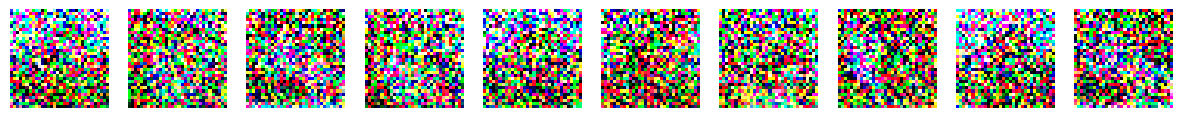

In [61]:
gc.collect()
torch.cuda.empty_cache()
def plot_images(means, precisions, epoch = 0, plot_number = 10, save_path=None):
    # plots plot_number samples from the trained model for image data
    num_components = means.shape[0]
    # sample from the multivariate normal distribution
    comp_num = torch.randint(0, num_components, (1,plot_number)) #shape: [1, plot_number]
    comp_num = comp_num.squeeze(0)  # shape: [plot_number]
    multivariate_normal = torch.distributions.MultivariateNormal(means[comp_num], precision_matrix=precisions[comp_num])
    samples = multivariate_normal.rsample()
    # transform images back to original data 
    samples = samples.view(-1, 3, 32, 32)
    samples = samples * 0.5 + 0.5
    fig, axs = plt.subplots(1, plot_number, figsize=(15, 2))
    for i in range(plot_number):
        img = samples[i].permute(1, 2, 0).cpu().numpy()  # change from [C, H, W] to [H, W, C]
        axs[i].imshow(img)
        axs[i].axis('off')
    if save_path is not None:
        save_path = save_path + 'epoch'+ str(epoch) + '.png'
        plt.savefig(save_path)
    

    return None
def load_model(model, centers, load_model_path, load_centers_path):   
    """
    Loads model weights from the specified path.
    """
    if load_model_path is not None and os.path.exists(load_model_path):
        state_dict = torch.load(load_model_path, map_location=device)
        
        # Strip "module." prefix if present
        if any(k.startswith("module.") for k in state_dict.keys()):
            from collections import OrderedDict
            new_state_dict = OrderedDict()
            for k, v in state_dict.items():
                new_state_dict[k.replace("module.", "")] = v
            state_dict = new_state_dict
        
        # Strip "_orig_mod." prefix if present
        if any(k.startswith("_orig_mod.") for k in state_dict.keys()):
            from collections import OrderedDict
            new_state_dict = OrderedDict()
            for k, v in state_dict.items():
                new_state_dict[k.replace("_orig_mod.", "")] = v
            state_dict = new_state_dict
        
        model.load_state_dict(state_dict)
        logging.info(f"Loaded model weights from {load_model_path}")
    
    if load_centers_path is not None and os.path.exists(load_centers_path):
        centers = torch.load(load_centers_path, map_location=device)
        logging.info(f"Loaded centers from {load_centers_path}")
    else:
        print(f"No model loaded. Path does not exist: {load_model_path}")
    
    return model, centers


# sample from trained model
# and plot density
#file /wpo_distill/cifar10_experiments/test/epoch499model_weights.pth
#factornet.load_state_dict(torch.load('wpo_distill/cifar10_experiments/test/epoch499model_weights.pth'))
print(os.path.exists("/workspace/cifar10_experiments/test/epoch1501model_weights.pth"))
print("Current working dir:", os.getcwd())
model = construct_factor_model(data_dim, depth, hidden_units).to(device).to(dtype = torch.float32)
model, centers = load_model(model, centers, "cifar10_experiments/test/cifar10_experiments_test_epoch1501model_weights.pth", "cifar10_experiments/test/cifar10_experiments_test_50000epochs1000centers.pt")
centers = torch.load("cifar10_experiments/test/sample_size500_test_size2_batch_size2_centers10_lr0.002centers.pt", map_location=device)
model = model.to('cpu')
centers = centers.to('cpu')
#model.load_state_dict(torch.load("/workspace/cifar10_experiments/test/epoch1501model_weights.pth"))

with torch.no_grad():
        
    precisions = LearnCholesky.vectors_to_precision(model(centers),data_dim)

    plot_images(centers, precisions, epoch = epochs, plot_number=10, save_path=save_directory + 'samples')

""" I think this will not work for general (centers needs to be same as before to plot properly)
randind = torch.randint(0,1000,[1000,])
centers = means[randind,:].to(device)
precisions = LearnCholesky.vectors_to_precision(factornet(centers),data_dim)

LearnCholesky.scatter_samples_from_model(centers, precisions, dim1 = 0, dim2 = 1,save_path=save_directory + 'samples.png')
LearnCholesky.plot_density_2d_marg(centers,factornet,dim1 = 0, dim2 = 1, save_path=save_directory + 'density.png')
"""
plt.show()

Saving images to: cifar10_experiments/test/epoch50000testing


Sample stats: -30.851680755615234 30.816551208496094 -0.038820069283246994


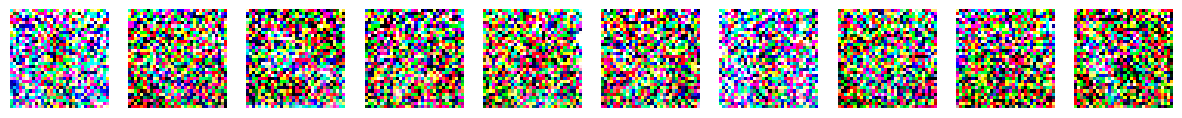

In [53]:
def sample_from_model(factornet, means, sample_number):
    num_components, dim = means.shape
    comp_num = torch.randint(0, num_components, (sample_number,), device=means.device)
    samples = torch.empty(sample_number, dim, device=means.device)

    unique_indices = comp_num.unique()

    for i in unique_indices:
        idx = (comp_num == i).nonzero(as_tuple=True)[0]
        n_i = idx.shape[0]
        centers_i = means[i].unsqueeze(0).expand(n_i, -1)  # [n_i, dim]

        # Get model output vectors (flattened Cholesky)
        vectors = factornet(centers_i)  # [n_i, d*(d+1)//2]

        # Use your existing function to get precision matrix with stabilization
        precision = LearnCholesky.vectors_to_precision(vectors, dim)  # [n_i, dim, dim]

        # Create multivariate normal with precision matrix
        mvn = MultivariateNormal(loc=centers_i, precision_matrix=precision)

        # Sample from this distribution
        samples_i = mvn.rsample()  # [n_i, dim]

        samples[idx] = samples_i

    return samples


    def plot_images_with_model(factornet, means, plot_number = 10, save_path=None):
        # plots plot_number samples from the trained model for image data
        num_components = means.shape[0]
        dim = means.shape[-1]
        # sample from the multivariate normal distribution
        comp_num = torch.randint(0, num_components, (1,plot_number)) #shape: [1, plot_number]
        comp_num = comp_num.squeeze(0)  # shape: [plot_number]
        samples = torch.empty(plot_number, dim, device=means.device)  # shape: [plot_number, d]
        samples = sample_from_model(factornet, means, plot_number)
        print("Sample stats:", samples.min().item(), samples.max().item(), samples.mean().item())

        # transform images back to original data 
        samples = samples.view(-1, 3, 32, 32)
        samples = samples * 0.5 + 0.5
        fig, axs = plt.subplots(1, plot_number, figsize=(15, 2))
        for i in range(plot_number):
            img = samples[i].permute(1, 2, 0).cpu().numpy()  # change from [C, H, W] to [H, W, C]
            axs[i].imshow(img)
            axs[i].axis('off')
        if save_path is not None:
            save_path = save_path + '_sampled_images.png'
            plt.savefig(save_path)
        #plt.close(fig)
        return None


with torch.no_grad():
    filename_final = save_directory + 'epoch' + str(epochs) + 'testing'
    print("Saving images to:", filename_final)
    # sample from the trained model
    plot_images_with_model(model, centers, plot_number=10, save_path=filename_final)
plt.show()

In [59]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

# Load model and checkpoint
model = construct_factor_model(data_dim, depth, hidden_units).to(device).to(dtype=torch.float32)
state_dict = torch.load("cifar10_experiments/test/sample_size500_test_size2_batch_size2_centers10_lr0.002_epoch0009_factornet.pth", map_location=device)

new_state_dict = {}
for k, v in state_dict.items():
    new_key = k
    if k.startswith("module."):
        new_key = k[len("module."):]  # Remove 'module.' prefix
    new_state_dict[new_key] = v

load_result = model.load_state_dict(new_state_dict)

centers = torch.load("cifar10_experiments/test/sample_size500_test_size2_batch_size2_centers10_lr0.002centers.pt", map_location='cpu')
centers = centers.to('cpu')

with torch.no_grad():
    precisions = LearnCholesky.vectors_to_precision(model(centers), data_dim)
precisions = precisions.to('cpu')

plot_images(centers, precisions, epoch=epochs, plot_number=10, save_path=save_directory + 'samples')


KeyboardInterrupt: 

In [ ]:
# LearnCholesky.scatter_samples_from_model(centers, precisions, dim1 = 2, dim2 = 3, save_path=save_directory + 'samples.png')
# LearnCholesky.plot_density_2d_marg(centers,factornet, dim1 = 2, dim2 = 3, save_path=save_directory + 'density.png')
# LearnCholesky.scatter_samples_from_model(centers, precisions, dim1 = 4, dim2 = 5,  save_path=save_directory + 'samples.png')
# LearnCholesky.plot_density_2d_marg(centers,factornet, dim1 = 4, dim2 = 5,save_path=save_directory + 'density.png')